# Introduction



In [4]:
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client, progress
client = Client('localhost:8786')
client

<Client: 'tcp://192.168.1.9:8786' processes=1 threads=4, memory=17.18 GB>

In [430]:
import pandas as pd
import numpy as np
import dask
import dask.dataframe as dd
from dask import delayed
import dask.array as da
import math
from matplotlib import pyplot as plt
import seaborn as sns
import hdbscan 
from kmodes.kmodes import KModes
import statsmodels.api as sm
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import parfit.parfit as pf

In [6]:
spotify = dd.read_csv('/Volumes/T_Drive/Data/log_0_20180715_000000000000.csv', blocksize="10MB")

In [7]:
spotify.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 21 entries, session_id to hist_user_behavior_reason_end
dtypes: object(6), bool(6), int64(9)

In [8]:
spotify.head()

session_id  session_position  session_length  \
0  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 1              20   
1  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 2              20   
2  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 3              20   
3  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 4              20   
4  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 5              20   

                           track_id_clean  skip_1  skip_2  skip_3  \
0  t_0479f24c-27d2-46d6-a00c-7ec928f2b539   False   False   False   
1  t_9099cd7b-c238-47b7-9381-f23f2c1d1043   False   False   False   
2  t_fc5df5ba-5396-49a7-8b29-35d0d28249e0   False   False   False   
3  t_23cff8d6-d874-4b20-83dc-94e450e8aa20   False   False   False   
4  t_64f3743c-f624-46bb-a579-0f3f9a07a123   False   False   False   

   not_skipped  context_switch  no_pause_before_play  ...  \
0         True               0                     0  ...   
1         True               0                     1  ...   
2         True               0                     1  ...   
3         True               0                     1  ...   
4         True               0                     1  ...   

   long_pause_before_play  hist_user_behavior_n_seekfwd  \
0                       0                             0   
1                       0                             0   
2                       0                             0   
3                       0                             0   
4                       0                             0   

   hist_user_behavior_n_seekback  hist_user_behavior_is_shuffle  hour_of_day  \
0                              0                           True           16   
1                              0                           True           16   
2                              0                           True           16   
3                              0                           True           16   
4                              0                           True           16   

         date premium        context_type hist_user_behavior_reason_start  \
0  2018-07-15    True  editorial_playlist                       trackdone   
1  2018-07-15    True  editorial_playlist                       trackdone   
2  2018-07-15    True  editorial_playlist                       trackdone   
3  2018-07-15    True  editorial_playlist                       trackdone   
4  2018-07-15    True  editorial_playlist                       trackdone   

  hist_user_behavior_reason_end  
0                     trackdone  
1                     trackdone  
2                     trackdone  
3                     trackdone  
4                     trackdone  

[5 rows x 21 columns]

In [9]:
# see tail of this particular chunk
spotify.tail()

session_id  session_position  \
29733  0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769                16   
29734  0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769                17   
29735  0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769                18   
29736  0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769                19   
29737  0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769                20   

       session_length                          track_id_clean  skip_1  skip_2  \
29733              20  t_7cfd4fc9-6811-41a2-8bea-daed723afc69    True    True   
29734              20  t_5c99f04b-47c6-4307-bb21-75b068b5d078    True    True   
29735              20  t_7cfd4fc9-6811-41a2-8bea-daed723afc69    True    True   
29736              20  t_5c99f04b-47c6-4307-bb21-75b068b5d078   False   False   
29737              20  t_7cfd4fc9-6811-41a2-8bea-daed723afc69    True    True   

       skip_3  not_skipped  context_switch  no_pause_before_play  ...  \
29733    True        False               0                     1  ...   
29734    True        False               0                     1  ...   
29735    True        False               0                     1  ...   
29736    True        False               0                     1  ...   
29737    True        False               0                     1  ...   

       long_pause_before_play  hist_user_behavior_n_seekfwd  \
29733                       0                             0   
29734                       0                             0   
29735                       0                             0   
29736                       0                             4   
29737                       0                             0   

       hist_user_behavior_n_seekback  hist_user_behavior_is_shuffle  \
29733                              0                           True   
29734                              0                           True   
29735                              0                           True   
29736                              0                           True   
29737                              0                           True   

       hour_of_day        date premium     context_type  \
29733            5  2018-07-15    True  user_collection   
29734            5  2018-07-15    True  user_collection   
29735            5  2018-07-15    True  user_collection   
29736            5  2018-07-15    True  user_collection   
29737            5  2018-07-15    True  user_collection   

      hist_user_behavior_reason_start hist_user_behavior_reason_end  
29733                          fwdbtn                       backbtn  
29734                         backbtn                        fwdbtn  
29735                          fwdbtn                       backbtn  
29736                         backbtn                        fwdbtn  
29737                          fwdbtn                        fwdbtn  

[5 rows x 21 columns]

In [10]:
spotify.dtypes

session_id                         object
session_position                    int64
session_length                      int64
track_id_clean                     object
skip_1                               bool
skip_2                               bool
skip_3                               bool
not_skipped                          bool
context_switch                      int64
no_pause_before_play                int64
short_pause_before_play             int64
long_pause_before_play              int64
hist_user_behavior_n_seekfwd        int64
hist_user_behavior_n_seekback       int64
hist_user_behavior_is_shuffle        bool
hour_of_day                         int64
date                               object
premium                              bool
context_type                       object
hist_user_behavior_reason_start    object
hist_user_behavior_reason_end      object
dtype: object

In [11]:
spotify.shape[0].compute()

2990609

In [12]:
print(spotify.isnull().sum().compute())

session_id                         0
session_position                   0
session_length                     0
track_id_clean                     0
skip_1                             0
skip_2                             0
skip_3                             0
not_skipped                        0
context_switch                     0
no_pause_before_play               0
short_pause_before_play            0
long_pause_before_play             0
hist_user_behavior_n_seekfwd       0
hist_user_behavior_n_seekback      0
hist_user_behavior_is_shuffle      0
hour_of_day                        0
date                               0
premium                            0
context_type                       0
hist_user_behavior_reason_start    0
hist_user_behavior_reason_end      0
dtype: int64


In [13]:
# How many sessions are there?
spotify.session_id.unique().compute()

0         0_00006f66-33e5-4de7-a324-2d18e439fc1e
1         0_0000a72b-09ac-412f-b452-9b9e79bded8f
2         0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a
3         0_00016a3d-9076-4f67-918f-f29e3ce160dc
4         0_00018b58-deb8-4f98-ac5e-d7e01b346130
                           ...                  
178337    0_fffddbbf-5972-4239-8687-896a315a1d87
178338    0_fffe8971-eac0-48e8-88d0-ffaec467bad2
178339    0_ffff16ed-55b2-455d-ab42-f716d50ffbaf
178340    0_ffff4b43-4c6e-4b9b-8790-dc099f04d0c5
178341    0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769
Name: session_id, Length: 178342, dtype: object

In [14]:
# Make booleans numeric

def make_bool_num(df):
    for col in df:
        if df[col].dtype == 'bool':
            df[col] = df[col] * 1
    return df[col] 

make_bool_num(spotify).compute()

0        trackdone
1        trackdone
2        trackdone
3        trackdone
4        trackdone
           ...    
29733      backbtn
29734       fwdbtn
29735      backbtn
29736       fwdbtn
29737       fwdbtn
Name: hist_user_behavior_reason_end, Length: 2990609, dtype: object

In [15]:
spotify.dtypes

session_id                         object
session_position                    int64
session_length                      int64
track_id_clean                     object
skip_1                              int64
skip_2                              int64
skip_3                              int64
not_skipped                         int64
context_switch                      int64
no_pause_before_play                int64
short_pause_before_play             int64
long_pause_before_play              int64
hist_user_behavior_n_seekfwd        int64
hist_user_behavior_n_seekback       int64
hist_user_behavior_is_shuffle       int64
hour_of_day                         int64
date                               object
premium                             int64
context_type                       object
hist_user_behavior_reason_start    object
hist_user_behavior_reason_end      object
dtype: object

session_id - unique identifier for the session that this row is a part of

session_position {1-20} - position of row within session

session_length {10-20} - number of rows in session

track_id_clean - unique identifier for the track played. This is linked with track_id in the track features and metadata table.

skip_1 - Boolean indicating if the track was only played very briefly

skip_2 - Boolean indicating if the track was only played briefly

skip_3 - Boolean indicating if most of the track was played

not_skipped Boolean indicating that the track was played in its entirety

context_switch - Boolean indicating if the user changed context between the previous row and the current row. This could for example occur if the user switched from one playlist to another.

no_pause_before_play - Boolean indicating if there was no pause between playback of the previous track and this track

short_pause_before_play - Boolean indicating if there was a short pause between playback of the previous track and this track

long_pause_before_play - Boolean indicating if there was a long pause between playback of the previous track and this track

hist_user_behavior_n_seekfwd - Number of times the user did a seek forward within track

hist_user_behavior_n_seekback - Number of times the user did a seek back within track

hist_user_behavior_is_shuffle - Boolean indicating if the user encountered this track while shuffle mode was activated

hour_of_day {0-23} - The hour of day

date - E.g. 2018-09-18 - The date

premium - Boolean indicating if the user was on premium or not. This has potential implications for skipping behavior.

context_type - E.g. editorial playlist - what type of context the playback occurred within

hist_user_behavior_reason_start - E.g. fwdbtn - the user action which led to the current track being played

hist_user_behavior_reason_end - E.g. trackdone - the user action which led to the current track playback ending

In [16]:
# Make a slice of ints for histograms
spotify_int = spotify.select_dtypes(include='int64')

In [17]:
spotify_int.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 15 entries, session_position to premium
dtypes: int64(15)

In [18]:
spotify_int.head()

session_position  session_length  skip_1  skip_2  skip_3  not_skipped  \
0                 1              20       0       0       0            1   
1                 2              20       0       0       0            1   
2                 3              20       0       0       0            1   
3                 4              20       0       0       0            1   
4                 5              20       0       0       0            1   

   context_switch  no_pause_before_play  short_pause_before_play  \
0               0                     0                        0   
1               0                     1                        0   
2               0                     1                        0   
3               0                     1                        0   
4               0                     1                        0   

   long_pause_before_play  hist_user_behavior_n_seekfwd  \
0                       0                             0   
1                       0                             0   
2                       0                             0   
3                       0                             0   
4                       0                             0   

   hist_user_behavior_n_seekback  hist_user_behavior_is_shuffle  hour_of_day  \
0                              0                              1           16   
1                              0                              1           16   
2                              0                              1           16   
3                              0                              1           16   
4                              0                              1           16   

   premium  
0        1  
1        1  
2        1  
3        1  
4        1

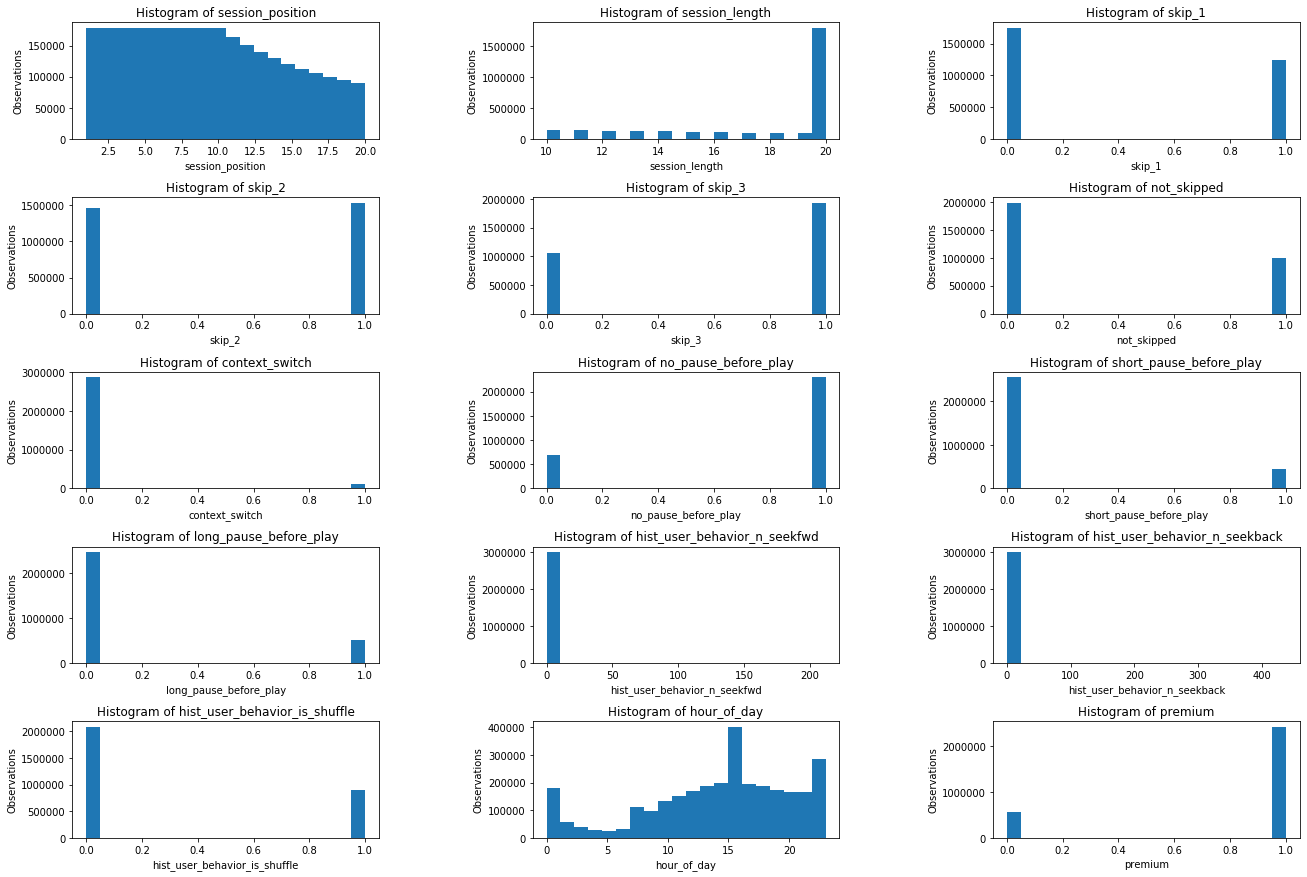

In [19]:
def get_dist(df, figsize, rotation, hspace, wspace):
    plt.figure(figsize=(figsize))
    for i, col in enumerate(df):
        num_vals = len(df.columns)
        num_cols = math.ceil(num_vals / 5)
        num_rows = math.ceil(num_vals / num_cols)
        plt.subplot(num_rows, num_cols, i+1)
        plt.hist(df[col], bins=20)
        plt.title('Histogram of {}'.format(col))
        plt.xlabel('{}'.format(col))
        plt.ylabel('Observations')
        plt.xticks(rotation=rotation)
        plt.subplots_adjust(hspace=hspace, wspace=wspace)

get_dist(spotify_int.compute(), (22,15), 'horizontal', .5, .5)

Okay, so we definitely have at least 10 Bernoulli distributions because of the booleans. I want to look at hist_user_behavior_n_seekfwd and hist_user_behavior_n_seekback to see exactly what values they contain.

In [20]:
spotify['hist_user_behavior_n_seekfwd'].value_counts().compute()

0      2905317
1        69303
2         9782
3         3227
4         1284
5          595
6          330
7          200
8          121
9           87
10          50
11          46
12          34
13          30
14          23
17          19
16          18
19          18
15          17
18          12
23          10
24           9
21           8
20           7
25           6
27           5
29           5
30           5
39           4
22           4
31           3
34           3
35           3
28           3
46           2
26           2
60           2
40           2
44           2
32           1
57           1
56           1
52           1
47           1
42           1
45           1
33           1
38           1
36           1
212          1
Name: hist_user_behavior_n_seekfwd, dtype: int64

In [21]:
spotify['hist_user_behavior_n_seekback'].value_counts().compute()

0      2901356
1        73549
2         9160
3         2832
4         1334
        ...   
38           1
52           1
43           1
48           1
438          1
Name: hist_user_behavior_n_seekback, Length: 66, dtype: int64

Alright, so there's actually quite a variety of values in these columns (definitely some outliers as well). Of course, most people didn't seek backwards or forwards within a track at all, but we can see that a few people did many times.

Now we'll want to see the distribution for the non-numeric variables (objects) in the user interaction df. Let's look at which ones they are first.

In [22]:
spotify_obj = spotify.select_dtypes(include='object')

In [23]:
spotify_obj.head()

session_id  \
0  0_00006f66-33e5-4de7-a324-2d18e439fc1e   
1  0_00006f66-33e5-4de7-a324-2d18e439fc1e   
2  0_00006f66-33e5-4de7-a324-2d18e439fc1e   
3  0_00006f66-33e5-4de7-a324-2d18e439fc1e   
4  0_00006f66-33e5-4de7-a324-2d18e439fc1e   

                           track_id_clean        date        context_type  \
0  t_0479f24c-27d2-46d6-a00c-7ec928f2b539  2018-07-15  editorial_playlist   
1  t_9099cd7b-c238-47b7-9381-f23f2c1d1043  2018-07-15  editorial_playlist   
2  t_fc5df5ba-5396-49a7-8b29-35d0d28249e0  2018-07-15  editorial_playlist   
3  t_23cff8d6-d874-4b20-83dc-94e450e8aa20  2018-07-15  editorial_playlist   
4  t_64f3743c-f624-46bb-a579-0f3f9a07a123  2018-07-15  editorial_playlist   

  hist_user_behavior_reason_start hist_user_behavior_reason_end  
0                       trackdone                     trackdone  
1                       trackdone                     trackdone  
2                       trackdone                     trackdone  
3                       trackdone                     trackdone  
4                       trackdone                     trackdone

In [24]:
# Find number of unique dates in the dataset 
pd.set_option("display.max_rows", 70)
print(spotify.date.unique().compute())

0     2018-07-15
1     2018-07-14
2     2018-07-13
3     2018-07-12
4     2018-06-05
5     2018-07-11
6     2018-07-16
7     2018-07-10
8     2018-07-04
9     2018-07-05
10    2018-07-07
11    2018-05-18
12    2018-07-06
13    2018-05-12
14    2018-07-09
15    2018-06-29
16    2018-06-30
17    2018-06-19
18    2018-07-08
19    2018-06-27
20    2018-07-01
21    2018-05-17
22    2018-06-24
23    2018-01-08
24    2018-05-20
25    2018-01-14
26    2018-06-22
27    2018-06-20
28    2018-07-03
29    2018-05-27
30    2018-06-18
31    2017-11-25
32    2018-07-02
33    2018-06-25
34    2018-06-28
35    2018-06-02
36    2018-08-22
37    2018-06-21
38    2018-05-01
39    2017-03-02
40    2018-05-16
41    2018-06-23
42    2018-06-14
43    2018-06-26
44    2018-05-29
45    2018-06-09
46    2015-09-30
47    2018-06-15
48    2018-02-06
49    2018-05-24
50    2017-09-27
51    2018-06-08
52    2018-06-13
53    2018-04-28
54    2018-05-25
55    2017-10-01
56    2018-06-04
57    2018-08-08
58    2018-05-

In [25]:
# I want to pull out just the month & day from date, since that could be interesting & most years are 2018

# First convert date from object to datetime
spotify['date'] = dd.to_datetime(spotify['date'])

# Extract just the day of the month from date
spotify['day'] = spotify.date.dt.day

# Check all represented days are still there
print(spotify['day'].unique().compute())

0     15
1     14
2     13
3     12
4      5
5     11
6     16
7     10
8      4
9      7
10    18
11     6
12     9
13    29
14    30
15    19
16     8
17    27
18     1
19    17
20    24
21    20
22    22
23     3
24    25
25     2
26    28
27    21
28    23
29    26
Name: day, dtype: int64


In [26]:
# Now we'll get month
spotify['month'] = spotify.date.dt.month

# Check both months are there
print(spotify['month'].unique().compute())

0      7
1      6
2      5
3      1
4     11
5      8
6      3
7      9
8      2
9      4
10    10
Name: month, dtype: int64


In [27]:
# Now I need to put month & day together in one int variable, since we need them both together, as some days overlap

# Make a month_day column that includes both day and month as float
spotify['month_day'] = spotify['month'] + (spotify['day'] / 100)

In [28]:
# Check this was done correctly
spotify.head()

session_id  session_position  session_length  \
0  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 1              20   
1  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 2              20   
2  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 3              20   
3  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 4              20   
4  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 5              20   

                           track_id_clean  skip_1  skip_2  skip_3  \
0  t_0479f24c-27d2-46d6-a00c-7ec928f2b539       0       0       0   
1  t_9099cd7b-c238-47b7-9381-f23f2c1d1043       0       0       0   
2  t_fc5df5ba-5396-49a7-8b29-35d0d28249e0       0       0       0   
3  t_23cff8d6-d874-4b20-83dc-94e450e8aa20       0       0       0   
4  t_64f3743c-f624-46bb-a579-0f3f9a07a123       0       0       0   

   not_skipped  context_switch  no_pause_before_play  ...  \
0            1               0                     0  ...   
1            1               0                     1  ...   
2            1               0                     1  ...   
3            1               0                     1  ...   
4            1               0                     1  ...   

   hist_user_behavior_is_shuffle  hour_of_day       date  premium  \
0                              1           16 2018-07-15        1   
1                              1           16 2018-07-15        1   
2                              1           16 2018-07-15        1   
3                              1           16 2018-07-15        1   
4                              1           16 2018-07-15        1   

         context_type  hist_user_behavior_reason_start  \
0  editorial_playlist                        trackdone   
1  editorial_playlist                        trackdone   
2  editorial_playlist                        trackdone   
3  editorial_playlist                        trackdone   
4  editorial_playlist                        trackdone   

  hist_user_behavior_reason_end  day month month_day  
0                     trackdone   15     7      7.15  
1                     trackdone   15     7      7.15  
2                     trackdone   15     7      7.15  
3                     trackdone   15     7      7.15  
4                     trackdone   15     7      7.15  

[5 rows x 24 columns]

In [29]:
print(spotify.month_day.unique().compute())

0      7.15
1      7.14
2      7.13
3      7.12
4      6.05
5      7.11
6      7.16
7      7.10
8      7.04
9      7.05
10     7.07
11     5.18
12     7.06
13     5.12
14     7.09
15     6.29
16     6.30
17     6.19
18     7.08
19     6.27
20     7.01
21     5.17
22     6.24
23     1.08
24     5.20
25     1.14
26     6.22
27     6.20
28     7.03
29     5.27
30     6.18
31    11.25
32     7.02
33     6.25
34     6.28
35     6.02
36     8.22
37     6.21
38     5.01
39     3.02
40     5.16
41     6.23
42     6.14
43     6.26
44     5.29
45     6.09
46     9.30
47     6.15
48     2.06
49     5.24
50     9.27
51     6.08
52     6.13
53     4.28
54     5.25
55    10.01
56     6.04
57     8.08
58     5.14
59     5.15
60     2.12
61     4.21
62     6.10
63     5.02
64     5.11
65     4.04
66     6.11
Name: month_day, dtype: float64


In [30]:
# Now, since there are a few different years here, we'll pull those out separately too just in case that's important

# Get year variable
spotify['year'] = spotify.date.dt.year

# Check both months are there
print(spotify['year'].unique().compute())

0    2018
1    2017
2    2015
Name: year, dtype: int64


In [31]:
# Lets also check the value_counts for 'year,' since I think 2018 is way more represented 
print(spotify.year.value_counts().unique().compute())

0    2990517
1         72
2         20
Name: year, dtype: int64


In [32]:
spotify.head()

session_id  session_position  session_length  \
0  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 1              20   
1  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 2              20   
2  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 3              20   
3  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 4              20   
4  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 5              20   

                           track_id_clean  skip_1  skip_2  skip_3  \
0  t_0479f24c-27d2-46d6-a00c-7ec928f2b539       0       0       0   
1  t_9099cd7b-c238-47b7-9381-f23f2c1d1043       0       0       0   
2  t_fc5df5ba-5396-49a7-8b29-35d0d28249e0       0       0       0   
3  t_23cff8d6-d874-4b20-83dc-94e450e8aa20       0       0       0   
4  t_64f3743c-f624-46bb-a579-0f3f9a07a123       0       0       0   

   not_skipped  context_switch  no_pause_before_play  ...  hour_of_day  \
0            1               0                     0  ...           16   
1            1               0                     1  ...           16   
2            1               0                     1  ...           16   
3            1               0                     1  ...           16   
4            1               0                     1  ...           16   

        date  premium        context_type  hist_user_behavior_reason_start  \
0 2018-07-15        1  editorial_playlist                        trackdone   
1 2018-07-15        1  editorial_playlist                        trackdone   
2 2018-07-15        1  editorial_playlist                        trackdone   
3 2018-07-15        1  editorial_playlist                        trackdone   
4 2018-07-15        1  editorial_playlist                        trackdone   

   hist_user_behavior_reason_end day  month month_day  year  
0                      trackdone  15      7      7.15  2018  
1                      trackdone  15      7      7.15  2018  
2                      trackdone  15      7      7.15  2018  
3                      trackdone  15      7      7.15  2018  
4                      trackdone  15      7      7.15  2018  

[5 rows x 25 columns]

In [33]:
# Now we need to see what the unique values of the other objects are
print(spotify.context_type.value_counts().compute())                       
print(spotify.hist_user_behavior_reason_start.value_counts().compute())    
print(spotify.hist_user_behavior_reason_end.value_counts().compute())

user_collection          1202096
catalog                   679095
editorial_playlist        629425
radio                     388236
personalized_playlist      50547
charts                     41210
Name: context_type, dtype: int64
fwdbtn        1416042
trackdone      993323
clickrow       312338
backbtn        226818
appload         34493
playbtn          2784
remote           2706
trackerror       1708
endplay           391
popup               5
uriopen             1
Name: hist_user_behavior_reason_start, dtype: int64
fwdbtn       1443616
trackdone    1039155
endplay       264417
backbtn       228816
logout          9424
remote          5123
clickrow          49
appload            5
popup              3
uriopen            1
Name: hist_user_behavior_reason_end, dtype: int64


In [34]:
# Let's recode the relevant objects to make them numeric before running barplots & other EDA

# Produce a dictionary associating the alphabetized values of a col with their numeric indices 
def make_numeric(df_series):
    df_series_sorted = sorted(df_series.unique())
    num_dict = {}
    for index, val in enumerate(df_series_sorted):
        num_dict[val] = index    
    return num_dict

# Recode the col using the index numbers generated from the previous make_numeric function
def recode(df, column_name, recode_column_name, dtype):
    value_dict = make_numeric(df[column_name])
    df[recode_column_name] = df.apply(lambda row: value_dict[row[column_name]], axis=1, meta=dtype)
    print(value_dict)

In [35]:
# Apply recode function to objects
recode(spotify, "context_type", "context_type_num", "int64")
recode(spotify, "hist_user_behavior_reason_start", "reason_start_num", "int64")
recode(spotify, "hist_user_behavior_reason_end", "reason_end_num", "int64")

{'catalog': 0, 'charts': 1, 'editorial_playlist': 2, 'personalized_playlist': 3, 'radio': 4, 'user_collection': 5}
{'appload': 0, 'backbtn': 1, 'clickrow': 2, 'endplay': 3, 'fwdbtn': 4, 'playbtn': 5, 'popup': 6, 'remote': 7, 'trackdone': 8, 'trackerror': 9, 'uriopen': 10}
{'appload': 0, 'backbtn': 1, 'clickrow': 2, 'endplay': 3, 'fwdbtn': 4, 'logout': 5, 'popup': 6, 'remote': 7, 'trackdone': 8, 'uriopen': 9}


In [36]:
# Okay, now we're ready to make a slice without the id's & other objects so we can run barplots
spotify_eda = spotify.drop(columns=[
    'date', 
    'session_id', 
    'track_id_clean', 
    'context_type', 
    'hist_user_behavior_reason_start',
    'hist_user_behavior_reason_end'
])

In [37]:
# Double-check all are ints and floats
spotify_eda.dtypes

session_position                   int64
session_length                     int64
skip_1                             int64
skip_2                             int64
skip_3                             int64
not_skipped                        int64
context_switch                     int64
no_pause_before_play               int64
short_pause_before_play            int64
long_pause_before_play             int64
hist_user_behavior_n_seekfwd       int64
hist_user_behavior_n_seekback      int64
hist_user_behavior_is_shuffle      int64
hour_of_day                        int64
premium                            int64
day                                int64
month                              int64
month_day                        float64
year                               int64
context_type_num                   int64
reason_start_num                   int64
reason_end_num                     int64
dtype: object

In [38]:
# Check 'not_skipped' to make sure it represents whether the user skipped the track at any point

print(spotify_eda.not_skipped.compute())
print(spotify_eda.skip_1.compute())
print(spotify_eda.skip_2.compute())
print(spotify_eda.skip_3.compute())

0        1
1        1
2        1
3        1
4        1
        ..
29733    0
29734    0
29735    0
29736    0
29737    0
Name: not_skipped, Length: 2990609, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
29733    1
29734    1
29735    1
29736    0
29737    1
Name: skip_1, Length: 2990609, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
29733    1
29734    1
29735    1
29736    0
29737    1
Name: skip_2, Length: 2990609, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
29733    1
29734    1
29735    1
29736    1
29737    1
Name: skip_3, Length: 2990609, dtype: int64


Great, so not_skipped does represent whether or not a song was skipped at any point during its play. 

However, I think the way not_skipped is recorded makes interpreting it a bit confusing, simply because 1 means 'not' skipped, which is a negative. I like to have 0s be negative, so I'm just going to create a variable - 'skipped' - that takes the value 1 if the song was skipped, and 0 if the song was not skipped.

The following is not the most elegant solution, but I wanted to use np.where, which I could not find an appropriate counterpart for in dask, so I converted the df to pandas, used np.where to make the 'skipped' column, and then converted the df back to a dask df.

In [39]:
spotify_eda_pd = spotify_eda.compute()

spotify_eda_pd['skipped'] = np.where(spotify_eda_pd['not_skipped']>0, 0, 1)

In [40]:
spotify_eda_pd.head()

session_position  session_length  skip_1  skip_2  skip_3  not_skipped  \
0                 1              20       0       0       0            1   
1                 2              20       0       0       0            1   
2                 3              20       0       0       0            1   
3                 4              20       0       0       0            1   
4                 5              20       0       0       0            1   

   context_switch  no_pause_before_play  short_pause_before_play  \
0               0                     0                        0   
1               0                     1                        0   
2               0                     1                        0   
3               0                     1                        0   
4               0                     1                        0   

   long_pause_before_play  ...  hour_of_day  premium  day  month  month_day  \
0                       0  ...           16        1   15      7       7.15   
1                       0  ...           16        1   15      7       7.15   
2                       0  ...           16        1   15      7       7.15   
3                       0  ...           16        1   15      7       7.15   
4                       0  ...           16        1   15      7       7.15   

   year  context_type_num  reason_start_num  reason_end_num  skipped  
0  2018                 2                 8               8        0  
1  2018                 2                 8               8        0  
2  2018                 2                 8               8        0  
3  2018                 2                 8               8        0  
4  2018                 2                 8               8        0  

[5 rows x 23 columns]

Great, the first 5 observations in skipped are all 0s, whereas the first 5 in not_skipped are all 1s.

In [41]:
# Convert back to dask df
spotify_eda = dd.from_pandas(spotify_eda_pd, npartitions=1)

In [42]:
spotify_eda.info()     # Making sure it's a dask df & col number is correct

<class 'dask.dataframe.core.DataFrame'>
Columns: 23 entries, session_position to skipped
dtypes: float64(1), int64(22)

In [43]:
# Show a countplot for all columns in eda dataset

def countplot(df, rotation): 
    plt.figure(figsize=(15,10))
    for col in df:
        sns.catplot(x=col, kind='count', palette='Greens_r', data=df)
        plt.title('Distribution of {}'.format(col))
        plt.xlabel('{}'.format(col))
        plt.ylabel('Count')
        plt.xticks(rotation=rotation)
        plt.show()       

In [44]:
# # Use countplot function for our df
# countplot(spotify_eda.compute(), 'vertical')
# Alright we'll do this when we have the fucking cluster synced

In [45]:
# Check what number of tracks in a listening session is most common
print(spotify_eda.session_length.value_counts().compute())

20    1793440
10     145760
11     142571
12     135744
13     129493
14     123844
15     117885
16     108896
17     103904
18      97758
19      91314
Name: session_length, dtype: int64


In [46]:
# Make slice with only those listening sessions that have 20 songs in them
spotify_20 = spotify_eda[spotify_eda['session_length'] == 20]

spotify_20.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 23 entries, session_position to skipped
dtypes: float64(1), int64(22)

In [47]:
# Check length with above
len(spotify_20)

1793440

In [48]:
# Let's now limit ourselves to the 1st, middle, and last songs in each session
spotify20_3tracks =  spotify_20[(spotify_20[
    'session_position'] == 1) | (spotify_20[
    'session_position'] == 10) | (spotify_20[
    'session_position'] == 20)]

In [49]:
spotify20_3tracks.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 23 entries, session_position to skipped
dtypes: float64(1), int64(22)

In [50]:
spotify20_3tracks.head()

session_position  session_length  skip_1  skip_2  skip_3  not_skipped  \
0                 1              20       0       0       0            1   
0                20              20       1       1       1            0   
0                 1              20       1       1       1            0   
0                 1              20       0       0       0            1   
0                 1              20       0       0       1            0   

   context_switch  no_pause_before_play  short_pause_before_play  \
0               0                     0                        0   
0               0                     1                        0   
0               0                     0                        0   
0               0                     0                        0   
0               0                     0                        0   

   long_pause_before_play  ...  hour_of_day  premium  day  month  month_day  \
0                       0  ...           16        1   15      7       7.15   
0                       0  ...           20        1   14      7       7.14   
0                       0  ...           14        1   15      7       7.15   
0                       0  ...           17        1   15      7       7.15   
0                       0  ...           11        1   15      7       7.15   

   year  context_type_num  reason_start_num  reason_end_num  skipped  
0  2018                 2                 8               8        0  
0  2018                 5                 4               4        1  
0  2018                 5                 4               4        1  
0  2018                 2                 4               8        0  
0  2018                 2                 5               4        1  

[5 rows x 23 columns]

In [51]:
len(spotify20_3tracks)

269016

In [52]:
# ~Split spotify20_3tracks into 3 slices~

# A slice with all of the 1st tracks in each listening session:
spotify_track1 = spotify20_3tracks[spotify20_3tracks['session_position'] == 1]

# A slice with all of the 10th tracks in each listening session:
spotify_track10 = spotify20_3tracks[spotify20_3tracks['session_position'] == 10]

# A slice with all of the last (20th) track in each listening session:
spotify_track20 = spotify20_3tracks[spotify20_3tracks['session_position'] == 20]

In [53]:
len(spotify_track1)

89672

In [54]:
len(spotify_track10)

89672

In [55]:
len(spotify_track20)

89672

Great, they're all equal, as expected.

First let's do some EDA for these slices, one at a time. Then perhaps we can compare the slices to each other, to tease out how they might diverge (if they do at all).

In [56]:
# First, let's persist these datasets to memory, since they're smaller in scope than the original
spotify_track1 = client.persist(spotify_track1)
spotify_track10 = client.persist(spotify_track10)
spotify_track20 = client.persist(spotify_track20)

<Figure size 1080x720 with 0 Axes>

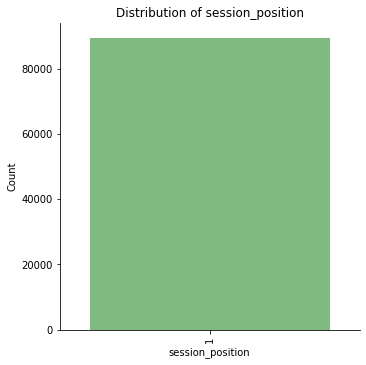

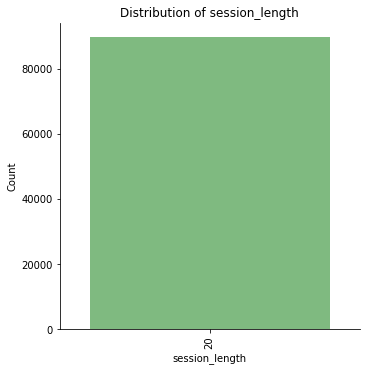

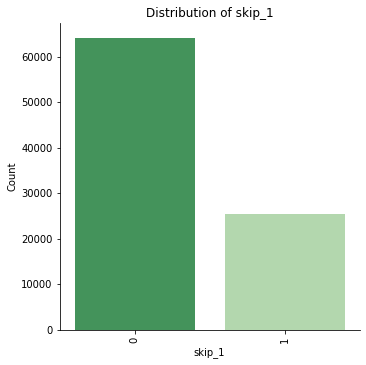

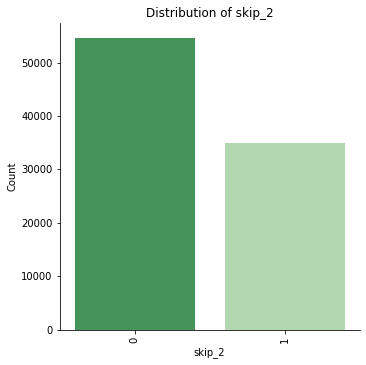

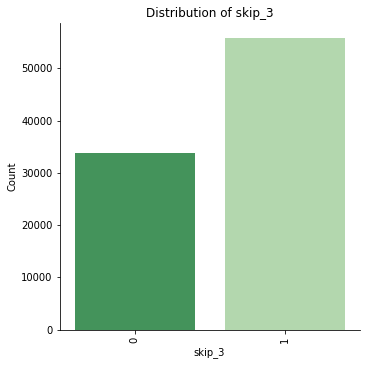

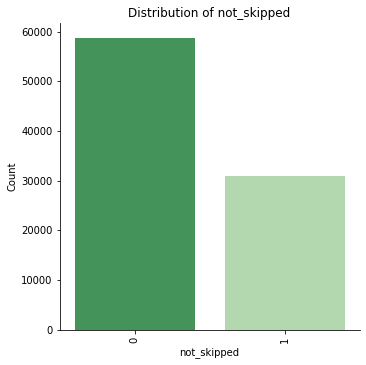

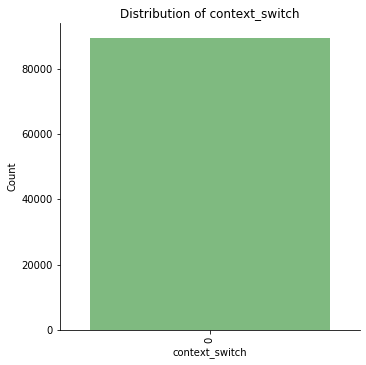

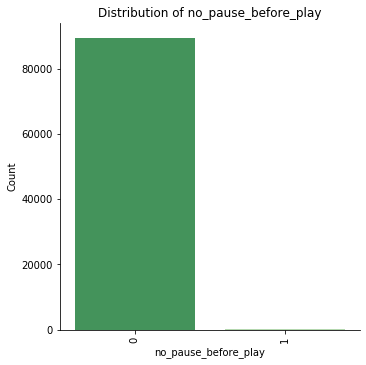

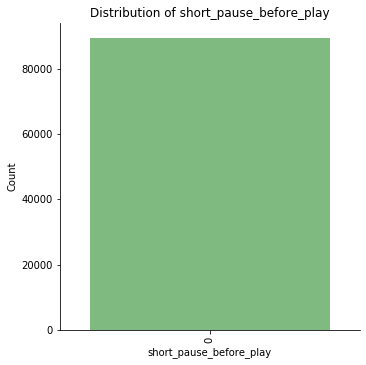

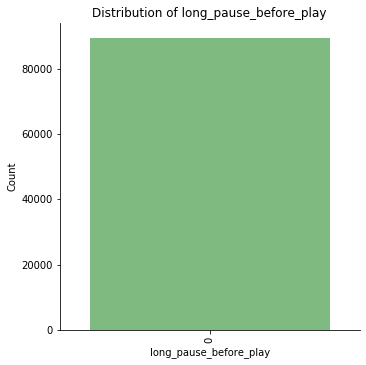

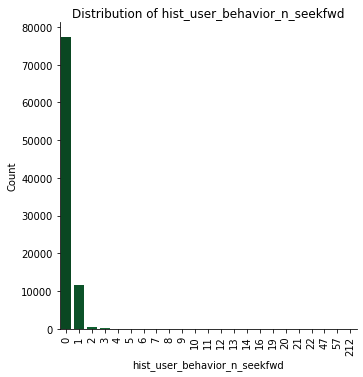

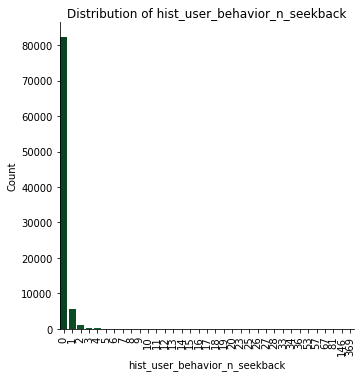

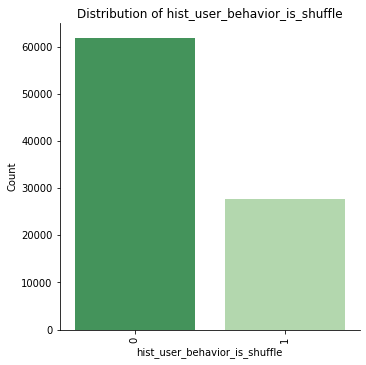

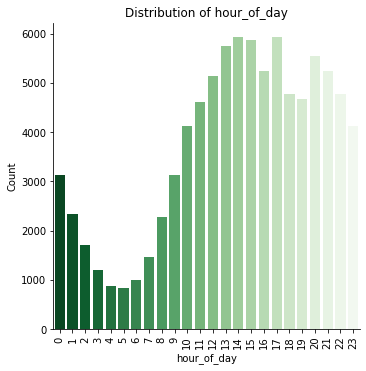

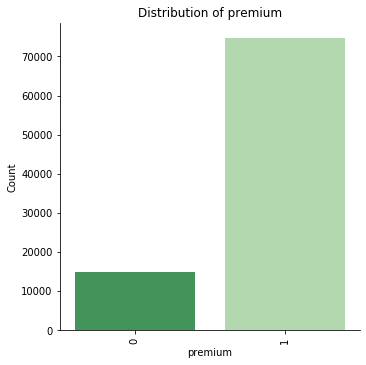

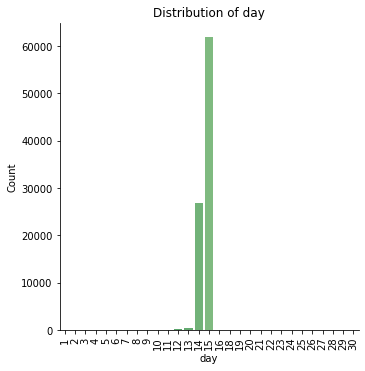

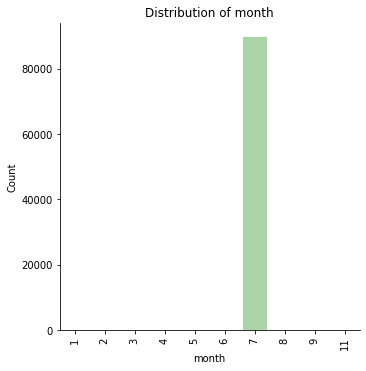

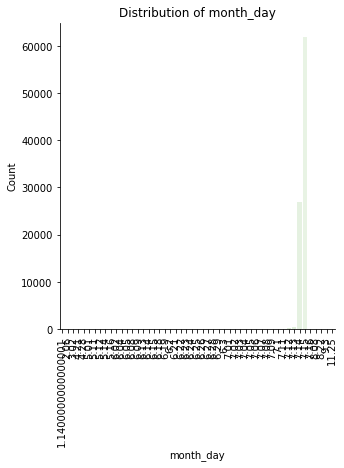

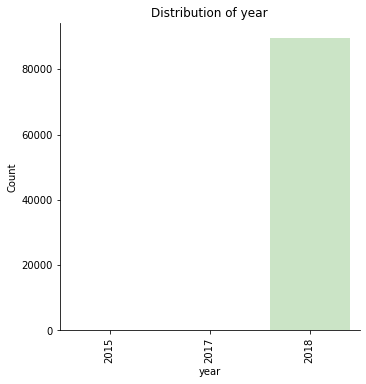

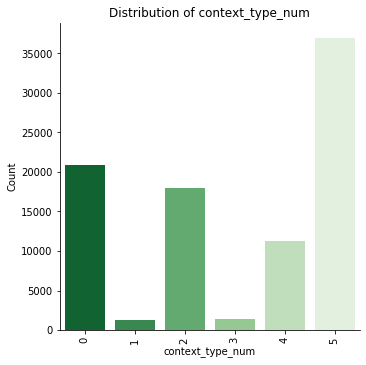

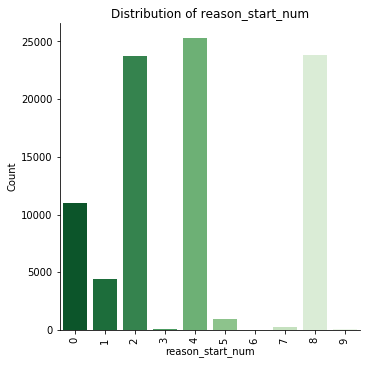

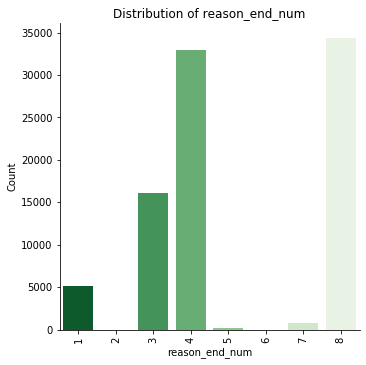

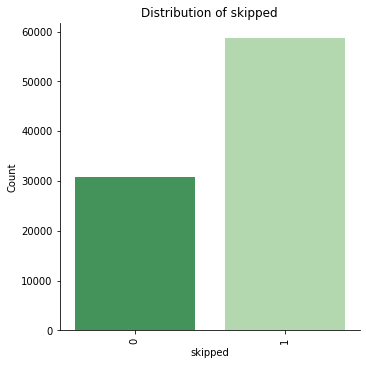

In [57]:
countplot(spotify_track1.compute(), 'vertical')

<Figure size 1080x720 with 0 Axes>

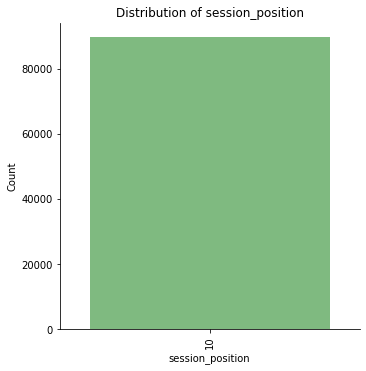

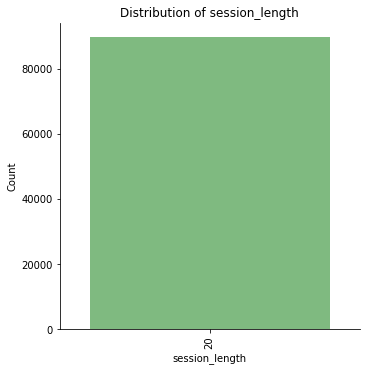

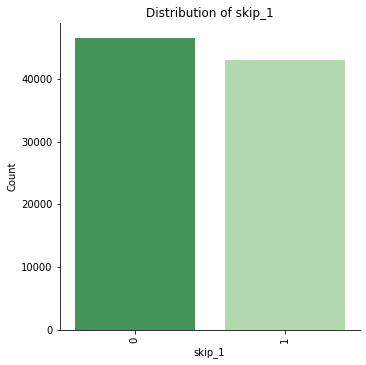

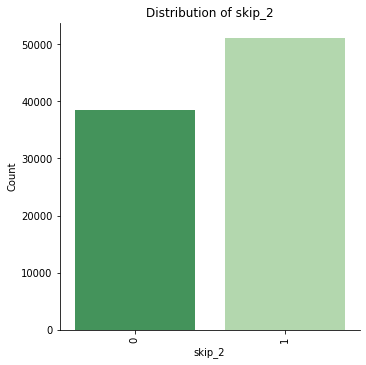

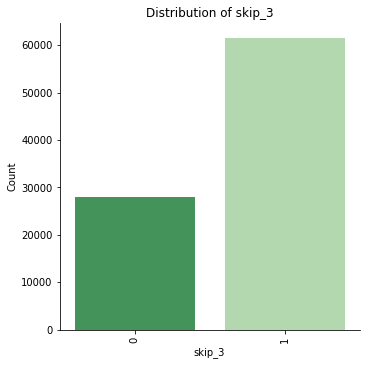

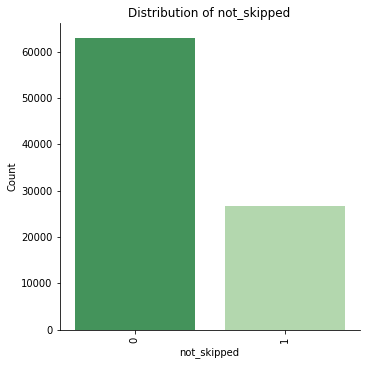

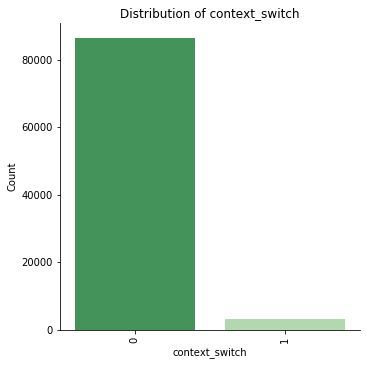

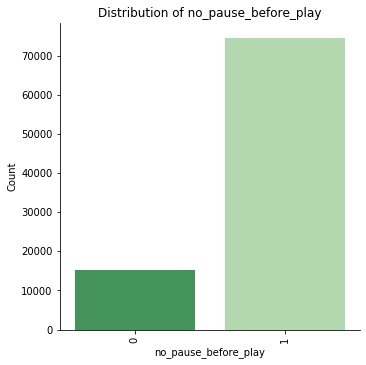

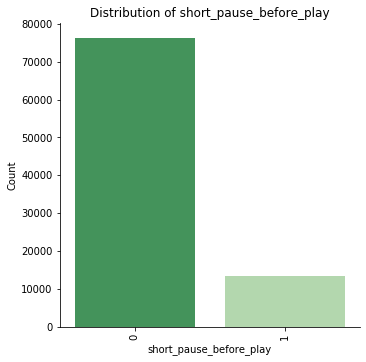

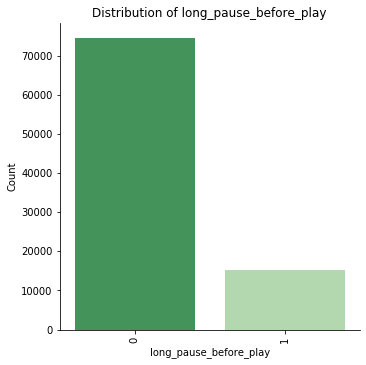

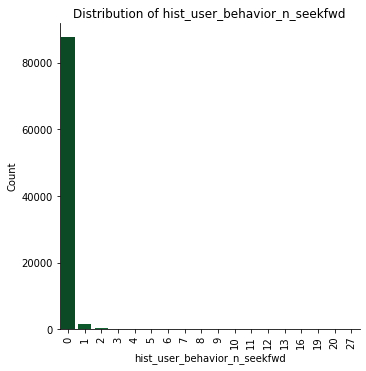

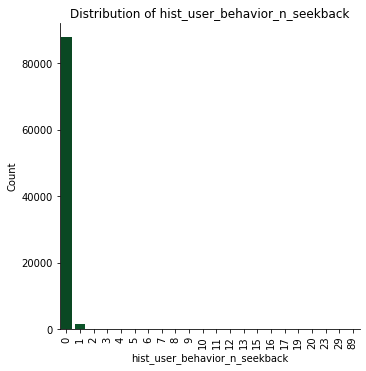

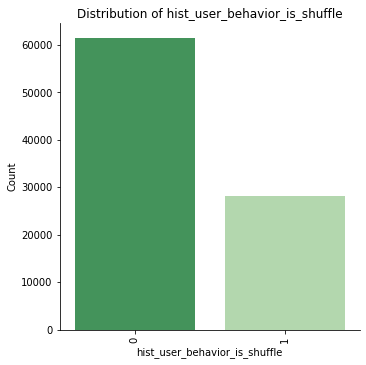

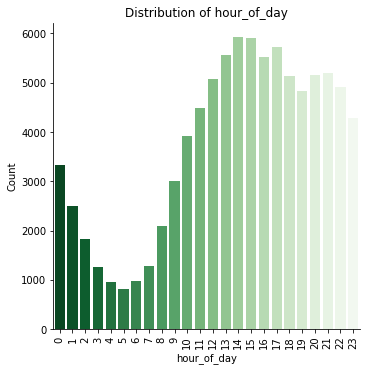

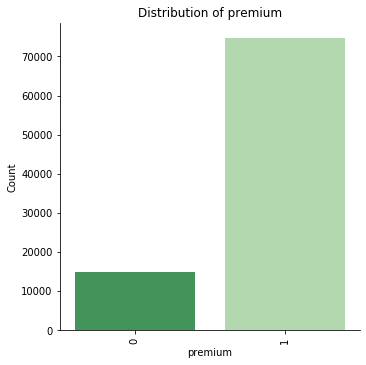

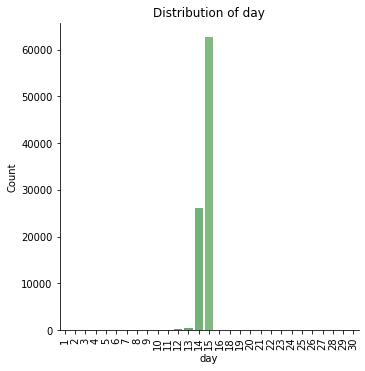

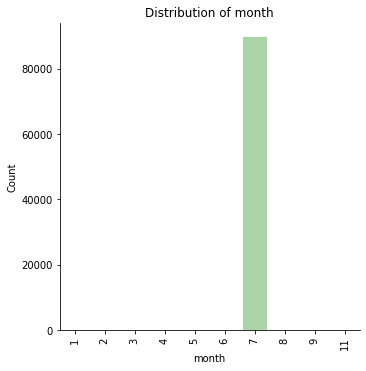

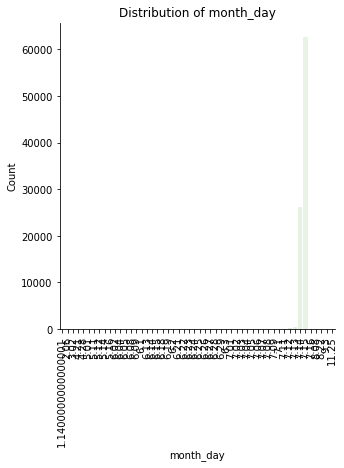

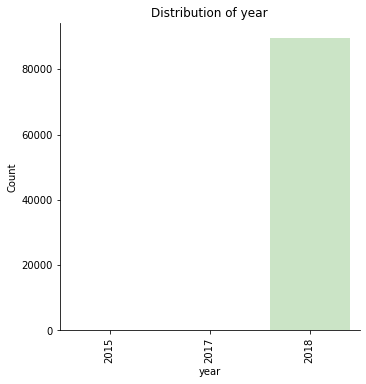

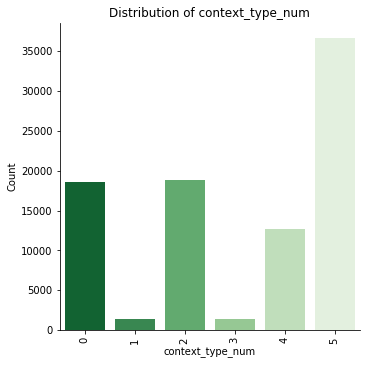

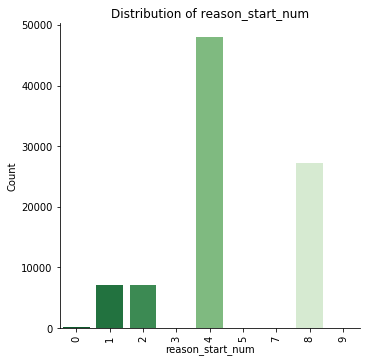

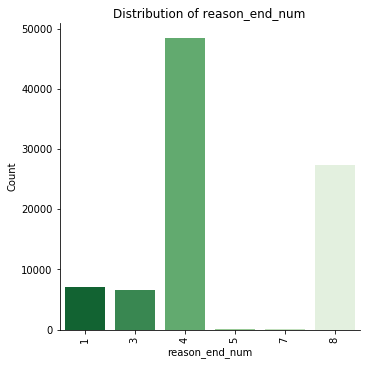

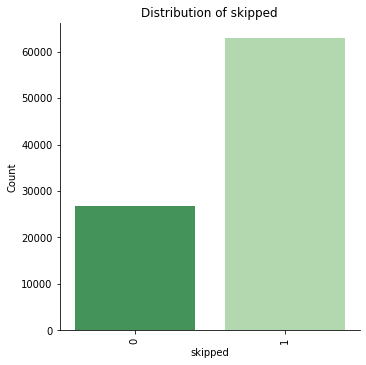

In [58]:
countplot(spotify_track10.compute(), 'vertical')

<Figure size 1080x720 with 0 Axes>

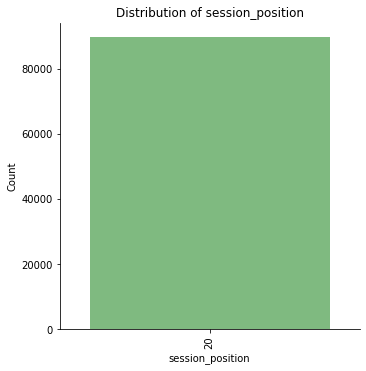

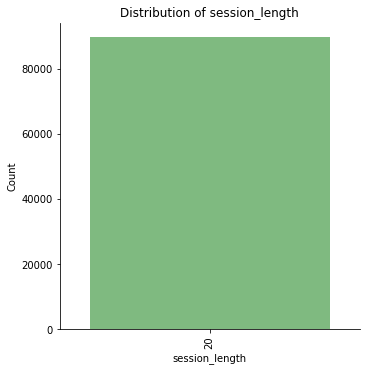

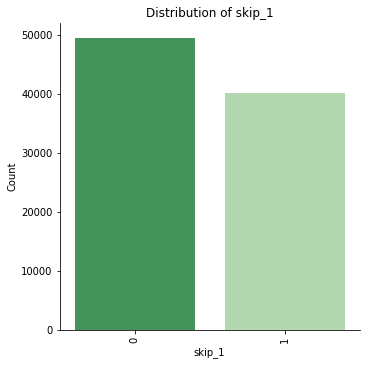

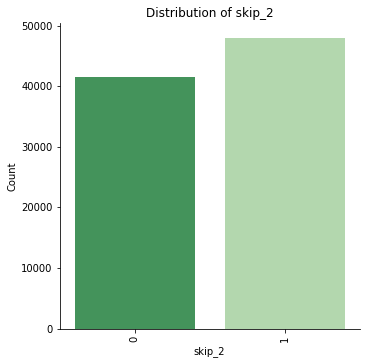

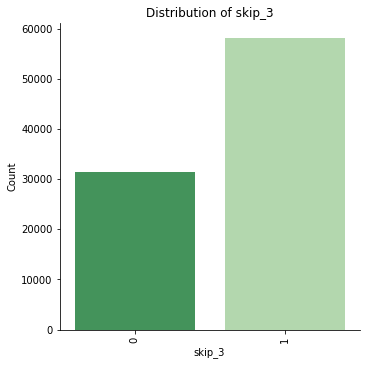

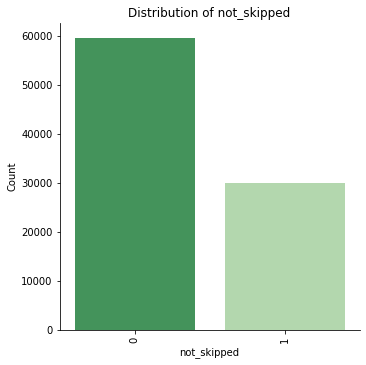

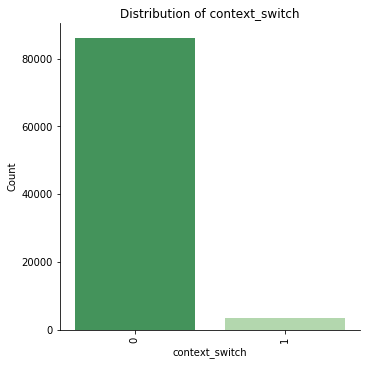

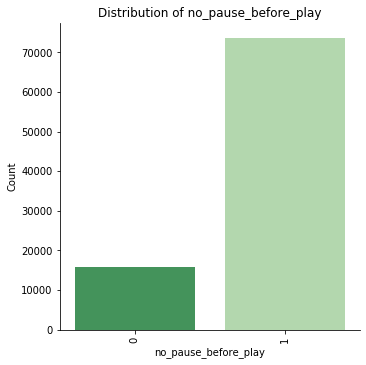

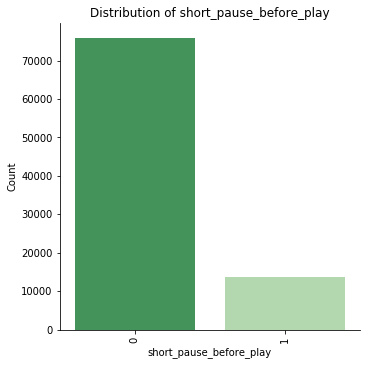

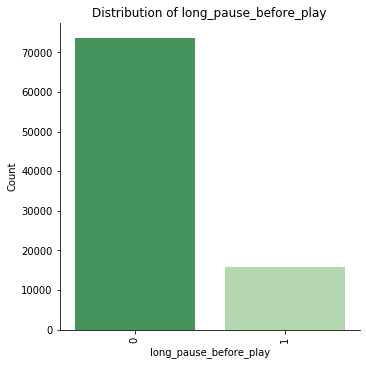

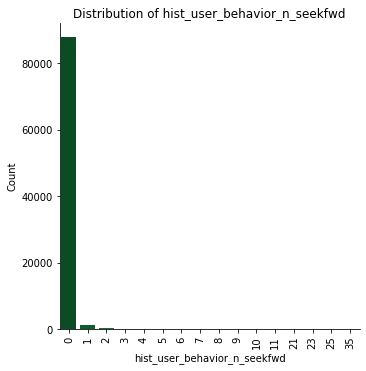

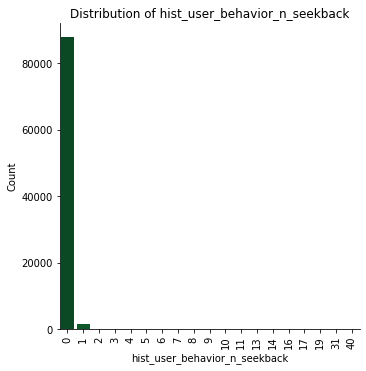

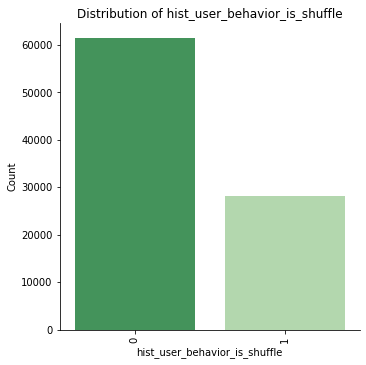

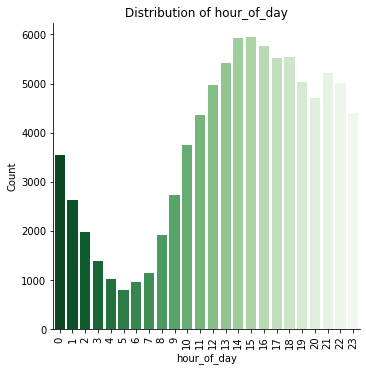

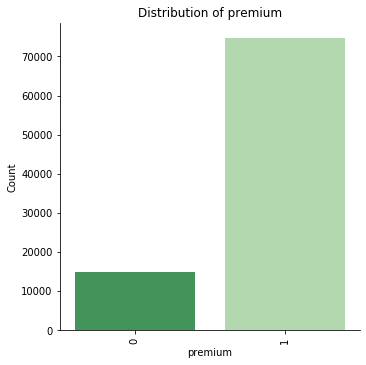

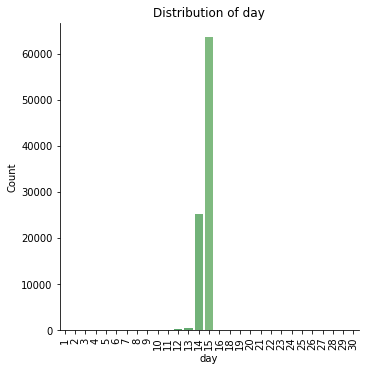

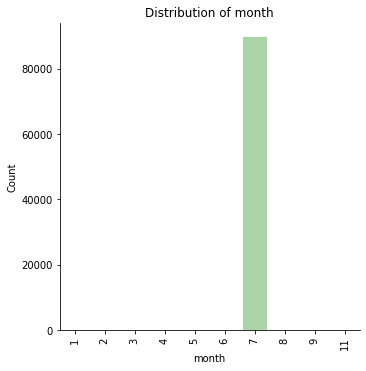

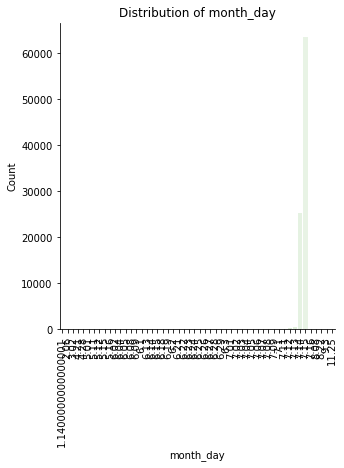

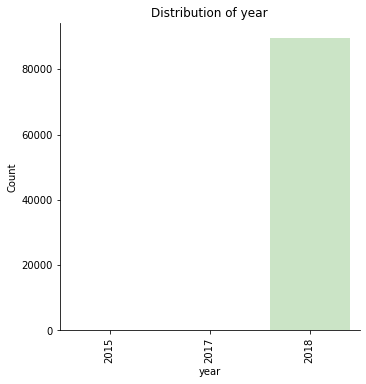

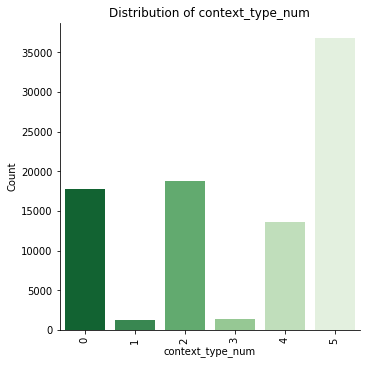

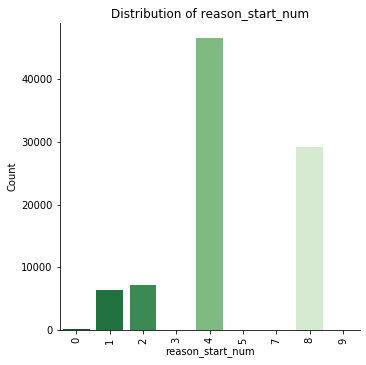

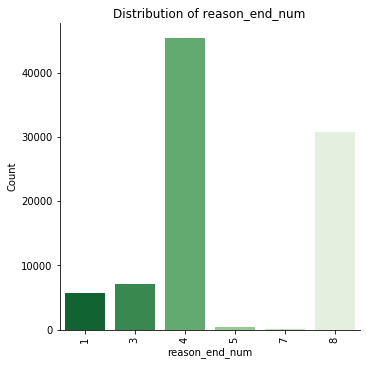

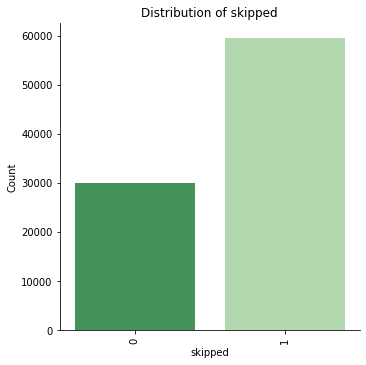

In [59]:
countplot(spotify_track20.compute(), 'vertical')

Okay let's do a bivariate analysis with 'skipped' and the other variables in the dataset, for each of the 3 slices

In [60]:
# Show a barplot for all columns in eda dataset with the given y (passed in as string)

def barplot(df, rotation, y): 
    for col in df:
        plt.figure(figsize=(15,10))
        sns.barplot(x=col, y=y, palette='Greens_r', data=df)
        plt.title('Relationship between {} & {}'.format(col, y))
        plt.xlabel('{}'.format(col))
        plt.ylabel('{}'.format(y))
        plt.xticks(rotation=rotation)
        plt.show()

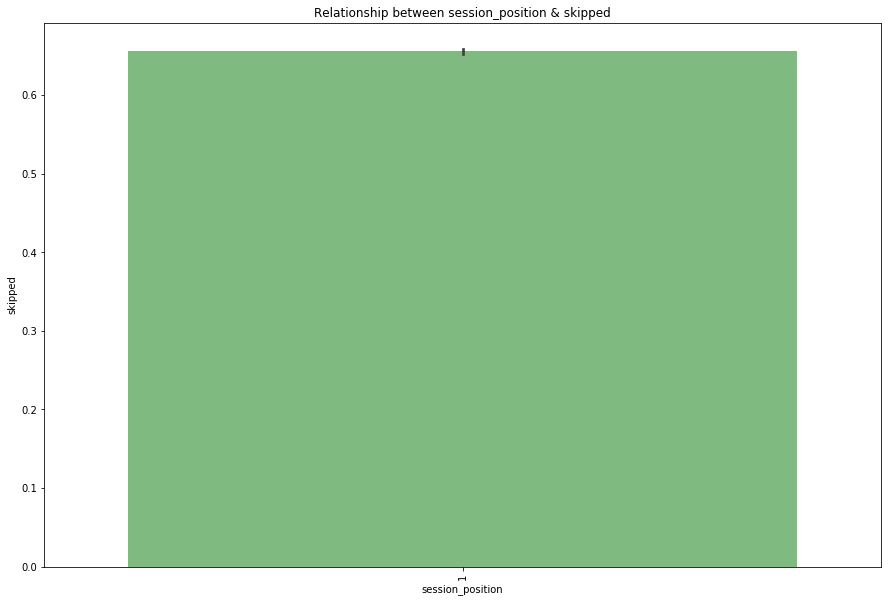

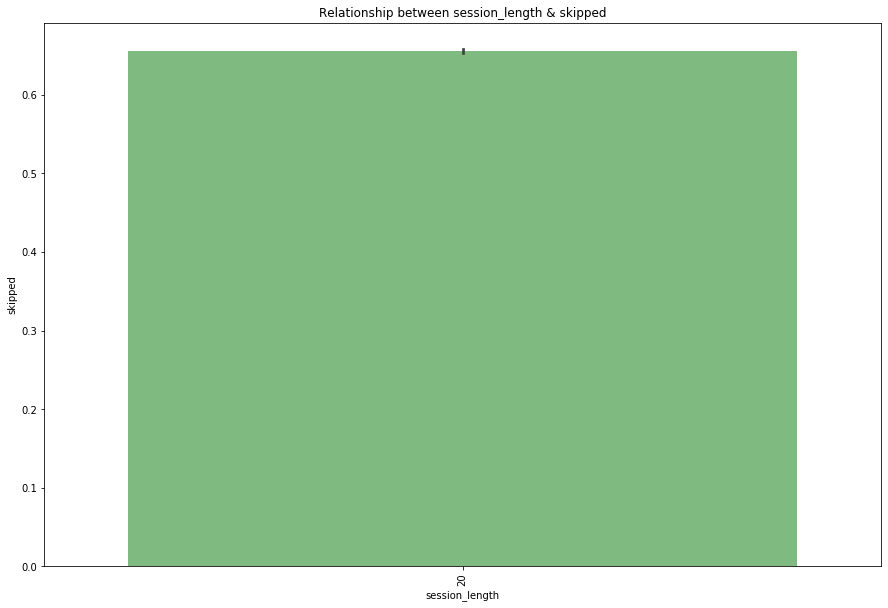

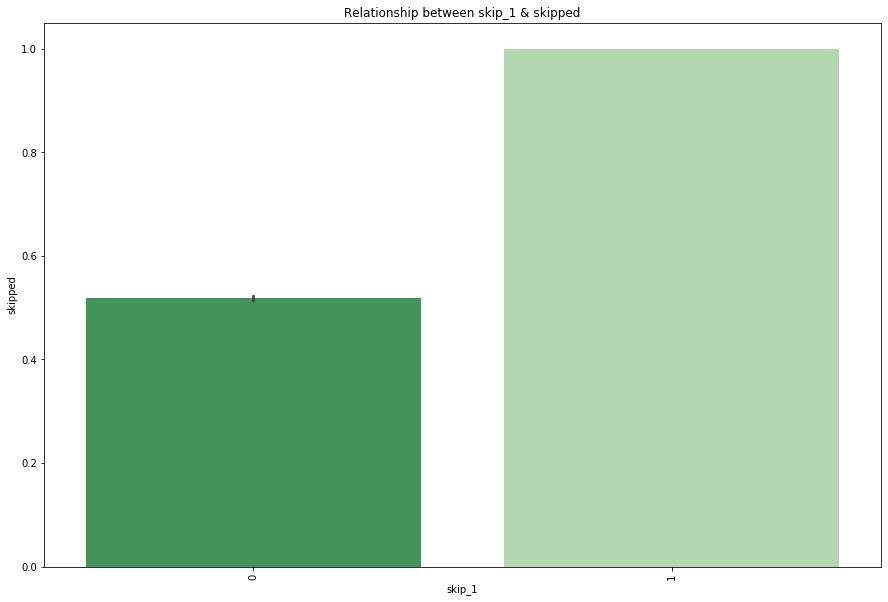

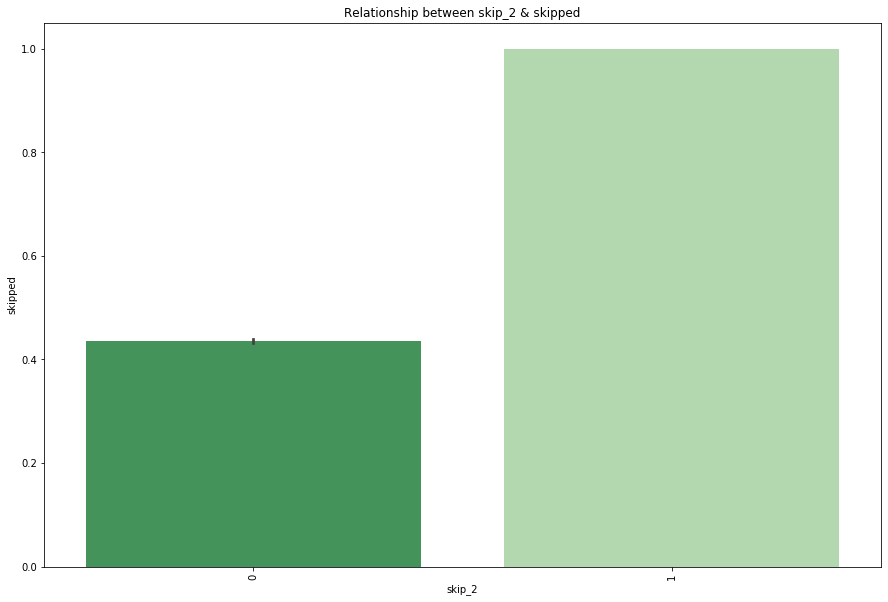

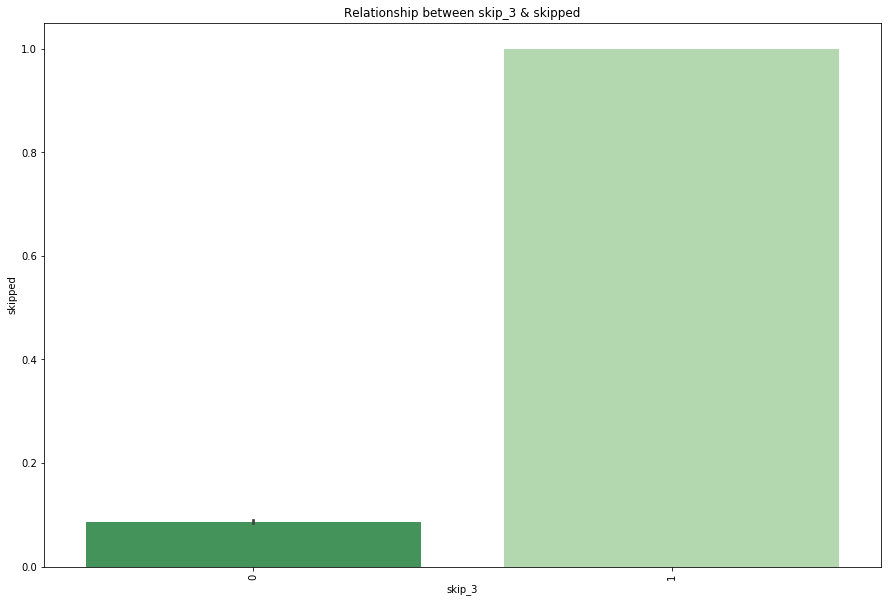

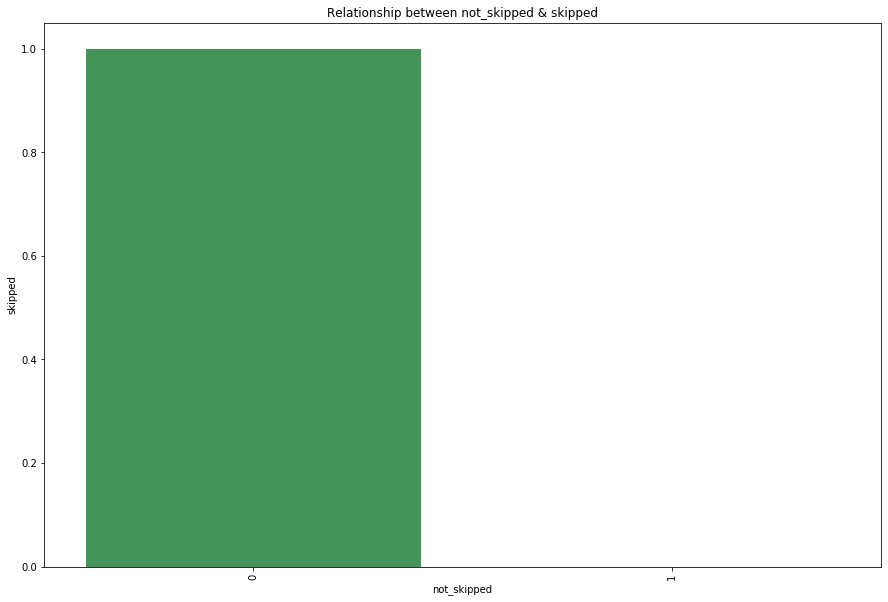

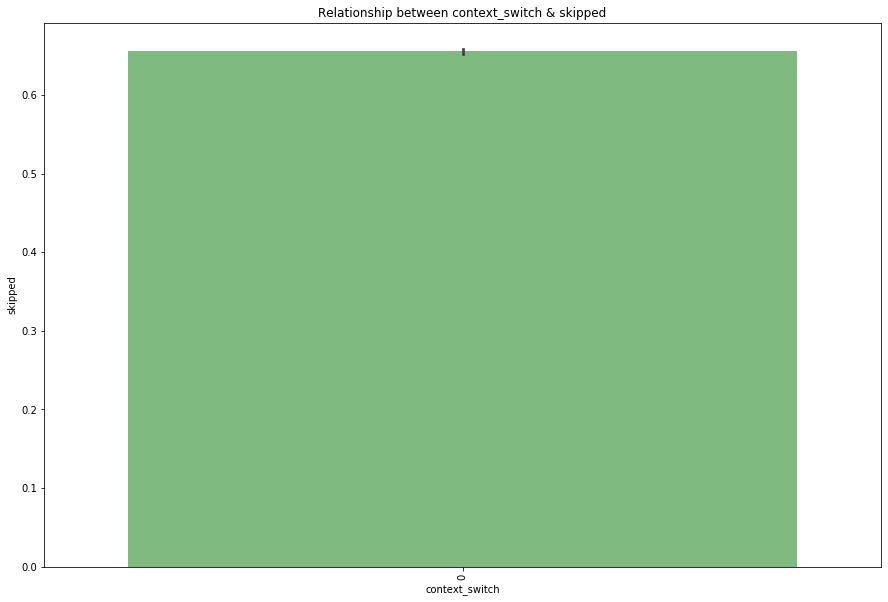

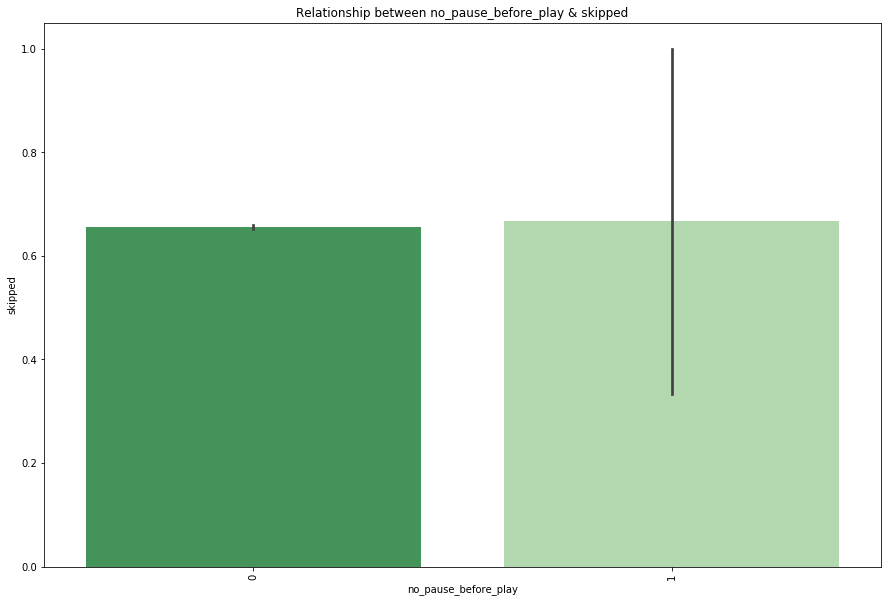

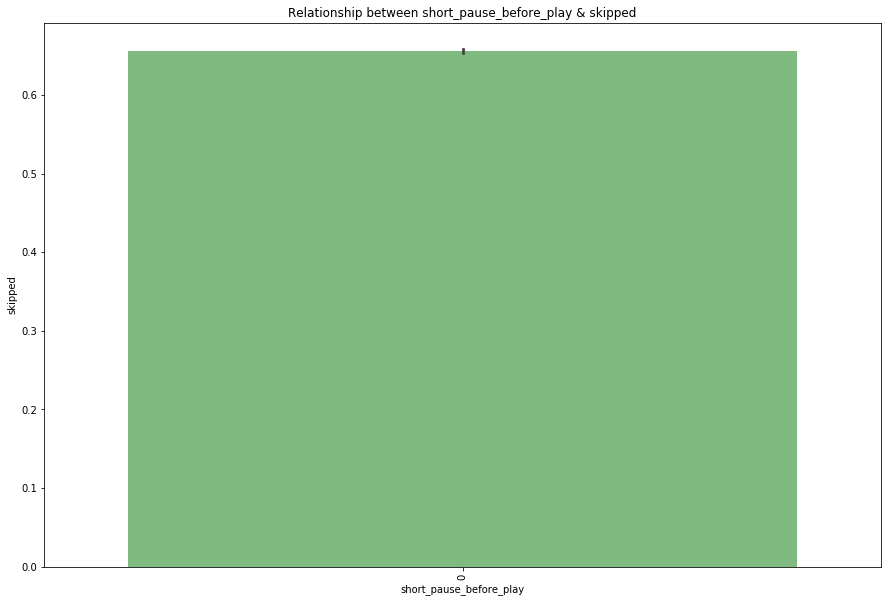

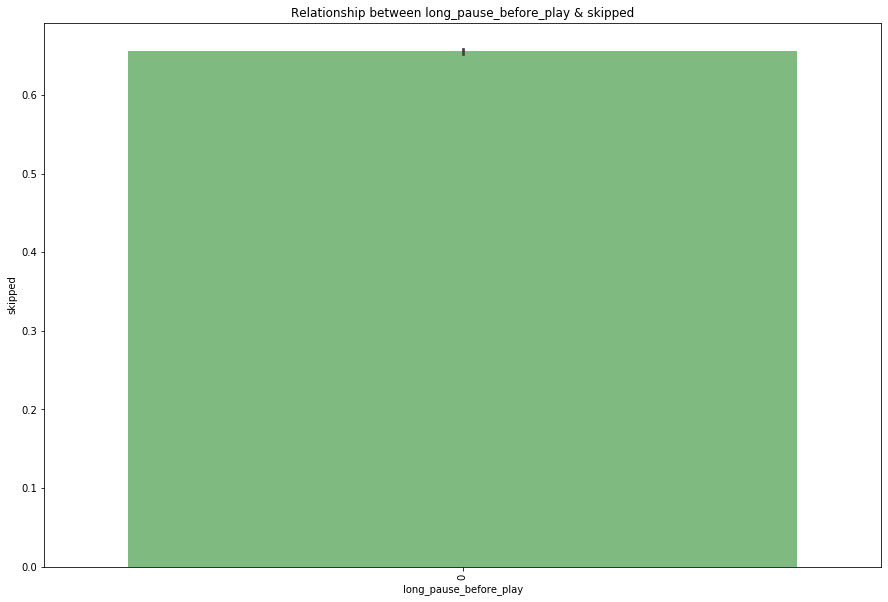

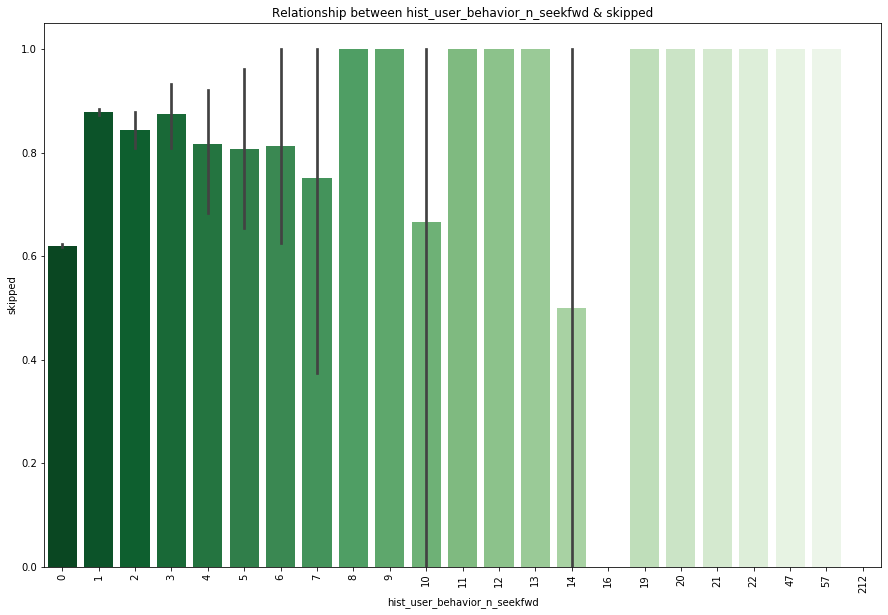

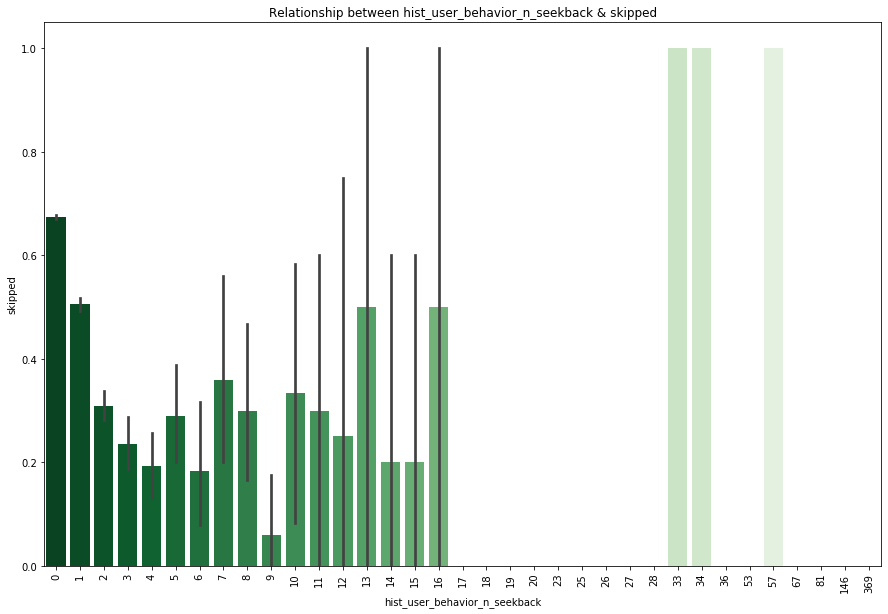

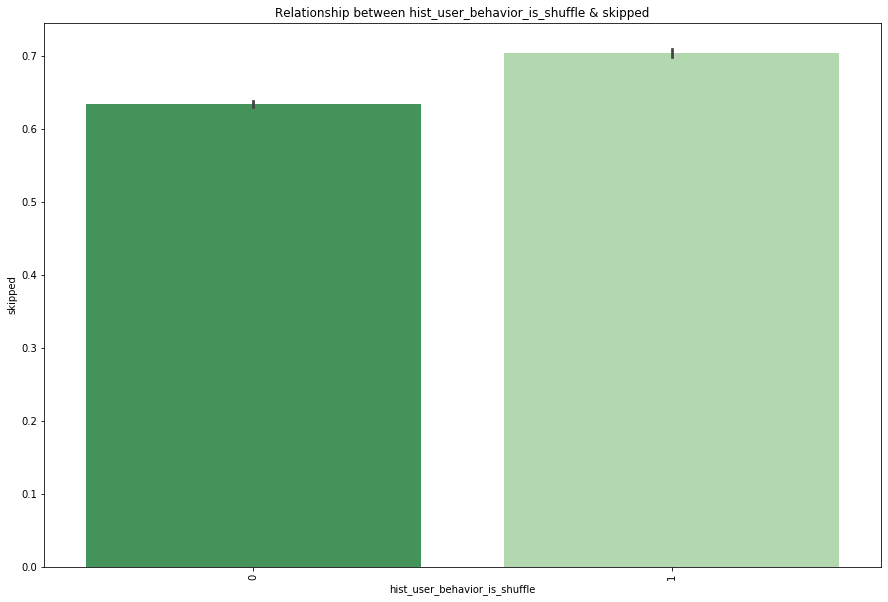

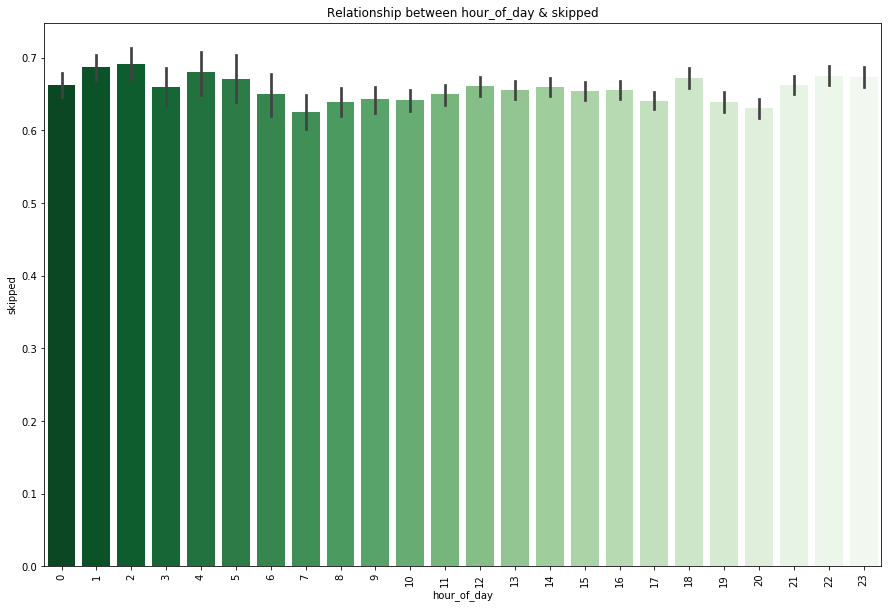

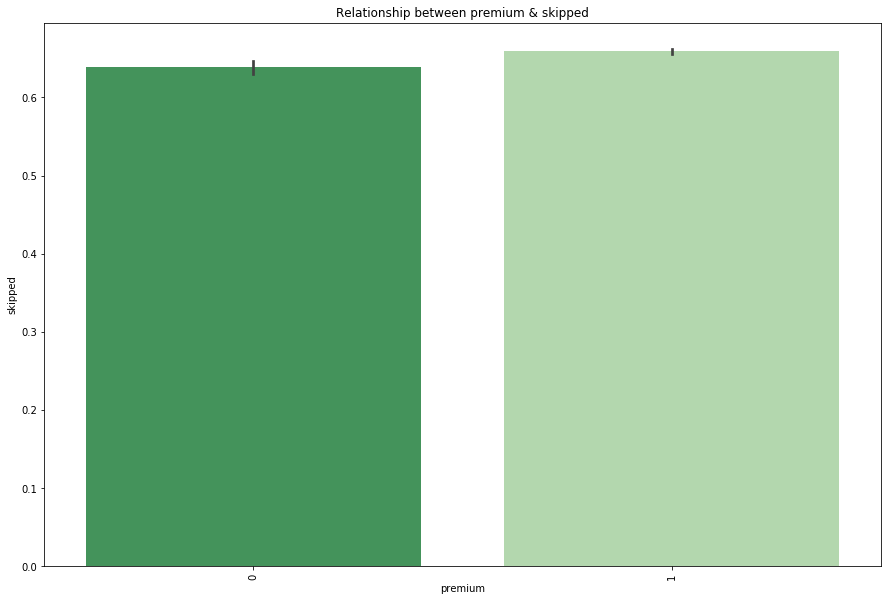

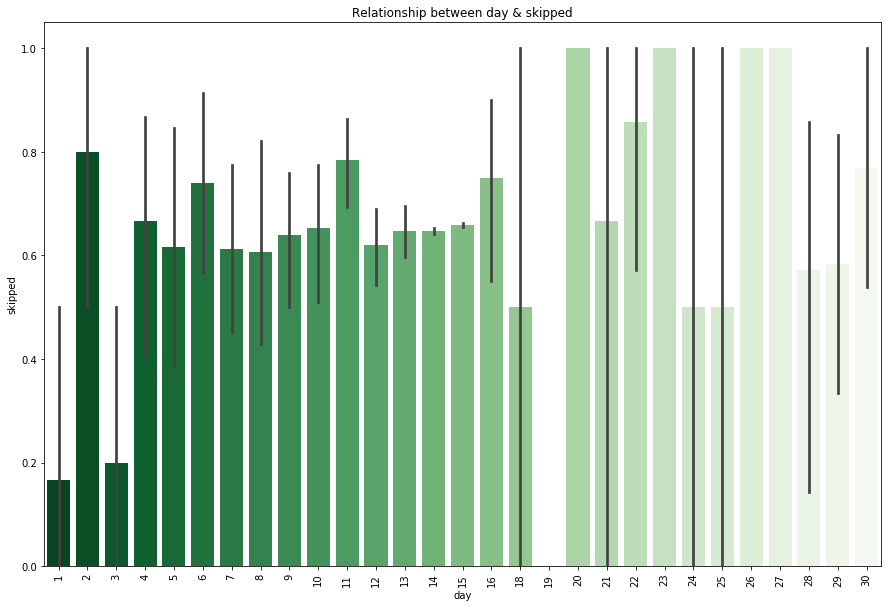

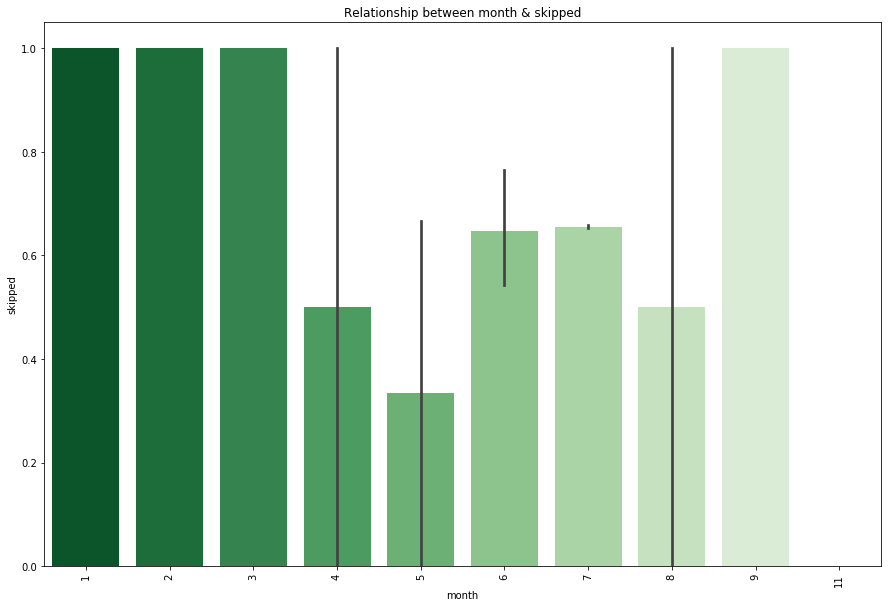

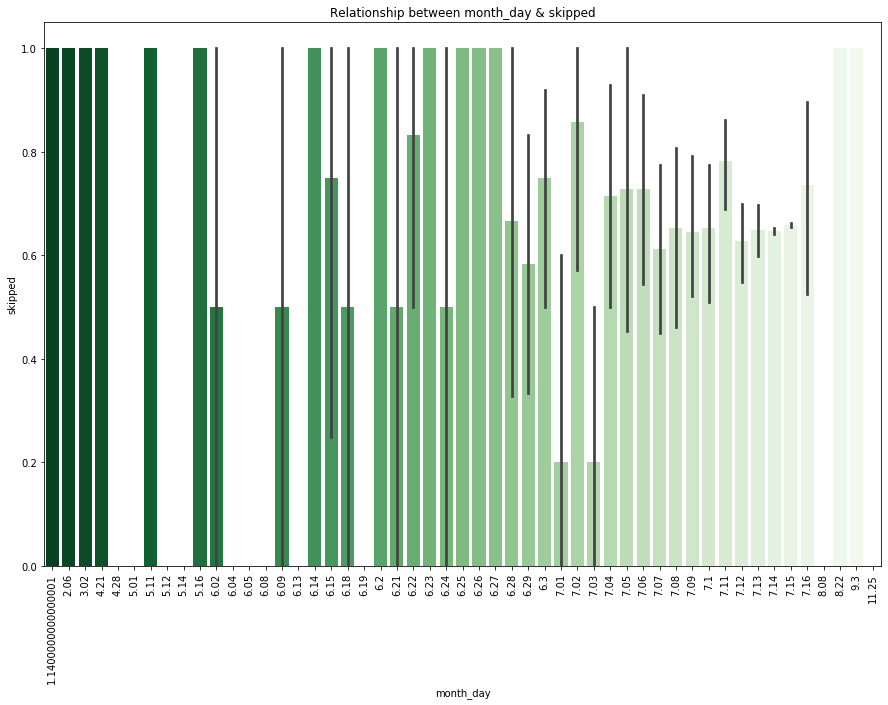

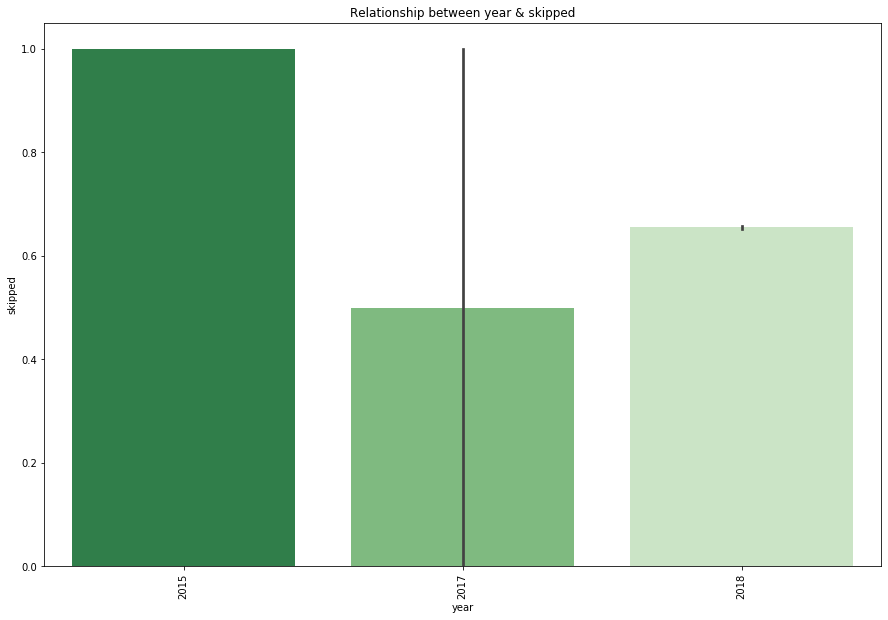

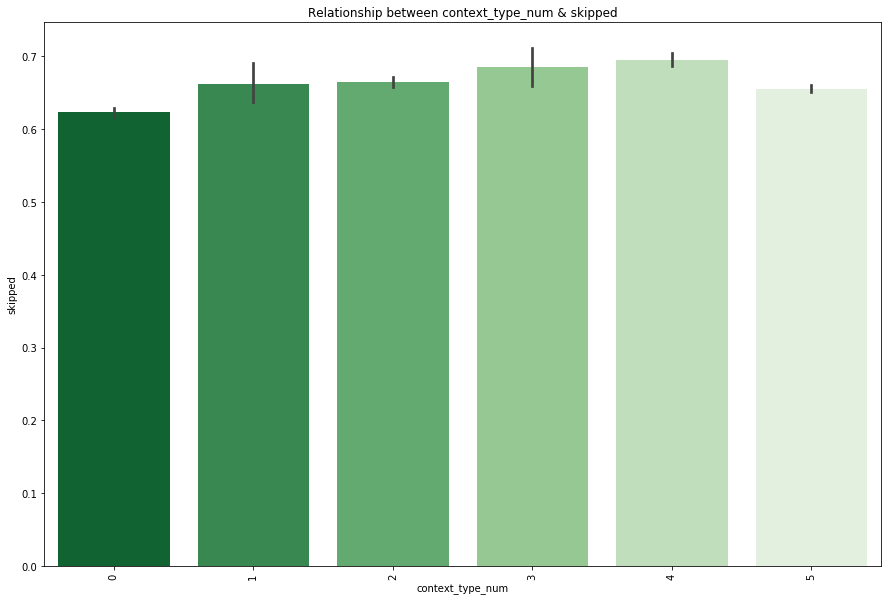

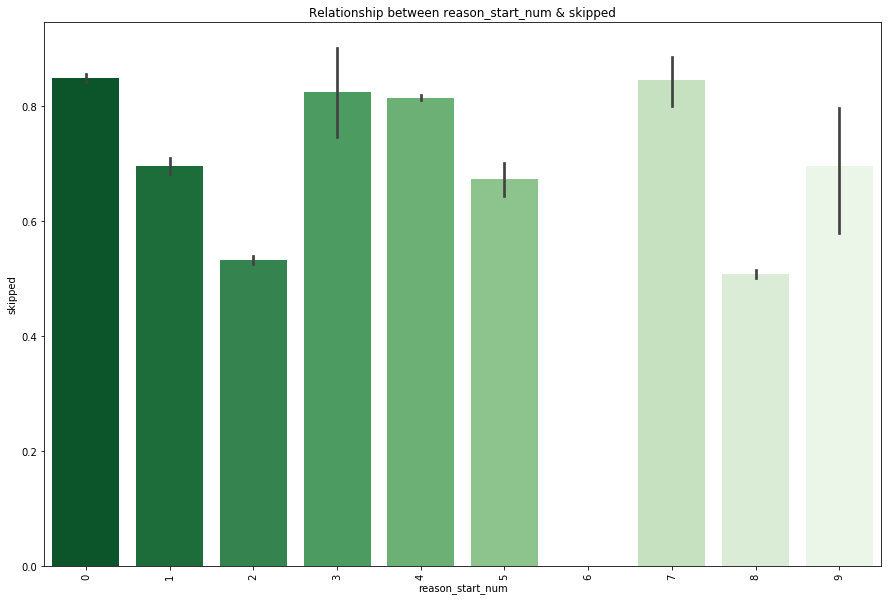

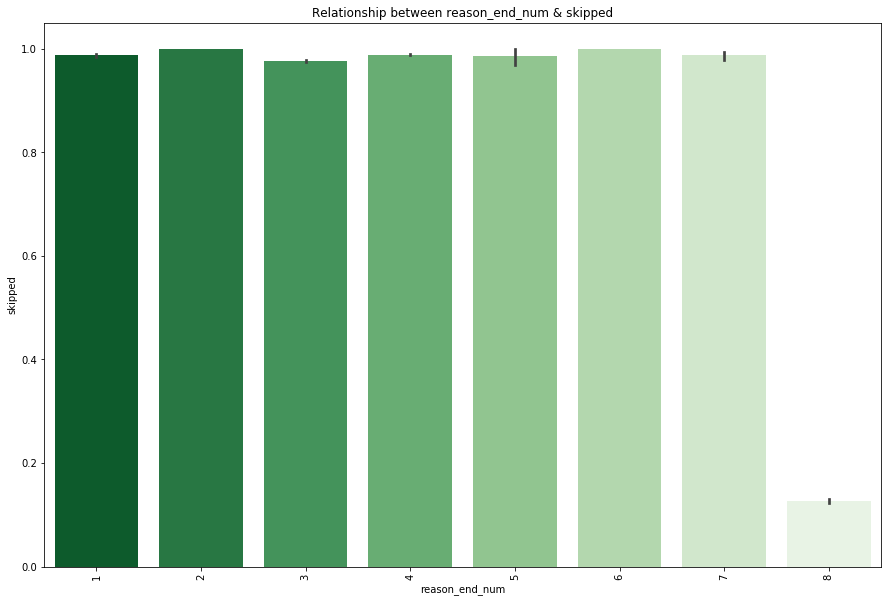

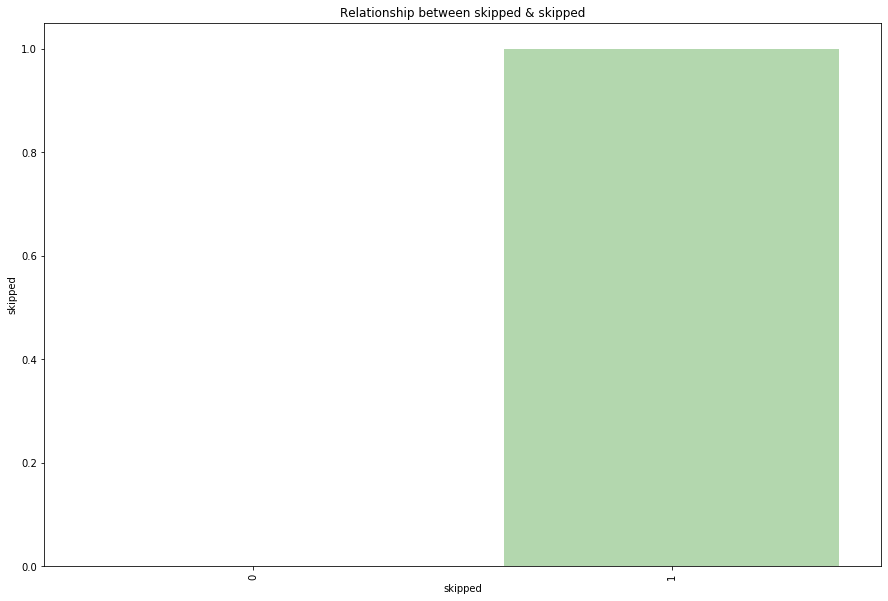

In [61]:
barplot(spotify_track1.compute(), 'vertical', 'skipped')

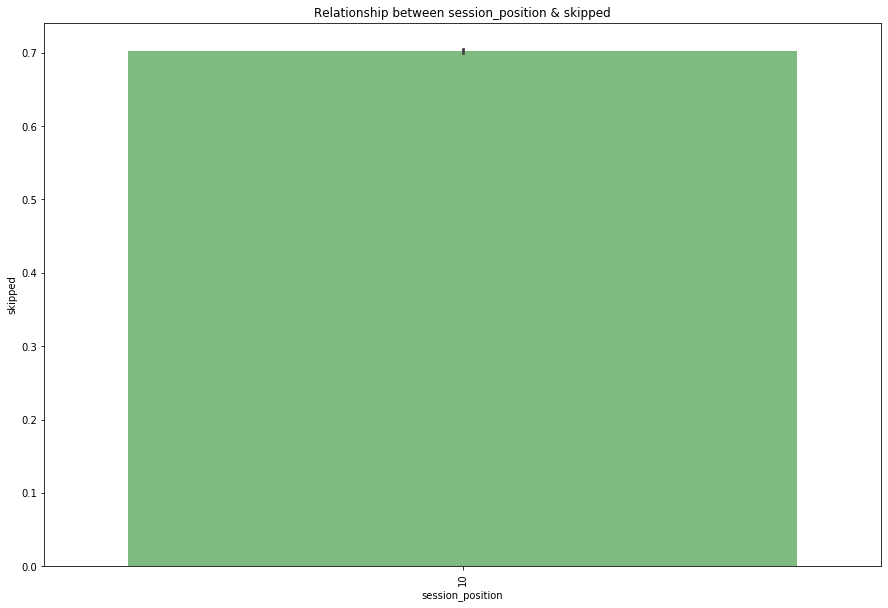

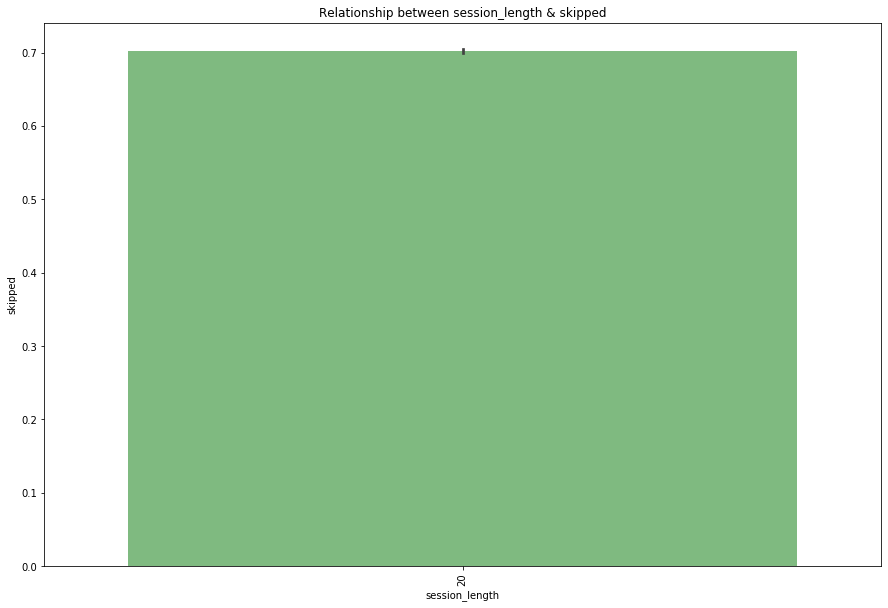

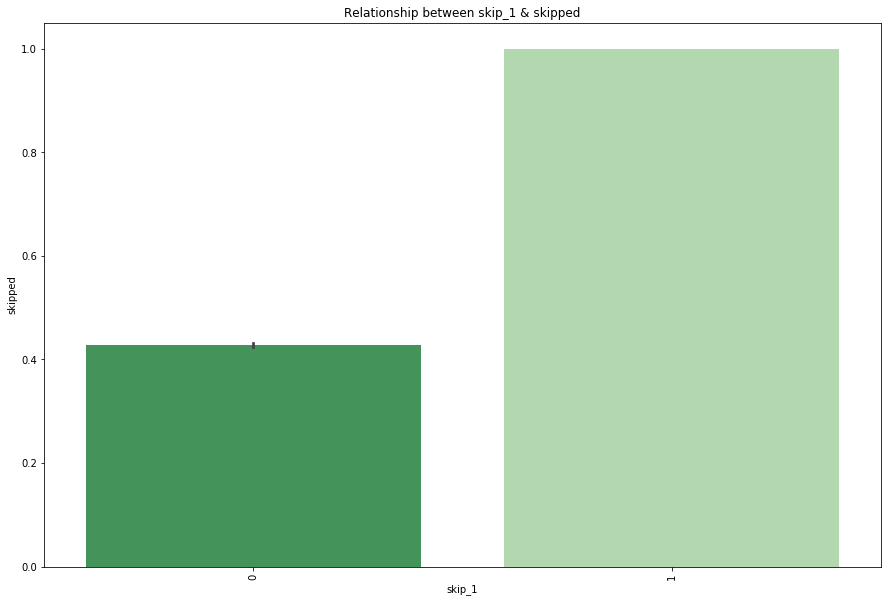

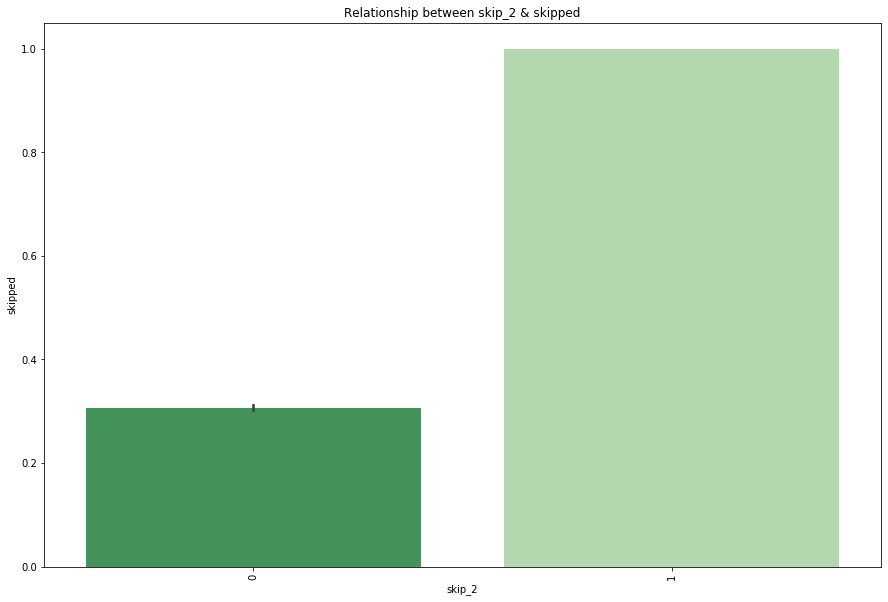

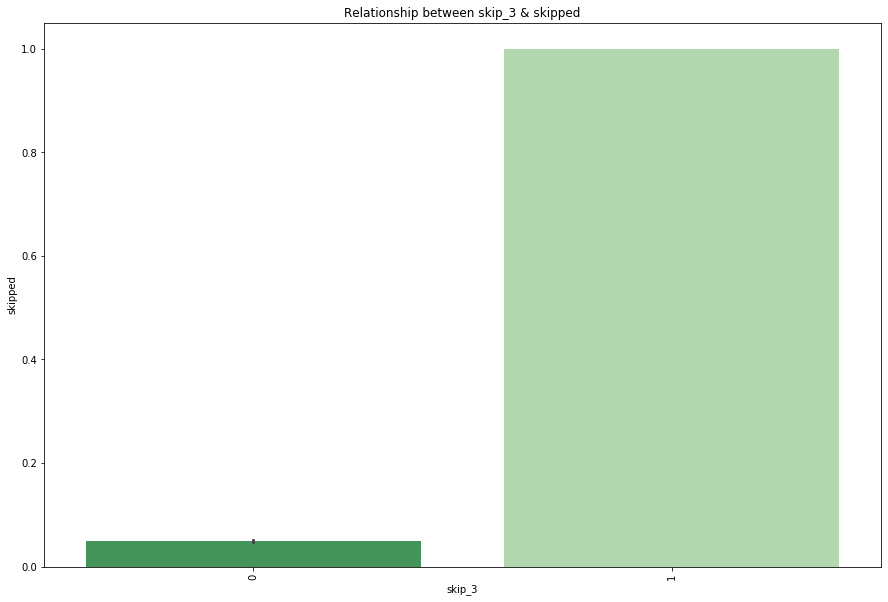

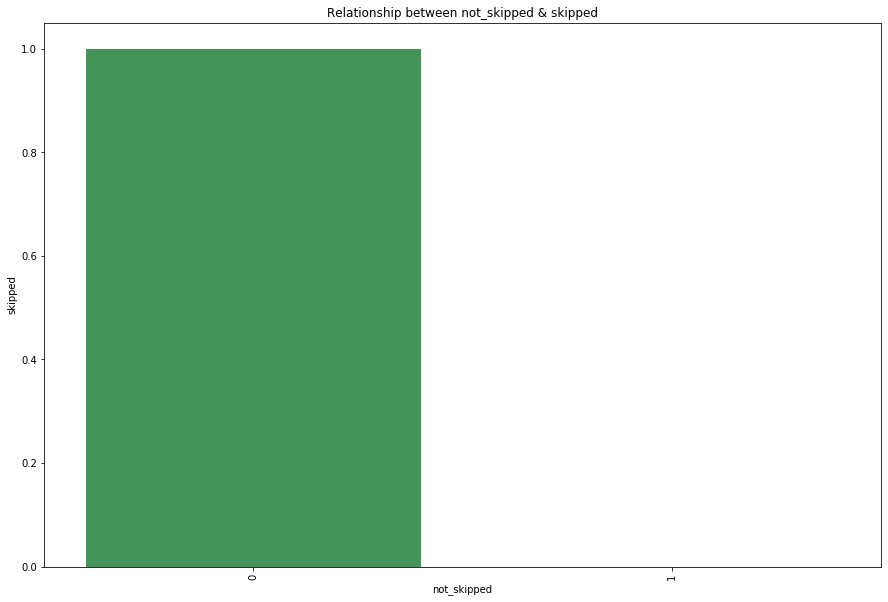

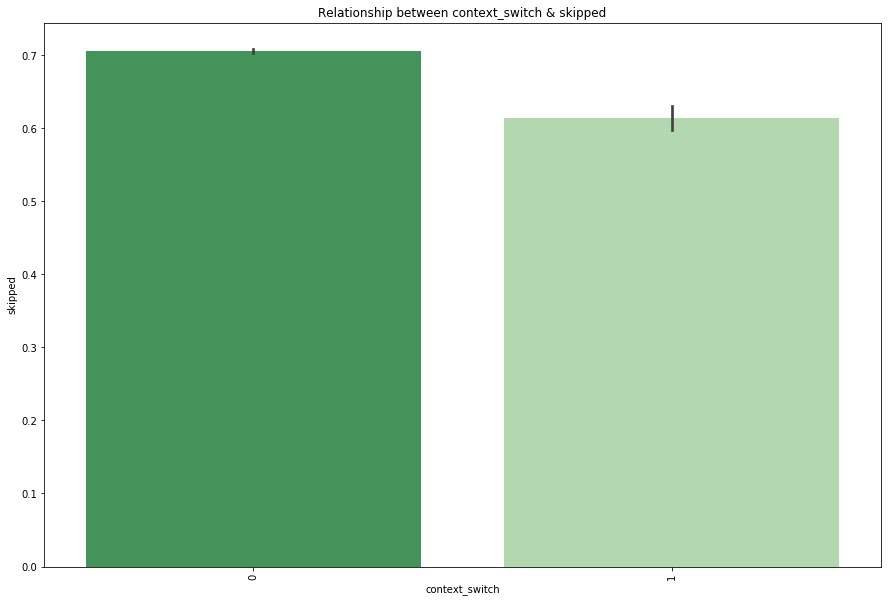

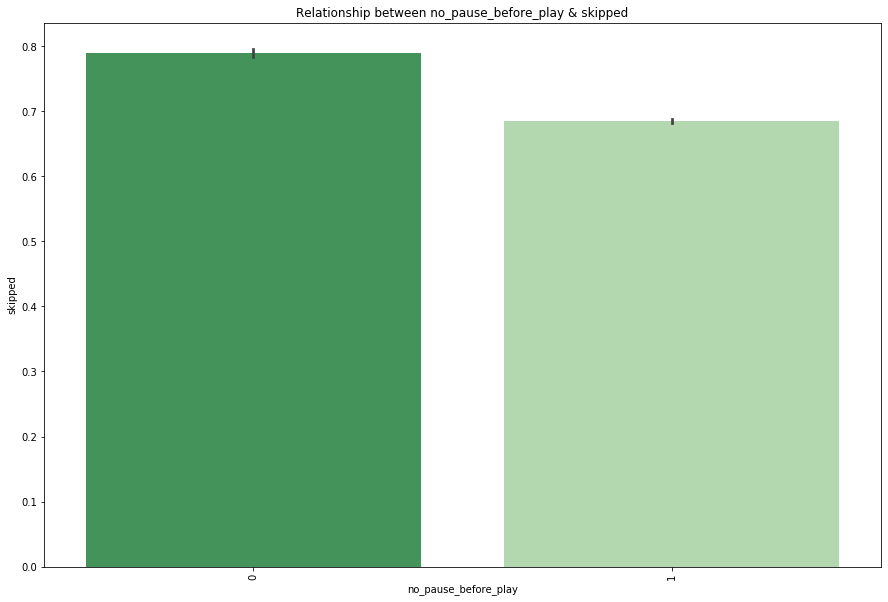

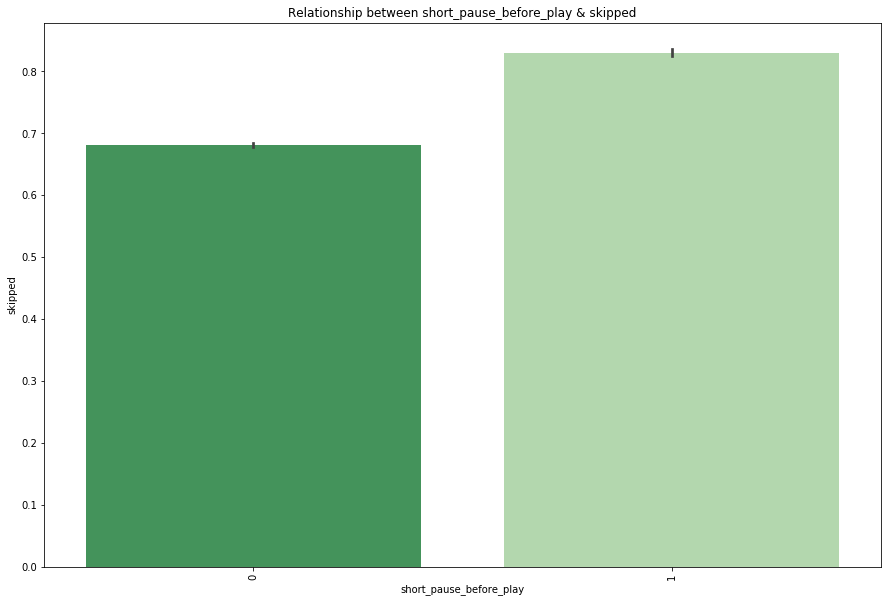

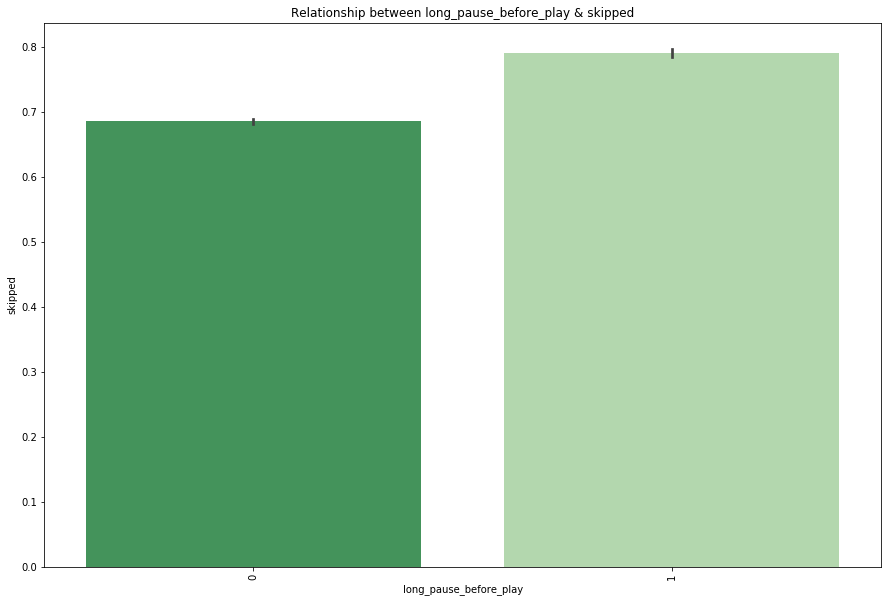

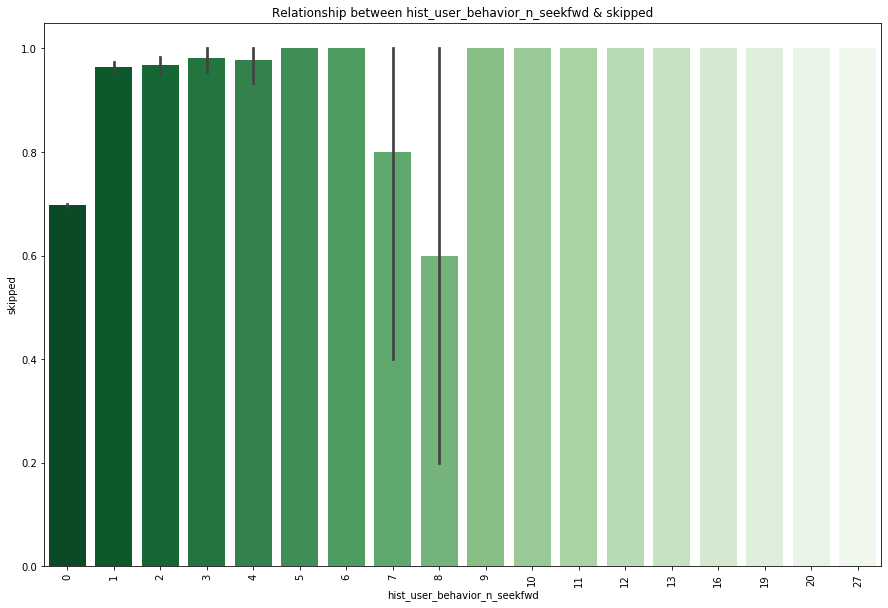

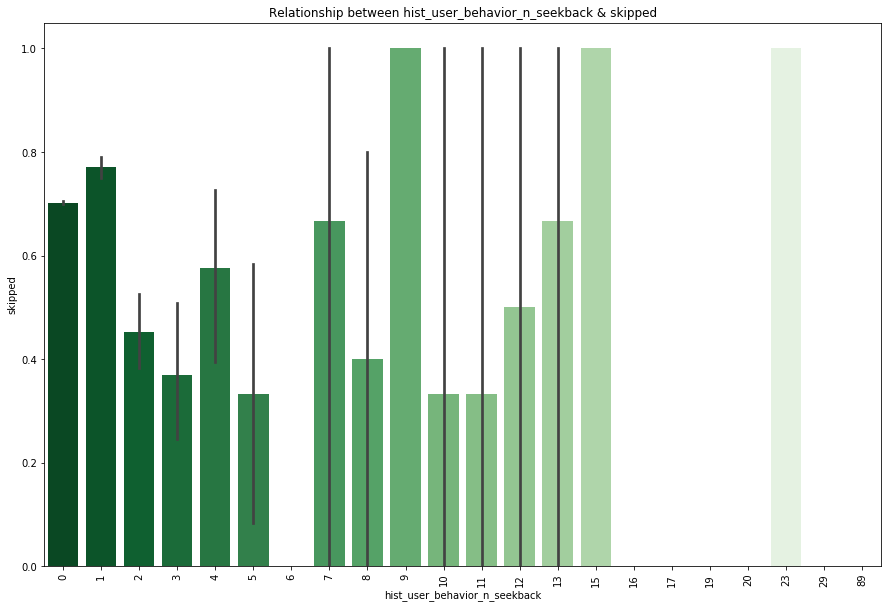

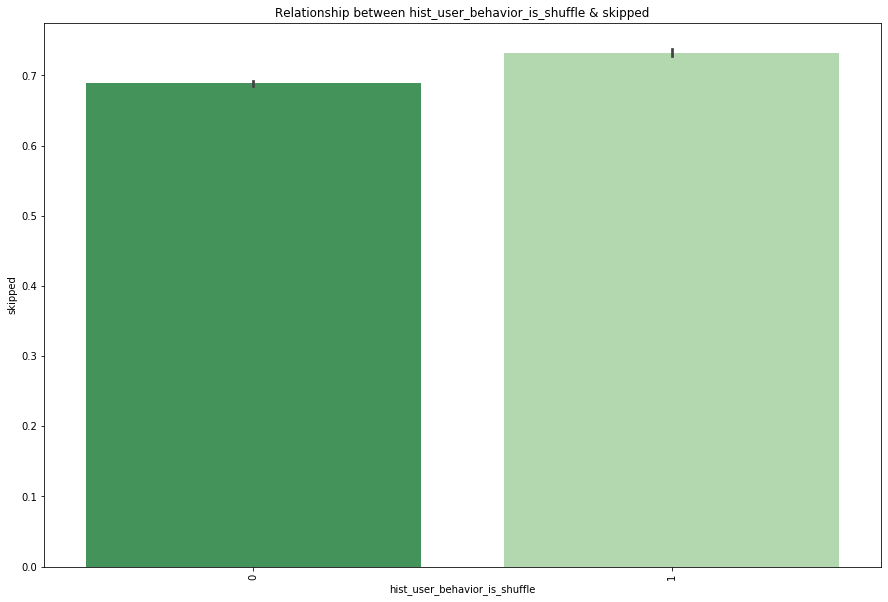

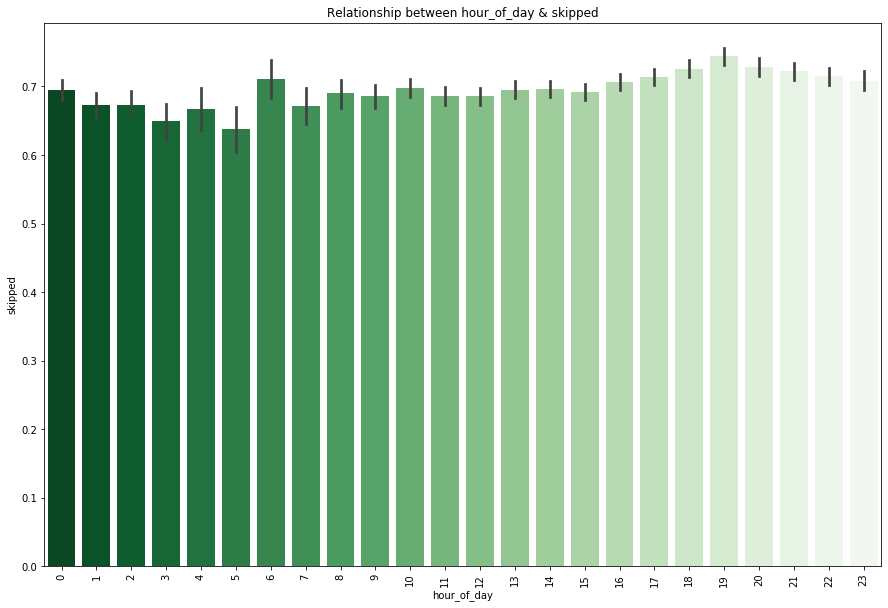

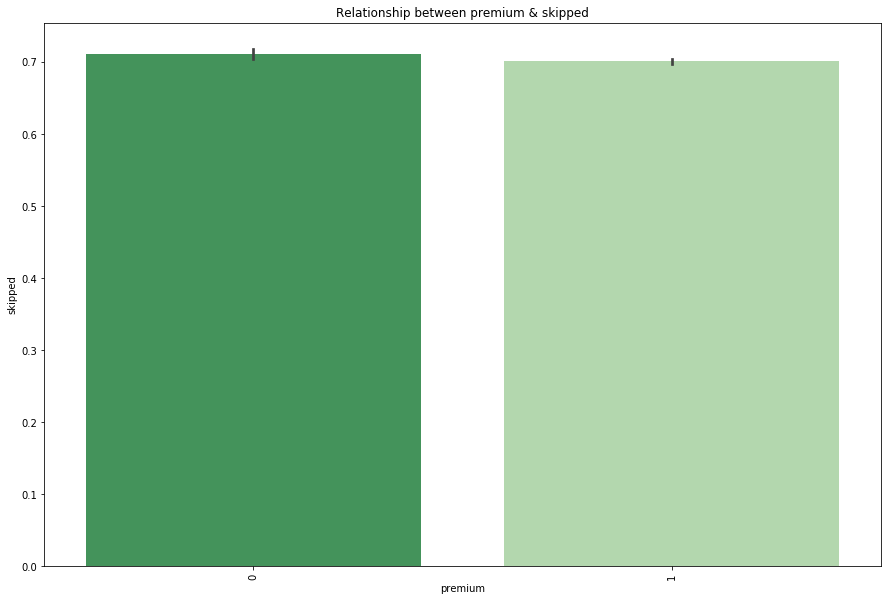

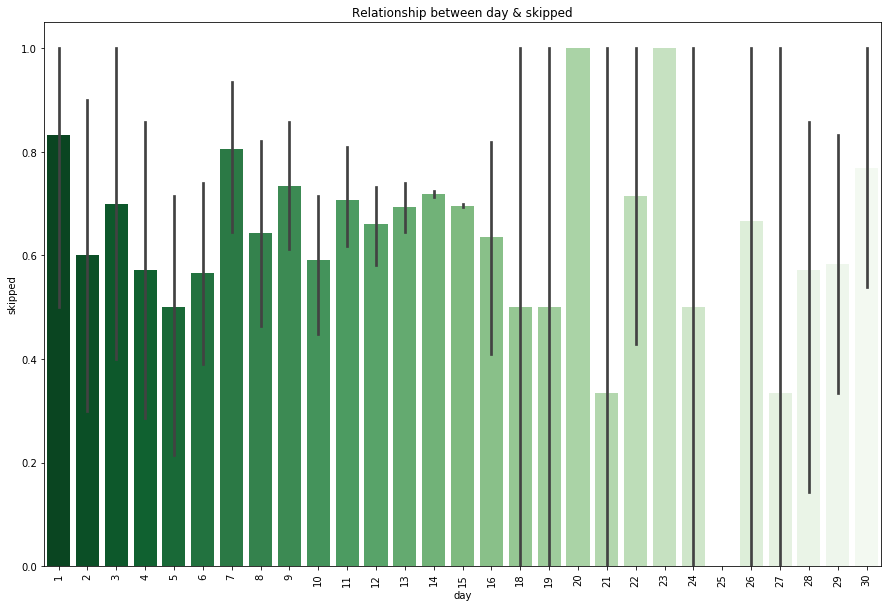

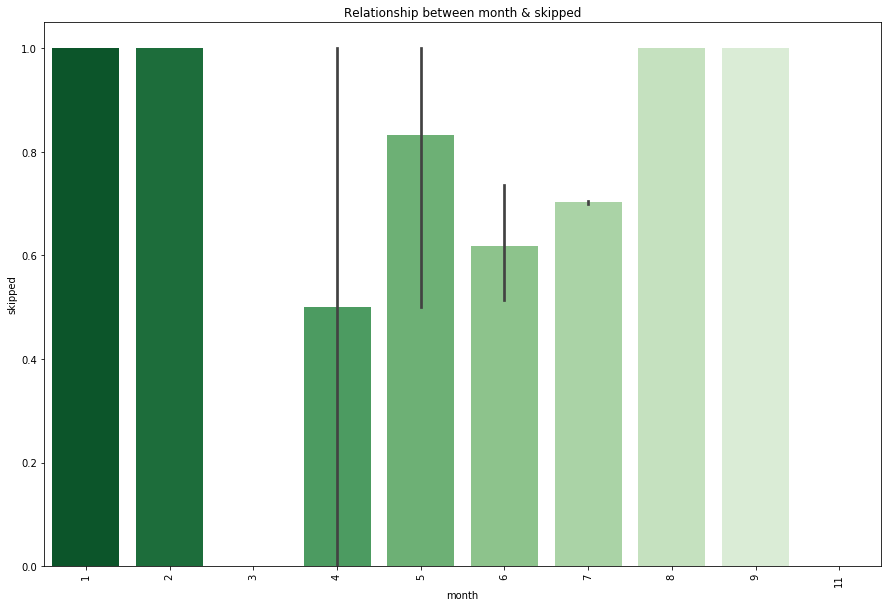

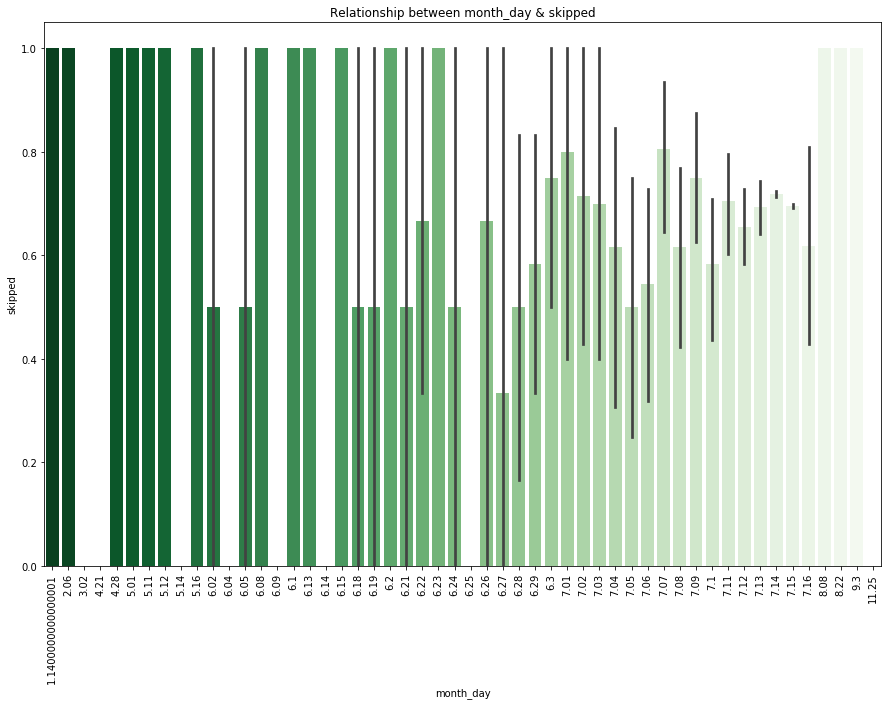

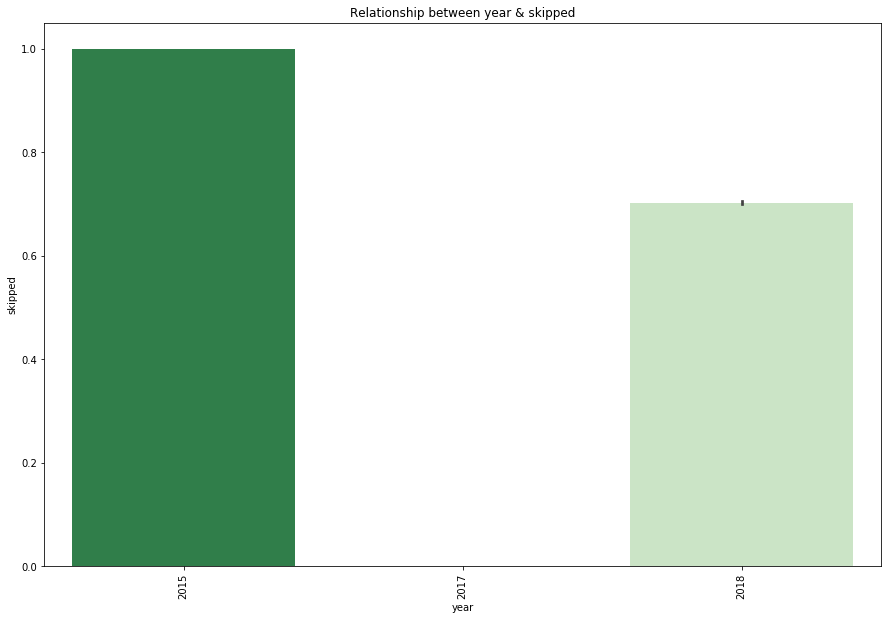

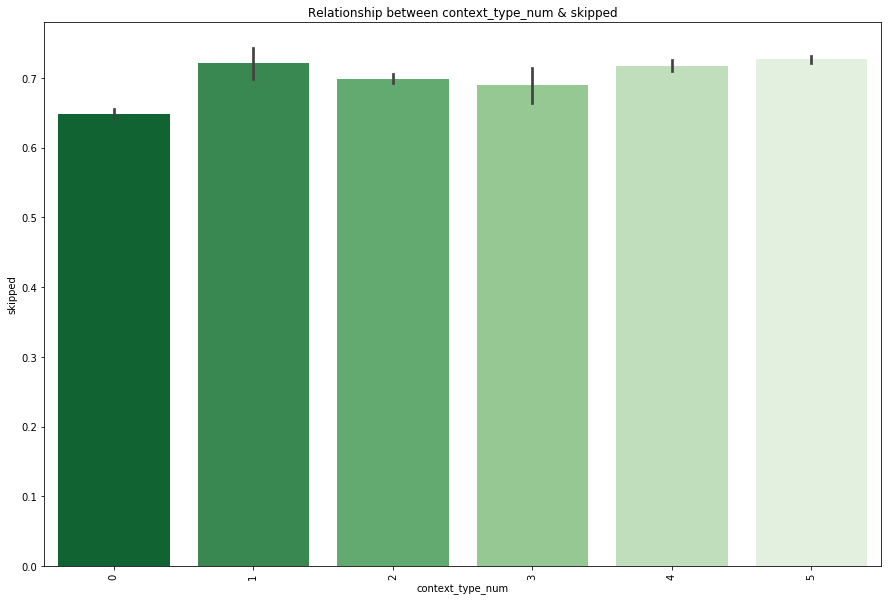

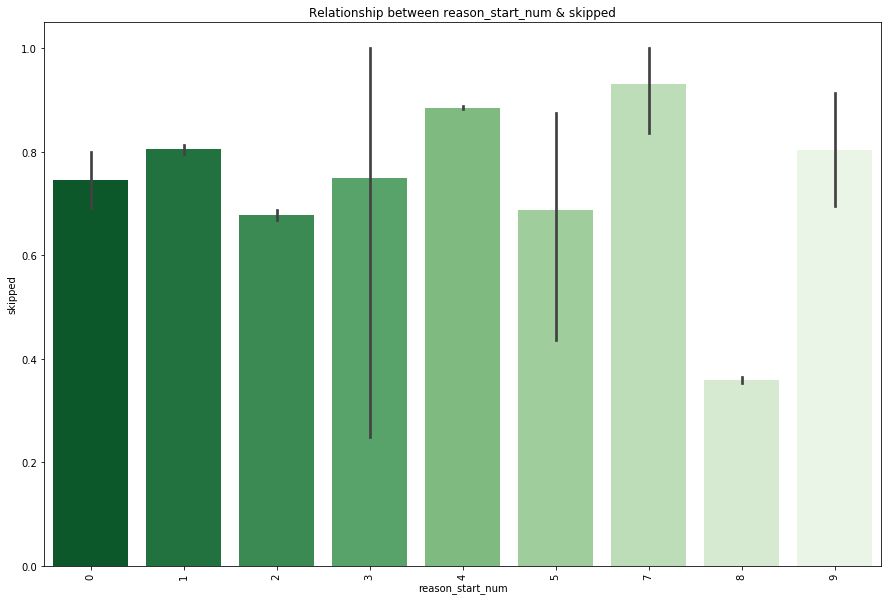

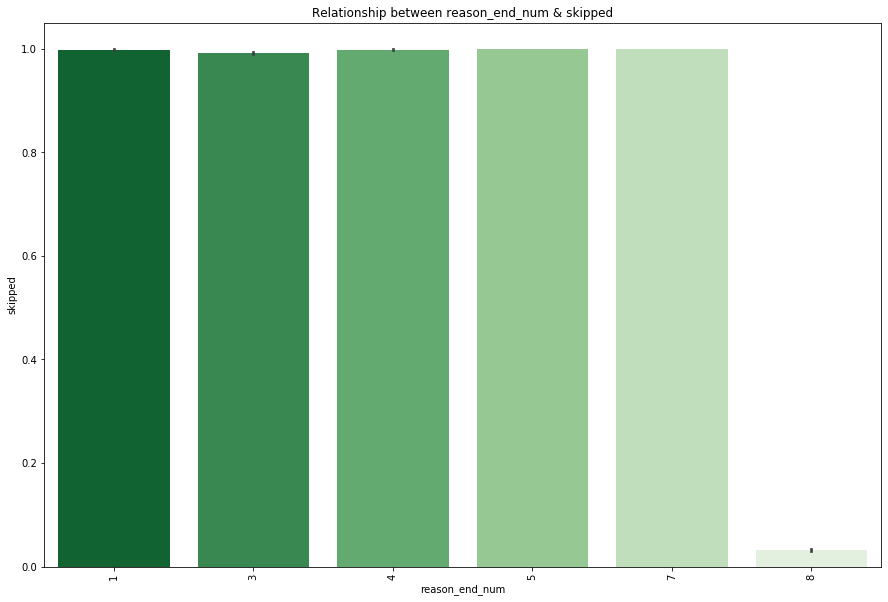

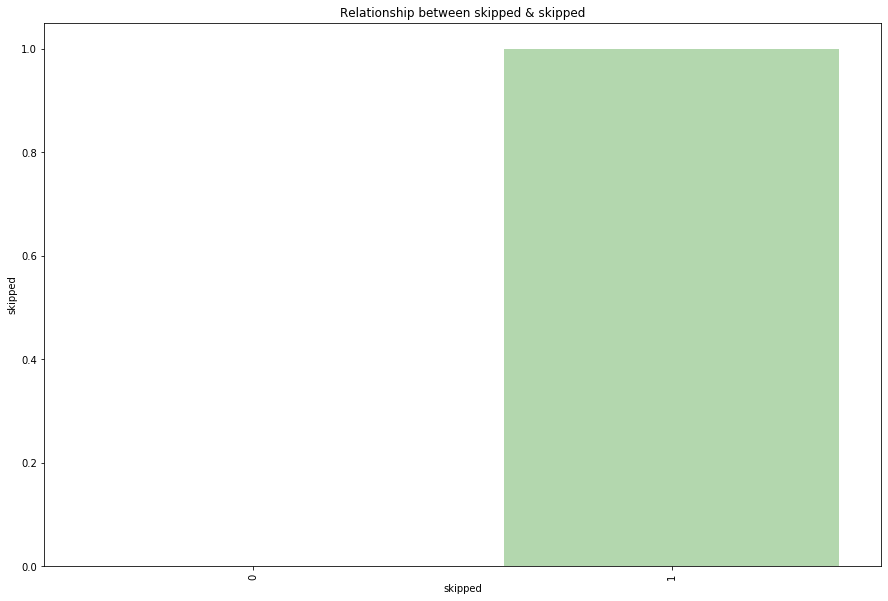

In [62]:
barplot(spotify_track10.compute(), 'vertical', 'skipped')

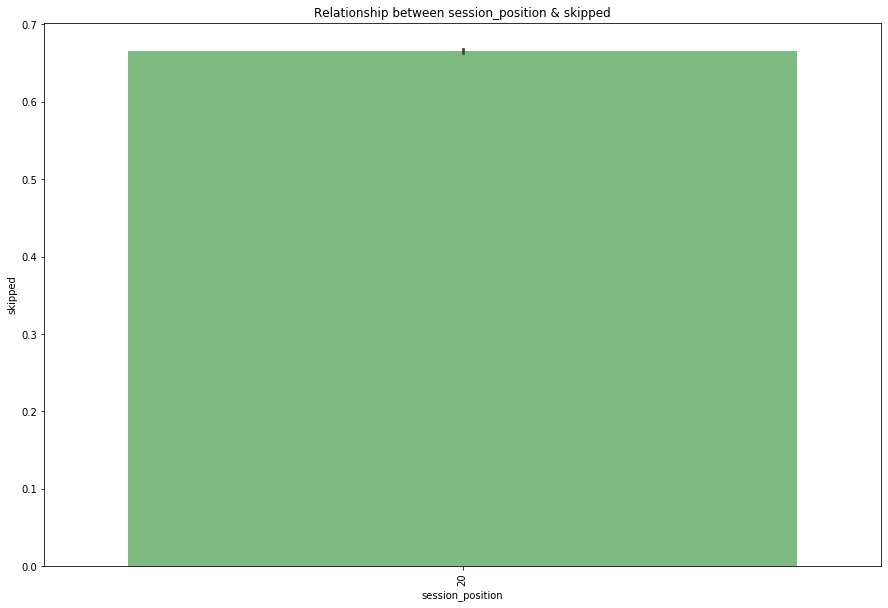

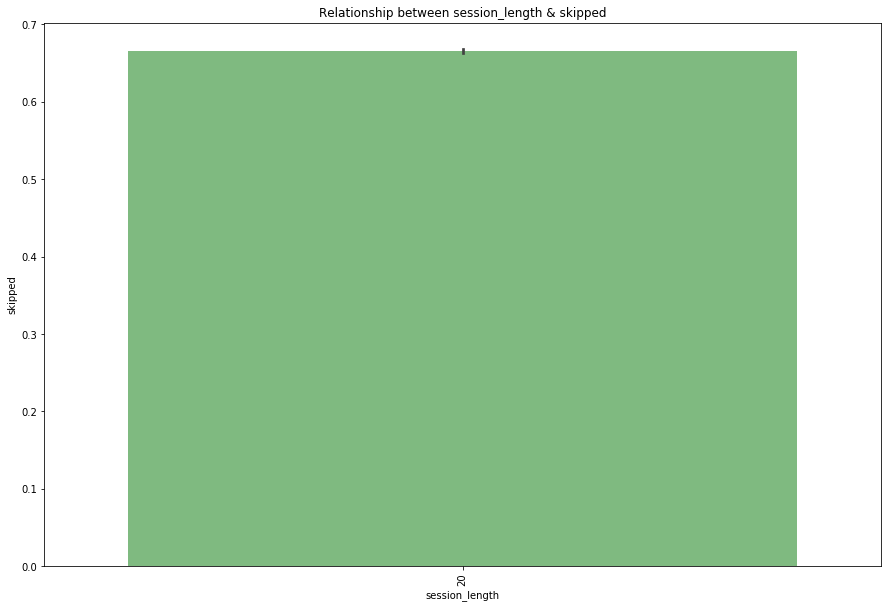

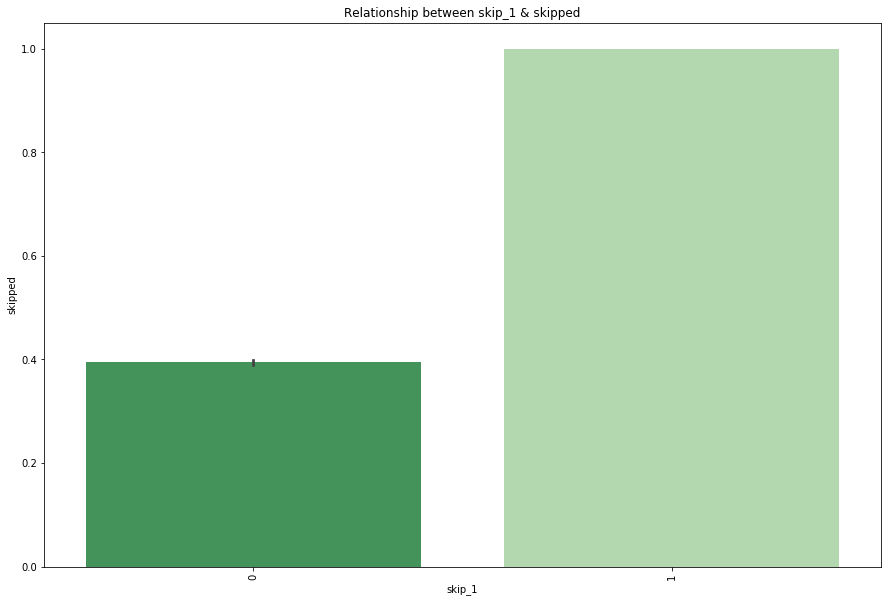

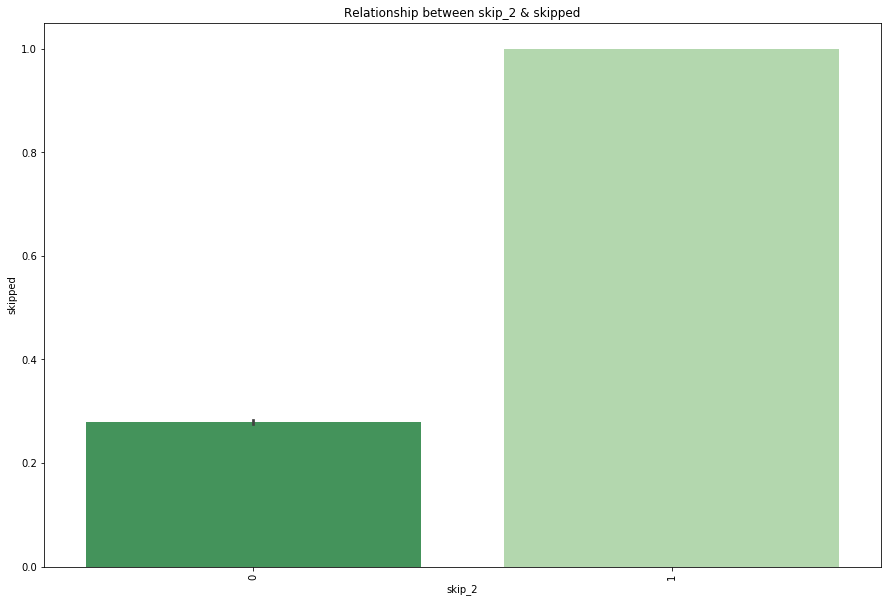

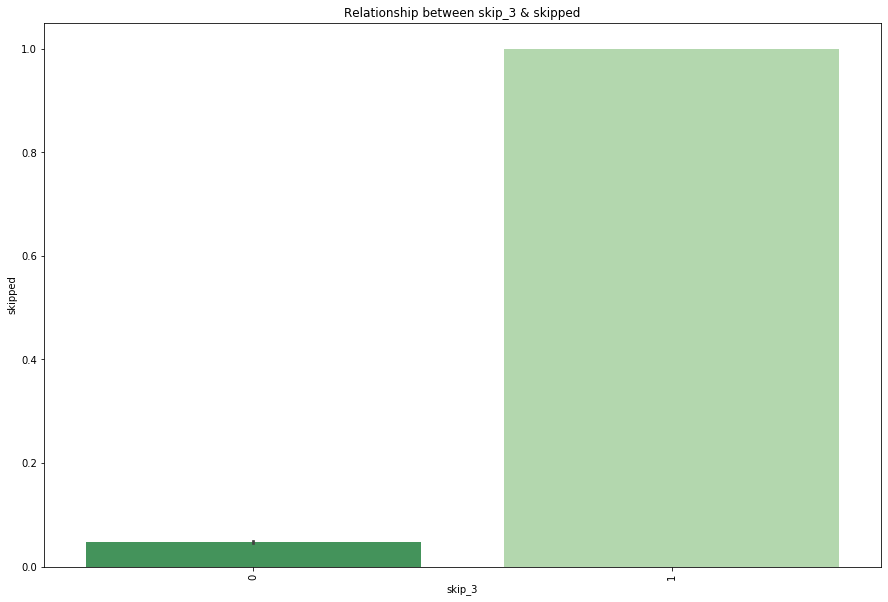

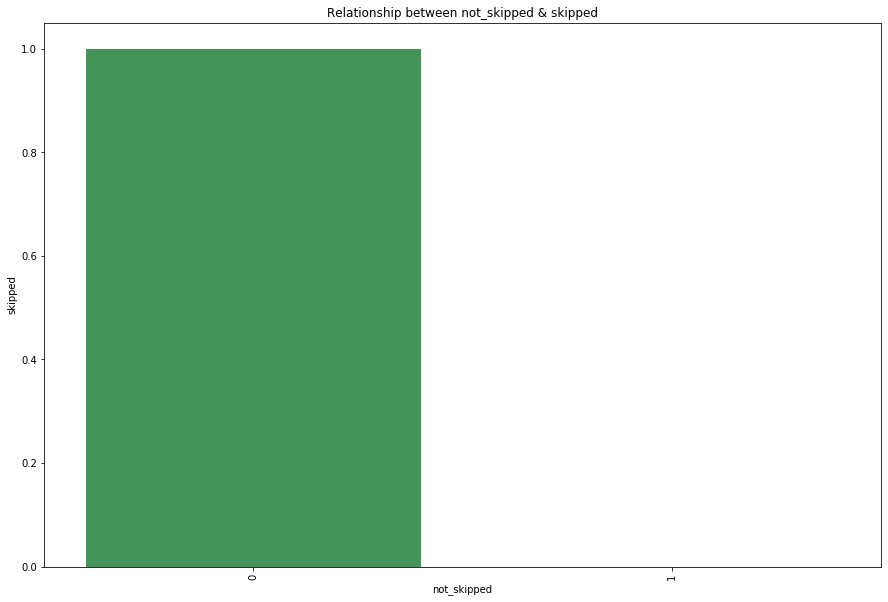

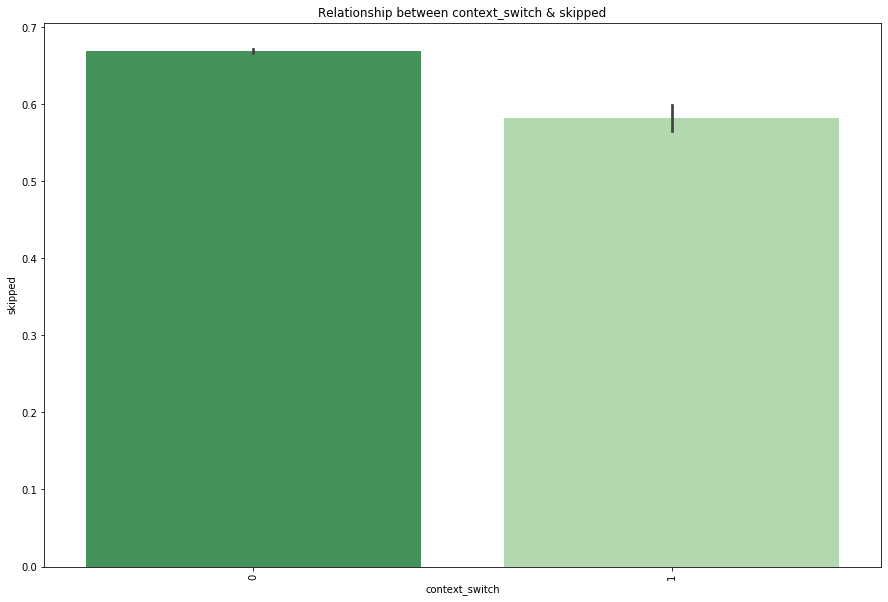

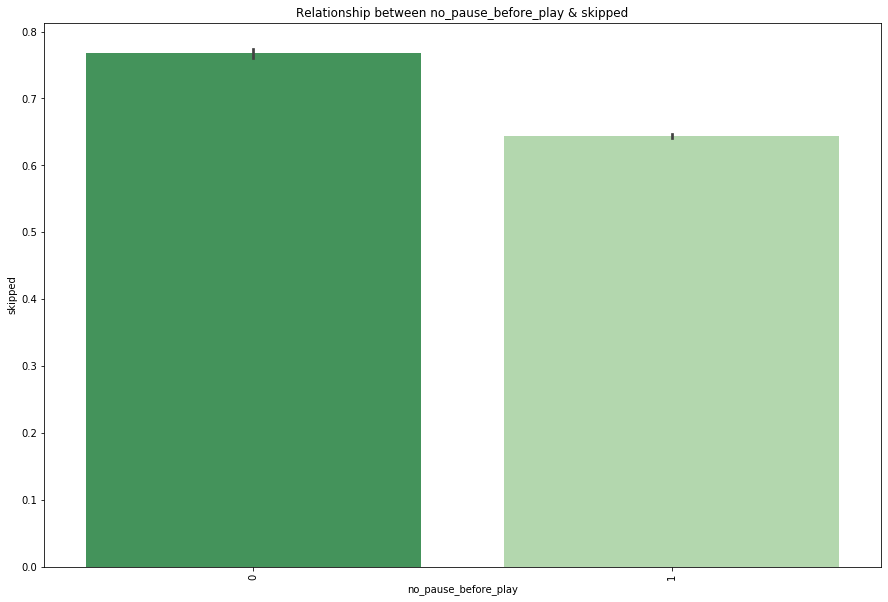

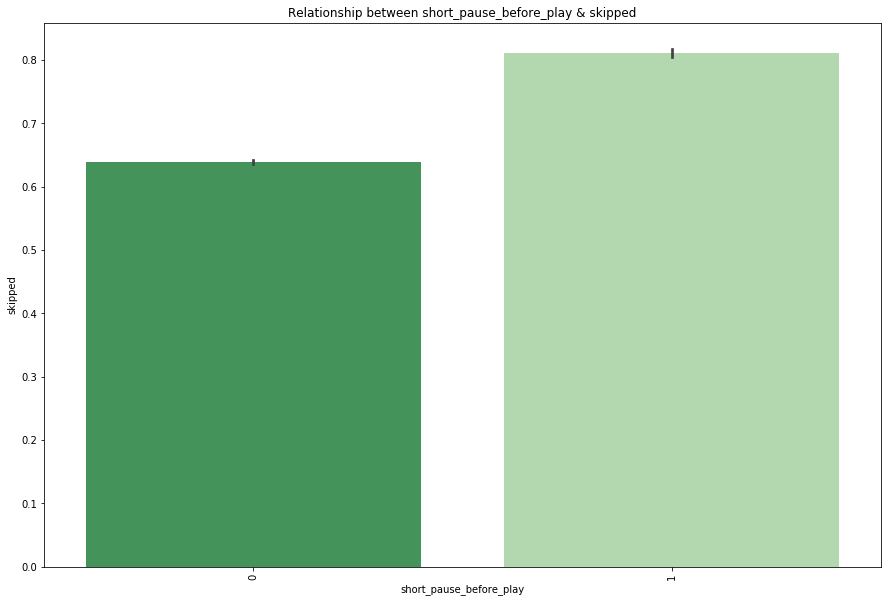

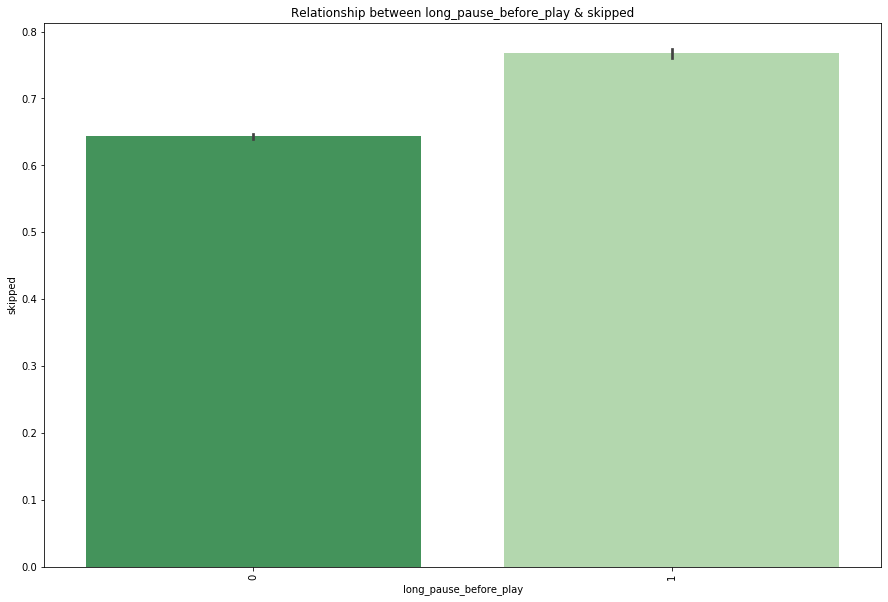

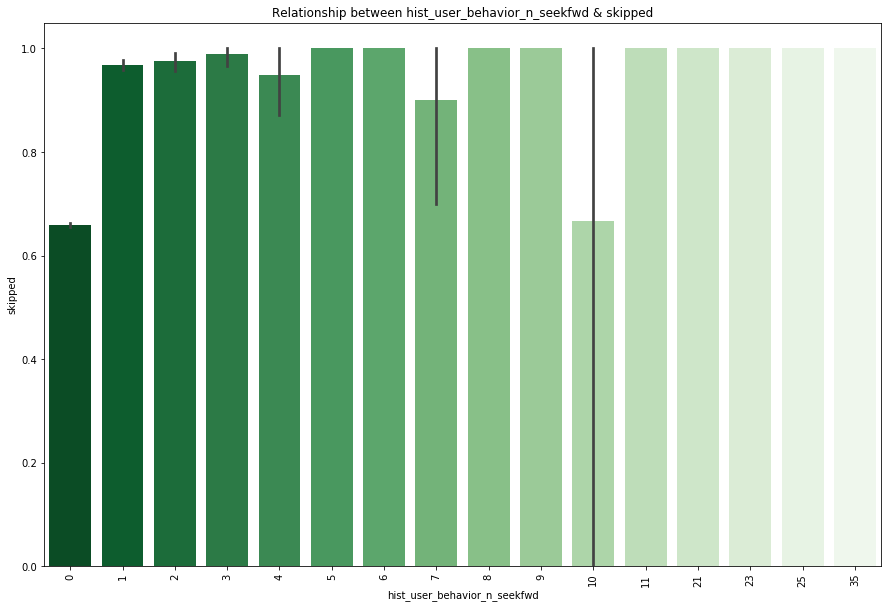

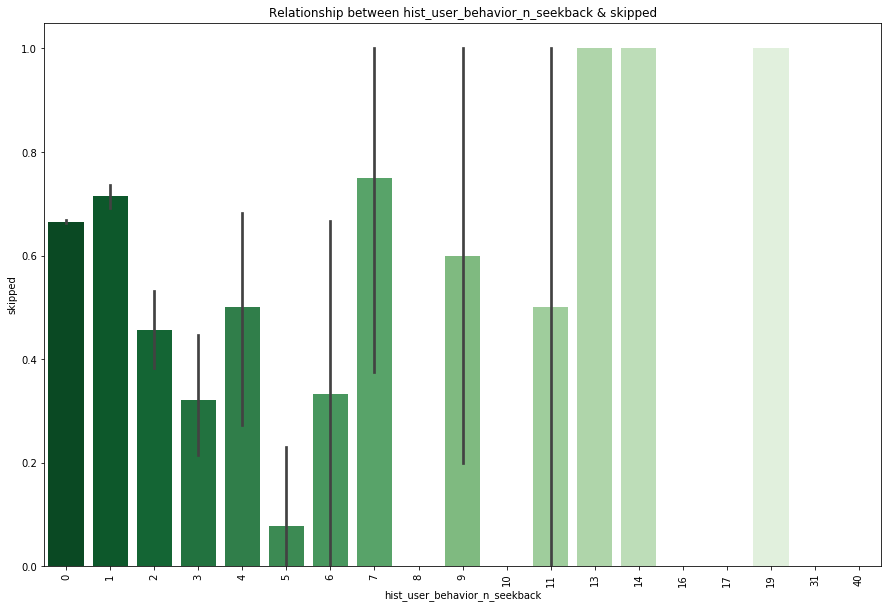

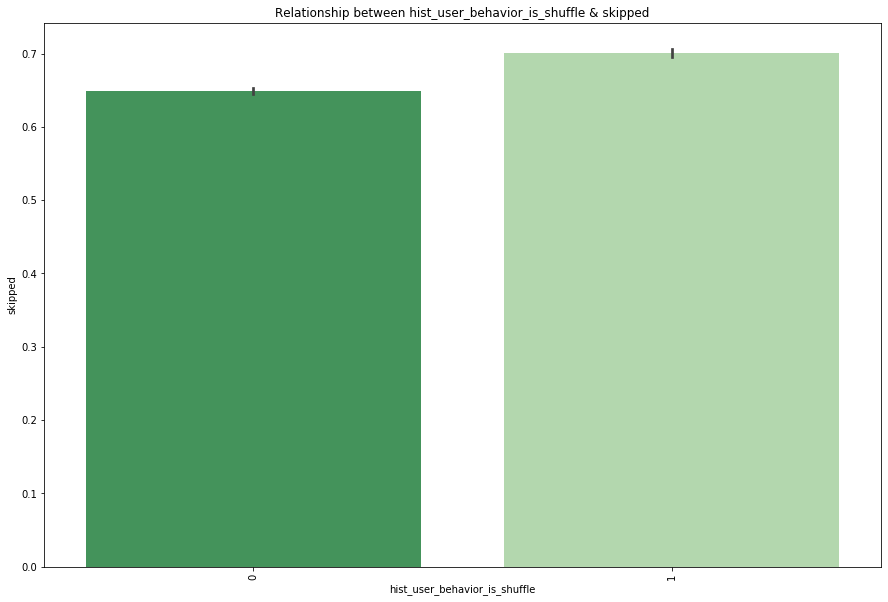

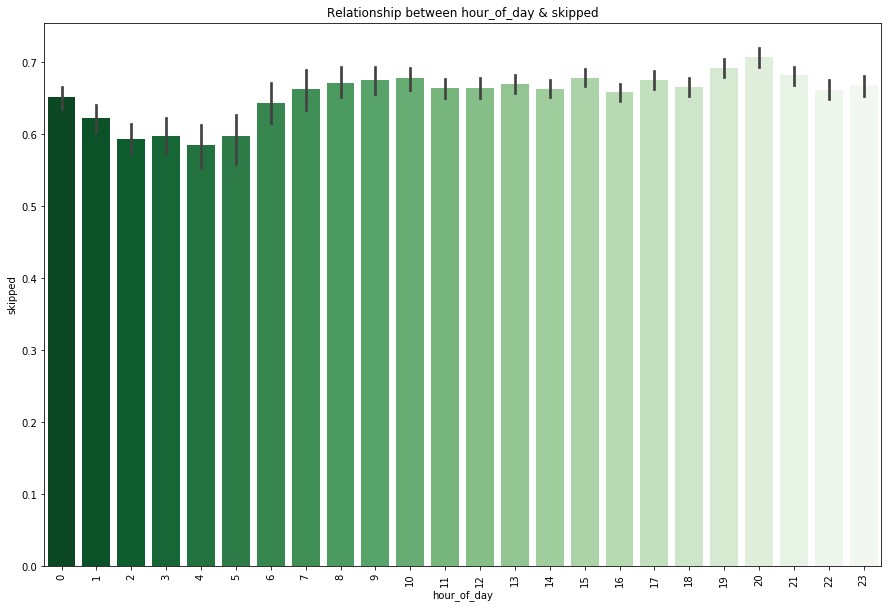

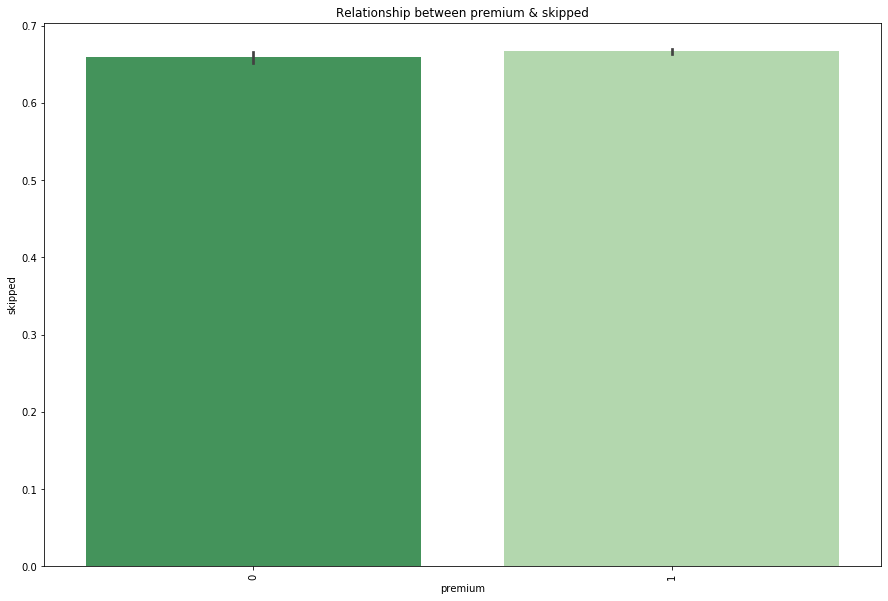

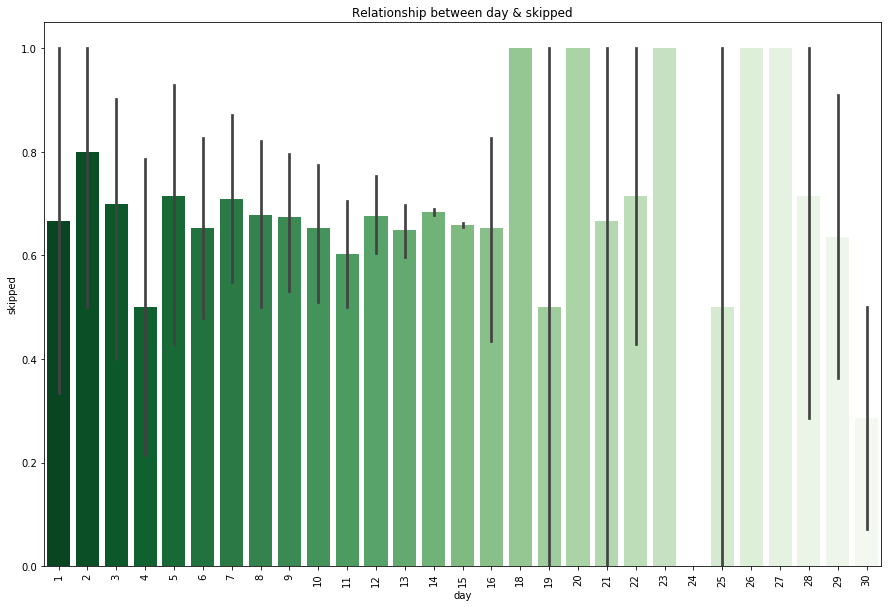

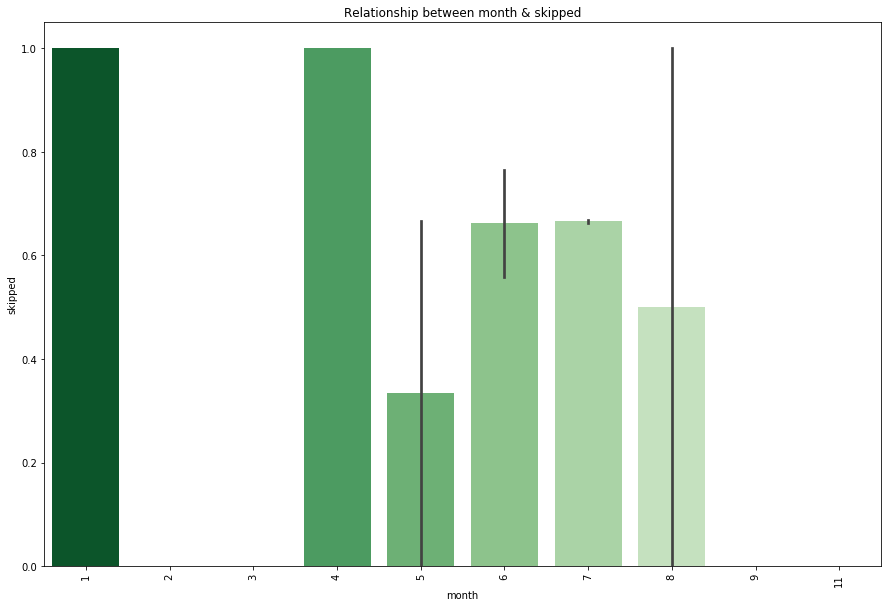

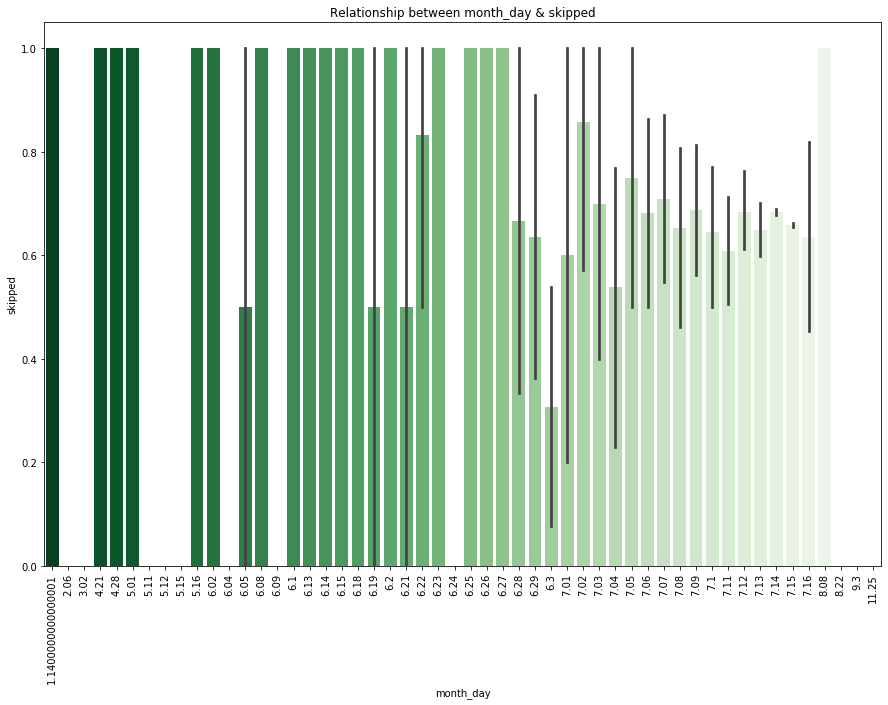

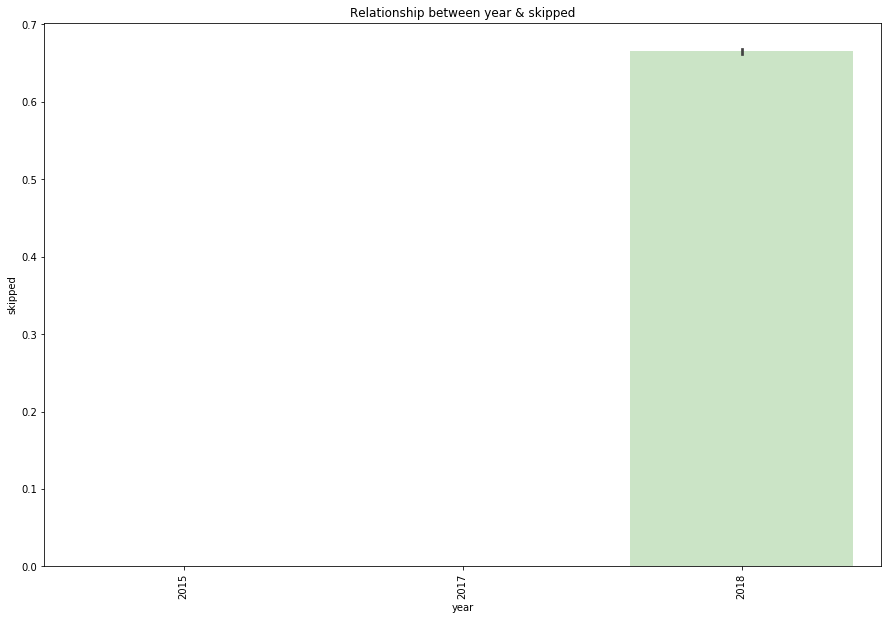

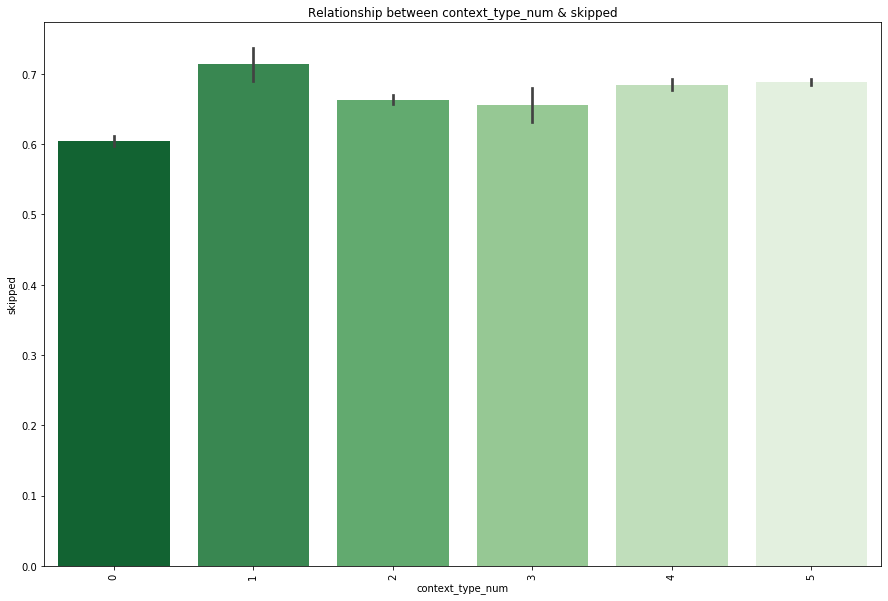

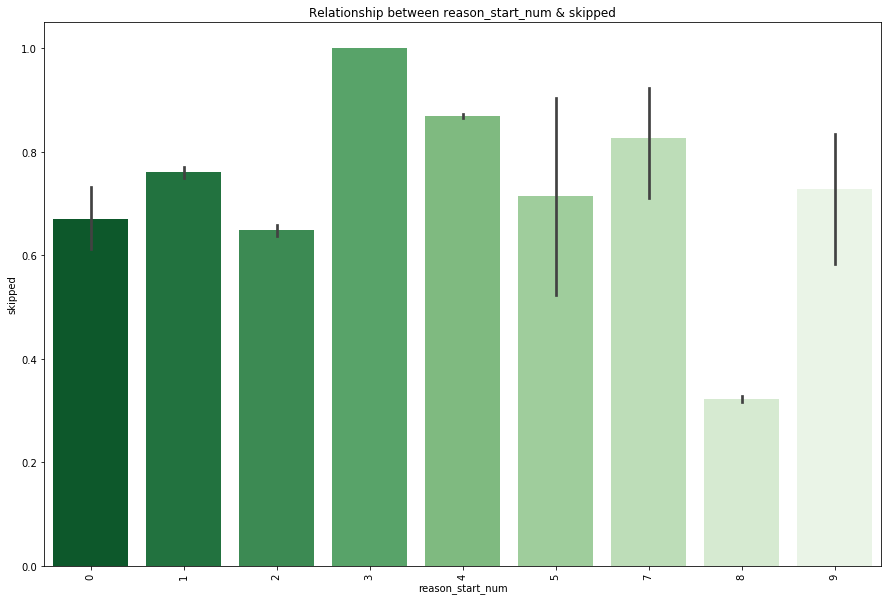

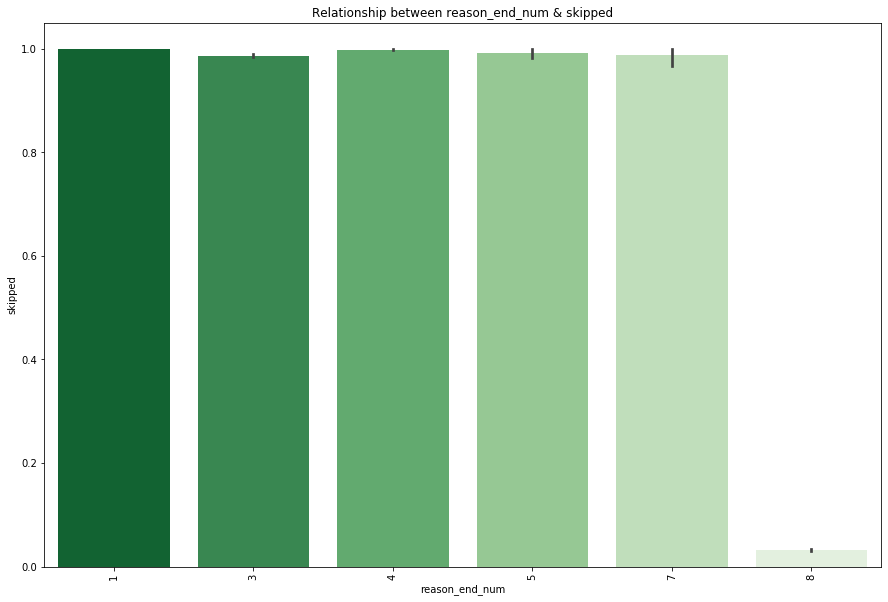

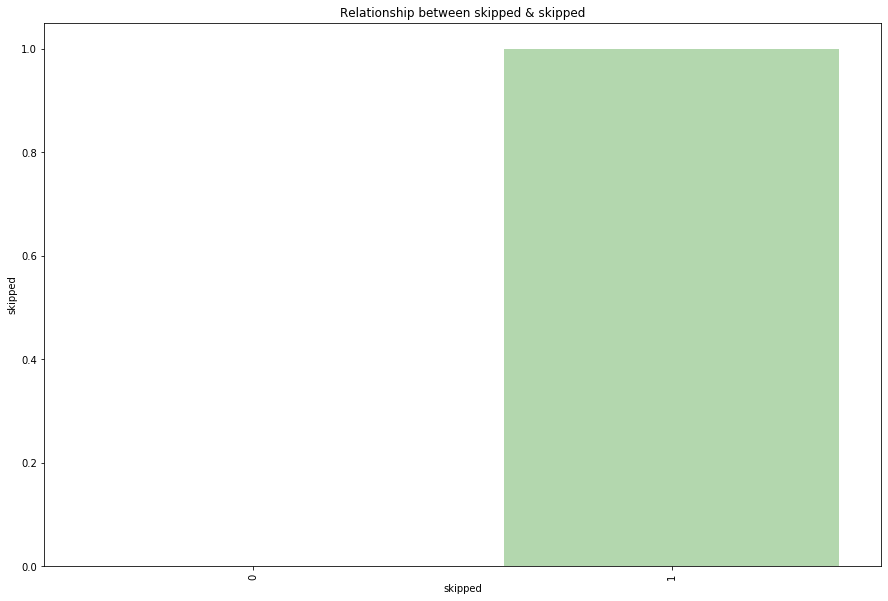

In [63]:
barplot(spotify_track20.compute(), 'vertical', 'skipped')

Okay, some boxplots would be fun - they'll give better measures of central tendency.

In [64]:
# Show a boxplot for all columns in eda dataset with the given y (passed in as string) - in case I need to use this

def boxplot(df, rotation, y): 
    for col in df:
        plt.figure(figsize=(20,25))
        sns.boxplot(x=col, y=y, palette='Greens_r', data=df)
        plt.title('Relationship between {} & {}'.format(col, y))
        plt.xlabel('{}'.format(col))
        plt.ylabel('{}'.format(y))
        plt.xticks(rotation=rotation)
        plt.show()

In [65]:
print(spotify_track1['premium'].name)

premium


In [66]:
# I think it would be good to compare the 3 slices to each other also for some vars; I'll make a function for that

def plot_side_by_side(series_list, y1, y2, y3, suptitle):
    plt.figure(figsize=(20,15))
    plt.suptitle('{}'.format(suptitle))
    
    plt.subplot(1, 3, 1)
    sns.barplot(x=series_list[0], y=y1, palette='Greens_r')

    plt.subplot(1, 3, 2)
    sns.barplot(x=series_list[1], y=y2, palette='Greens_r')

    
    plt.subplot(1, 3, 3)
    sns.barplot(x=series_list[2], y=y3, palette='Greens_r')  

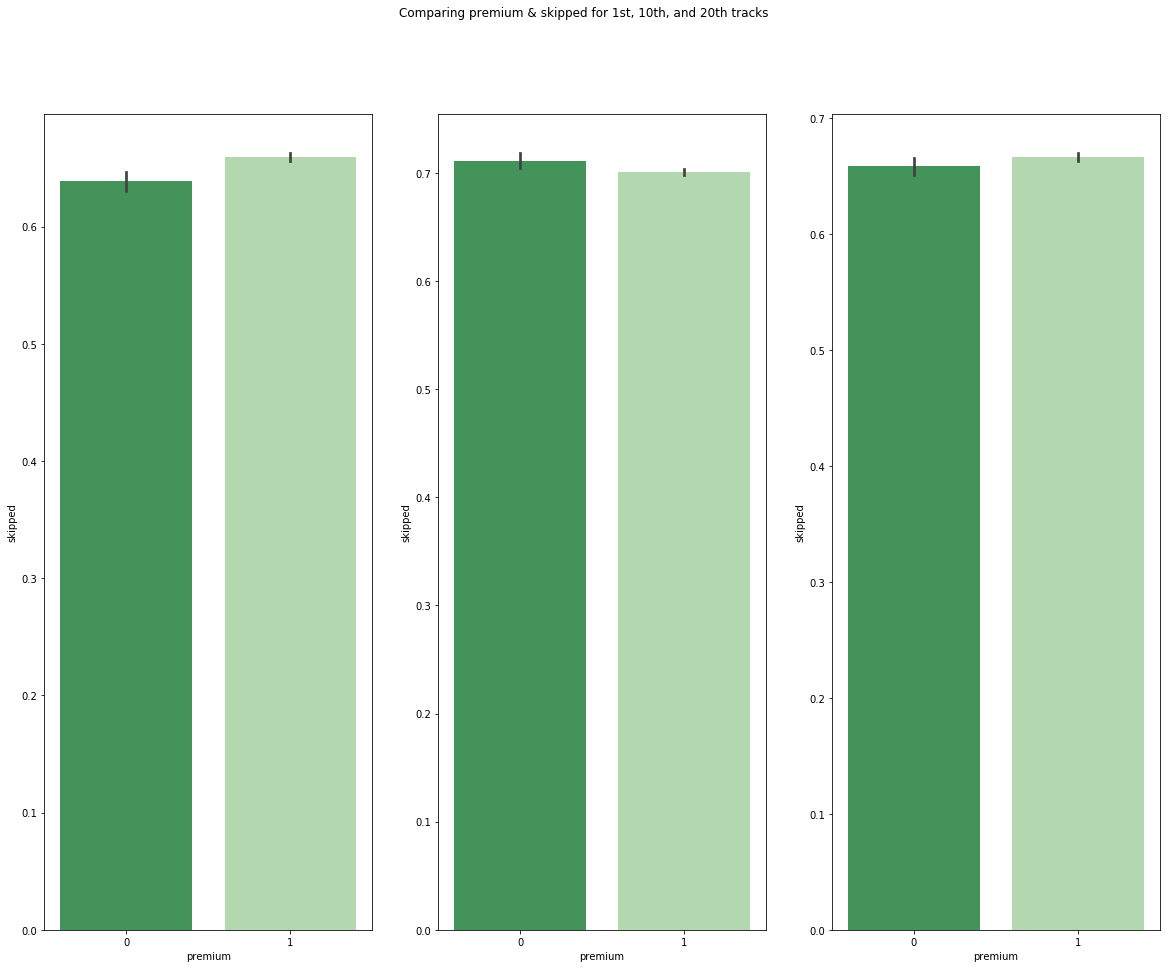

In [67]:
# Call function to look at relationship between premium & skipped across 3 slices
plot_side_by_side(
    [
    spotify_track1['premium'].compute(), 
    spotify_track10['premium'].compute(), 
    spotify_track20['premium'].compute()
], 
    spotify_track1['skipped'].compute(), 
    spotify_track10['skipped'].compute(), 
    spotify_track20['skipped'].compute(),
    'Comparing premium & skipped for 1st, 10th, and 20th tracks'
)

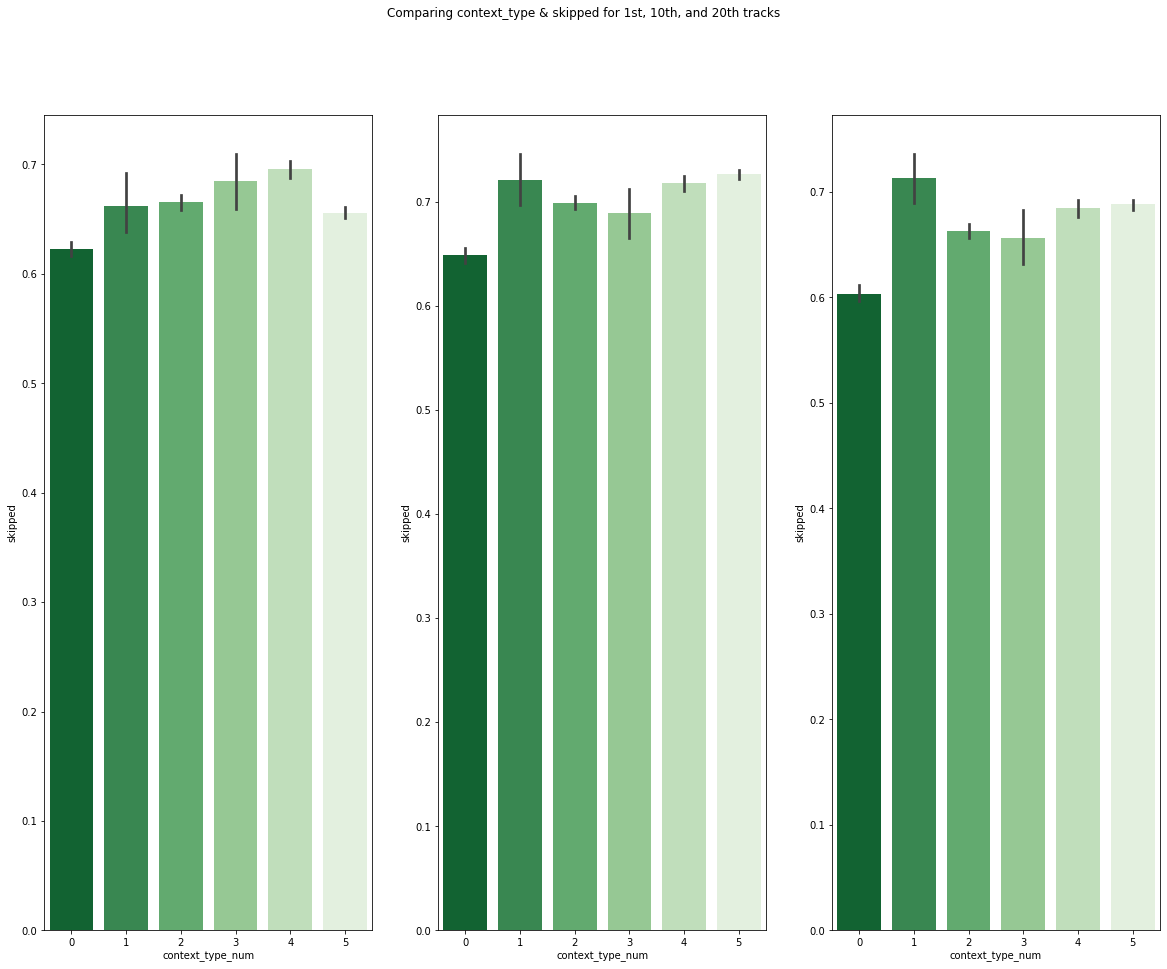

In [68]:
# Call function to look at relationship between context_type & skipped across 3 slices
plot_side_by_side(
    [
    spotify_track1['context_type_num'].compute(), 
    spotify_track10['context_type_num'].compute(), 
    spotify_track20['context_type_num'].compute()
], 
    spotify_track1['skipped'].compute(), 
    spotify_track10['skipped'].compute(), 
    spotify_track20['skipped'].compute(),
    'Comparing context_type & skipped for 1st, 10th, and 20th tracks'
)

That's interesting - so for the 1st track in a listening session, it was most common for a track to be skipped if it was spotify radio; however, for both the 10th and 20th tracks in a listening session, it was most common for tracks to be skipped if they were in Spotify's top charts.

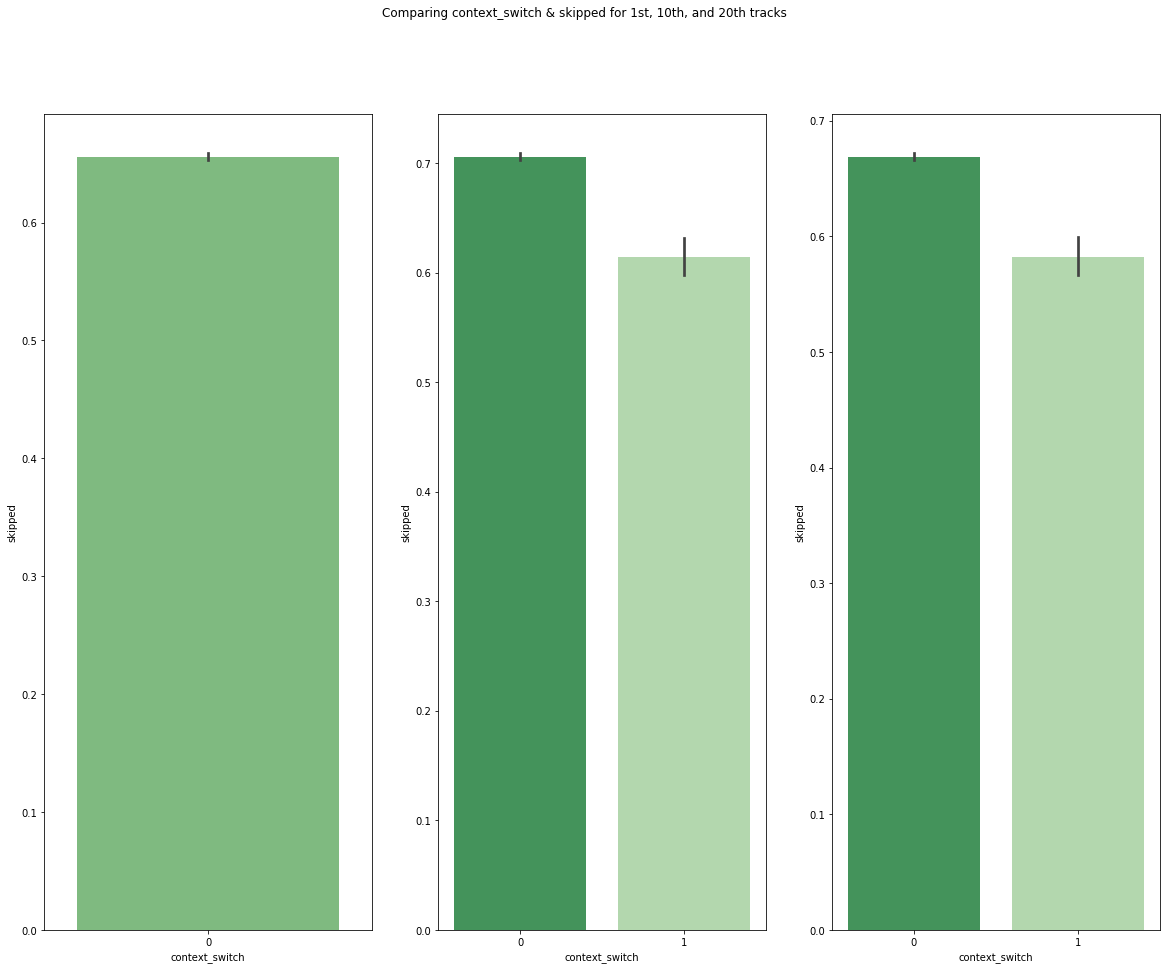

In [69]:
# Call function to look at relationship between context_switch & skipped across 3 slices
plot_side_by_side(
    [
    spotify_track1['context_switch'].compute(), 
    spotify_track10['context_switch'].compute(), 
    spotify_track20['context_switch'].compute()
], 
    spotify_track1['skipped'].compute(), 
    spotify_track10['skipped'].compute(), 
    spotify_track20['skipped'].compute(),
    'Comparing context_switch & skipped for 1st, 10th, and 20th tracks'
)

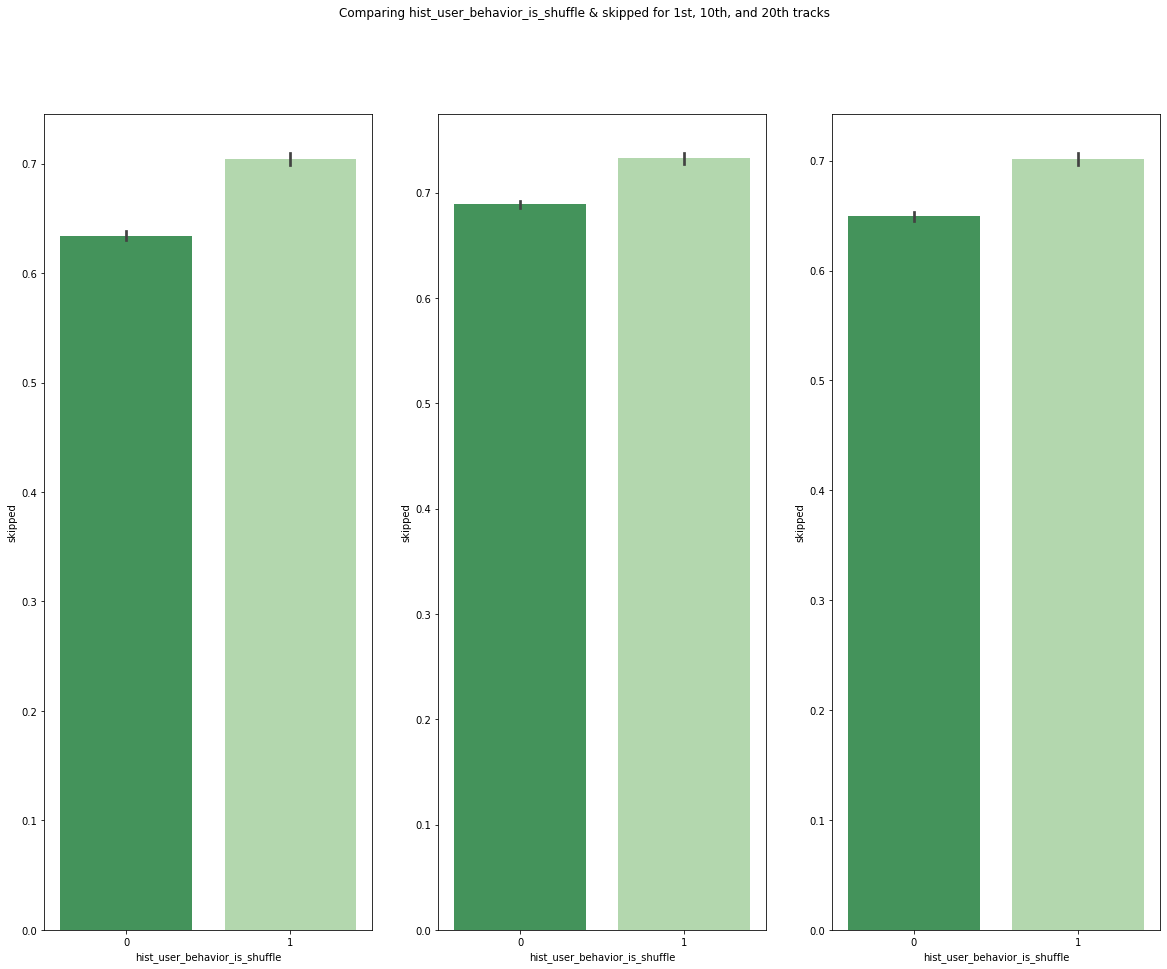

In [70]:
# Call function to look at relationship between hist_user_behavior_is_shuffle & skipped across 3 slices
plot_side_by_side(
    [
    spotify_track1['hist_user_behavior_is_shuffle'].compute(), 
    spotify_track10['hist_user_behavior_is_shuffle'].compute(), 
    spotify_track20['hist_user_behavior_is_shuffle'].compute()
], 
    spotify_track1['skipped'].compute(), 
    spotify_track10['skipped'].compute(), 
    spotify_track20['skipped'].compute(),
    'Comparing hist_user_behavior_is_shuffle & skipped for 1st, 10th, and 20th tracks'
)

More users skipped a song if they were in shuffle mode at the time.

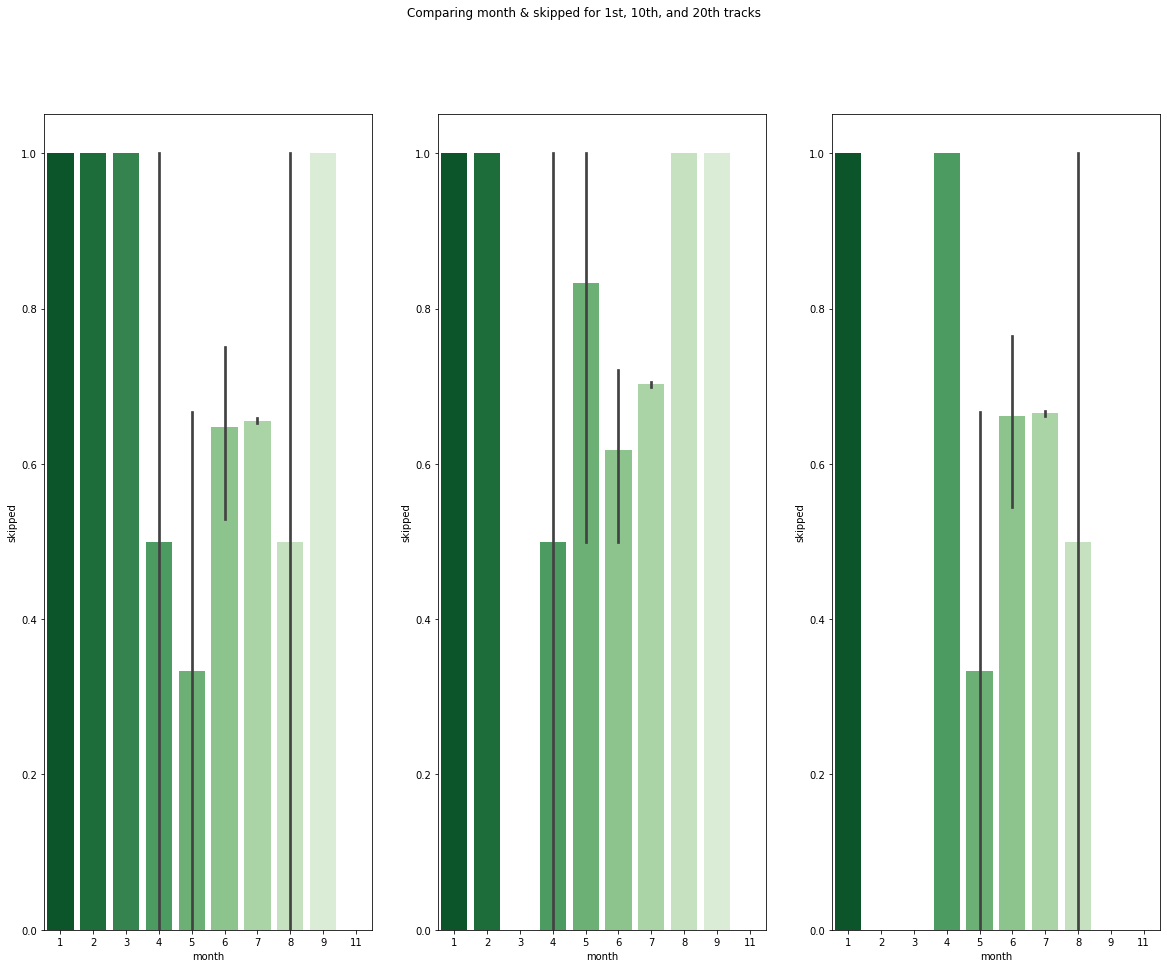

In [71]:
# Call function to look at relationship between month & skipped across 3 slices
plot_side_by_side(
    [
    spotify_track1['month'].compute(), 
    spotify_track10['month'].compute(), 
    spotify_track20['month'].compute()
], 
    spotify_track1['skipped'].compute(), 
    spotify_track10['skipped'].compute(), 
    spotify_track20['skipped'].compute(),
    'Comparing month & skipped for 1st, 10th, and 20th tracks'
)

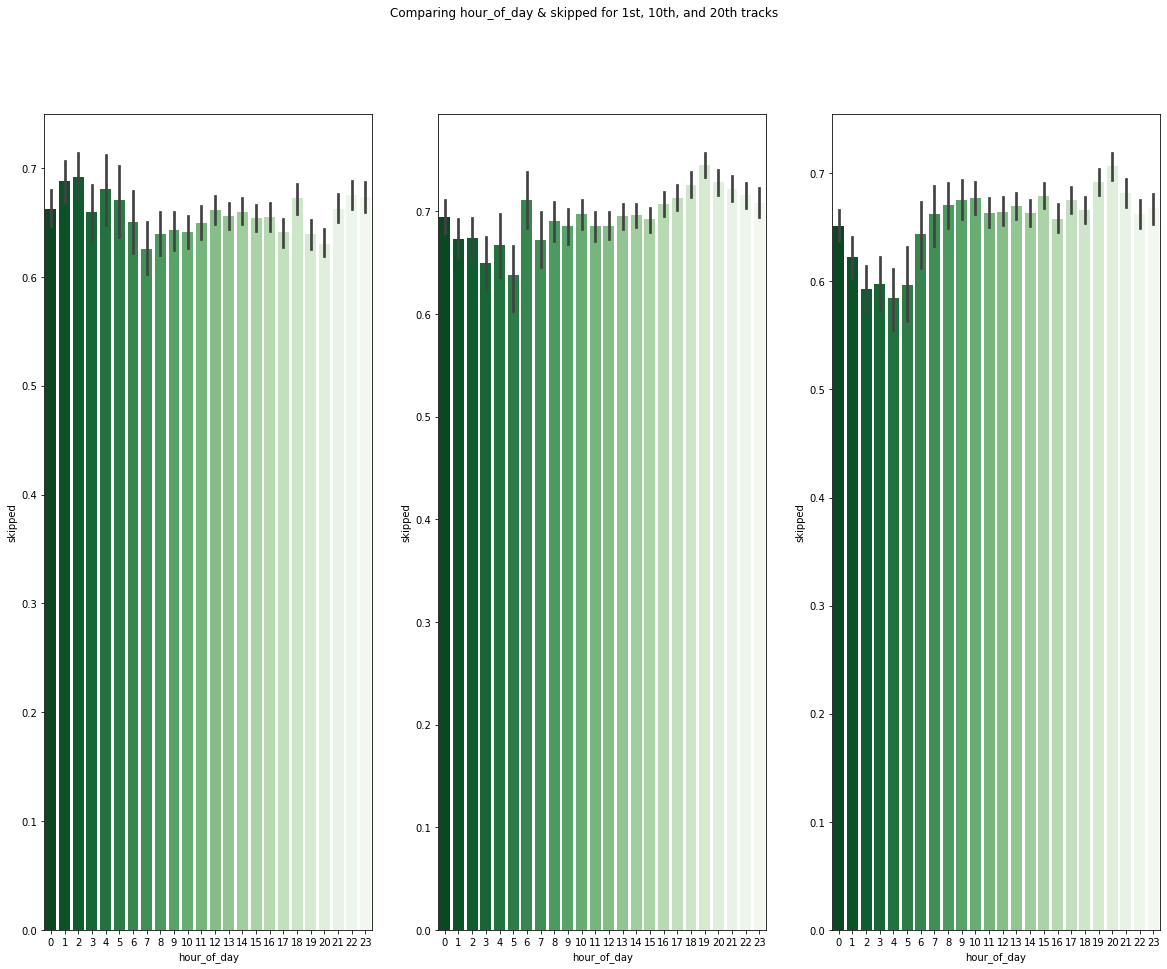

In [72]:
# Call function to look at relationship between hour_of_day & skipped across 3 slices
plot_side_by_side(
    [
    spotify_track1['hour_of_day'].compute(), 
    spotify_track10['hour_of_day'].compute(), 
    spotify_track20['hour_of_day'].compute()
], 
    spotify_track1['skipped'].compute(), 
    spotify_track10['skipped'].compute(), 
    spotify_track20['skipped'].compute(),
    'Comparing hour_of_day & skipped for 1st, 10th, and 20th tracks'
)

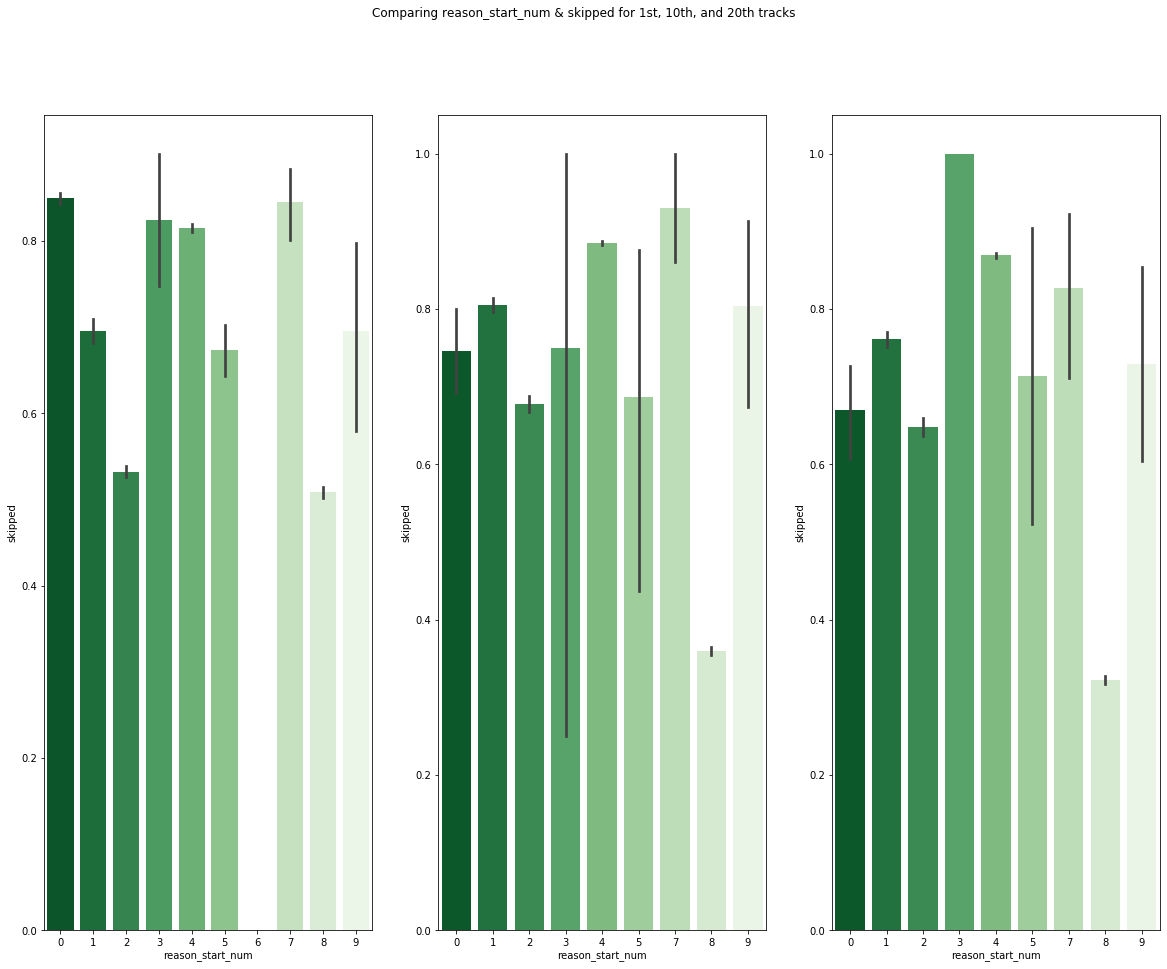

In [73]:
# Call function to look at relationship between reason_start_num  & skipped across 3 slices
plot_side_by_side(
    [
    spotify_track1['reason_start_num'].compute(), 
    spotify_track10['reason_start_num'].compute(), 
    spotify_track20['reason_start_num'].compute()
], 
    spotify_track1['skipped'].compute(), 
    spotify_track10['skipped'].compute(), 
    spotify_track20['skipped'].compute(),
    'Comparing reason_start_num & skipped for 1st, 10th, and 20th tracks'
)

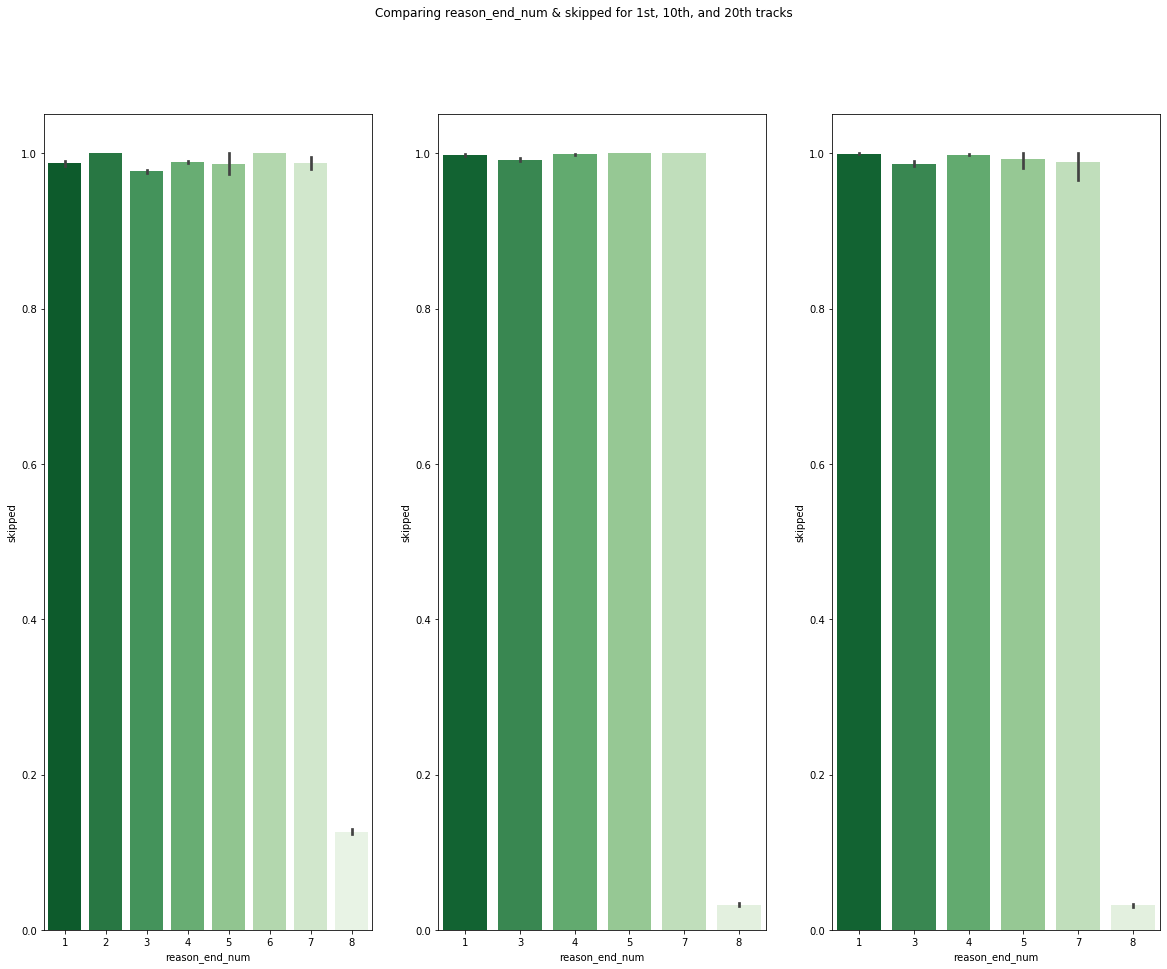

In [74]:
# Call function to look at relationship between reason_end_num & skipped across 3 slices
plot_side_by_side(
    [
    spotify_track1['reason_end_num'].compute(), 
    spotify_track10['reason_end_num'].compute(), 
    spotify_track20['reason_end_num'].compute()
], 
    spotify_track1['skipped'].compute(), 
    spotify_track10['skipped'].compute(), 
    spotify_track20['skipped'].compute(),
    'Comparing reason_end_num & skipped for 1st, 10th, and 20th tracks'
)

Well, that was interesting.

Now we need to do some feature engineering before getting into machine learning. The first thing I'm going to do is run spearman correlations & find out if any of the features are highly multicollinear with each other. To do this, I'm going to have to use the pandas version of the df, because dask is currently not supporting the spearman method of correlation, only pearson. I'm not going to run pearson correlations, because those are more for continuous data, and this data is not continuous.

In [75]:
spotify_eda_pd.head()

session_position  session_length  skip_1  skip_2  skip_3  not_skipped  \
0                 1              20       0       0       0            1   
1                 2              20       0       0       0            1   
2                 3              20       0       0       0            1   
3                 4              20       0       0       0            1   
4                 5              20       0       0       0            1   

   context_switch  no_pause_before_play  short_pause_before_play  \
0               0                     0                        0   
1               0                     1                        0   
2               0                     1                        0   
3               0                     1                        0   
4               0                     1                        0   

   long_pause_before_play  ...  hour_of_day  premium  day  month  month_day  \
0                       0  ...           16        1   15      7       7.15   
1                       0  ...           16        1   15      7       7.15   
2                       0  ...           16        1   15      7       7.15   
3                       0  ...           16        1   15      7       7.15   
4                       0  ...           16        1   15      7       7.15   

   year  context_type_num  reason_start_num  reason_end_num  skipped  
0  2018                 2                 8               8        0  
1  2018                 2                 8               8        0  
2  2018                 2                 8               8        0  
3  2018                 2                 8               8        0  
4  2018                 2                 8               8        0  

[5 rows x 23 columns]

In [76]:
spotify_eda_pd.corr(method='spearman')

session_position  session_length    skip_1  \
session_position                       1.000000        0.288863  0.066369   
session_length                         0.288863        1.000000  0.095760   
skip_1                                 0.066369        0.095760  1.000000   
skip_2                                 0.049091        0.084845  0.822722   
skip_3                                 0.007364        0.069410  0.625142   
not_skipped                           -0.001762       -0.067193 -0.600305   
context_switch                        -0.022467       -0.015907 -0.094502   
no_pause_before_play                   0.206250        0.053468  0.187680   
short_pause_before_play                0.028968       -0.009323 -0.124541   
long_pause_before_play                 0.026461       -0.022732 -0.158120   
hist_user_behavior_n_seekfwd          -0.079818       -0.006409 -0.055663   
hist_user_behavior_n_seekback         -0.057815       -0.025131 -0.108582   
hist_user_behavior_is_shuffle          0.005758        0.019812  0.054597   
hour_of_day                            0.000315       -0.011397  0.016181   
premium                                0.025499        0.085149 -0.019076   
day                                    0.000658       -0.036032 -0.014599   
month                                 -0.001946       -0.006947 -0.000196   
month_day                              0.000483       -0.036630 -0.014599   
year                                  -0.000518       -0.001212  0.001623   
context_type_num                       0.020089        0.042123  0.094389   
reason_start_num                       0.044514       -0.023980 -0.372420   
reason_end_num                         0.013758       -0.048801 -0.524256   
skipped                                0.001762        0.067193  0.600305   

                                 skip_2    skip_3  not_skipped  \
session_position               0.049091  0.007364    -0.001762   
session_length                 0.084845  0.069410    -0.067193   
skip_1                         0.822722  0.625142    -0.600305   
skip_2                         1.000000  0.759806    -0.729656   
skip_3                         0.759806  1.000000    -0.960269   
not_skipped                   -0.729656 -0.960269     1.000000   
context_switch                -0.073668 -0.041891     0.033586   
no_pause_before_play           0.104958 -0.064982     0.079497   
short_pause_before_play       -0.031301  0.119217    -0.128276   
long_pause_before_play        -0.071052  0.083062    -0.094151   
hist_user_behavior_n_seekfwd   0.021669  0.087589    -0.098030   
hist_user_behavior_n_seekback -0.063160 -0.009419     0.003770   
hist_user_behavior_is_shuffle  0.050115  0.035691    -0.033544   
hour_of_day                    0.016346  0.020407    -0.020993   
premium                       -0.008934  0.003994    -0.004878   
day                           -0.014286 -0.016452     0.016920   
month                          0.000329  0.001701    -0.001887   
month_day                     -0.014245 -0.016283     0.016730   
year                           0.002071  0.002572    -0.002692   
context_type_num               0.066788  0.043192    -0.042303   
reason_start_num              -0.354732 -0.323154     0.327005   
reason_end_num                -0.652790 -0.852144     0.862839   
skipped                        0.729656  0.960269    -1.000000   

                               context_switch  no_pause_before_play  \
session_position                    -0.022467              0.206250   
session_length                      -0.015907              0.053468   
skip_1                              -0.094502              0.187680   
skip_2                              -0.073668              0.104958   
skip_3                              -0.041891             -0.064982   
not_skipped                          0.033586              0.079497   
context_switch                       1.000000              0.008478   
no_pause_before_play         

Great, now let's look at this in a heatmap

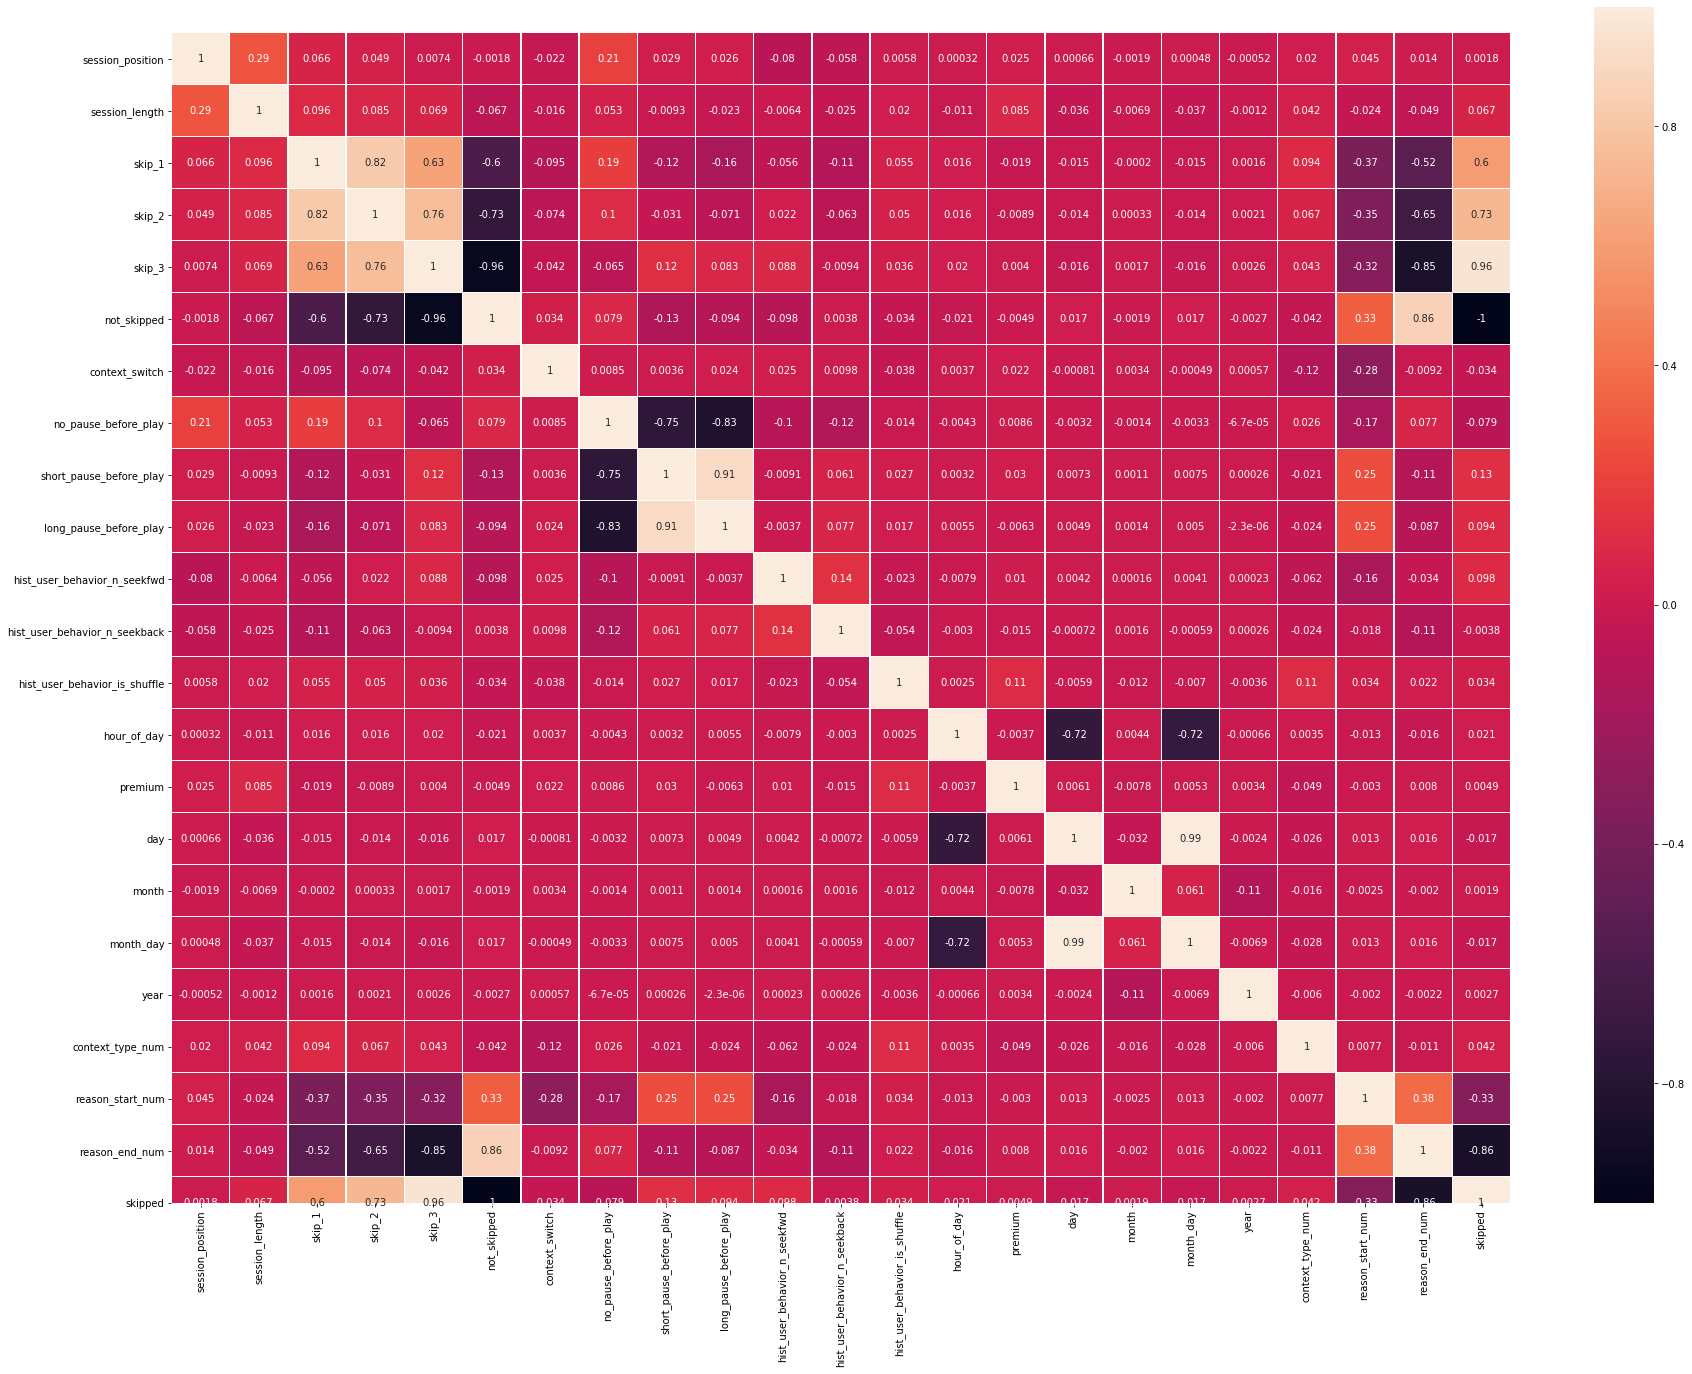

In [77]:
# Assign correlation matrix to a variable
corrmat = spotify_eda_pd.corr(method='spearman')

# Set dimensions of heatmap
hm_dims = (30, 22)

# Create heatmap
fig, ax = plt.subplots(figsize=hm_dims)
sns.heatmap(corrmat, square=False, annot=True, linewidths=.4, ax=ax)
ax.set_ylim(len(corrmat)-0.5, -0.5)      #using this line b/c workaround for a bug that cuts off top & bottom
plt.show()

In [78]:
# Alright, now a VIF to check the magnitude of the multicollinearity
def vif_cal(input_data, dependent_col):
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]]
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(endog=y, exog=x.astype(float), data=x_vars).fit().rsquared
        vif=round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)
        
#Call function, using sleptim1 as dependent var
vif_cal(input_data=spotify_eda_pd, dependent_col="skipped")

session_position  VIF =  5.12
session_length  VIF =  31.32
skip_1  VIF =  5.77
skip_2  VIF =  9.23
skip_3  VIF =  41.73
not_skipped  VIF =  22.31
context_switch  VIF =  1.21
no_pause_before_play  VIF =  16.96
short_pause_before_play  VIF =  6.79
long_pause_before_play  VIF =  10.22
hist_user_behavior_n_seekfwd  VIF =  1.14
hist_user_behavior_n_seekback  VIF =  1.1
hist_user_behavior_is_shuffle  VIF =  1.48
hour_of_day  VIF =  7.99
premium  VIF =  5.4
day  VIF =  inf
month  VIF =  inf
month_day  VIF =  inf
year  VIF =  25116.16
context_type_num  VIF =  3.35
reason_start_num  VIF =  7.85
reason_end_num  VIF =  35.81


Okay this will help figure out which variables should be removed before clustering. I'll examine the variables that have a VIF > 10 (the threshold) one by one here, to make sure it makes sense to remove them, then I'll remove them, and I'll check to make sure all VIFs are now lower than 10. Then I'll remove these variables from each of the slices we're going to use.

**session_length** - This should be fine to remove, as all of the slices of the dataset are 20, so we will know what that is regardless. Ditto with **session_position** for each of the specific tracks' datasets

**skip_3** - I'll remove this, as well as **not_skipped**, because not_skipped would be redundant, as skipped is exactly the same thing.

**no_pause_before_play** - Keep this in for now; see if removing no_pause_before_play fixes the high VIF; however, I'm not quite so interested in the granularity offered by long_pause and short_pause

**long_pause_before play** - Fine with removing this

**day** - For some reason, this is infinity.. We'll remove it for sure. Also, I would have removed it regardless of VIF, since I don't need that level of granularity here

**month** - I'll try and keep month, because it will probably be the only real useful measure of time 

**month_day** - Same as day, too granular anyway

**year** - Remove - most are 2018 anyway, so it shouldn't really factor into the analysis

**reason_end_num** - It makes sense this would be highly multicollinear with reason_start_num; we'll remove it. 

In [79]:
drop_list = [
    'session_length',
    'session_position',
    'skip_3', 
    'not_skipped',  
    'long_pause_before_play',
    'day',
    'month_day',
    'year',
    'reason_end_num'
]

spotify_eda_pd = spotify_eda_pd.drop(columns=drop_list)

In [80]:
# Check out df with dropped stuff
spotify_eda_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2990609 entries, 0 to 29737
Data columns (total 14 columns):
skip_1                           int64
skip_2                           int64
context_switch                   int64
no_pause_before_play             int64
short_pause_before_play          int64
hist_user_behavior_n_seekfwd     int64
hist_user_behavior_n_seekback    int64
hist_user_behavior_is_shuffle    int64
hour_of_day                      int64
premium                          int64
month                            int64
context_type_num                 int64
reason_start_num                 int64
skipped                          int64
dtypes: int64(14)
memory usage: 342.2 MB


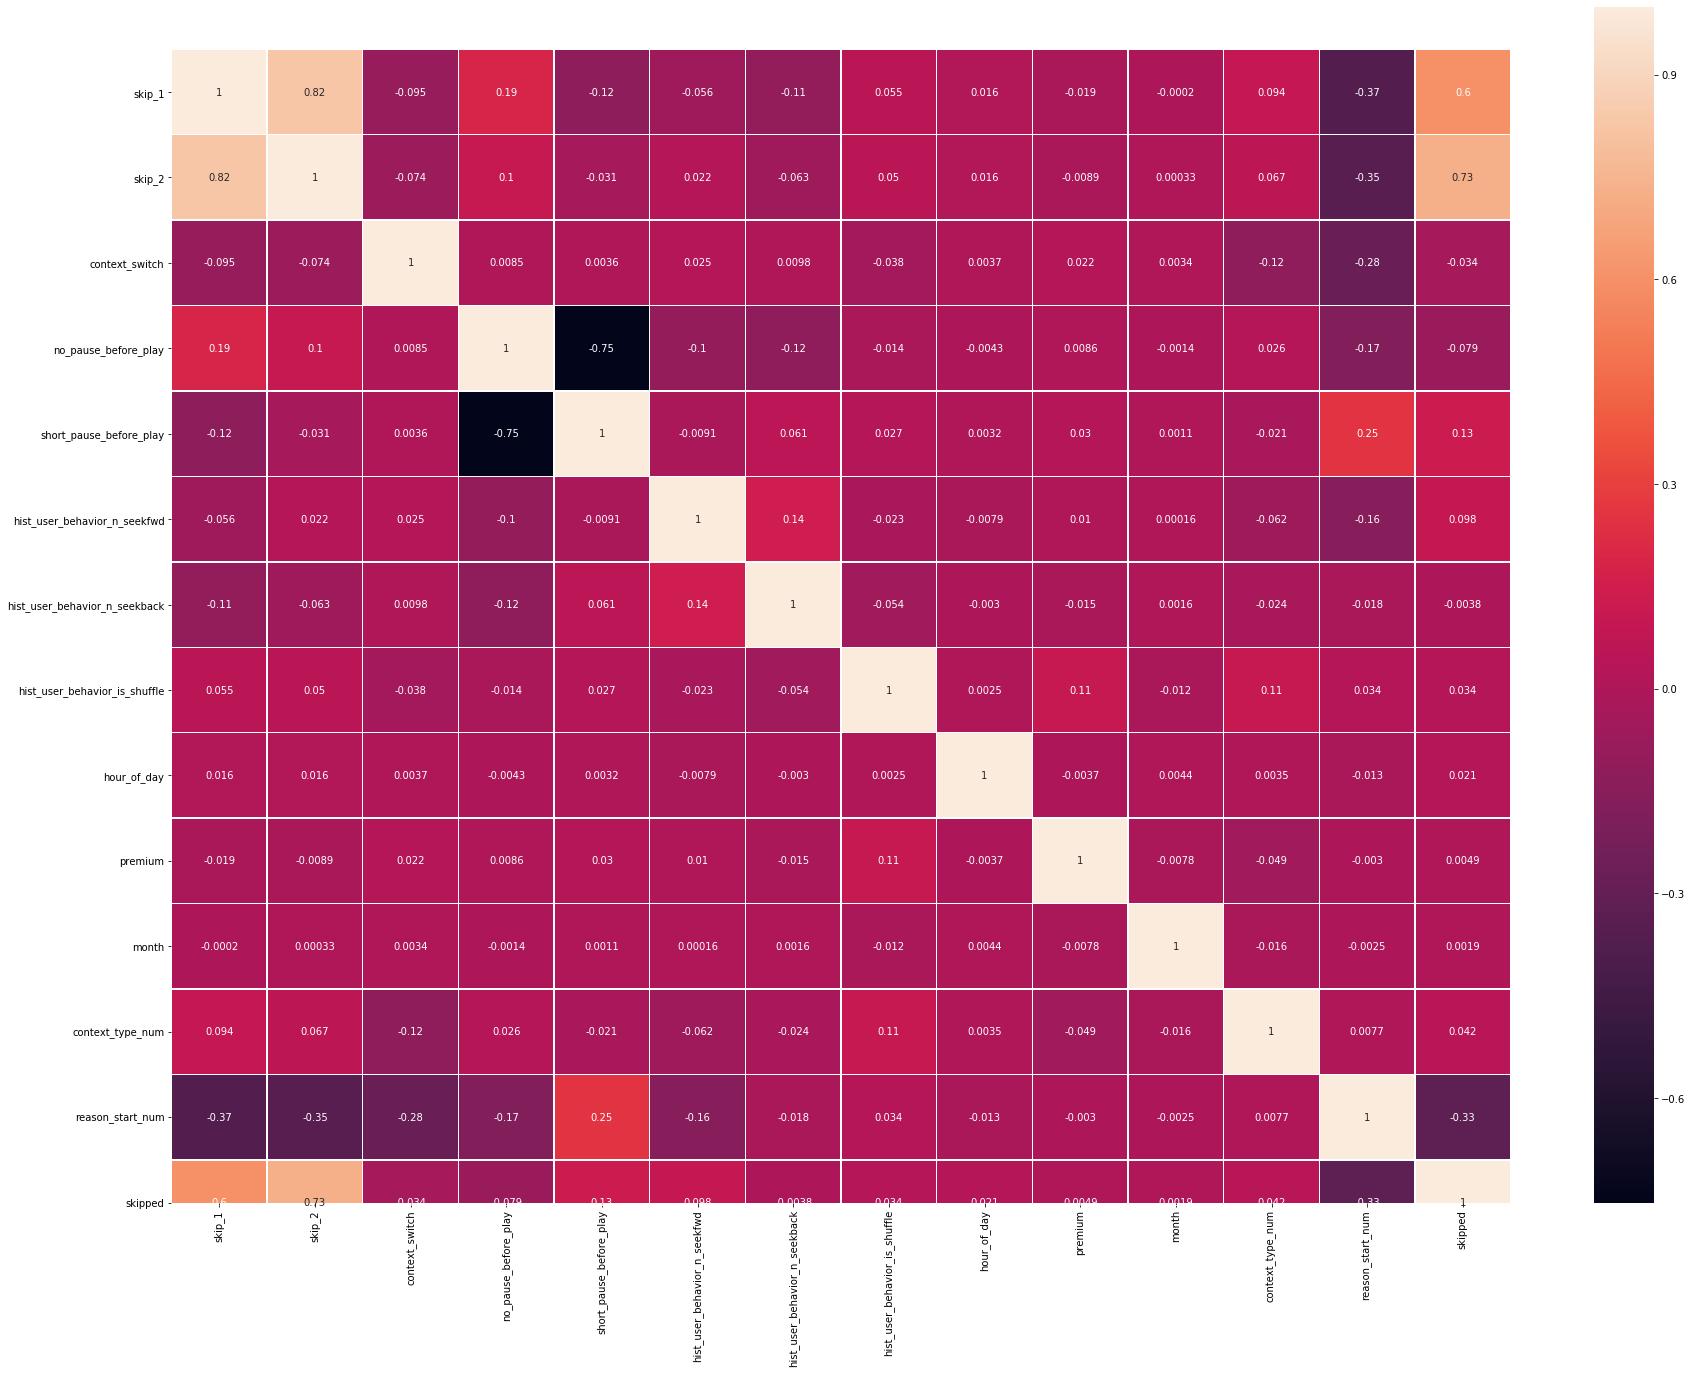

In [81]:
# Re-run correlation matrix now, see how correlated vars are now
corrmat = spotify_eda_pd.corr(method='spearman')

# Set dimensions of heatmap
hm_dims = (30, 22)

# Create heatmap
fig, ax = plt.subplots(figsize=hm_dims)
sns.heatmap(corrmat, square=False, annot=True, linewidths=.4, ax=ax)
ax.set_ylim(len(corrmat)-0.5, -0.5)      #using this line b/c workaround for a bug that cuts off top & bottom
plt.show()

Okay, it's a lot better already. I can see that no_pause_before_play, and short_pause_before are of course still correlated, but we won't remove one until we check the VIF. Ditto with skipped and sip_1 & skip_2

In [82]:
# Re-run VIF now to check magnitude of correlations
vif_cal(input_data=spotify_eda_pd, dependent_col="skipped")

skip_1  VIF =  5.76
skip_2  VIF =  6.62
context_switch  VIF =  1.19
no_pause_before_play  VIF =  10.32
short_pause_before_play  VIF =  2.93
hist_user_behavior_n_seekfwd  VIF =  1.11
hist_user_behavior_n_seekback  VIF =  1.08
hist_user_behavior_is_shuffle  VIF =  1.47
hour_of_day  VIF =  6.49
premium  VIF =  5.33
month  VIF =  30.5
context_type_num  VIF =  3.34
reason_start_num  VIF =  7.37


Alright, looking good. I'd rather keep **no_pause_before_play** than **short_pause_before_play**. I believe no_pause's VIF will decrease once I remove short_pause. As to dealing with **month**, I'm going to go ahead and keep it despite the high VIF, because the correlation matrix/heatmap shows that it is not actually highly correlated with any of the variables that are left. 

In [83]:
# Remove short_pause_before_play
spotify_eda_pd = spotify_eda_pd.drop(columns='short_pause_before_play')

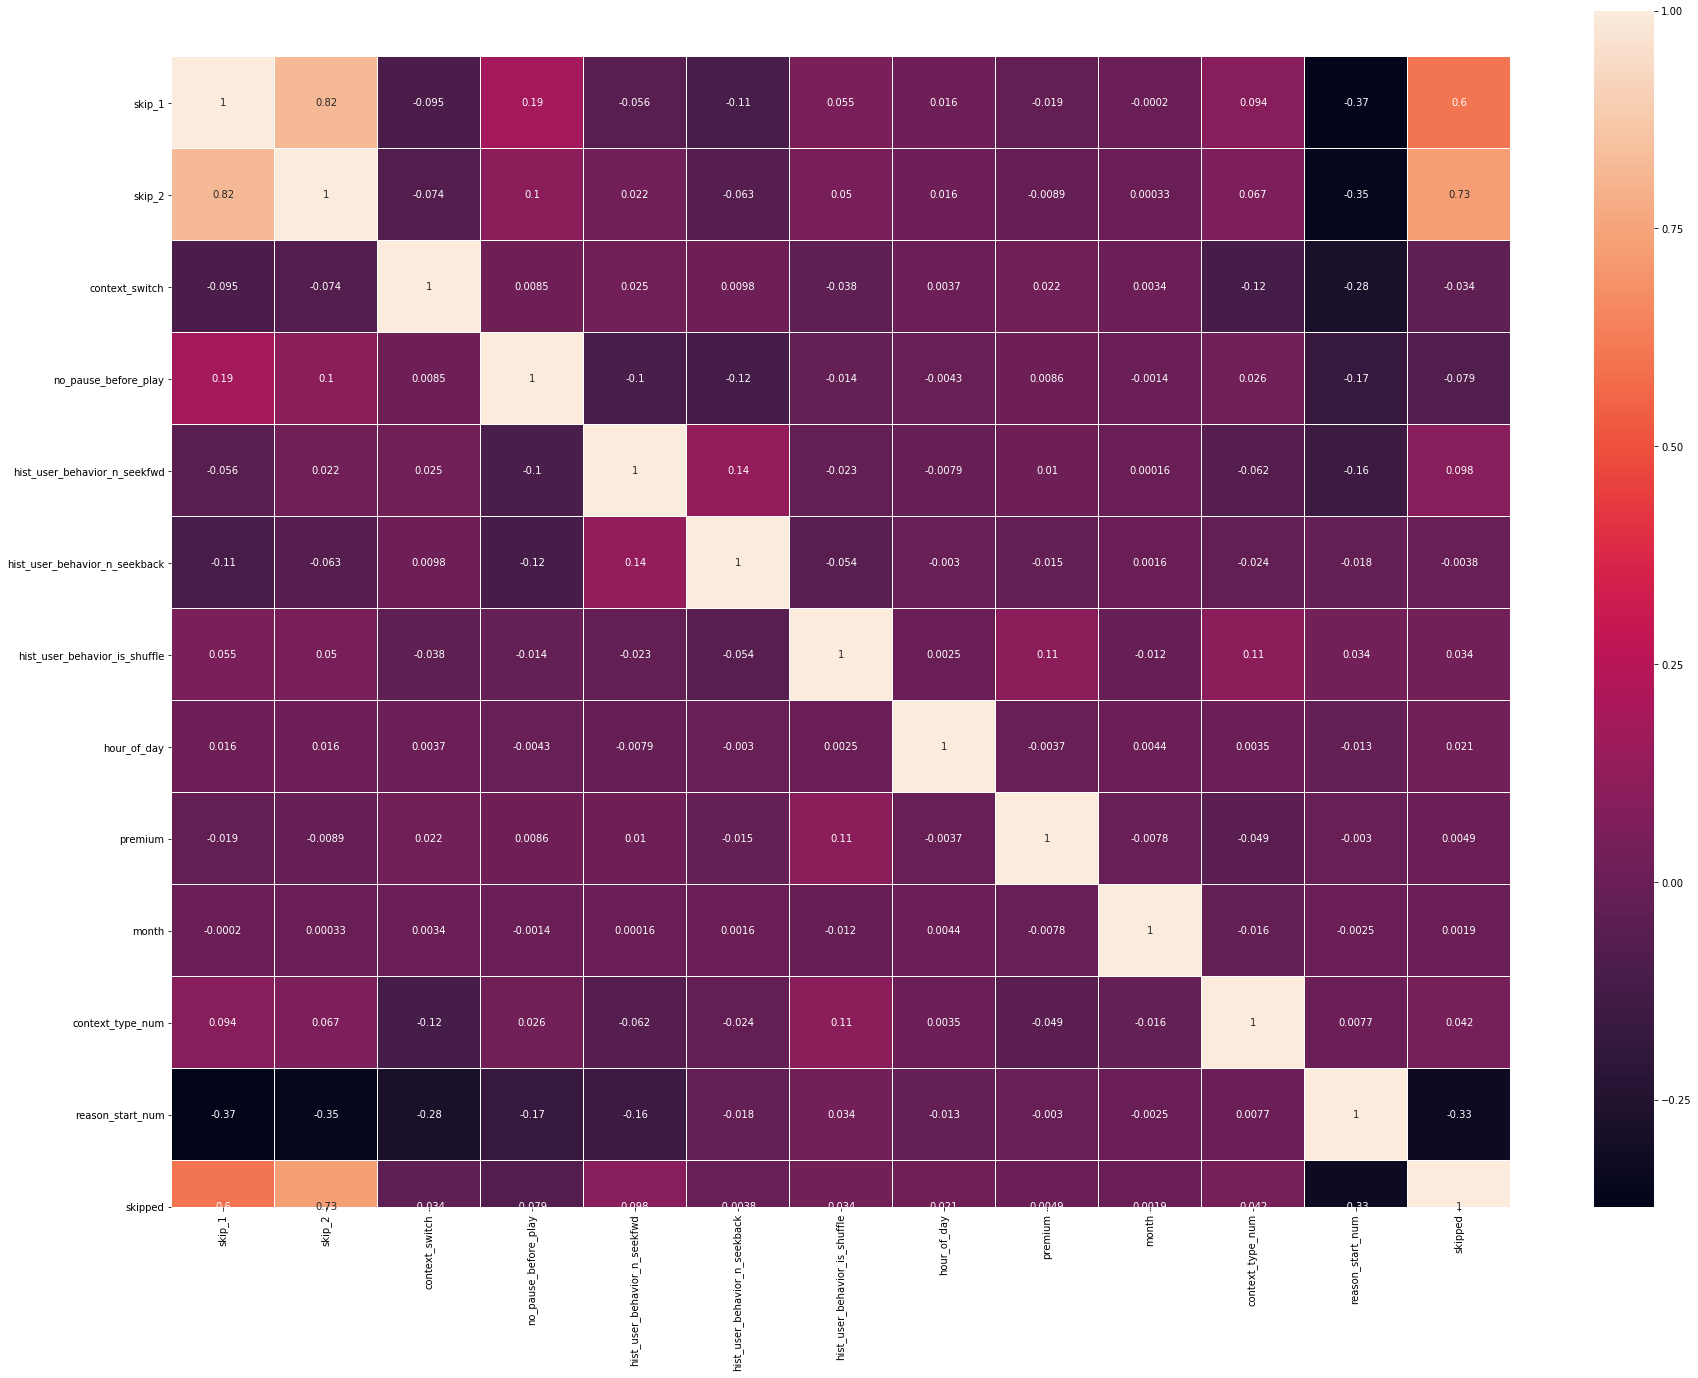

In [84]:
# Check correlations for what should be the final time
corrmat = spotify_eda_pd.corr(method='spearman')

# Set dimensions of heatmap
hm_dims = (30, 22)

# Create heatmap
fig, ax = plt.subplots(figsize=hm_dims)
sns.heatmap(corrmat, square=False, annot=True, linewidths=.4, ax=ax)
ax.set_ylim(len(corrmat)-0.5, -0.5)      #using this line b/c workaround for a bug that cuts off top & bottom
plt.show()

In [85]:
# Now run VIF for what I hope to be the last time
vif_cal(input_data=spotify_eda_pd, dependent_col="skipped")

skip_1  VIF =  5.75
skip_2  VIF =  6.52
context_switch  VIF =  1.18
no_pause_before_play  VIF =  4.58
hist_user_behavior_n_seekfwd  VIF =  1.11
hist_user_behavior_n_seekback  VIF =  1.08
hist_user_behavior_is_shuffle  VIF =  1.47
hour_of_day  VIF =  6.49
premium  VIF =  5.31
month  VIF =  27.23
context_type_num  VIF =  3.34
reason_start_num  VIF =  6.93


Hooray, we're all set now. I know the month's VIF looks scary, but again, it's not actually correlated with anything. I see no problem with keeping both of skip_1 and skip_2, because their VIFs are fine, despite their sort of high correlation.

Now it's time to drop all these variables from our 3 slices.

In [86]:
# Set up a list of vars to drop
drop_list2 = [
    'session_length',
    'session_position',
    'skip_3', 
    'not_skipped',  
    'long_pause_before_play',
    'short_pause_before_play',
    'day',
    'month_day',
    'year',
    'reason_end_num'
]

# Drop them!
Xclusters_track1 = spotify_track1.drop(columns=drop_list2)
Xclusters_track10 = spotify_track10.drop(columns=drop_list2)
Xclusters_track20 = spotify_track20.drop(columns=drop_list2)

In [87]:
# Check out a slice to see if it's all good
Xclusters_track1.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 13 entries, skip_1 to skipped
dtypes: int64(13)

In [88]:
Xclusters_track1.head()

skip_1  skip_2  context_switch  no_pause_before_play  \
0       0       0               0                     0   
0       1       1               0                     0   
0       0       0               0                     0   
0       0       0               0                     0   
1       0       1               0                     0   

   hist_user_behavior_n_seekfwd  hist_user_behavior_n_seekback  \
0                             0                              0   
0                             0                              0   
0                             0                              0   
0                             0                              0   
1                             0                              0   

   hist_user_behavior_is_shuffle  hour_of_day  premium  month  \
0                              1           16        1      7   
0                              1           14        1      7   
0                              0           17        1      7   
0                              1           11        1      7   
1                              0           21        1      7   

   context_type_num  reason_start_num  skipped  
0                 2                 8        0  
0                 5                 4        1  
0                 2                 4        0  
0                 2                 5        1  
1                 4                 2        1

In [89]:
# Just to be extra double sure, I'm going to run VIF again, this time with a slice, to make sure it mirrors the df's
vif_cal(input_data=Xclusters_track1.compute(), dependent_col="skipped")

skip_1  VIF =  3.73
skip_2  VIF =  4.39
context_switch  VIF =  nan
no_pause_before_play  VIF =  1.0
hist_user_behavior_n_seekfwd  VIF =  2.14
hist_user_behavior_n_seekback  VIF =  2.02
hist_user_behavior_is_shuffle  VIF =  1.5
hour_of_day  VIF =  6.27
premium  VIF =  6.17
month  VIF =  16.92
context_type_num  VIF =  3.31
reason_start_num  VIF =  3.27


Well great, month's VIF is even lower here. I'd say we're all set.

Now we need to get dummies for all of these. Because dask is not great for converting to dummies (in my opinion at least), we are going to use the pandas version of the dataframe to get dummies.

However, before we get the dummies, we'll need to do a bit more feature engineering to make the dummies better suited to the clusters we'll create.

In [90]:
# Make hist_user_behavior_n_seekfwd ordinal buckets so there's not quite as many unique values to deal with

# First, check their unique values in each of the slices
slice_list = [Xclusters_track1, Xclusters_track10, Xclusters_track20]

# Set up function to easily be able to print out name of df being viewed
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

for df_slice in slice_list:
    print('Unique values of hist_user_behavior_n_seekfwd in {}:\n'.format(get_df_name(df_slice)), 
          df_slice['hist_user_behavior_n_seekfwd'].value_counts().compute())

Unique values of hist_user_behavior_n_seekfwd in Xclusters_track1:
 0      77345
1      11663
2        429
3        120
4         38
5         26
6         16
7          8
8          4
9          4
10         3
11         2
13         2
14         2
16         2
57         1
12         1
19         1
20         1
21         1
22         1
47         1
212        1
Name: hist_user_behavior_n_seekfwd, dtype: int64
Unique values of hist_user_behavior_n_seekfwd in Xclusters_track10:
 0     87682
1      1440
2       348
3       109
4        45
5        18
6        10
7         5
8         5
9         2
20        1
10        1
11        1
12        1
13        1
16        1
19        1
27        1
Name: hist_user_behavior_n_seekfwd, dtype: int64
Unique values of hist_user_behavior_n_seekfwd in Xclusters_track20:
 0     87823
1      1358
2       317
3        88
4        39
5        14
7        10
6         9
9         4
10        3
8         2
35        1
25        1
23        1
21        1
1

Alright, this information tells us how we'll want to split up this variable into chunks, specific to each df slice.
I actually think that for all of them, it would be wisest to simply make them 0 times, 1-2 times, and 3+ times. We really don't need any more granularity than that.

In [91]:
# Divide up hist_user_behavior_n_seekfwd in all 3 df slices at once

Xclusters_track1 = Xclusters_track1.compute()
Xclusters_track10 = Xclusters_track10.compute()
Xclusters_track20 = Xclusters_track20.compute()

slice_list = [Xclusters_track1, Xclusters_track10, Xclusters_track20]

for df_slice in slice_list:
    df_slice.loc[df_slice['hist_user_behavior_n_seekfwd'] >= 3, 'hist_user_behavior_n_seekfwd'] = '3+'
    df_slice.loc[(df_slice['hist_user_behavior_n_seekfwd'] == 1) | (
        df_slice['hist_user_behavior_n_seekfwd'] == 2), 'hist_user_behavior_n_seekfwd'] = '1 to 2'
    

In [92]:
# See if that worked
for df_slice in slice_list:
    print('Unique values of hist_user_behavior_n_seekfwd in {}:\n'.format(get_df_name(df_slice)), 
          df_slice['hist_user_behavior_n_seekfwd'].value_counts())

Unique values of hist_user_behavior_n_seekfwd in Xclusters_track1:
 0         77345
1 to 2    12092
3+          235
Name: hist_user_behavior_n_seekfwd, dtype: int64
Unique values of hist_user_behavior_n_seekfwd in Xclusters_track10:
 0         87682
1 to 2     1788
3+          202
Name: hist_user_behavior_n_seekfwd, dtype: int64
Unique values of hist_user_behavior_n_seekfwd in Xclusters_track20:
 0         87823
1 to 2     1675
3+          174
Name: hist_user_behavior_n_seekfwd, dtype: int64


Great, now when we're ready to get dummies, we'll be able to get them for each of these 3 values.

Now we'll easily do the same with hist_user_behavior_n_seekback

In [93]:
# Check we still want the same intervals for seekback

for df_slice in slice_list:
    print('Unique values of hist_user_behavior_n_seekback in {}:\n'.format(get_df_name(df_slice)), 
          df_slice['hist_user_behavior_n_seekback'].value_counts())

Unique values of hist_user_behavior_n_seekback in Xclusters_track1:
 0      82288
1       5687
2        960
3        310
4        160
5         90
6         38
8         30
7         25
9         17
10        12
11        10
15         5
14         5
12         4
16         4
17         3
18         3
27         2
13         2
19         2
67         2
369        1
36         1
34         1
33         1
28         1
25         1
26         1
53         1
23         1
20         1
146        1
81         1
57         1
Name: hist_user_behavior_n_seekback, dtype: int64
Unique values of hist_user_behavior_n_seekback in Xclusters_track10:
 0     87728
1      1626
2       175
3        57
4        33
5        12
9         5
6         5
8         5
12        4
7         3
10        3
11        3
13        3
17        3
89        1
15        1
16        1
19        1
20        1
23        1
29        1
Name: hist_user_behavior_n_seekback, dtype: int64
Unique values of hist_user_behavior_n_seek

In [94]:
# Yep, those intervals still make the most sense to me.

#Recode seekback
for df_slice in slice_list:
    df_slice.loc[df_slice['hist_user_behavior_n_seekback'] >= 3, 'hist_user_behavior_n_seekback'] = '3+'
    df_slice.loc[(df_slice['hist_user_behavior_n_seekback'] == 1) | (
        df_slice['hist_user_behavior_n_seekback'] == 2), 'hist_user_behavior_n_seekback'] = '1 to 2'

# Check it worked
for df_slice in slice_list:
    print('Unique values of hist_user_behavior_n_seekback in {}:\n'.format(get_df_name(df_slice)), 
          df_slice['hist_user_behavior_n_seekback'].value_counts())

Unique values of hist_user_behavior_n_seekback in Xclusters_track1:
 0         82288
1 to 2     6647
3+          737
Name: hist_user_behavior_n_seekback, dtype: int64
Unique values of hist_user_behavior_n_seekback in Xclusters_track10:
 0         87728
1 to 2     1801
3+          143
Name: hist_user_behavior_n_seekback, dtype: int64
Unique values of hist_user_behavior_n_seekback in Xclusters_track20:
 0         87869
1 to 2     1679
3+          124
Name: hist_user_behavior_n_seekback, dtype: int64


Nice, now what we need to do is deal with hour_of_day, and we should be set. Similarly, we don't need the granularity of having every single hour in the day, so we're going to find some meaningful buckets for that and get dummies for those.

In [95]:
# Print hour of day unique values to think about how we want to divide it up
for df_slice in slice_list:
    print('Unique values of hour_of_day in {}:\n'.format(get_df_name(df_slice)), 
          df_slice['hour_of_day'].value_counts())

Unique values of hour_of_day in Xclusters_track1:
 14    5926
17    5922
15    5863
13    5758
20    5548
16    5238
21    5235
12    5134
22    4771
18    4771
19    4663
11    4610
23    4128
10    4119
9     3139
0     3139
1     2343
8     2276
2     1703
7     1461
3     1192
6     1006
4      885
5      842
Name: hour_of_day, dtype: int64
Unique values of hour_of_day in Xclusters_track10:
 14    5923
15    5910
17    5721
13    5572
16    5513
21    5194
20    5165
18    5138
12    5066
22    4908
19    4835
11    4494
23    4280
10    3924
0     3334
9     3002
1     2495
8     2087
2     1823
7     1275
3     1263
6      977
4      956
5      817
Name: hour_of_day, dtype: int64
Unique values of hour_of_day in Xclusters_track20:
 15    5944
14    5929
16    5772
18    5538
17    5512
13    5421
21    5207
19    5027
22    5009
12    4981
20    4699
23    4402
11    4364
10    3747
0     3536
9     2737
1     2624
2     1978
8     1921
3     1382
7     1143
4     1028
6      965


I think it makes the most sense to just have buckets of morning, afternoon, night, and, early hours of the morning. Let's see what that would look like.
early = 1-5
morning = 6-11
afternoon = 12-18
night = 19-23, 0

I think this covers it and is a division that will be more meaningful than looking at every individual hour, and this will allow getting dummy variables to go a lot more smoothly as well.

In [96]:
# For this variable, it will be more efficient to apply a recoding function, rather than use .loc a bunch of times

def recode_value(row, col_name, recode_dict):
    return recode_dict[row[col_name]]

def recode_var(df, col_name, recode_dict):
    df[col_name] = df.apply(lambda row: recode_value(row, col_name, recode_dict), axis=1)
    
for df_slice in slice_list:     
    recode_var(df_slice, 'hour_of_day', {
        1: 'early', 
        2: 'early', 
        3: 'early', 
        4: 'early', 
        5: 'early',
        6: 'morning',
        7: 'morning',
        8: 'morning',
        9: 'morning',
        10: 'morning',
        11: 'morning',
        12: 'afternoon',
        13: 'afternoon',
        14: 'afternoon',
        15: 'afternoon',
        16: 'afternoon',
        17: 'afternoon',
        18: 'afternoon',
        19: 'night',
        20: 'night',
        21: 'night',
        22: 'night',
        23: 'night',
        0: 'night'
    })


In [97]:
# Check to make sure it worked like I meant it to
for df_slice in slice_list:
    print('Unique values of hour_of_day in {}:\n'.format(get_df_name(df_slice)), 
          df_slice['hour_of_day'].value_counts())

Unique values of hour_of_day in Xclusters_track1:
 afternoon    38612
night        27484
morning      16611
early         6965
Name: hour_of_day, dtype: int64
Unique values of hour_of_day in Xclusters_track10:
 afternoon    38843
night        27716
morning      15759
early         7354
Name: hour_of_day, dtype: int64
Unique values of hour_of_day in Xclusters_track20:
 afternoon    39097
night        27880
morning      14877
early         7818
Name: hour_of_day, dtype: int64


In [98]:
# I believe all columns are now ready to become dummies, but I'll double-check by looking at the variables
Xclusters_track10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89672 entries, 1 to 58109
Data columns (total 13 columns):
skip_1                           89672 non-null int64
skip_2                           89672 non-null int64
context_switch                   89672 non-null int64
no_pause_before_play             89672 non-null int64
hist_user_behavior_n_seekfwd     89672 non-null object
hist_user_behavior_n_seekback    89672 non-null object
hist_user_behavior_is_shuffle    89672 non-null int64
hour_of_day                      89672 non-null object
premium                          89672 non-null int64
month                            89672 non-null int64
context_type_num                 89672 non-null int64
reason_start_num                 89672 non-null int64
skipped                          89672 non-null int64
dtypes: int64(10), object(3)
memory usage: 9.6+ MB


Yes, everything is either binary or in a form that I'm comfortable with for getting dummies.

In [99]:
# List of columns that need to become dummies (specifying because if I don't, it will only dummify objects)
dummies_list = [
    'hist_user_behavior_n_seekfwd',
    'hist_user_behavior_n_seekback',
    'month',
    'hour_of_day',
    'skip_1', 
    'skip_2',
    'context_switch',
    'no_pause_before_play',
    'hist_user_behavior_is_shuffle',
    'premium',
    'context_type_num',
    'reason_start_num',
    'skipped'
]


# Get the dummies in a separate df; I won't drop_first, because I want to see everything for right now
Xclusters_track1_dummies = pd.get_dummies(Xclusters_track1, columns=dummies_list)

In [100]:
Xclusters_track1_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89672 entries, 0 to 58100
Data columns (total 49 columns):
hist_user_behavior_n_seekfwd_0          89672 non-null uint8
hist_user_behavior_n_seekfwd_1 to 2     89672 non-null uint8
hist_user_behavior_n_seekfwd_3+         89672 non-null uint8
hist_user_behavior_n_seekback_0         89672 non-null uint8
hist_user_behavior_n_seekback_1 to 2    89672 non-null uint8
hist_user_behavior_n_seekback_3+        89672 non-null uint8
month_1                                 89672 non-null uint8
month_2                                 89672 non-null uint8
month_3                                 89672 non-null uint8
month_4                                 89672 non-null uint8
month_5                                 89672 non-null uint8
month_6                                 89672 non-null uint8
month_7                                 89672 non-null uint8
month_8                                 89672 non-null uint8
month_9                              

In [101]:
Xclusters_track1.context_switch.value_counts()

0    89672
Name: context_switch, dtype: int64

In [102]:
Xclusters_track1.no_pause_before_play.value_counts()

0    89666
1        6
Name: no_pause_before_play, dtype: int64

Excellent. Now we'll go ahead and get dummies for the other 2 slices (tracks 10 and 20) and then rename columns so they're more meaningful/easier to interpret. It's important to note that there is only a context_switch_0 for context_switch. Since this df is the first track in the listening session only, *no one* context switched to get to the current track, because that would be impossible, as they weren't listening to music prior to this point. Also notable, no_pause_before_play displays almost the same phenomenon, as most people wouldn't pause when they're just starting their listening session.

In [103]:
# Make sure track10 df matches
Xclusters_track10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89672 entries, 1 to 58109
Data columns (total 13 columns):
skip_1                           89672 non-null int64
skip_2                           89672 non-null int64
context_switch                   89672 non-null int64
no_pause_before_play             89672 non-null int64
hist_user_behavior_n_seekfwd     89672 non-null object
hist_user_behavior_n_seekback    89672 non-null object
hist_user_behavior_is_shuffle    89672 non-null int64
hour_of_day                      89672 non-null object
premium                          89672 non-null int64
month                            89672 non-null int64
context_type_num                 89672 non-null int64
reason_start_num                 89672 non-null int64
skipped                          89672 non-null int64
dtypes: int64(10), object(3)
memory usage: 9.6+ MB


In [104]:
# Now get its dummies in a separate df
Xclusters_track10_dummies = pd.get_dummies(Xclusters_track10, columns=dummies_list)

In [105]:
Xclusters_track10_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89672 entries, 1 to 58109
Data columns (total 49 columns):
hist_user_behavior_n_seekfwd_0          89672 non-null uint8
hist_user_behavior_n_seekfwd_1 to 2     89672 non-null uint8
hist_user_behavior_n_seekfwd_3+         89672 non-null uint8
hist_user_behavior_n_seekback_0         89672 non-null uint8
hist_user_behavior_n_seekback_1 to 2    89672 non-null uint8
hist_user_behavior_n_seekback_3+        89672 non-null uint8
month_1                                 89672 non-null uint8
month_2                                 89672 non-null uint8
month_3                                 89672 non-null uint8
month_4                                 89672 non-null uint8
month_5                                 89672 non-null uint8
month_6                                 89672 non-null uint8
month_7                                 89672 non-null uint8
month_8                                 89672 non-null uint8
month_9                              

In [106]:
Xclusters_track10.reason_start_num.value_counts()

4    47968
8    27162
2     7098
1     7095
0      240
9       46
7       43
5       16
3        4
Name: reason_start_num, dtype: int64

Great, that worked. It's important to note here that the Xclusters_track10 slice did not have any incidences of a code 6 in reason_start_num, even before getting dummies, as evidenced by the above value_counts cell. Just wanted to double-check.

In [107]:
# Check track20 slice
Xclusters_track20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89672 entries, 0 to 58119
Data columns (total 13 columns):
skip_1                           89672 non-null int64
skip_2                           89672 non-null int64
context_switch                   89672 non-null int64
no_pause_before_play             89672 non-null int64
hist_user_behavior_n_seekfwd     89672 non-null object
hist_user_behavior_n_seekback    89672 non-null object
hist_user_behavior_is_shuffle    89672 non-null int64
hour_of_day                      89672 non-null object
premium                          89672 non-null int64
month                            89672 non-null int64
context_type_num                 89672 non-null int64
reason_start_num                 89672 non-null int64
skipped                          89672 non-null int64
dtypes: int64(10), object(3)
memory usage: 9.6+ MB


In [108]:
# Get its dummies in a separate df
Xclusters_track20_dummies = pd.get_dummies(Xclusters_track20, columns=dummies_list)

In [109]:
Xclusters_track20_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89672 entries, 0 to 58119
Data columns (total 49 columns):
hist_user_behavior_n_seekfwd_0          89672 non-null uint8
hist_user_behavior_n_seekfwd_1 to 2     89672 non-null uint8
hist_user_behavior_n_seekfwd_3+         89672 non-null uint8
hist_user_behavior_n_seekback_0         89672 non-null uint8
hist_user_behavior_n_seekback_1 to 2    89672 non-null uint8
hist_user_behavior_n_seekback_3+        89672 non-null uint8
month_1                                 89672 non-null uint8
month_2                                 89672 non-null uint8
month_3                                 89672 non-null uint8
month_4                                 89672 non-null uint8
month_5                                 89672 non-null uint8
month_6                                 89672 non-null uint8
month_7                                 89672 non-null uint8
month_8                                 89672 non-null uint8
month_9                              

In [110]:
Xclusters_track20.reason_start_num.value_counts()

4    46604
8    29155
2     7205
1     6376
0      209
7       52
9       48
5       21
3        2
Name: reason_start_num, dtype: int64

Again, with the 20th track, there were no incidences of code 6 (popup) in the reason_start_num variable. That code only exists in the track 1 dataset, which makes sense, as people might begin their session from a spotify pop-up window, but while they're currently in a listening session, that wouldn't be the reason a track starts.

Now there are a few dummy columns I believe I genuinely don't need, but I want to check what's in them before I drop them.

In [111]:
print(Xclusters_track20_dummies.skip_1_0.value_counts)
print(Xclusters_track20_dummies.skip_1_1.value_counts)

<bound method IndexOpsMixin.value_counts of 0        0
1        1
1        0
1        1
1        1
        ..
58097    1
58099    0
58101    1
58106    1
58119    1
Name: skip_1_0, Length: 89672, dtype: uint8>
<bound method IndexOpsMixin.value_counts of 0        1
1        0
1        1
1        0
1        0
        ..
58097    0
58099    1
58101    0
58106    0
58119    0
Name: skip_1_1, Length: 89672, dtype: uint8>


Right so for these, since they're just binary, we only need one (in the spirit of drop_first, though I didn't want to use the drop_first param, since I got dummies for the enire df). I've checked that they exactly mirror each other, so I can get rid of the **skip_1_0** var.

In [112]:
print(Xclusters_track20_dummies.skip_2_0)
print(Xclusters_track20_dummies.skip_2_1)

0        0
1        1
1        0
1        1
1        1
        ..
58097    1
58099    0
58101    1
58106    1
58119    0
Name: skip_2_0, Length: 89672, dtype: uint8
0        1
1        0
1        1
1        0
1        0
        ..
58097    0
58099    1
58101    0
58106    0
58119    1
Name: skip_2_1, Length: 89672, dtype: uint8


In [113]:
print(Xclusters_track20.skip_2)

0        1
1        0
1        1
1        0
1        0
        ..
58097    0
58099    1
58101    0
58106    0
58119    1
Name: skip_2, Length: 89672, dtype: int64


Ditto the skip_1 var. I'll remove the **skip_2_0** var here as well. Skip_2_1 is the original variable. I'm realizing we didn't actually need to get dummies for these, but oh well. Now we know for sure.

In [114]:
# Let's do the same checking for context_switch
print(Xclusters_track20_dummies.context_switch_0)
print(Xclusters_track20_dummies.context_switch_1)

0        1
1        1
1        1
1        1
1        1
        ..
58097    1
58099    1
58101    1
58106    1
58119    1
Name: context_switch_0, Length: 89672, dtype: uint8
0        0
1        0
1        0
1        0
1        0
        ..
58097    0
58099    0
58101    0
58106    0
58119    0
Name: context_switch_1, Length: 89672, dtype: uint8


Great, I feel fine about removing **context_switch_0** also.

In [115]:
#no_pause_before_play will likely be the same, but let's look at it
print(Xclusters_track20_dummies.no_pause_before_play_0)
print(Xclusters_track20_dummies.no_pause_before_play_1)

0        0
1        0
1        0
1        0
1        0
        ..
58097    0
58099    0
58101    0
58106    0
58119    1
Name: no_pause_before_play_0, Length: 89672, dtype: uint8
0        1
1        1
1        1
1        1
1        1
        ..
58097    1
58099    1
58101    1
58106    1
58119    0
Name: no_pause_before_play_1, Length: 89672, dtype: uint8


In [116]:
print(Xclusters_track20.no_pause_before_play)

0        1
1        1
1        1
1        1
1        1
        ..
58097    1
58099    1
58101    1
58106    1
58119    0
Name: no_pause_before_play, Length: 89672, dtype: int64


Alright, so for this one, I'm actually going to remove **no_pause_before_play_1**, even though it's the original variable, because the way this one was originally encoded by spotify is sort of reversed, as the 1s in no_pause_1 actually mean there was **no** pause. That's confusing, because it's sort of reversed logic. However, in no_pause_0, the 0s mean the no, the user didn't pause, which **does** make sense. That's why we'll keep no_pause_0. Later we'll rename it so it tells us exactly what it is.

In [117]:
# I think hist_user_behavior_is_shuffle will be more straightforward, but we'll still check
print(Xclusters_track20_dummies.hist_user_behavior_is_shuffle_0)
print(Xclusters_track20_dummies.hist_user_behavior_is_shuffle_1)

0        1
1        1
1        0
1        1
1        0
        ..
58097    1
58099    0
58101    1
58106    1
58119    0
Name: hist_user_behavior_is_shuffle_0, Length: 89672, dtype: uint8
0        0
1        0
1        1
1        0
1        1
        ..
58097    0
58099    1
58101    0
58106    0
58119    1
Name: hist_user_behavior_is_shuffle_1, Length: 89672, dtype: uint8


In [118]:
print(Xclusters_track20.hist_user_behavior_is_shuffle)

0        0
1        0
1        1
1        0
1        1
        ..
58097    0
58099    1
58101    0
58106    0
58119    1
Name: hist_user_behavior_is_shuffle, Length: 89672, dtype: int64


Here, we'll drop **hist_user_behavior_is_shuffle_0**, because that's the reversed variable. shuffle_1 is the original var.

In [119]:
# Check premium
print(Xclusters_track20_dummies.premium_0)
print(Xclusters_track20_dummies.premium_1)

0        0
1        1
1        0
1        0
1        0
        ..
58097    0
58099    0
58101    0
58106    0
58119    0
Name: premium_0, Length: 89672, dtype: uint8
0        1
1        0
1        1
1        1
1        1
        ..
58097    1
58099    1
58101    1
58106    1
58119    1
Name: premium_1, Length: 89672, dtype: uint8


In [120]:
print(Xclusters_track20.premium)

0        1
1        0
1        1
1        1
1        1
        ..
58097    1
58099    1
58101    1
58106    1
58119    1
Name: premium, Length: 89672, dtype: int64


Remove **premium_0**. 1 is the original variable.

In [121]:
# Last one: skipped
print(Xclusters_track20_dummies.skipped_0)
print(Xclusters_track20_dummies.skipped_1)

0        0
1        1
1        0
1        1
1        1
        ..
58097    1
58099    0
58101    1
58106    1
58119    0
Name: skipped_0, Length: 89672, dtype: uint8
0        1
1        0
1        1
1        0
1        0
        ..
58097    0
58099    1
58101    0
58106    0
58119    1
Name: skipped_1, Length: 89672, dtype: uint8


In [122]:
print(Xclusters_track20.skipped)

0        1
1        0
1        1
1        0
1        0
        ..
58097    0
58099    1
58101    0
58106    0
58119    1
Name: skipped, Length: 89672, dtype: int64


Remove **skipped_0**. 1 is the correct/original variable.

In [123]:
# Remove dummies we don't want
dummy_drop = [
    'skipped_0',
    'premium_0',
    'hist_user_behavior_is_shuffle_0',
    'no_pause_before_play_1',
    'context_switch_0',
    'skip_2_0',
    'skip_1_0'
]

Xclusters_track1_dummies = Xclusters_track1_dummies.drop(columns=dummy_drop)
Xclusters_track10_dummies = Xclusters_track10_dummies.drop(columns=dummy_drop)
Xclusters_track20_dummies = Xclusters_track20_dummies.drop(columns=dummy_drop)

In [124]:
# Check to see correct cols dropped
Xclusters_track1_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89672 entries, 0 to 58100
Data columns (total 42 columns):
hist_user_behavior_n_seekfwd_0          89672 non-null uint8
hist_user_behavior_n_seekfwd_1 to 2     89672 non-null uint8
hist_user_behavior_n_seekfwd_3+         89672 non-null uint8
hist_user_behavior_n_seekback_0         89672 non-null uint8
hist_user_behavior_n_seekback_1 to 2    89672 non-null uint8
hist_user_behavior_n_seekback_3+        89672 non-null uint8
month_1                                 89672 non-null uint8
month_2                                 89672 non-null uint8
month_3                                 89672 non-null uint8
month_4                                 89672 non-null uint8
month_5                                 89672 non-null uint8
month_6                                 89672 non-null uint8
month_7                                 89672 non-null uint8
month_8                                 89672 non-null uint8
month_9                              

Now it's time to rename the dummy columns so we can see what values they actually stand for. I'm going to have to do these separately becuase the first one has some differences from the other 2, as discussed earlier.

In [125]:
# Rename track 1 dummies df
rename_dict = {
    "hist_user_behavior_n_seekfwd_0": "no_seekfwd",
    "hist_user_behavior_n_seekfwd_1 to 2": "seekfwd_1to2",
    "hist_user_behavior_n_seekfwd_3+": "seekfwd_3+",
    "hist_user_behavior_n_seekback_0": "no_seekback",
    "hist_user_behavior_n_seekback_1 to 2": "seekback_1to2",
    "hist_user_behavior_n_seekback_3+": "seekback_3+",
    "month_1": "jan",
    "month_2": "feb",
    "month_3": "march",
    "month_4": "april",
    "month_5": "may",
    "month_6": "june",
    "month_7": "july",
    "month_8": "aug",
    "month_9": "sept",
    "month_11": "nov",    # there is no october in the datatsets
    "month_12": "dec",
    "hour_of_day_afternoon": "afternoon",
    "hour_of_day_early": "early_morn",
    "hour_of_day_morning": "morning",
    "hour_of_day_night": "night",
    "skip_1_1": "skip_v_soon", 
    "skip_2_1": "skip_fairly_soon",
    "no_pause_before_play_0": "paused_before_play",
    "hist_user_behavior_is_shuffle_1": "on_shuffle",
    "premium_1": "premium",
    "context_type_num_0": "context_catalog",
    "context_type_num_1": "context_charts",
    "context_type_num_2": "context_editorial_playlist",
    "context_type_num_3": "context_personal_playlist",
    "context_type_num_4": "context_radio",
    "context_type_num_5": "context_user_collec",
    "reason_start_num_0": "appload",
    "reason_start_num_1": "start_backbutton",
    "reason_start_num_2": "start_clickrow",
    "reason_start_num_3": "start_endplay",
    "reason_start_num_4": "start_fwdbutton",
    "reason_start_num_5": "start_playbutton",
    "reason_start_num_6": "popup",
    "reason_start_num_7": "start_remote",
    "reason_start_num_8": "start_trackdone",
    "reason_start_num_9": "start_uriopen",
    "skipped_1": "skipped"
}

Xclusters_track1_dummies = Xclusters_track1_dummies.rename(columns=rename_dict)

In [126]:
Xclusters_track1_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89672 entries, 0 to 58100
Data columns (total 42 columns):
no_seekfwd                    89672 non-null uint8
seekfwd_1to2                  89672 non-null uint8
seekfwd_3+                    89672 non-null uint8
no_seekback                   89672 non-null uint8
seekback_1to2                 89672 non-null uint8
seekback_3+                   89672 non-null uint8
jan                           89672 non-null uint8
feb                           89672 non-null uint8
march                         89672 non-null uint8
april                         89672 non-null uint8
may                           89672 non-null uint8
june                          89672 non-null uint8
july                          89672 non-null uint8
aug                           89672 non-null uint8
sept                          89672 non-null uint8
nov                           89672 non-null uint8
afternoon                     89672 non-null uint8
early_morn              

In [127]:
# Rename columns in track10 and track20 dummies df

rename_dict = {
    "hist_user_behavior_n_seekfwd_0": "no_seekfwd",
    "hist_user_behavior_n_seekfwd_1 to 2": "seekfwd_1to2",
    "hist_user_behavior_n_seekfwd_3+": "seekfwd_3+",
    "hist_user_behavior_n_seekback_0": "no_seekback",
    "hist_user_behavior_n_seekback_1 to 2": "seekback_1to2",
    "hist_user_behavior_n_seekback_3+": "seekback_3+",
    "month_1": "jan",
    "month_2": "feb",
    "month_3": "march",
    "month_4": "april",
    "month_5": "may",
    "month_6": "june",
    "month_7": "july",
    "month_8": "aug",
    "month_9": "sept",
    "month_11": "nov",    # there is no october in the datatsets
    "month_12": "dec",
    "hour_of_day_afternoon": "afternoon",
    "hour_of_day_early": "early_morn",
    "hour_of_day_morning": "morning",
    "hour_of_day_night": "night",
    "skip_1_1": "skip_v_soon", 
    "skip_2_1": "skip_fairly_soon",
    "context_switch_1": "switched_context",
    "no_pause_before_play_0": "paused_before_play",
    "hist_user_behavior_is_shuffle_1": "on_shuffle",
    "premium_1": "premium",
    "context_type_num_0": "context_catalog",
    "context_type_num_1": "context_charts",
    "context_type_num_2": "context_editorial_playlist",
    "context_type_num_3": "context_personal_playlist",
    "context_type_num_4": "context_radio",
    "context_type_num_5": "context_user_collec",
    "reason_start_num_0": "appload",
    "reason_start_num_1": "start_backbutton",
    "reason_start_num_2": "start_clickrow",
    "reason_start_num_3": "start_endplay",
    "reason_start_num_4": "start_fwdbutton",
    "reason_start_num_5": "start_playbutton",
    "reason_start_num_7": "start_remote",
    "reason_start_num_8": "start_trackdone",
    "reason_start_num_9": "start_uriopen",
    "skipped_1": "skipped"
}

Xclusters_track10_dummies = Xclusters_track10_dummies.rename(columns=rename_dict)
Xclusters_track20_dummies = Xclusters_track20_dummies.rename(columns=rename_dict)

In [128]:
# Check renamed correctly
print(Xclusters_track10_dummies.info())
print(Xclusters_track20_dummies.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89672 entries, 1 to 58109
Data columns (total 42 columns):
no_seekfwd                    89672 non-null uint8
seekfwd_1to2                  89672 non-null uint8
seekfwd_3+                    89672 non-null uint8
no_seekback                   89672 non-null uint8
seekback_1to2                 89672 non-null uint8
seekback_3+                   89672 non-null uint8
jan                           89672 non-null uint8
feb                           89672 non-null uint8
march                         89672 non-null uint8
april                         89672 non-null uint8
may                           89672 non-null uint8
june                          89672 non-null uint8
july                          89672 non-null uint8
aug                           89672 non-null uint8
sept                          89672 non-null uint8
nov                           89672 non-null uint8
afternoon                     89672 non-null uint8
early_morn              

Now let's make some clusters! I want to start with HDBSCAN and see where that gets us. This is nice, because it will determine the optimal number for eps for us. 

We will cluster the 3 slices separately and see what the clusters can tell us about each one. 

In [129]:
# First, we'll just do track1

# Turn the df into an array
track1_array = np.array(Xclusters_track1_dummies.values)

In [130]:
print(track1_array)

[[1 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 1]]


In [131]:
# Standardize track1
scaler = StandardScaler()
track1_array_std = scaler.fit_transform(track1_array)

In [132]:
# Check it out
track1_array_std

array([[ 0.39922026, -0.39479731, -0.05125961, ...,  1.66398305,
        -0.02775002, -1.38001824],
       [ 0.39922026, -0.39479731, -0.05125961, ..., -0.60096766,
        -0.02775002,  0.7246281 ],
       [ 0.39922026, -0.39479731, -0.05125961, ..., -0.60096766,
        -0.02775002, -1.38001824],
       ...,
       [ 0.39922026, -0.39479731, -0.05125961, ..., -0.60096766,
        -0.02775002,  0.7246281 ],
       [ 0.39922026, -0.39479731, -0.05125961, ..., -0.60096766,
        -0.02775002, -1.38001824],
       [-2.50488288,  2.53294534, -0.05125961, ..., -0.60096766,
        -0.02775002,  0.7246281 ]])

In [133]:
# Make it a dask array to clusters run faster
track1_darray = da.from_array(track1_array_std, chunks=(10000,10000))

In [ ]:
# hd_clusters = hdbscan.HDBSCAN(min_samples=23)

In [ ]:
# Get cluster predictions
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels
# hd_labels = hd_clusters.labels_
# print(hd_labels)

In [ ]:
# How many clusters are there?
# hd_labels.max()

Okay, so 1032 clusters is obviously way too many. We need to increase the min_samples and try again. We'll go to 100 and see if we can find a good window.

In [ ]:
# hdbscan with 50 min_samples
# hd_clusters = hdbscan.HDBSCAN(min_samples=50)

In [ ]:
# Get cluster predictions with 50 min_samples
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for 50 min_samples
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

Okay, still far too many clusters. We'll try with 100 min_samples. That may be closer to what we'd need.

In [ ]:
# hdbscan with 100 min_samples
# hd_clusters = hdbscan.HDBSCAN(min_samples=100)

In [ ]:
# Get cluster preds with 100 min_samples
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for 100 min_samples
# hd_labels = hd_clusters.labels_
# print(hd_labels)
# #
# # How many clusters are there?
# hd_labels.max()

In [ ]:
# hdbsan with 75 min_samples
# hd_clusters = hdbscan.HDBSCAN(min_samples=75)

In [ ]:
# Get cluster preds with 75 min_samples
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for 75 min_samples
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# hdbscan with manhattan distance
# hd_clusters = hdbscan.HDBSCAN(metric='manhattan')

In [ ]:
# Get cluster preds with manhattan distance
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Okay let's make this manhattan distance version better with more params
# hd_clusters = hdbscan.HDBSCAN(min_samples=43, min_cluster_size=10, metric='manhattan')

In [ ]:
# Get cluster preds with manhattan + min_samples 43 + min_clust_size 10
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 43 + min_clust_size 10
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Manhattan again, reducing min_clust_size & increasing min_samples slightly
# hd_clusters = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=8, metric='manhattan')

In [ ]:
# Get cluster preds with manhattan + min_samples 50 + min_clust_size 8
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 50 + min_clust_size 8
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Manhattan again, reducing min_clust_size 10 & min_samples 50
# hd_clusters = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=10, metric='manhattan')

In [ ]:
# Get cluster preds with manhattan + min_samples 50 + min_clust_size 10
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 50 + min_clust_size 10
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 15 & min_samples at 50
# hd_clusters = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=15, metric='manhattan')

In [ ]:
# Get cluster preds with manhattan + min_samples 50 + min_clust_size 15
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 50 + min_clust_size 15
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 25 & min_samples at 50
# hd_clusters = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=25, metric='manhattan')

In [ ]:
# Get cluster preds with manhattan + min_samples 50 + min_clust_size 25
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 50 + min_clust_size 15
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 30 & min_samples to 65
# hd_clusters = hdbscan.HDBSCAN(min_samples=65, min_cluster_size=30, metric='manhattan')

In [ ]:
# Get cluster preds with manhattan + min_samples 65 + min_clust_size 30
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 65 + min_clust_size 30
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 35 & min_samples to 75
# hd_clusters = hdbscan.HDBSCAN(min_samples=75, min_cluster_size=35, metric='manhattan')

In [ ]:
# Get cluster preds with manhattan + min_samples 75 + min_clust_size 35
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 75 + min_clust_size 35
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 50 & min_samples to 85
# hd_clusters = hdbscan.HDBSCAN(min_samples=85, min_cluster_size=50, metric='manhattan')

In [ ]:
# Get cluster preds with manhattan + min_samples 85 + min_clust_size 50
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 85 + min_clust_size 50
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 60 & leaving min_samples at 85
# hd_clusters = hdbscan.HDBSCAN(min_samples=85, min_cluster_size=60, metric='manhattan')

In [ ]:
# Get cluster preds with manhattan + min_samples 85 + min_clust_size 60
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 85 + min_clust_size 60
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 65 & reducing min_samples to 75
# hd_clusters = hdbscan.HDBSCAN(min_samples=75, min_cluster_size=65, metric='manhattan')

In [ ]:
#  Increasing min_clust_size to 65 & reducing min_samples to 75
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 75 + min_clust_size 65
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 50 & min_samples to 90
# hd_clusters = hdbscan.HDBSCAN(min_samples=90, min_cluster_size=50, metric='manhattan')

In [ ]:
# Get cluster preds with manhattan + min_samples 90 + min_clust_size 50
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 90 + min_clust_size 50
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 100 & leave min_samples at 90
# hd_clusters = hdbscan.HDBSCAN(min_samples=90, min_cluster_size=100, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 90 & clust_size 100
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 90 + min_clust_size 100
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 150 & increasing min_samples to 100
# hd_clusters = hdbscan.HDBSCAN(min_samples=100, min_cluster_size=150, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 100 & clust_size 150
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 100 + min_clust_size 150
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 175 & keeping min_samples at 100
# hd_clusters = hdbscan.HDBSCAN(min_samples=100, min_cluster_size=175, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 100 & clust_size 175
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 100 + min_clust_size 150
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 200 & keeping min_samples at 100
# hd_clusters = hdbscan.HDBSCAN(min_samples=100, min_cluster_size=200, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 100 & clust_size 200
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 100 + min_clust_size 200
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Keeping min_clust_size at 200 & increasing min_samples to 125
# hd_clusters = hdbscan.HDBSCAN(min_samples=125, min_cluster_size=200, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 125 & clust_size 200
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 100 + min_clust_size 200
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 225 & increasing min_samples to 125
# hd_clusters = hdbscan.HDBSCAN(min_samples=125, min_cluster_size=225, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 125 & clust_size 225
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 125 + min_clust_size 225
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 275 & keeping min_samples at 125
# hd_clusters = hdbscan.HDBSCAN(min_samples=125, min_cluster_size=275, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 125 & clust_size 275
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 125 + min_clust_size 275
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 350 & keeping min_samples at 125
# hd_clusters = hdbscan.HDBSCAN(min_samples=125, min_cluster_size=350, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 125 & clust_size 350
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 125 + min_clust_size 350
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 450 & increasing min_samples at 175
# hd_clusters = hdbscan.HDBSCAN(min_samples=175, min_cluster_size=450, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 175 & clust_size 450
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 175 + min_clust_size 450
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 500 & increasing min_samples at 200
# hd_clusters = hdbscan.HDBSCAN(min_samples=200, min_cluster_size=500, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 200 & clust_size 500
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 200 + min_clust_size 500
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Keeping min_clust_size at 500 & increasing min_samples to 300
# hd_clusters = hdbscan.HDBSCAN(min_samples=300, min_cluster_size=500, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 300 & clust_size 500
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 300 + min_clust_size 500
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 550 & increasing min_samples at 350
# hd_clusters = hdbscan.HDBSCAN(min_samples=350, min_cluster_size=550, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 350 & clust_size 550
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 350 + min_clust_size 550
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 600 & increasing min_samples at 375
# hd_clusters = hdbscan.HDBSCAN(min_samples=375, min_cluster_size=600, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 375 & clust_size 600
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 375 + min_clust_size 600
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 625 & keeping min_samples at 375
# hd_clusters = hdbscan.HDBSCAN(min_samples=375, min_cluster_size=625, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 375 & clust_size 625
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 375 + min_clust_size 625
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Keeping min_clust_size at 625 & increasing min_samples to 425
# hd_clusters = hdbscan.HDBSCAN(min_samples=425, min_cluster_size=625, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 425 & clust_size 625
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 425 + min_clust_size 625
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 650 & keeping min_samples at 425
# hd_clusters = hdbscan.HDBSCAN(min_samples=425, min_cluster_size=650, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 425 & clust_size 650
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 425 + min_clust_size 650
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 700 & increasing min_samples to 475
# hd_clusters = hdbscan.HDBSCAN(min_samples=475, min_cluster_size=700, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 475 & clust_size 700
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 475 + min_clust_size 700
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 900 & increasing min_samples to 500
# hd_clusters = hdbscan.HDBSCAN(min_samples=500, min_cluster_size=900, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 500 & clust_size 900
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 500 + min_clust_size 900
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 950 & increasing min_samples to 550
# hd_clusters = hdbscan.HDBSCAN(min_samples=550, min_cluster_size=950, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 550 & clust_size 950
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Check cluster labels for manhattan + min_samples 550 + min_clust_size 950
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 1000 & increasing min_samples to 650
# hd_clusters = hdbscan.HDBSCAN(min_samples=650, min_cluster_size=1000, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 650 & clust_size 1000
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Cluster labels for manhattan + min_samples 650 + min_clust_size 1000
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 1050 & increasing min_samples to 800
# hd_clusters = hdbscan.HDBSCAN(min_samples=800, min_cluster_size=1050, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 800 & clust_size 1050
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Cluster labels for manhattan + min_samples 800 + min_clust_size 1050
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 1150 & increasing min_samples to 950
# hd_clusters = hdbscan.HDBSCAN(min_samples=950, min_cluster_size=1150, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 950 & clust_size 1150
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Cluster labels for manhattan + min_samples 950 + min_clust_size 1150
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 1200 & keeping min_samples at 950
# hd_clusters = hdbscan.HDBSCAN(min_samples=950, min_cluster_size=1200, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 950 & clust_size 1200
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Cluster labels for manhattan + min_samples 950 + min_clust_size 1200
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 1400 & keeping min_samples at 1000
# hd_clusters = hdbscan.HDBSCAN(min_samples=1000, min_cluster_size=1400, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 1000 & clust_size 1400
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Cluster labels for manhattan + min_samples 1000 + min_clust_size 1400
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Increasing min_clust_size to 1500 & increasing min_samples to 1100
# hd_clusters = hdbscan.HDBSCAN(min_samples=1100, min_cluster_size=1500, metric='manhattan')

In [ ]:
# Get preds with manhattan + min_samples 1100 & clust_size 1500
# hd_preds = hd_clusters.fit_predict(track1_darray)

In [ ]:
# # Cluster labels for manhattan + min_samples 1100 + min_clust_size 1500
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [162]:
# Increasing min_clust_size to 1600 & increasing min_samples to 1200
track1_hd_clusters = hdbscan.HDBSCAN(min_samples=1200, min_cluster_size=1600, metric='manhattan')

In [163]:
# Get preds with manhattan + min_samples 1200 & clust_size 1600
track1_hd_preds = track1_hd_clusters.fit_predict(track1_darray)

In [164]:
# # Cluster labels for manhattan + min_samples 1200 + min_clust_size 1600
track1_hd_labels = track1_hd_clusters.labels_
print(track1_hd_labels)

# How many clusters are there?
track1_hd_labels.max()

[ 8 10 -1 ...  3 -1 -1]


11

This means there are 12 total (excluding the noise), because the clusters start with 0. These will be the final labels then.

In [137]:
# Figure out how much noise there is in this 11-cluster solution
no_noise_labels = []
for label in hd_labels:
    if label != -1:
        no_noise_labels.append(label)
print(len(no_noise_labels))

print('{}% of the data is not considered noise: '.format((len(no_noise_labels) / len(track1_darray))*100))

43926
48.98519047194219% of the data is not considered noise: 


Okay, half and half is not too bad!

In [139]:
# Set up vectorizer with colors for plotting
colors = [
    'royalblue', 
    'maroon', 
    'forestgreen', 
    'mediumorchid', 
    'tan', 
    'deeppink', 
    'olive', 
    'goldenrod', 
    'lightcyan', 
    'navy',
    'chartreuse',
    'grey'
]

vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

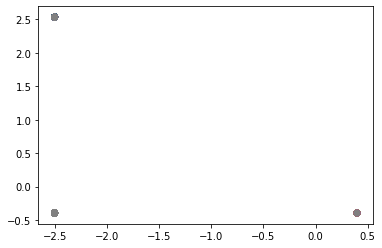

In [140]:
# Plot clusters
plt.scatter(track1_darray[:,0], track1_darray[:,1], c=vectorizer(hd_labels))

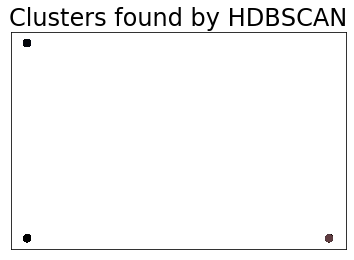

In [141]:
def plot_clusters(data, labels, args, kwds):
    labels = labels   
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0,0.0,0.0) for x in labels]
    plot_kwds={'alpha':0.25, 's':60, 'linewidths':0}
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by HDBSCAN', fontsize=24)

    
plot_clusters(track1_darray, hd_labels, (), {'n_clusters':12}) 

In [ ]:
# Hm, it looks like there may be too many points to view properly? 
#I'll take a random sample & see if it plots better

# data_tup_list = []
# label_tup_list = []

# for index1, val in enumerate(track1_darray.compute()):
#     data_tup = (val, index1)
#     data_tup_list.append(data_tup)

# for index2, label in enumerate(hd_labels):
#     label_tup = (label, index2)
#     label_tup_list.append(label_tup)


In [ ]:
# print(data_tup_list[0:10])
# print(label_tup_list[0:10])

In [ ]:
# Need to maintain context of random sample of track1 data, so this sample can be plotted with correct cluster labels

# 1. create list of the dataset's indices, then randomly sample from that
# 2. loop through the random sample to get each index and save it in a variable
# 3. save the corresponding cluster label indices in another variable 
# 4. append each randomly sampled datapoint (in order of indices) to a list 
# 5. append each corresponding cluster label to its own list (also in same order)
# 6. return the data and its correct label

# data_index_list = np.arange(0, len(track1_darray), 1)
# rsample = np.random.choice(data_index_list, 500, replace=False)
 
# plotting_data = []
# plotting_data_labels = []

# for index in rsample:
#     data = track1_darray[index].compute()
#     label = hd_labels[index]
#     plotting_data.append(data)
#     plotting_data_labels.append(label)
#     print(label, data)


In [ ]:
# print(plotting_data)
# print(plotting_data_labels)

In [ ]:
# # plotting_data is currently multiple arrays; we need to make it one
# plotting_data_array = np.array(plotting_data)
# plotting_data_array

In [ ]:
# Now plot the random sample using the vectorizer 
# plt.figure(figsize=(15, 10))
# plt.scatter(plotting_data_array[:,0], plotting_data_array[:,1], c=vectorizer(plotting_data_labels))

Okay, now that we've got our solution for the track 1 dataset, we'll repeat this clustering solution on the track 10 and track 20 datasets. However, it will be a lot faster this time, since we already know (more or less) the best parameters to use.

In [142]:
# we'll just do track10 now

# Turn the df into an array
track10_array = np.array(Xclusters_track10_dummies.values)

In [143]:
# Standardize track10
scaler = StandardScaler()
track10_array_std = scaler.fit_transform(track10_array)

In [144]:
# Check out the new array
track10_array_std

array([[ 0.15065076, -0.1426359 , -0.04751568, ..., -0.65918319,
        -0.02265489,  0.65061302],
       [ 0.15065076, -0.1426359 , -0.04751568, ..., -0.65918319,
        -0.02265489,  0.65061302],
       [ 0.15065076, -0.1426359 , -0.04751568, ..., -0.65918319,
        -0.02265489,  0.65061302],
       ...,
       [ 0.15065076, -0.1426359 , -0.04751568, ..., -0.65918319,
        -0.02265489, -1.53701197],
       [ 0.15065076, -0.1426359 , -0.04751568, ..., -0.65918319,
        -0.02265489,  0.65061302],
       [ 0.15065076, -0.1426359 , -0.04751568, ..., -0.65918319,
        -0.02265489,  0.65061302]])

In [145]:
# Make it a dask array to clusters run faster
track10_darray = da.from_array(track10_array_std, chunks=(10000,10000))

In [ ]:
# Alright, let's try with the params that gave us our 11 cluster solution on track1:
# hd_clusters = hdbscan.HDBSCAN(min_samples=1200, min_cluster_size=1600, metric='manhattan')

In [ ]:
# hd_preds = hd_clusters.fit_predict(track10_darray)

In [ ]:
# # Cluster labels for track10 manhattan + min_samples 1200 + min_clust_size 1600
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

Okay, this gives us 14. Suppose we make it a bit smaller.

In [ ]:
# hd_clusters = hdbscan.HDBSCAN(min_samples=1250, min_cluster_size=1650, metric='manhattan')

In [ ]:
# hd_preds = hd_clusters.fit_predict(track10_darray)

In [ ]:
# # Cluster labels for track10 manhattan + min_samples 1250 + min_clust_size 1650
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# Continue trying to make fewer clusters
# hd_clusters = hdbscan.HDBSCAN(min_samples=1350, min_cluster_size=1650, metric='manhattan')

In [ ]:
# hd_preds = hd_clusters.fit_predict(track10_darray)

In [ ]:
# # Cluster labels for track10 manhattan + min_samples 1350 + min_clust_size 1650
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# hd_clusters = hdbscan.HDBSCAN(min_samples=1375, min_cluster_size=1675)

In [ ]:
# hd_preds = hd_clusters.fit_predict(track10_darray)

In [ ]:
# # Cluster labels for track10 manhattan + min_samples 1375 + min_clust_size 1675
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [ ]:
# hd_clusters = hdbscan.HDBSCAN(min_samples=1300, min_cluster_size=1650)

In [ ]:
# hd_preds = hd_clusters.fit_predict(track10_darray)

In [ ]:
# # Cluster labels for track10 manhattan + min_samples 1300 + min_clust_size 1650
# hd_labels = hd_clusters.labels_
# print(hd_labels)

# # How many clusters are there?
# hd_labels.max()

In [165]:
track10_hd_clusters = hdbscan.HDBSCAN(min_samples=1650, min_cluster_size=1750)

In [166]:
track10_hd_preds = track10_hd_clusters.fit_predict(track10_darray)

In [167]:
# Cluster labels for track10 manhattan + min_samples 1400 + min_clust_size 1650
track10_hd_labels = track10_hd_clusters.labels_
print(track10_hd_labels)

# How many clusters are there?
track10_hd_labels.max()

[-1  9  3 ... -1  4  7]


11

Great, I got a 12 cluster solution here too.

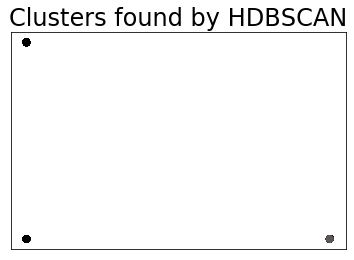

In [168]:
# Okay how about we visualize the track10 clusters

plot_clusters(track10_darray, track10_hd_labels, (), {'n_clusters':12}) 

In [169]:
# Make track20 dataset into array
track20_array = np.array(Xclusters_track20_dummies.values)

In [170]:
# Standardize the track20 array
scaler = StandardScaler()
track20_array_std = scaler.fit_transform(track20_array)

In [171]:
track20_array_std

array([[ 0.14509897, -0.13796644, -0.04409283, ..., -0.69409326,
        -0.0231424 ,  0.70895871],
       [ 0.14509897, -0.13796644, -0.04409283, ...,  1.44072858,
        -0.0231424 , -1.41051938],
       [ 0.14509897, -0.13796644, -0.04409283, ..., -0.69409326,
        -0.0231424 ,  0.70895871],
       ...,
       [ 0.14509897, -0.13796644, -0.04409283, ...,  1.44072858,
        -0.0231424 , -1.41051938],
       [ 0.14509897, -0.13796644, -0.04409283, ...,  1.44072858,
        -0.0231424 , -1.41051938],
       [ 0.14509897, -0.13796644, -0.04409283, ...,  1.44072858,
        -0.0231424 ,  0.70895871]])

In [172]:
# Make it a dask array to clusters run faster
track20_darray = da.from_array(track20_array_std, chunks=(10000,10000))

In [173]:
# Now let's try with track20

track20_hdbscan = hdbscan.HDBSCAN(min_samples=1600, min_cluster_size=1700)
track20_preds = track20_hdbscan.fit_predict(track20_darray)
track20_hd_labels = track20_hdbscan.labels_

#How many clusters are there?
track20_hd_labels.max()

11

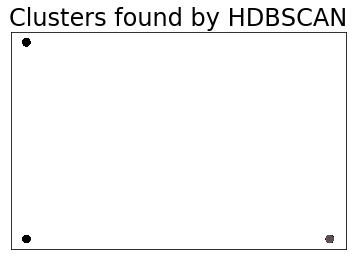

In [174]:
# Okay how about we visualize the track20 clusters

plot_clusters(track20_darray, track20_hd_labels, (), {'n_clusters':12}) 

Okay well the cluster plots all look the same, which was to be expected, since they all contain very similar data.

The next thing to do is run a multivariate linear regression so we can look at the coefficients for each of the clusters and determine which are most influential. Then we'll also do some barplots and such and see how the clusters play out across different variables.

In [ ]:
# We'll use train test split to divide up dataset just for these cluster regressions

# First is the track1 clusters 
X = track1_darray
y = track1_hd_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=60)

In [ ]:
cluster_clf1 = LogisticRegression(multi_class ='multinomial', solver ='newton-cg')
cluster_clf1_fit = cluster_clf1.fit(X_train, y_train)

In [ ]:
y_pred = cluster_clf1_fit.predict(X_test)

In [ ]:
# Now a confusion matrix for the track1 clusters' logistic regression
cm1 = confusion_matrix(y_test, y_pred)
print(cm1)

In [ ]:
print(cluster_clf1_fit.coef_)
print(cluster_clf1_fit.classes_)

In [ ]:
# def test(df, labels):
#     scaler = StandardScaler()
#     x1 = scaler.fit_transform(df)
#     y1 = labels
#     X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=.2, random_state=60)
#     cluster_clf1 = LogisticRegression(multi_class ='multinomial', solver ='newton-cg')
#     cluster_clf1_fit = cluster_clf1.fit(X1_train, y1_train)
#     y1_pred = cluster_clf1_fit.predict(X1_test)
#     cm1 = confusion_matrix(y1_test, y1_pred)
#     print("----- Confusion Matrix -----")
#     print(cm1)
#     print(" ")
#     print(" ")
    
#     print("----- Cluster Coefficients -----")
#     print(cluster_clf1_fit.coef_)
#     print(" ")
#     print(" ")
    
#     print("----- Cluster Classes -----")
#     print(cluster_clf1_fit.classes_)
#     print(" ")
#     print(" ")
    
#     print("----- Coefficients with Column Names -----")
#     #Okay, let's look at these coeffs in an easier to interpret format
#     for cluster in range(len(cluster_clf1_fit.coef_)):
#         print('For cluster {}: '.format(cluster-1))
#         for coef in range(len(cluster_clf1_fit.coef_[cluster])):
#             print('   ', Xclusters_track1_dummies.columns[coef], '=', cluster_clf1_fit.coef_[cluster][coef])
#     print(" ")
#     print(" ")
    
#     print("----- Maximum Positive Coefficient -----")        
#     #  I want to see the maximum coefs for each cluster along with corresponding column names:
#     for cluster in range(len(cluster_clf1_fit.coef_)):
#         max_seen = float("-inf")
#         column_name = None
#         for index, coef in enumerate(cluster_clf1_fit.coef_[cluster]):
#             if coef <= max_seen: continue 
#             column_name = Xclusters_track1_dummies.columns[index]
#             max_seen = coef
#         print('Cluster {} Max Coef: '.format(cluster-1), max_seen, column_name)
#     print(" ")
#     print(" ")
    
#     print("----- Maximum Absolute Value Coefficient -----")           
#     # Print out absolute value maximum coefficients (whether pos or neg)
#     for cluster in range(len(cluster_clf1_fit.coef_)):
#         max_seen = 0
#         column_name = None
#         for index, coef in enumerate(cluster_clf1_fit.coef_[cluster]):
#             abs_coef = abs(coef)
#             if abs_coef <= abs(max_seen): continue 
#             column_name = Xclusters_track1_dummies.columns[index]
#             max_seen = coef
#         print('Cluster {} Max Coef: '.format(cluster-1), max_seen, column_name)
#     print(" ")
#     print(" ")
     
#     print("----- Maximum Negative Coefficient -----")        
#     # Print out minimum coefficients (which in this case actually means they are the strongest negative ones)
#     for cluster in range(len(cluster_clf1_fit.coef_)):
#         min_seen = float("inf")
#         column_name = None
#         for index, coef in enumerate(cluster_clf1_fit.coef_[cluster]):
#             if coef >= min_seen: continue 
#             column_name = Xclusters_track1_dummies.columns[index]
#             min_seen = coef
#         print('Cluster {} Max Coef: '.format(cluster-1), min_seen, column_name)
#     print(" ")
#     print(" ")
     
#     t1_odds = np.exp(cluster_clf1_fit.coef_)
#     t1_odds
    
#     print("----- Max Odds Ratios by Column -----")        
#     # I want to print out the maximum odds ratios for each column:
#     for cluster in range(len(t1_odds)):
#         max_seen = float("-inf")
#         column_name = None
#         for index, oratio in enumerate(t1_odds[cluster]):
#             if oratio <= max_seen: continue 
#             column_name = Xclusters_track1_dummies.columns[index]
#             max_seen = oratio
#         print('Cluster {} Max Odds Ratio: '.format(cluster-1), max_seen, column_name)
#     print(" ")
#     print(" ")
    

# test(Xclusters_track1_dummies, track1_hd_labels)

In [175]:
#Okay, actually I think I want to do this regression with the df, not the array

# First is the track1 clusters - we need to standardize the df first

scaler = StandardScaler()
X1 = scaler.fit_transform(Xclusters_track1_dummies)
y1 = track1_hd_labels

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=.2, random_state=60)

In [176]:
cluster_clf1 = LogisticRegression(multi_class ='multinomial', solver ='newton-cg')
cluster_clf1_fit = cluster_clf1.fit(X1_train, y1_train)

In [177]:
y1_pred = cluster_clf1_fit.predict(X1_test)

In [178]:
# Now a confusion matrix for the track1 clusters' logistic regression
cm1 = confusion_matrix(y1_test, y1_pred)
print(cm1)

[[8857   44   74  165    0    0    0    0    0    0    0    3    0]
 [   3  535    0    0    0    0    0    0    0    0    0    0    0]
 [  31    0 1291    0    0    0    0    0    0    0    0    0    0]
 [  87    0    0 1194    0    0    0    0    0    0    0    0    0]
 [  15    0    0    0  857    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  947    0    0    0    0    0    0    0]
 [   3    0    0    0    0    0  553    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0  517    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0  709    0    0    0    0]
 [   6    0    0    0    0    0    0    0    0  410    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0  418    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0  777    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  438]]


In [179]:
# Look at coefficients for each cluster class. The cluster classes themselves are also shown at the bottom
print(cluster_clf1_fit.coef_)
print(cluster_clf1_fit.classes_)

[[-2.20425391e+00  2.15557995e+00  4.45055682e-01 -2.77876389e+00
   2.62638420e+00  8.39606970e-01 -4.79999836e-09 -8.34333322e-08
   8.40894561e-07 -4.64387897e-08  5.91850201e-02  2.85446158e-01
  -2.74309904e-01 -8.08760127e-08 -8.34333322e-08 -8.34333323e-08
  -3.00125723e+00  3.49571630e+00  2.77743191e+00 -1.14645659e+00
   8.54920871e-01  8.92665843e-01 -8.01283292e-02  1.59039328e+00
  -4.46129646e+00  3.76071981e-01  1.40124227e+00  1.15166503e+00
   1.44233632e+00  1.38207603e+00 -2.87999993e+00  1.04003774e+00
   1.98173202e+00 -3.85191919e-01  2.30001051e-01 -6.41534823e-02
   9.07186363e-01  3.55493519e-02  3.51373379e-01 -1.57781595e+00
   2.15808517e-01 -1.81343385e-01]
 [-3.83355765e+00  3.88755171e+00 -1.52248181e-01  5.37183635e-01
  -5.63661717e-01 -3.95549449e-06 -9.71792097e-09 -7.62491681e-09
  -9.72089225e-09 -1.37447579e-08 -2.12084180e-08 -5.44389459e-03
   4.92790992e-03 -1.37430373e-08 -7.62491681e-09 -7.62491673e-09
   1.67723986e+00 -4.88518130e-01  1.9630

In [180]:
#Okay, let's look at these coeffs in an easier to interpret format

for cluster in range(len(cluster_clf1_fit.coef_)):
    print('For cluster {}: '.format(cluster-1))
    for coef in range(len(cluster_clf1_fit.coef_[cluster])):
        print('   ', Xclusters_track1_dummies.columns[coef], '=', cluster_clf1_fit.coef_[cluster][coef])
        

For cluster -1: 
    no_seekfwd = -2.204253907035349
    seekfwd_1to2 = 2.1555799453071054
    seekfwd_3+ = 0.4450556818166545
    no_seekback = -2.7787638927785148
    seekback_1to2 = 2.6263841973674684
    seekback_3+ = 0.8396069699701031
    jan = -4.799998357470439e-09
    feb = -8.343333223554093e-08
    march = 8.408945611621782e-07
    april = -4.6438789672256684e-08
    may = 0.05918502005615998
    june = 0.28544615773780857
    july = -0.27430990352684975
    aug = -8.087601267924023e-08
    sept = -8.343333223554093e-08
    nov = -8.343333226038769e-08
    afternoon = -3.0012572253484673
    early_morn = 3.4957163007254257
    morning = 2.7774319135650734
    night = -1.1464565935978526
    skip_v_soon = 0.8549208706871164
    skip_fairly_soon = 0.8926658433805178
    paused_before_play = -0.0801283292293276
    on_shuffle = 1.5903932763327822
    premium = -4.461296459773009
    context_catalog = 0.37607198099669026
    context_charts = 1.4012422668040043
    context_editor

    context_catalog = 3.511221238360693
    context_charts = -0.08279743723260768
    context_editorial_playlist = -0.6898570630793822
    context_personal_playlist = -0.09089645743618108
    context_radio = -0.5325051129272605
    context_user_collec = -2.0495998797288872
    appload = -0.6708272585780545
    start_backbutton = -0.054975676711015206
    start_clickrow = -0.06258023630977515
    start_endplay = -0.02851803000560305
    start_fwdbutton = -2.6588280013669494
    start_playbutton = -0.03309515242232606
    popup = -0.01342993393247791
    start_remote = -0.0971319637407505
    start_trackdone = 3.322576235031817
    start_uriopen = -0.016703549565172473
    skipped = -0.862258209810536
For cluster 6: 
    no_seekfwd = 0.38787947785414906
    seekfwd_1to2 = -0.3910171705623952
    seekfwd_3+ = -0.00013135217373673653
    no_seekback = 0.13829920875032614
    seekback_1to2 = -0.13392892333160325
    seekback_3+ = -0.03246231776570323
    jan = 9.89205948666699e-10
    feb =

In [181]:
#  I want to see the maximum coefs for each cluster along with corresponding column names:
for cluster in range(len(cluster_clf1_fit.coef_)):
    max_seen = float("-inf")
    column_name = None
    for index, coef in enumerate(cluster_clf1_fit.coef_[cluster]):
        if coef <= max_seen: continue 
        column_name = Xclusters_track1_dummies.columns[index]
        max_seen = coef
    print('Cluster {} Max Coef: '.format(cluster-1), max_seen, column_name)

Cluster -1 Max Coef:  3.4957163007254257 early_morn
Cluster 0 Max Coef:  8.874480360032532 skipped
Cluster 1 Max Coef:  6.086617482961179 context_radio
Cluster 2 Max Coef:  6.362779540478222 morning
Cluster 3 Max Coef:  5.854509992383828 start_clickrow
Cluster 4 Max Coef:  6.906085841457962 start_clickrow
Cluster 5 Max Coef:  3.511221238360693 context_catalog
Cluster 6 Max Coef:  3.7599319702287204 start_trackdone
Cluster 7 Max Coef:  4.3713143979581925 start_trackdone
Cluster 8 Max Coef:  3.650087182374551 start_trackdone
Cluster 9 Max Coef:  5.574351017908468 start_fwdbutton
Cluster 10 Max Coef:  6.558382857115833 start_fwdbutton
Cluster 11 Max Coef:  5.127312990225058 start_fwdbutton


In [182]:
# Print out absolute value maximum coefficients (whether pos or neg)
for cluster in range(len(cluster_clf1_fit.coef_)):
    max_seen = 0
    column_name = None
    for index, coef in enumerate(cluster_clf1_fit.coef_[cluster]):
        abs_coef = abs(coef)
        if abs_coef <= abs(max_seen): continue 
        column_name = Xclusters_track1_dummies.columns[index]
        max_seen = coef
    print('Cluster {} Max Coef: '.format(cluster-1), max_seen, column_name)

Cluster -1 Max Coef:  -4.461296459773009 premium
Cluster 0 Max Coef:  8.874480360032532 skipped
Cluster 1 Max Coef:  6.086617482961179 context_radio
Cluster 2 Max Coef:  6.362779540478222 morning
Cluster 3 Max Coef:  5.854509992383828 start_clickrow
Cluster 4 Max Coef:  6.906085841457962 start_clickrow
Cluster 5 Max Coef:  3.511221238360693 context_catalog
Cluster 6 Max Coef:  3.7599319702287204 start_trackdone
Cluster 7 Max Coef:  -4.844908805406761 skip_v_soon
Cluster 8 Max Coef:  3.650087182374551 start_trackdone
Cluster 9 Max Coef:  5.574351017908468 start_fwdbutton
Cluster 10 Max Coef:  6.558382857115833 start_fwdbutton
Cluster 11 Max Coef:  5.127312990225058 start_fwdbutton


In [183]:
# Print out minimum coefficients (which in this case actually means they are the strongest negative ones)
for cluster in range(len(cluster_clf1_fit.coef_)):
    min_seen = float("inf")
    column_name = None
    for index, coef in enumerate(cluster_clf1_fit.coef_[cluster]):
        if coef >= min_seen: continue 
        column_name = Xclusters_track1_dummies.columns[index]
        min_seen = coef
    print('Cluster {} Max Coef: '.format(cluster-1), min_seen, column_name)

Cluster -1 Max Coef:  -4.461296459773009 premium
Cluster 0 Max Coef:  -3.8335576454842575 no_seekfwd
Cluster 1 Max Coef:  -3.2794606913603355 context_user_collec
Cluster 2 Max Coef:  -3.3278750135274304 afternoon
Cluster 3 Max Coef:  -3.4311875893212327 start_fwdbutton
Cluster 4 Max Coef:  -4.731427989231549 start_fwdbutton
Cluster 5 Max Coef:  -2.828626757862659 skip_v_soon
Cluster 6 Max Coef:  -3.5727484172256334 skip_fairly_soon
Cluster 7 Max Coef:  -4.844908805406761 skip_v_soon
Cluster 8 Max Coef:  -2.5223949143940727 start_clickrow
Cluster 9 Max Coef:  -2.846860582313596 start_trackdone
Cluster 10 Max Coef:  -3.477902794654364 skipped
Cluster 11 Max Coef:  -2.850402776224033 start_trackdone


In [184]:
# Now we'll get the odds ratios for track1:

t1_odds = np.exp(cluster_clf1_fit.coef_)
t1_odds

array([[1.10332813e-01, 8.63289533e+00, 1.56057709e+00, 6.21152410e-02,
        1.38236957e+01, 2.31545675e+00, 9.99999995e-01, 9.99999917e-01,
        1.00000084e+00, 9.99999954e-01, 1.06097152e+00, 1.33035544e+00,
        7.60096482e-01, 9.99999919e-01, 9.99999917e-01, 9.99999917e-01,
        4.97245141e-02, 3.29738987e+01, 1.60776790e+01, 3.17760732e-01,
        2.35118833e+00, 2.44162999e+00, 9.22997891e-01, 4.90567784e+00,
        1.15473829e-02, 1.45655197e+00, 4.06024074e+00, 3.16345577e+00,
        4.23056822e+00, 3.98316222e+00, 5.61347670e-02, 2.82932378e+00,
        7.25529846e+00, 6.80320057e-01, 1.25860133e+00, 9.37861043e-01,
        2.47734238e+00, 1.03618878e+00, 1.42101781e+00, 2.06425451e-01,
        1.24086475e+00, 8.34148875e-01],
       [2.16325177e-02, 4.87912850e+01, 8.58775123e-01, 1.71118076e+00,
        5.69121282e-01, 9.99996045e-01, 9.99999990e-01, 9.99999992e-01,
        9.99999990e-01, 9.99999986e-01, 9.99999979e-01, 9.94570897e-01,
        1.00494007e+00,

In [185]:
# I want to print out the maximum odds ratios for each column:
for cluster in range(len(t1_odds)):
    max_seen = float("-inf")
    column_name = None
    for index, oratio in enumerate(t1_odds[cluster]):
        if oratio <= max_seen: continue 
        column_name = Xclusters_track1_dummies.columns[index]
        max_seen = oratio
    print('Cluster {} Max Odds Ratio: '.format(cluster-1), max_seen, column_name)

Cluster -1 Max Odds Ratio:  32.97389872336477 early_morn
Cluster 0 Max Odds Ratio:  7147.231515181011 skipped
Cluster 1 Max Odds Ratio:  439.93081810086386 context_radio
Cluster 2 Max Odds Ratio:  579.8558513396574 morning
Cluster 3 Max Odds Ratio:  348.8039415840029 start_clickrow
Cluster 4 Max Odds Ratio:  998.3319552115123 start_clickrow
Cluster 5 Max Odds Ratio:  33.48914104457835 context_catalog
Cluster 6 Max Odds Ratio:  42.945504306548344 start_trackdone
Cluster 7 Max Odds Ratio:  79.1475947971525 start_trackdone
Cluster 8 Max Odds Ratio:  38.478020508001066 start_trackdone
Cluster 9 Max Odds Ratio:  263.5784424293904 start_fwdbutton
Cluster 10 Max Odds Ratio:  705.1304753561539 start_fwdbutton
Cluster 11 Max Odds Ratio:  168.56357700405445 start_fwdbutton


In [186]:
# Now we'll run a logistic regression on the clusters for track10

scaler = StandardScaler()
X10 = scaler.fit_transform(Xclusters_track10_dummies)
y10 = track10_hd_labels


X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10, test_size=.2, random_state=60)

In [188]:
cluster_clf2 = LogisticRegression(multi_class ='multinomial', solver ='newton-cg')
cluster_clf2_fit = cluster_clf2.fit(X10_train, y10_train)

In [189]:
y10_pred = cluster_clf2_fit.predict(X10_test)

In [190]:
# Now a confusion matrix for the track1 clusters' logistic regression
cm2 = confusion_matrix(y10_test, y10_pred)
print(cm2)

[[8320    4   22   85    8  127    0    2    0    0    0    0    0]
 [  13  629    0    0    0    0    0    0    0    0    0    0    0]
 [  11    0  546    0    0    0    0    0    0    0    0    0    0]
 [  63    0    0 1472    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0  856    0    0    0    0    0    0    0    0]
 [  37    0    0    0    0 1144    0    0    0    0    0    0    0]
 [   7    0    0    0    0    0  360    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0  762    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0  381    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0  835    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0 1041    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0  448    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  762]]


In [191]:
print(cluster_clf2_fit.coef_)
print(cluster_clf2_fit.classes_)

[[-1.28792278e+00  1.30580224e+00  1.51453667e-01 -1.30548216e+00
   1.30237101e+00  1.85795072e-01  7.58528182e-05  9.70568292e-07
   7.10622122e-07  2.43006720e-02  6.43680489e-02  2.82002999e-01
  -2.78830818e-01  8.30231006e-05  2.22942260e-02  7.19570216e-07
  -1.49351002e+00  1.80388597e+00  1.95660816e+00 -1.08107191e+00
  -2.61994125e+00 -1.10642364e+00  1.32810470e+00  4.57016435e+00
   1.33909774e+00 -4.03652263e+00  1.33978136e+00  1.44458543e+00
  -8.08975750e-01  1.43099073e+00  1.55108199e+00 -2.25741701e+00
   4.05103414e-01  1.42549336e+00  2.69609888e+00  3.00112474e-06
  -2.31914666e+00  1.87643101e-02  1.03050854e-01  3.38999163e-02
   2.23053796e-01 -9.26065019e-01]
 [ 2.21403097e-01 -2.33304415e-01 -6.06770510e-06  3.18653102e-01
  -2.79360230e-01 -1.80828172e-01 -3.20187557e-08 -6.09448406e-08
   2.16201283e-08 -6.07769750e-08 -1.07221493e-06 -7.73444325e-02
   7.24615634e-02 -6.87800198e-08 -2.22912047e-02 -5.39091023e-08
   1.41809089e+00 -2.68243295e+00 -5.7019

In [192]:
#Okay, let's look at these coeffs in an easier to interpret format

for cluster in range(len(cluster_clf2_fit.coef_)):
    print('For cluster {}: '.format(cluster-1))
    for coef in range(len(cluster_clf2_fit.coef_[cluster])):
        print('   ', Xclusters_track10_dummies.columns[coef], '=', cluster_clf2_fit.coef_[cluster][coef])
        

For cluster -1: 
    no_seekfwd = -1.2879227791900838
    seekfwd_1to2 = 1.3058022360455175
    seekfwd_3+ = 0.15145366697075263
    no_seekback = -1.3054821609383327
    seekback_1to2 = 1.3023710130751391
    seekback_3+ = 0.18579507242674492
    jan = 7.585281824979395e-05
    feb = 9.705682915040404e-07
    march = 7.106221216148846e-07
    april = 0.02430067197386267
    may = 0.06436804886455558
    june = 0.28200299921946365
    july = -0.27883081776599483
    aug = 8.302310060556653e-05
    sept = 0.022294226028127497
    nov = 7.195702159351649e-07
    afternoon = -1.4935100162731119
    early_morn = 1.8038859745416926
    morning = 1.956608161747699
    night = -1.081071913818957
    skip_v_soon = -2.6199412511927695
    skip_fairly_soon = -1.1064236359897635
    switched_context = 1.3281047048236971
    paused_before_play = 4.570164351476462
    on_shuffle = 1.3390977416449612
    premium = -4.036522627461009
    context_catalog = 1.3397813613978486
    context_charts = 1.444

    no_seekfwd = 4.1687086901929265e-06
    seekfwd_1to2 = -4.226390876240314e-06
    seekfwd_3+ = -4.907792922196444e-07
    no_seekback = 0.28568499005624926
    seekback_1to2 = -0.29655304643316266
    seekback_3+ = -5.434727238982601e-05
    jan = -3.6490538332457015e-08
    feb = -4.402000083225248e-08
    march = 3.769451821720645e-08
    april = -5.4045693018529777e-08
    may = -0.015303566799402793
    june = -0.07541844394400223
    july = 0.07238631888672774
    aug = -6.358776587220877e-08
    sept = -2.4242441939497523e-08
    nov = 1.8729645693668466e-09
    afternoon = 2.671597605941651
    early_morn = -1.3386728500335099
    morning = -3.425042959789715
    night = 0.7510283804076483
    skip_v_soon = -2.250442657110593
    skip_fairly_soon = -4.201225315871483
    switched_context = -1.1856238446058756
    paused_before_play = -0.7496913593620561
    on_shuffle = -2.7259613932622635
    premium = -0.6272296867152265
    context_catalog = -1.8173155683299445
    contex

In [193]:
#  I want to see the maximum coefs for each cluster along with corresponding column names:
for cluster in range(len(cluster_clf2_fit.coef_)):
    max_seen = float("-inf")
    column_name = None
    for index, coef in enumerate(cluster_clf2_fit.coef_[cluster]):
        if coef <= max_seen: continue 
        column_name = Xclusters_track10_dummies.columns[index]
        max_seen = coef
    print('Cluster {} Max Coef: '.format(cluster-1), max_seen, column_name)

Cluster -1 Max Coef:  4.570164351476462 paused_before_play
Cluster 0 Max Coef:  6.2470112884617865 start_backbutton
Cluster 1 Max Coef:  5.884638860411294 early_morn
Cluster 2 Max Coef:  5.594127565963795 context_radio
Cluster 3 Max Coef:  6.5924438283477516 morning
Cluster 4 Max Coef:  4.81578055545517 context_catalog
Cluster 5 Max Coef:  4.52038818907638 start_trackdone
Cluster 6 Max Coef:  4.8496541730062255 context_editorial_playlist
Cluster 7 Max Coef:  4.082451588346475 context_editorial_playlist
Cluster 8 Max Coef:  6.717280026946044 start_trackdone
Cluster 9 Max Coef:  3.6398401845428356 skipped
Cluster 10 Max Coef:  3.376017484861252 skip_fairly_soon
Cluster 11 Max Coef:  4.332825642038843 on_shuffle


In [194]:
# Print out absolute value maximum coefficients (whether pos or neg)
for cluster in range(len(cluster_clf2_fit.coef_)):
    max_seen = 0
    column_name = None
    for index, coef in enumerate(cluster_clf2_fit.coef_[cluster]):
        abs_coef = abs(coef)
        if abs_coef <= abs(max_seen): continue 
        column_name = Xclusters_track10_dummies.columns[index]
        max_seen = coef
    print('Cluster {} Max Coef: '.format(cluster-1), max_seen, column_name)

Cluster -1 Max Coef:  4.570164351476462 paused_before_play
Cluster 0 Max Coef:  6.2470112884617865 start_backbutton
Cluster 1 Max Coef:  5.884638860411294 early_morn
Cluster 2 Max Coef:  5.594127565963795 context_radio
Cluster 3 Max Coef:  6.5924438283477516 morning
Cluster 4 Max Coef:  4.81578055545517 context_catalog
Cluster 5 Max Coef:  -7.32047093865315 skipped
Cluster 6 Max Coef:  4.8496541730062255 context_editorial_playlist
Cluster 7 Max Coef:  4.082451588346475 context_editorial_playlist
Cluster 8 Max Coef:  -7.465628239775639 skipped
Cluster 9 Max Coef:  3.6398401845428356 skipped
Cluster 10 Max Coef:  3.376017484861252 skip_fairly_soon
Cluster 11 Max Coef:  4.332825642038843 on_shuffle


In [195]:
# Print out minimum coefficients (which in this case actually means they are the strongest negative ones)
for cluster in range(len(cluster_clf2_fit.coef_)):
    min_seen = float("inf")
    column_name = None
    for index, coef in enumerate(cluster_clf2_fit.coef_[cluster]):
        if coef >= min_seen: continue 
        column_name = Xclusters_track10_dummies.columns[index]
        min_seen = coef
    print('Cluster {} Max Coef: '.format(cluster-1), min_seen, column_name)

Cluster -1 Max Coef:  -4.036522627461009 premium
Cluster 0 Max Coef:  -3.155741378508115 context_radio
Cluster 1 Max Coef:  -1.879218552467097 start_backbutton
Cluster 2 Max Coef:  -2.911337953017099 context_user_collec
Cluster 3 Max Coef:  -3.5016738233869438 afternoon
Cluster 4 Max Coef:  -2.82258196405585 context_user_collec
Cluster 5 Max Coef:  -7.32047093865315 skipped
Cluster 6 Max Coef:  -3.2000952031198264 start_trackdone
Cluster 7 Max Coef:  -3.0879800587110333 paused_before_play
Cluster 8 Max Coef:  -7.465628239775639 skipped
Cluster 9 Max Coef:  -3.2150957566142377 afternoon
Cluster 10 Max Coef:  -2.455920603524352 on_shuffle
Cluster 11 Max Coef:  -1.687334389068791 start_trackdone


In [196]:
# Now we'll get the odds ratios for track10

t10_odds = np.exp(cluster_clf2_fit.coef_)
t10_odds

array([[2.75843176e-01, 3.69064868e+00, 1.16352439e+00, 2.71041818e-01,
        3.67800694e+00, 1.20417547e+00, 1.00007586e+00, 1.00000097e+00,
        1.00000071e+00, 1.02459834e+00, 1.06648485e+00, 1.32578270e+00,
        7.56667907e-01, 1.00008303e+00, 1.02254460e+00, 1.00000072e+00,
        2.24582981e-01, 6.07320198e+00, 7.07528809e+00, 3.39231704e-01,
        7.28071400e-02, 3.30739694e-01, 3.77388398e+00, 9.65599782e+01,
        3.81559930e+00, 1.76587719e-02, 3.81820861e+00, 4.24009398e+00,
        4.45313946e-01, 4.18284119e+00, 4.71657073e+00, 1.04620369e-01,
        1.49945756e+00, 4.15990968e+00, 1.48217972e+01, 1.00000300e+00,
        9.83574823e-02, 1.01894147e+00, 1.10854778e+00, 1.03448107e+00,
        1.24988781e+00, 3.96109331e-01],
       [1.24782632e+00, 7.91912467e-01, 9.99993932e-01, 1.37527416e+00,
        7.56267424e-01, 8.34578751e-01, 9.99999968e-01, 9.99999939e-01,
        1.00000002e+00, 9.99999939e-01, 9.99998928e-01, 9.25571002e-01,
        1.07515148e+00,

In [197]:
# I want to print out the maximum odds ratios for each column:
for cluster in range(len(t10_odds)):
    max_seen = float("-inf")
    column_name = None
    for index, oratio in enumerate(t10_odds[cluster]):
        if oratio <= max_seen: continue 
        column_name = Xclusters_track10_dummies.columns[index]
        max_seen = oratio
    print('Cluster {} Max Odds Ratio: '.format(cluster-1), max_seen, column_name)

Cluster -1 Max Odds Ratio:  96.55997824379715 paused_before_play
Cluster 0 Max Odds Ratio:  516.4669450072039 start_backbutton
Cluster 1 Max Odds Ratio:  359.47292464807083 early_morn
Cluster 2 Max Odds Ratio:  268.8429999652062 context_radio
Cluster 3 Max Odds Ratio:  729.5616164528308 morning
Cluster 4 Max Odds Ratio:  123.44312892274353 context_catalog
Cluster 5 Max Odds Ratio:  91.87125447439813 start_trackdone
Cluster 6 Max Odds Ratio:  127.69622140878396 context_editorial_playlist
Cluster 7 Max Odds Ratio:  59.29064808042859 context_editorial_playlist
Cluster 8 Max Odds Ratio:  826.566213306752 start_trackdone
Cluster 9 Max Odds Ratio:  38.08574954752403 skipped
Cluster 10 Max Odds Ratio:  29.25403418028695 skip_fairly_soon
Cluster 11 Max Odds Ratio:  76.15918140288397 on_shuffle


In [198]:
# Now we'll run a logistic regression on the clusters for track20
scaler = StandardScaler()
X20 = scaler.fit_transform(Xclusters_track20_dummies)
y20 = track20_hd_labels

X20_train, X20_test, y20_train, y20_test = train_test_split(X20, y20, test_size=.2, random_state=60)

In [199]:
cluster_clf3 = LogisticRegression(multi_class ='multinomial', solver ='newton-cg')
cluster_clf3_fit = cluster_clf3.fit(X20_train, y20_train)

In [200]:
y20_pred = cluster_clf3_fit.predict(X20_test)

In [201]:
# Now a confusion matrix for the track1 clusters' logistic regression
cm3 = confusion_matrix(y20_test, y20_pred)
print(cm3)

[[8841   15   28    0    2    0  100  125    0   77    0    0    0]
 [  17  565    0    0    0    0    0    0    0    0    0    0    0]
 [  16    0  611    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0  346    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0  815    0    0    0    0    0    0    0    0]
 [   3    0    0    0    0  723    0    0    0    0    0    0    0]
 [  52    0    0    0    0    0 1045    0    0    0    0    0    0]
 [  37    0    0    0    0    0    0 1448    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0  339    0    0    0    0]
 [  27    0    0    0    0    0    0    0    0  949    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0  615    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0  698    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  440]]


In [202]:
print(cluster_clf3_fit.coef_)
print(cluster_clf3_fit.classes_)

[[-1.12267139e+00  1.13483440e+00  1.33956842e-01 -1.17216525e+00
   1.13550215e+00  2.85683083e-01  2.15189854e-08  4.84635075e-08
   6.65300919e-04  3.86052684e-08  3.43749208e-02  2.67706673e-01
  -2.52577930e-01  3.91422045e-08  8.43694735e-03  8.88635394e-08
  -1.74396275e+00  1.24702046e+00  1.62673826e+00 -1.99022245e-01
  -2.12310005e+00 -1.55039424e+00  1.19881455e+00  4.06205705e+00
   1.39953533e+00 -3.65364675e+00  1.03388902e+00  1.36914943e+00
   1.15632872e-01  1.36703754e+00  4.24059255e-01 -1.91834968e+00
   3.42440670e-01  1.29971726e+00  2.92515841e+00  2.14770846e-07
  -2.11603079e+00  5.21599733e-02  1.38670143e-01 -2.07933048e-01
   2.06153178e-01 -3.37912896e-01]
 [ 2.46400493e-01 -2.58626417e-01  1.10722310e-07  6.07322440e-01
  -5.74524837e-01 -1.98361686e-01  8.46945135e-09  6.27633291e-09
   8.45041283e-09  1.03804633e-08  1.91146883e-08 -1.27333595e-01
   1.15264272e-01  1.59877174e-08  8.63337016e-09  8.00974975e-09
   1.77108698e+00 -3.72264357e+00 -8.8260

In [203]:
#Okay, let's look at these coeffs in an easier to interpret format

for cluster in range(len(cluster_clf3_fit.coef_)):
    print('For cluster {}: '.format(cluster-1))
    for coef in range(len(cluster_clf3_fit.coef_[cluster])):
        print('   ', Xclusters_track20_dummies.columns[coef], '=', cluster_clf3_fit.coef_[cluster][coef])

For cluster -1: 
    no_seekfwd = -1.1226713864970412
    seekfwd_1to2 = 1.1348343968417978
    seekfwd_3+ = 0.13395684248036302
    no_seekback = -1.1721652474756896
    seekback_1to2 = 1.1355021472022446
    seekback_3+ = 0.2856830825904272
    jan = 2.1518985427489132e-08
    feb = 4.846350746033521e-08
    march = 0.0006653009194090043
    april = 3.86052684437741e-08
    may = 0.03437492077133566
    june = 0.2677066727529862
    july = -0.25257792962383724
    aug = 3.914220448088005e-08
    sept = 0.008436947351749477
    nov = 8.886353937239262e-08
    afternoon = -1.7439627468741281
    early_morn = 1.247020456897023
    morning = 1.6267382560080406
    night = -0.19902224513883915
    skip_v_soon = -2.1231000496594934
    skip_fairly_soon = -1.550394243062512
    switched_context = 1.1988145535199215
    paused_before_play = 4.062057052170121
    on_shuffle = 1.3995353269465962
    premium = -3.6536467505110246
    context_catalog = 1.0338890229250908
    context_charts = 1.3

    aug = -1.2670381777677015e-08
    sept = -7.981065323233008e-09
    nov = -9.440322281481582e-09
    afternoon = -2.050009617221185
    early_morn = -0.4703073378282832
    morning = -0.39041327609568666
    night = 2.796662717159914
    skip_v_soon = -0.8588655481921491
    skip_fairly_soon = 2.4495467797342507
    switched_context = -0.00015642328626763312
    paused_before_play = -0.8269801738787671
    on_shuffle = 0.9935793699669742
    premium = 1.2708237218717373
    context_catalog = -0.7933077016255665
    context_charts = -0.0027949655522443305
    context_editorial_playlist = 3.3569015456563145
    context_personal_playlist = -0.0019709464181100205
    context_radio = -0.04571670444741905
    context_user_collec = -2.1000907182362267
    appload = -0.023685224092374668
    start_backbutton = -0.19710613234432328
    start_clickrow = -0.0015548240557970115
    start_endplay = -1.3096270952309243e-08
    start_fwdbutton = 1.2668176600781382
    start_playbutton = -1.834695

In [204]:
# I want to print out the actual column names for the max coefficients :
for cluster in range(len(cluster_clf3_fit.coef_)):
    max_seen = float("-inf")
    column_name = None
    for index, coef in enumerate(cluster_clf3_fit.coef_[cluster]):
        if coef <= max_seen: continue 
        column_name = Xclusters_track20_dummies.columns[index]
        max_seen = coef
    print('Cluster {} Max Coef: '.format(cluster-1), max_seen, column_name)

Cluster -1 Max Coef:  4.062057052170121 paused_before_play
Cluster 0 Max Coef:  6.731407951356403 start_backbutton
Cluster 1 Max Coef:  6.0569253737049875 early_morn
Cluster 2 Max Coef:  4.023122522003384 context_radio
Cluster 3 Max Coef:  5.222732364593813 context_radio
Cluster 4 Max Coef:  6.833497070588788 morning
Cluster 5 Max Coef:  4.528704948572374 context_catalog
Cluster 6 Max Coef:  3.7526197557712986 night
Cluster 7 Max Coef:  3.3569015456563145 context_editorial_playlist
Cluster 8 Max Coef:  4.111967061052999 context_editorial_playlist
Cluster 9 Max Coef:  5.076768562418705 start_trackdone
Cluster 10 Max Coef:  4.351650204824853 on_shuffle
Cluster 11 Max Coef:  3.0295877652635324 skip_fairly_soon


In [205]:
# Print out absolute value maximum coefficients (whether pos or neg)
for cluster in range(len(cluster_clf3_fit.coef_)):
    max_seen = 0
    column_name = None
    for index, coef in enumerate(cluster_clf3_fit.coef_[cluster]):
        abs_coef = abs(coef)
        if abs_coef <= abs(max_seen): continue 
        column_name = Xclusters_track20_dummies.columns[index]
        max_seen = coef
    print('Cluster {} Max Coef: '.format(cluster-1), max_seen, column_name)

Cluster -1 Max Coef:  4.062057052170121 paused_before_play
Cluster 0 Max Coef:  6.731407951356403 start_backbutton
Cluster 1 Max Coef:  6.0569253737049875 early_morn
Cluster 2 Max Coef:  4.023122522003384 context_radio
Cluster 3 Max Coef:  5.222732364593813 context_radio
Cluster 4 Max Coef:  6.833497070588788 morning
Cluster 5 Max Coef:  4.528704948572374 context_catalog
Cluster 6 Max Coef:  3.7526197557712986 night
Cluster 7 Max Coef:  3.3569015456563145 context_editorial_playlist
Cluster 8 Max Coef:  4.111967061052999 context_editorial_playlist
Cluster 9 Max Coef:  5.076768562418705 start_trackdone
Cluster 10 Max Coef:  4.351650204824853 on_shuffle
Cluster 11 Max Coef:  3.0295877652635324 skip_fairly_soon


In [206]:
# Print out minimum coefficients (which in this case actually means they are the strongest negative ones)
for cluster in range(len(cluster_clf3_fit.coef_)):
    min_seen = float("inf")
    column_name = None
    for index, coef in enumerate(cluster_clf3_fit.coef_[cluster]):
        if coef >= min_seen: continue 
        column_name = Xclusters_track20_dummies.columns[index]
        min_seen = coef
    print('Cluster {} Max Coef: '.format(cluster-1), min_seen, column_name)

Cluster -1 Max Coef:  -3.6536467505110246 premium
Cluster 0 Max Coef:  -3.722643569690349 early_morn
Cluster 1 Max Coef:  -3.26064742948942 paused_before_play
Cluster 2 Max Coef:  -1.8398364103106604 start_trackdone
Cluster 3 Max Coef:  -3.25012836608699 skipped
Cluster 4 Max Coef:  -3.1664675433688285 start_trackdone
Cluster 5 Max Coef:  -2.8742150862903446 context_user_collec
Cluster 6 Max Coef:  -3.3021152264948856 afternoon
Cluster 7 Max Coef:  -2.1000907182362267 context_user_collec
Cluster 8 Max Coef:  -3.1818607683044924 context_user_collec
Cluster 9 Max Coef:  -4.825064099113441 skip_v_soon
Cluster 10 Max Coef:  -1.6064357717328388 start_trackdone
Cluster 11 Max Coef:  -2.4175895237730693 on_shuffle


In [207]:
# Now get odds ratios for track20

t20_odds = np.exp(cluster_clf3_fit.coef_)
t20_odds

array([[3.25409338e-01, 3.11065837e+00, 1.14334347e+00, 3.09695647e-01,
        3.11273620e+00, 1.33067068e+00, 1.00000002e+00, 1.00000005e+00,
        1.00066552e+00, 1.00000004e+00, 1.03497257e+00, 1.30696372e+00,
        7.76795675e-01, 1.00000004e+00, 1.00847264e+00, 1.00000009e+00,
        1.74826234e-01, 3.47995881e+00, 5.08725431e+00, 8.19531663e-01,
        1.19660101e-01, 2.12164313e-01, 3.31618343e+00, 5.80936900e+01,
        4.05331606e+00, 2.58965182e-02, 2.81198045e+00, 3.93200481e+00,
        1.12258366e+00, 3.92370963e+00, 1.52815214e+00, 1.46849111e-01,
        1.40838079e+00, 3.66825935e+00, 1.86371781e+01, 1.00000021e+00,
        1.20509006e-01, 1.05354427e+00, 1.14874512e+00, 8.12261418e-01,
        1.22894144e+00, 7.13257413e-01],
       [1.27941187e+00, 7.72111417e-01, 1.00000011e+00, 1.83551013e+00,
        5.62972309e-01, 8.20073191e-01, 1.00000001e+00, 1.00000001e+00,
        1.00000001e+00, 1.00000001e+00, 1.00000002e+00, 8.80439913e-01,
        1.12216996e+00,

In [208]:
# I want to print out the maximum odds ratios for each column:
for cluster in range(len(t20_odds)):
    max_seen = float("-inf")
    column_name = None
    for index, oratio in enumerate(t20_odds[cluster]):
        if oratio <= max_seen: continue 
        column_name = Xclusters_track20_dummies.columns[index]
        max_seen = oratio
    print('Cluster {} Max Odds Ratio: '.format(cluster-1), max_seen, column_name)

Cluster -1 Max Odds Ratio:  58.093690003617915 paused_before_play
Cluster 0 Max Odds Ratio:  838.3267587221287 start_backbutton
Cluster 1 Max Odds Ratio:  427.06036518993244 early_morn
Cluster 2 Max Odds Ratio:  55.87530558510241 context_radio
Cluster 3 Max Odds Ratio:  185.44018265892964 context_radio
Cluster 4 Max Odds Ratio:  928.431933970609 morning
Cluster 5 Max Odds Ratio:  92.63851172698065 context_catalog
Cluster 6 Max Odds Ratio:  42.63262289118773 night
Cluster 7 Max Odds Ratio:  28.700126937244924 context_editorial_playlist
Cluster 8 Max Odds Ratio:  61.06672147286914 context_editorial_playlist
Cluster 9 Max Odds Ratio:  160.25536311526471 start_trackdone
Cluster 10 Max Odds Ratio:  77.60642381039904 on_shuffle
Cluster 11 Max Odds Ratio:  20.68870222954353 skip_fairly_soon


Now we'll add the clusters as an array back into the track1 df so we can investigate them further

In [209]:
# First checking length of cluster labels array is same length as track1 df
print(len(track1_hd_labels))

89672


In [210]:
# Placing each observation's cluster assignment in the df 
Xclusters_track1_dummies['hd_clusters'] = pd.Series(track1_hd_labels, index=Xclusters_track1_dummies.index)

In [211]:
# See the cluster breakdown
print(Xclusters_track1_dummies['hd_clusters'].unique())
print(Xclusters_track1_dummies['hd_clusters'].value_counts())

[ 8 10 -1  3  5  2  9  1  0  6  4 11  7]
-1     45746
 1      6788
 2      6353
 4      4840
 3      4317
 10     3796
 7      3541
 0      2690
 5      2664
 6      2534
 9      2234
 8      2102
 11     2067
Name: hd_clusters, dtype: int64


Next up, let's do some barplots with the clusters to investigate a bit more what they mean.

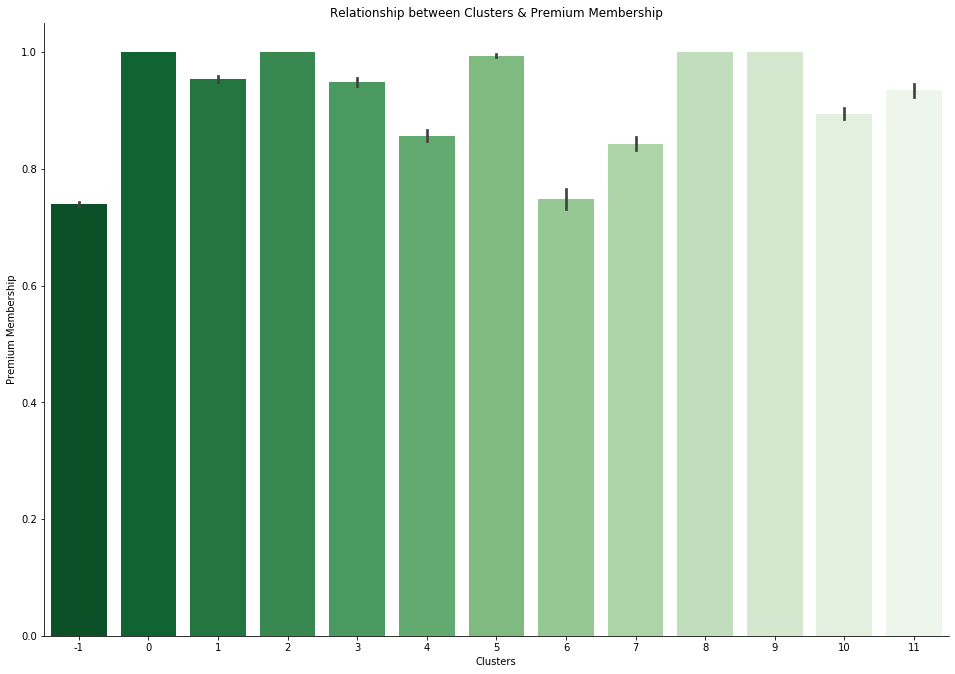

In [212]:
# Plot clusters with premium
sns.catplot(x='hd_clusters', y='premium', kind='bar', palette='Greens_r', data=Xclusters_track1_dummies)
plt.title('Relationship between Clusters & Premium Membership')
plt.xlabel('Clusters')
plt.ylabel('Premium Membership')
plt.gcf().set_size_inches(15,10)
plt.show()

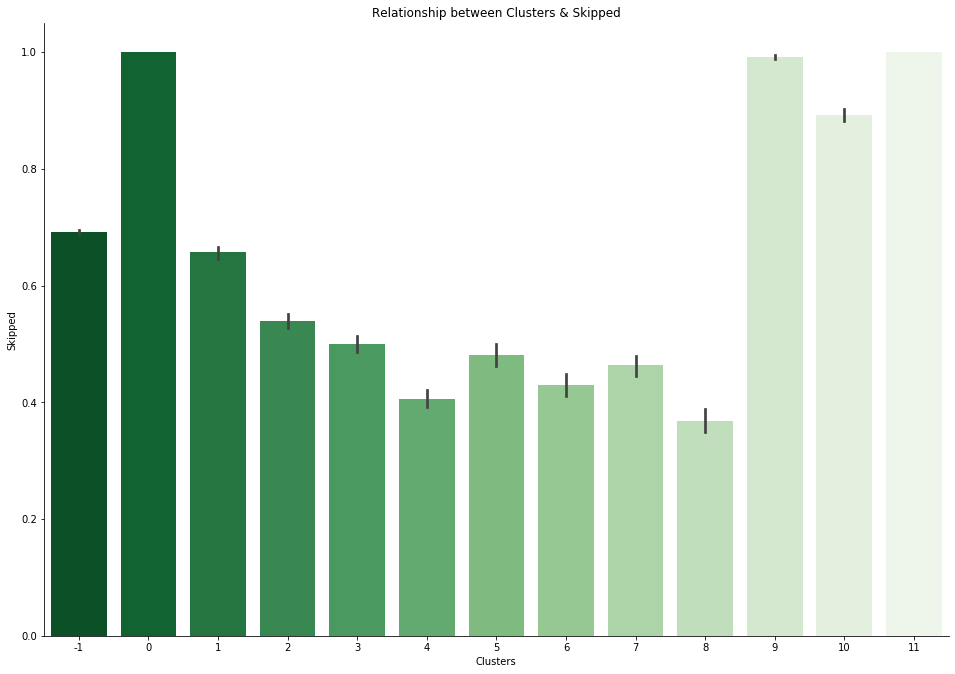

In [213]:
# Plot clusters with skipped
sns.catplot(x='hd_clusters', y='skipped', kind='bar', palette='Greens_r', data=Xclusters_track1_dummies)
plt.title('Relationship between Clusters & Skipped')
plt.xlabel('Clusters')
plt.ylabel('Skipped')
plt.gcf().set_size_inches(15,10)
plt.show()

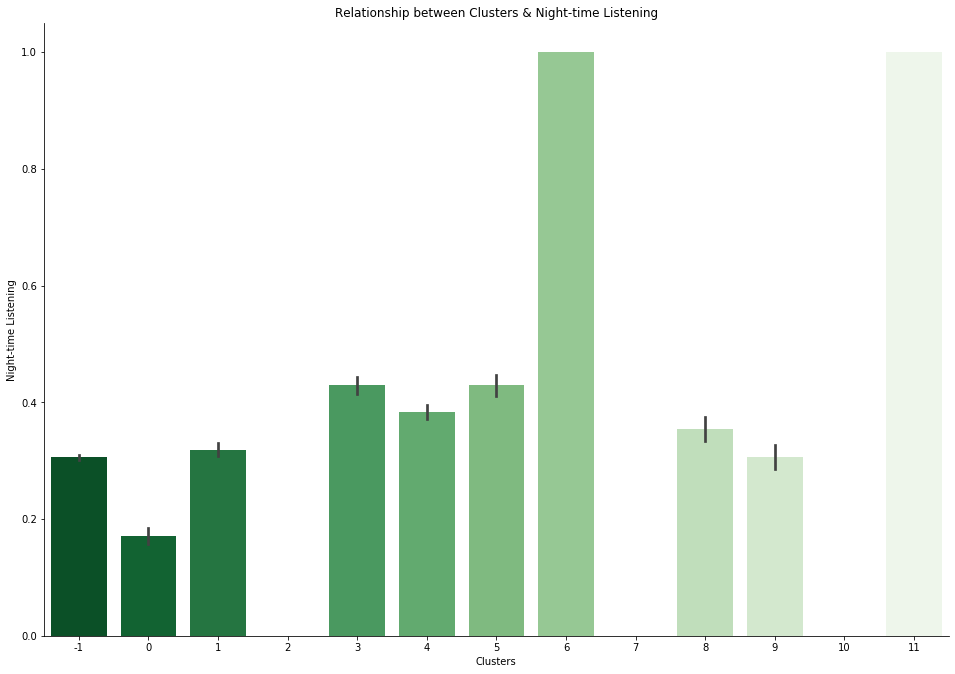

In [214]:
# Let's see what a non-binary dummy var looks like
sns.catplot(x='hd_clusters', y='night', kind='bar', palette='Greens_r', data=Xclusters_track1_dummies)
plt.title('Relationship between Clusters & Night-time Listening')
plt.xlabel('Clusters')
plt.ylabel('Night-time Listening')
plt.gcf().set_size_inches(15,10)
plt.show()

That's interesting. It looks like Clusters 6 & 11 had many more incidences of night-time listening sessions than the others. I will keep the dataframe as the dummies dataframe then, rather than using the df that existed pre-one-hot encoding. Looking specifically at each dummy value seems like it may be more illuminating.

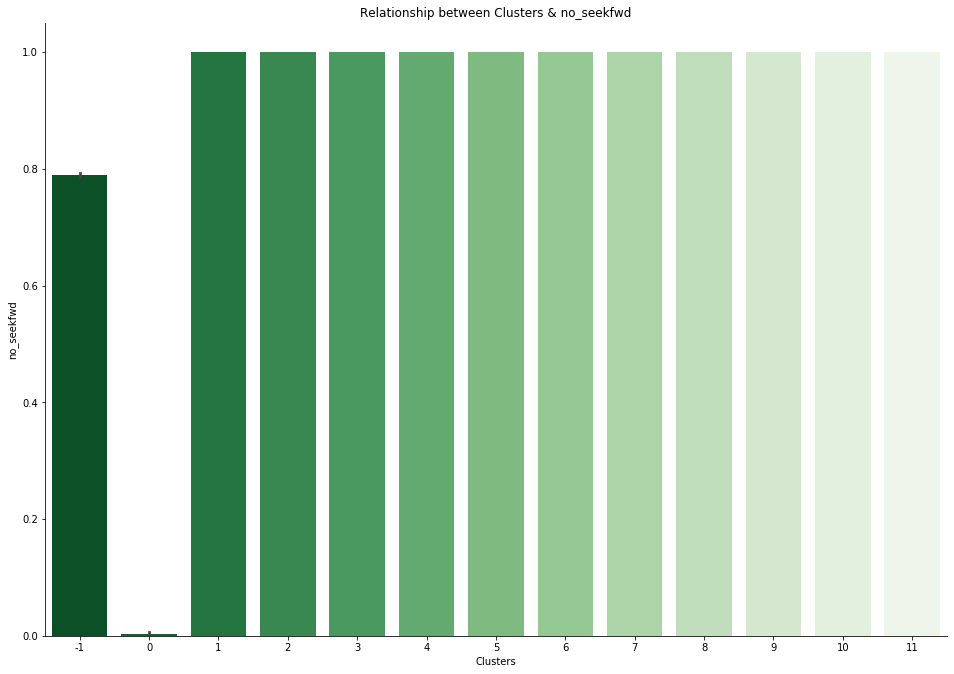

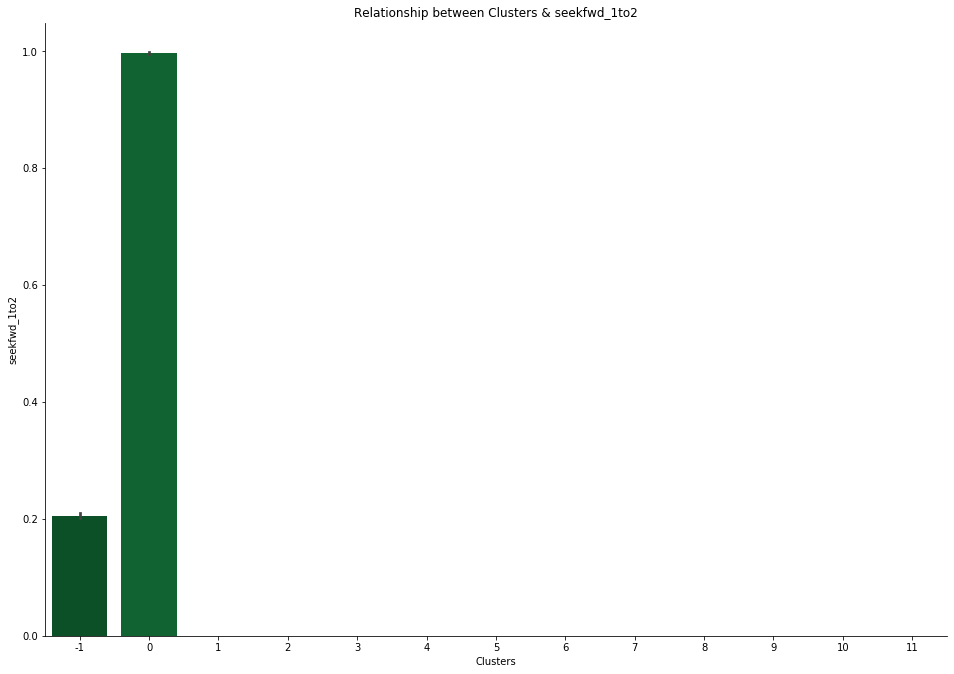

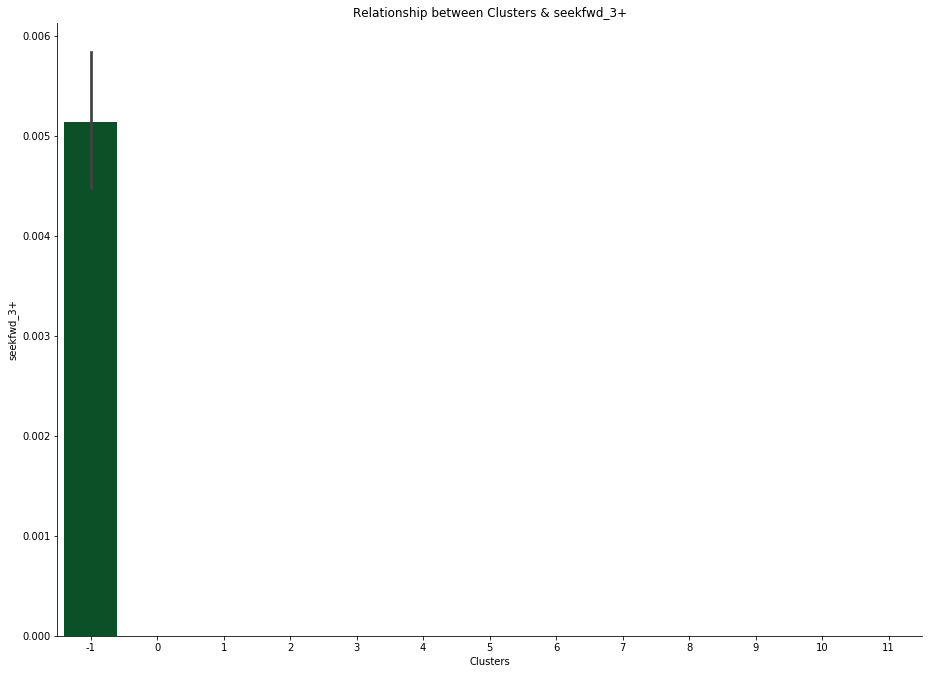

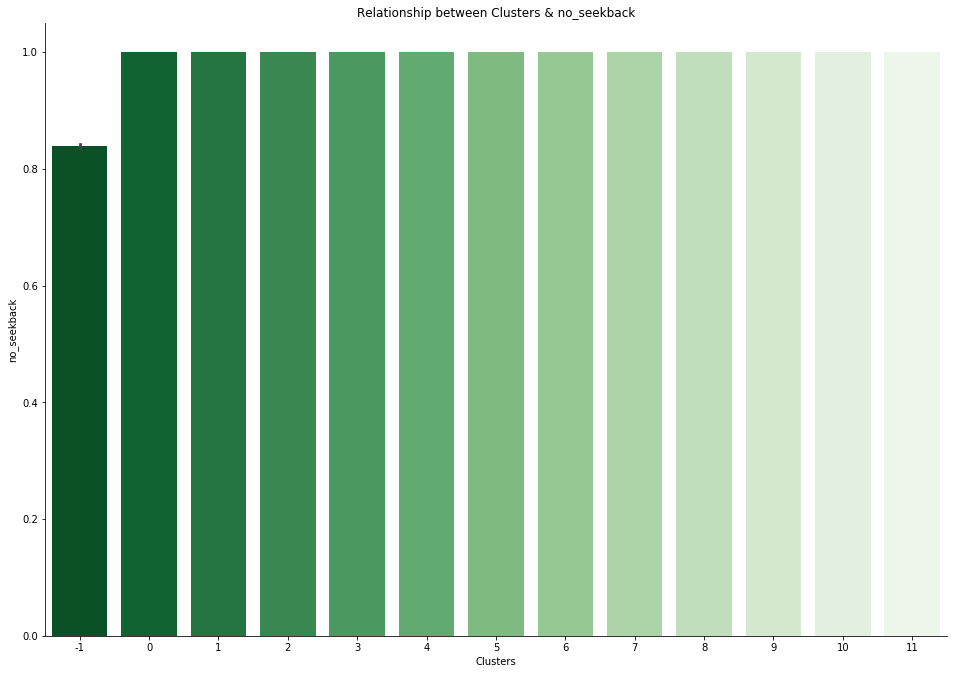

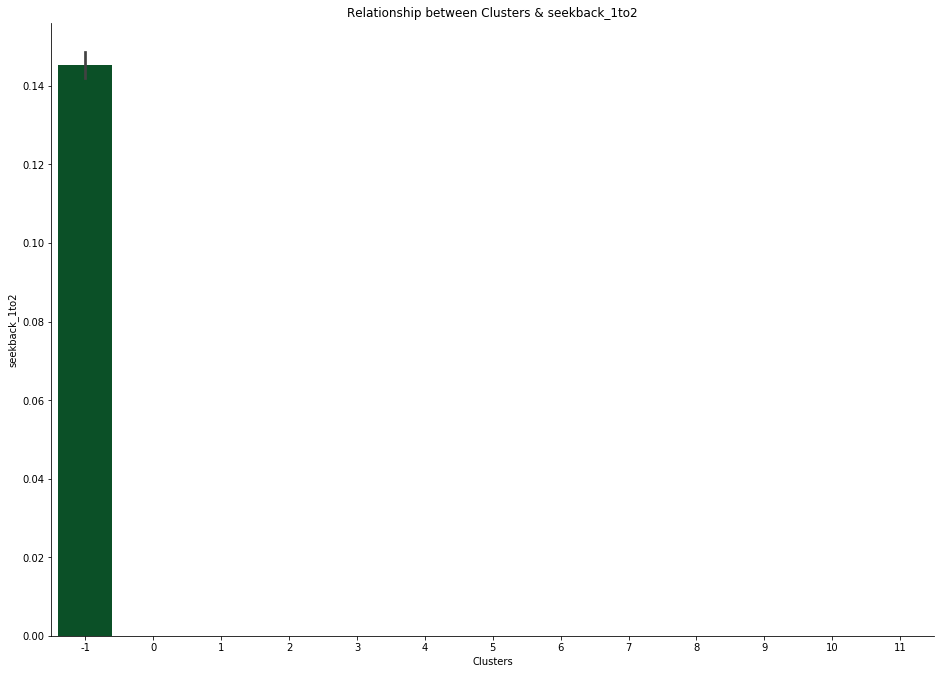

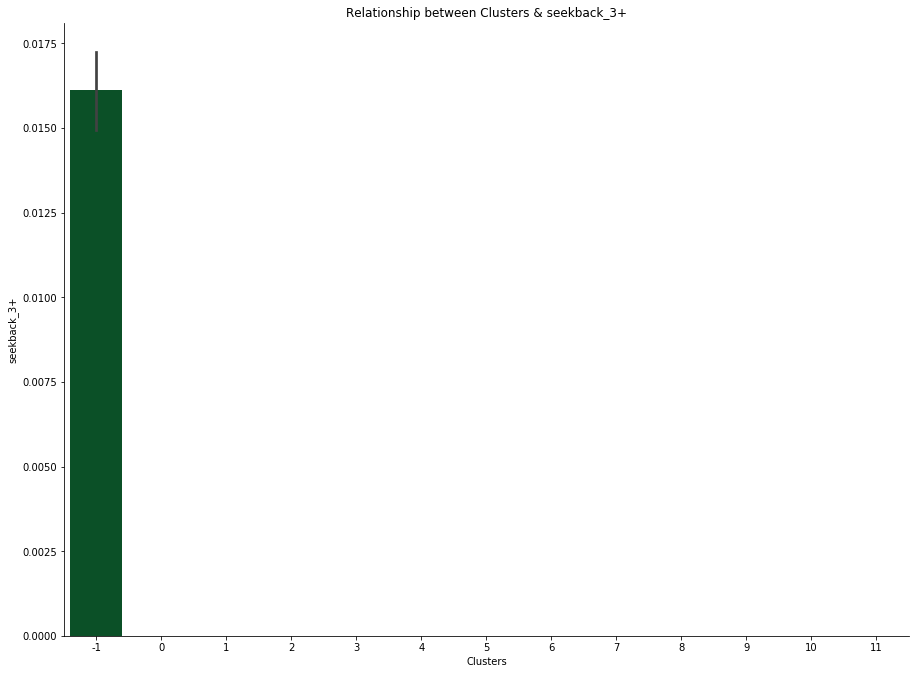

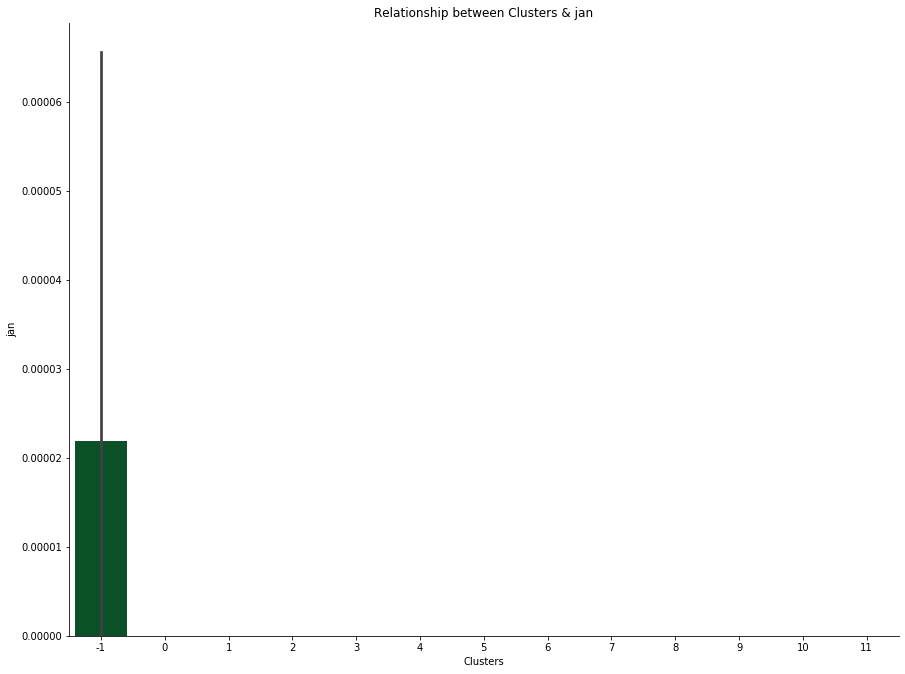

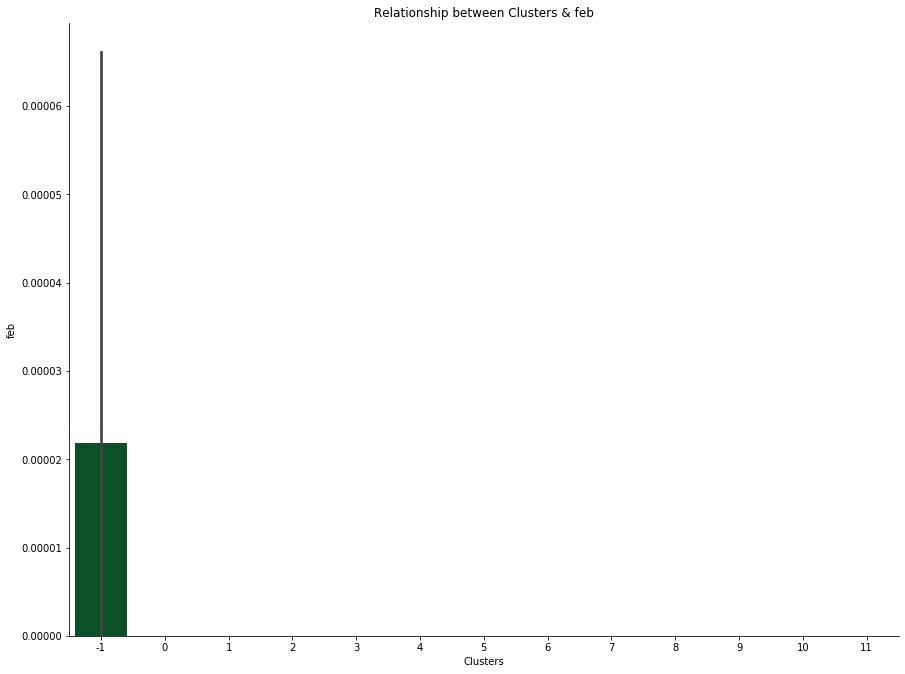

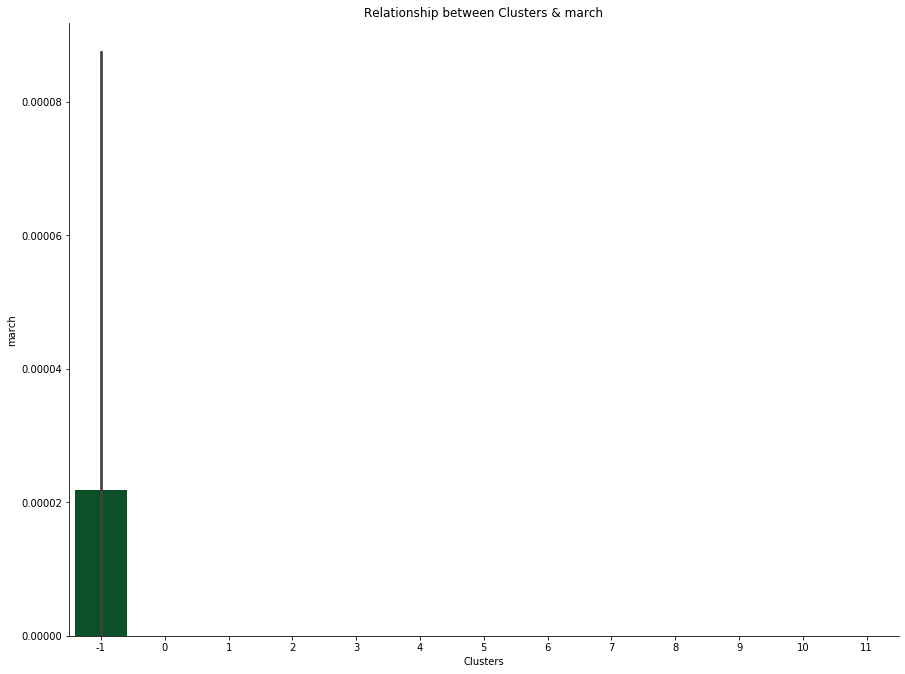

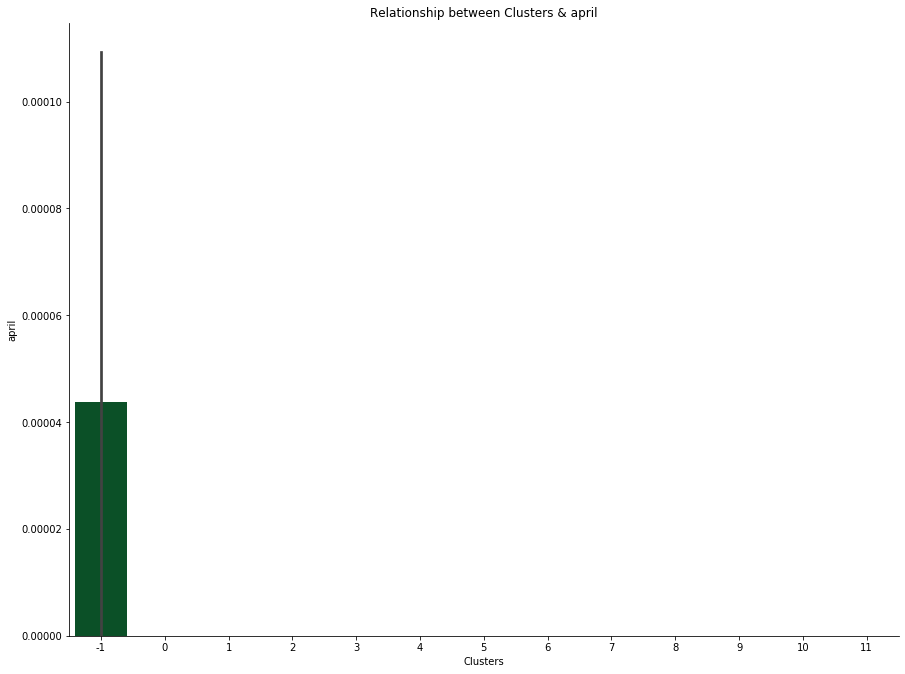

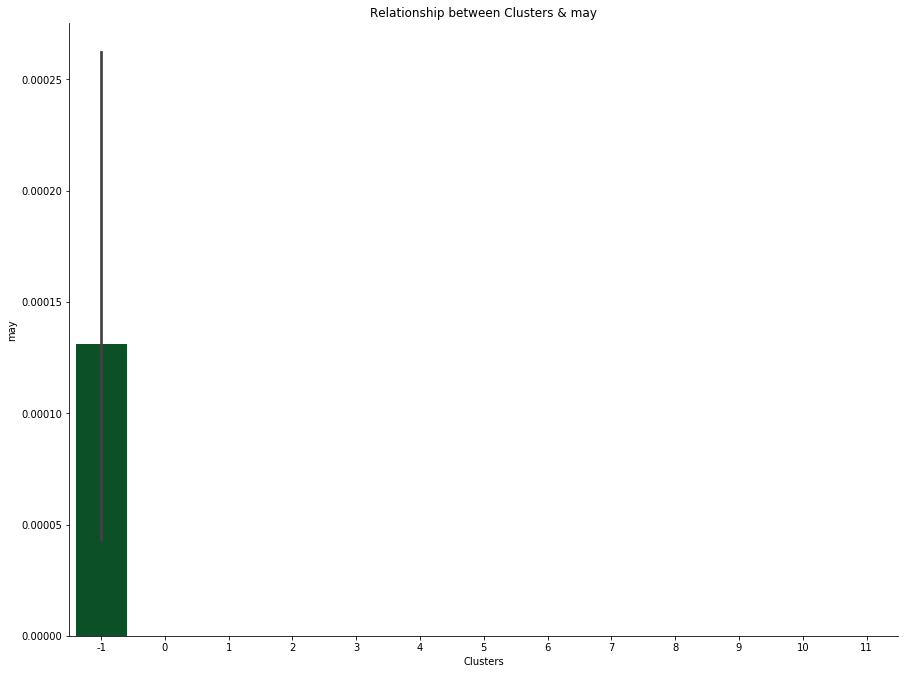

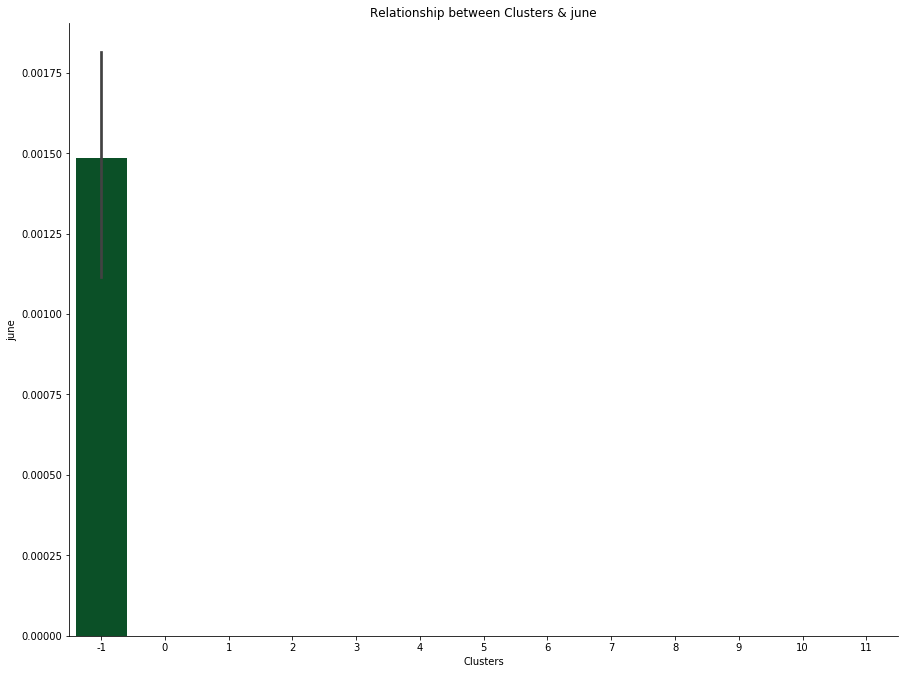

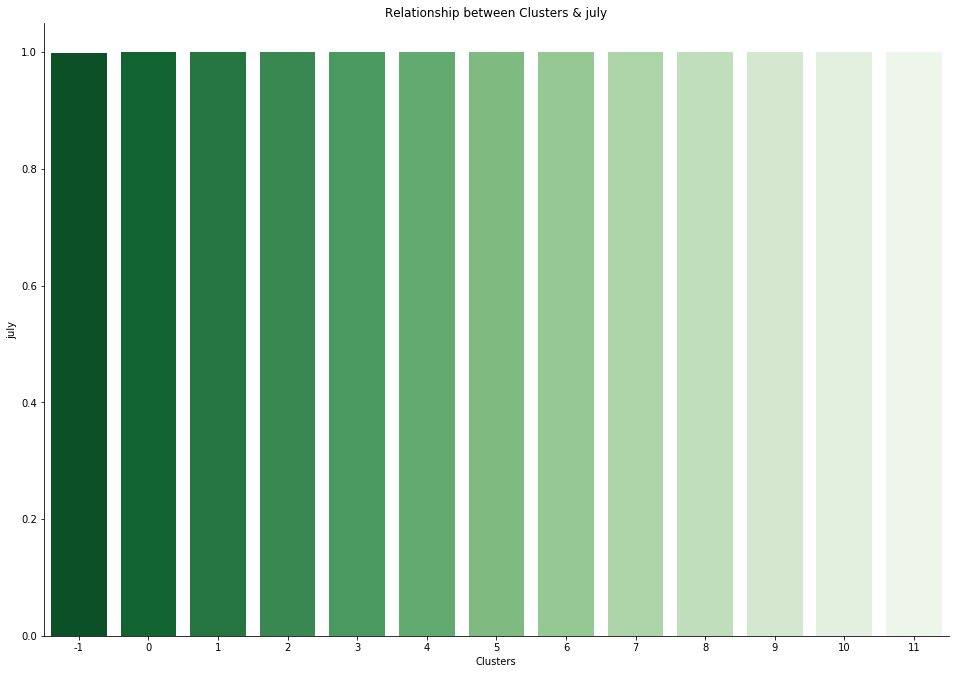

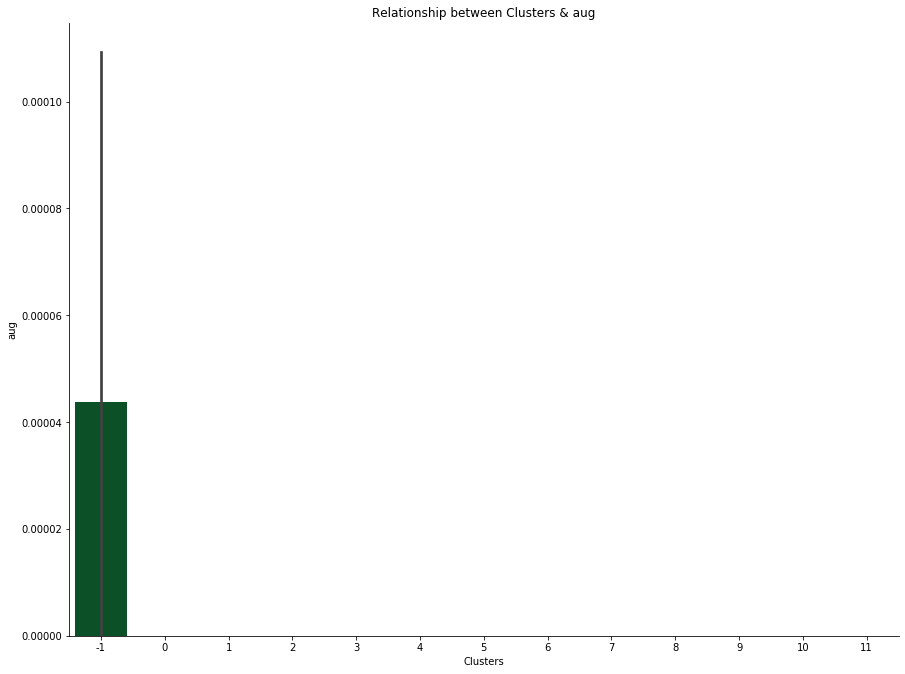

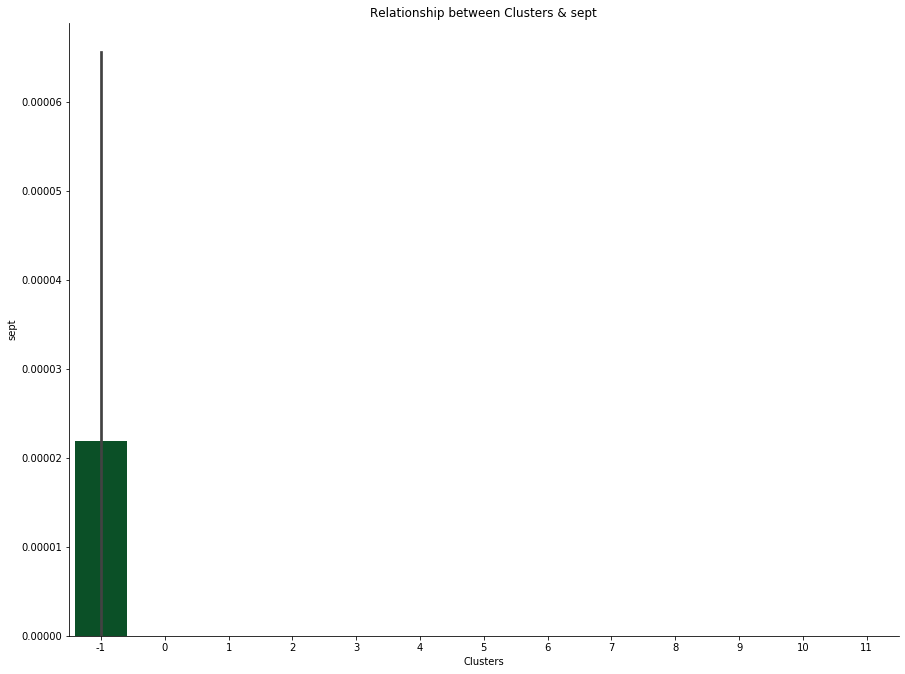

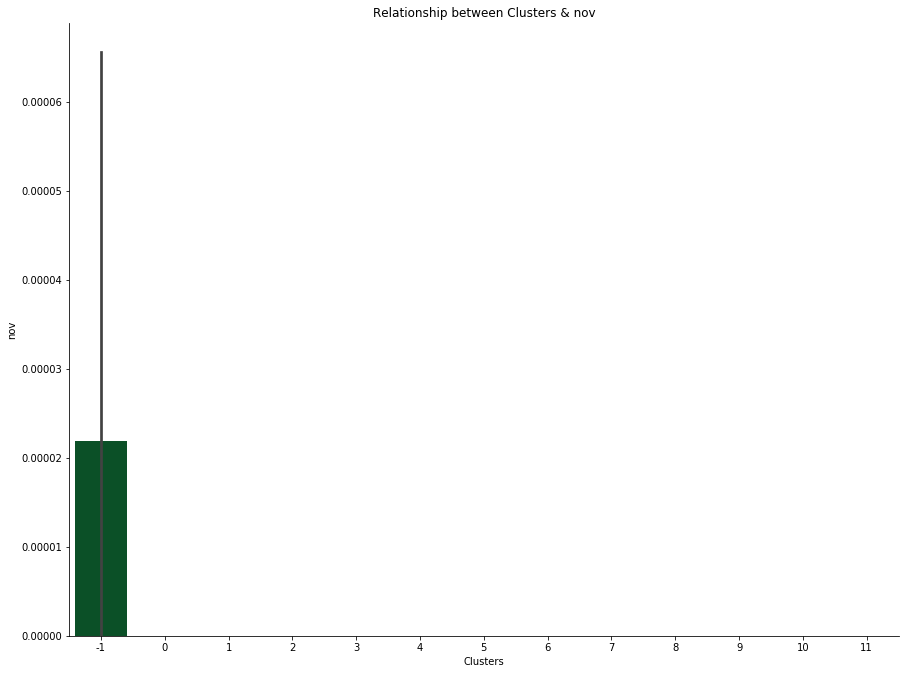

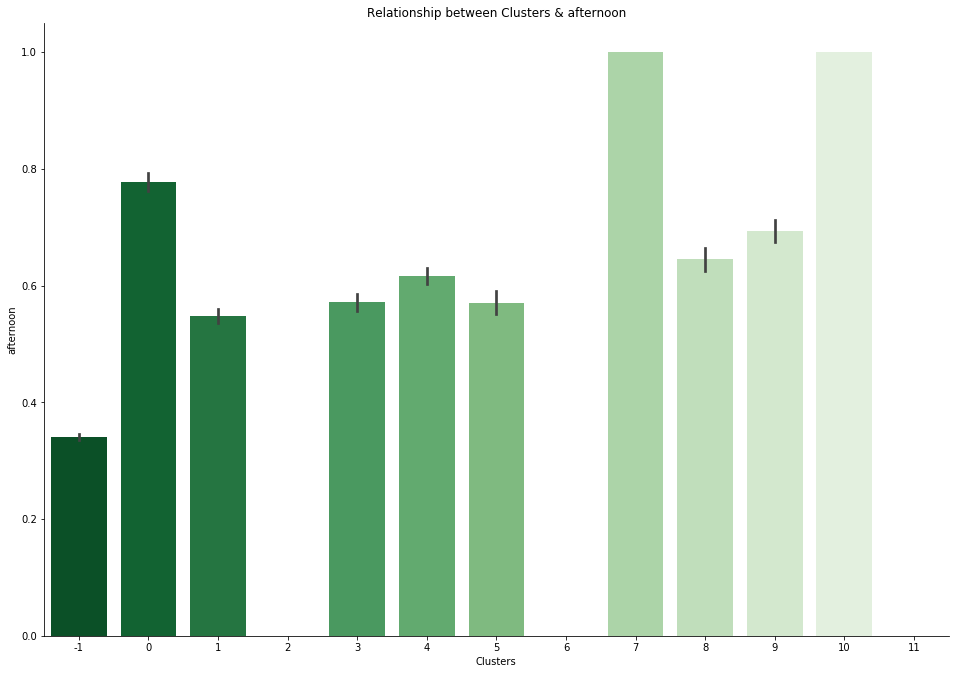

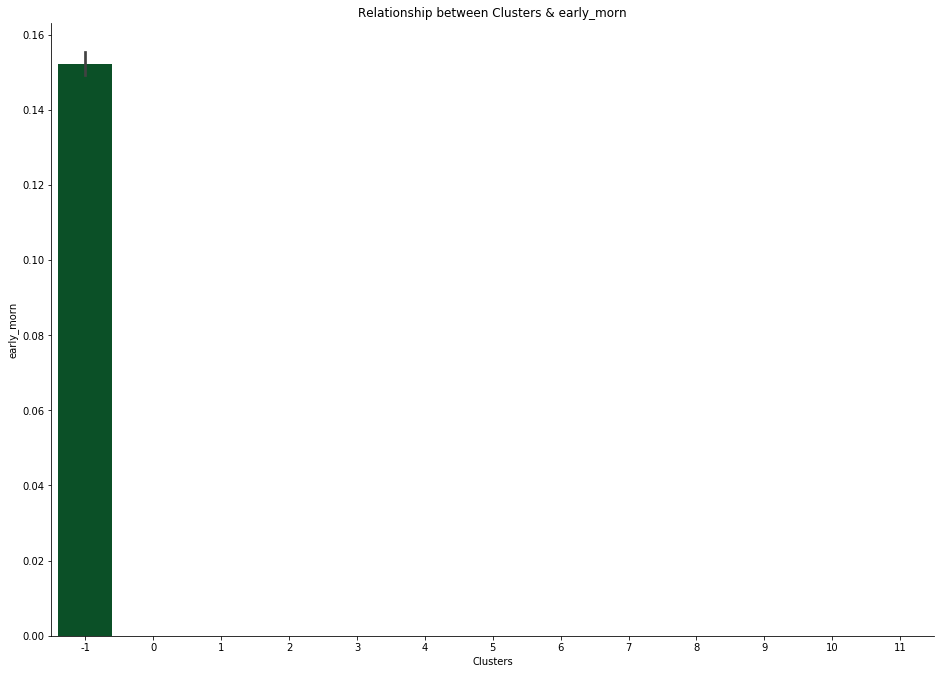

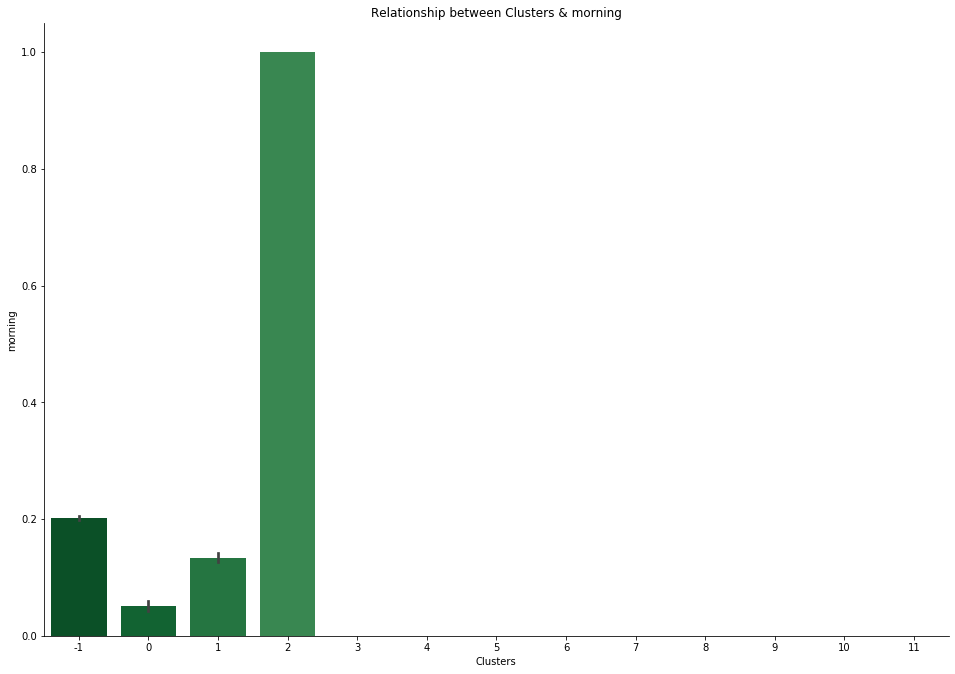

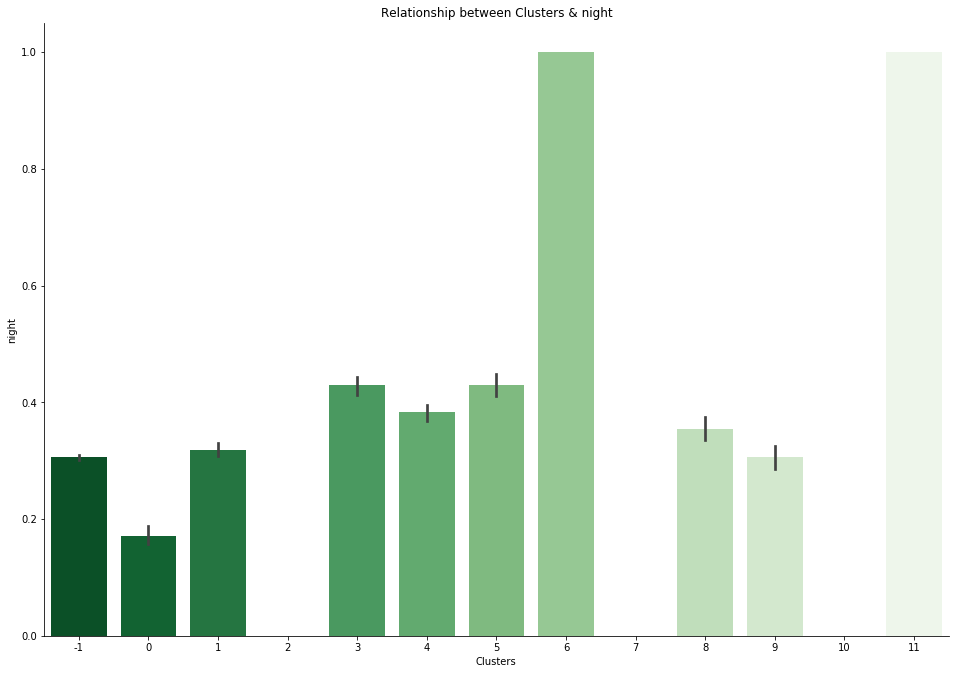

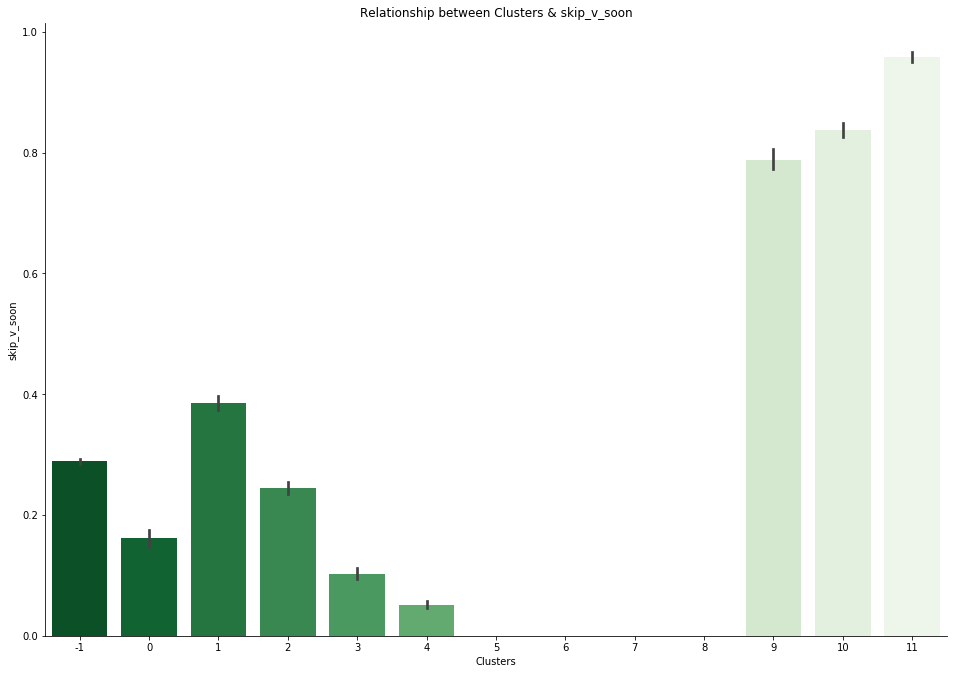

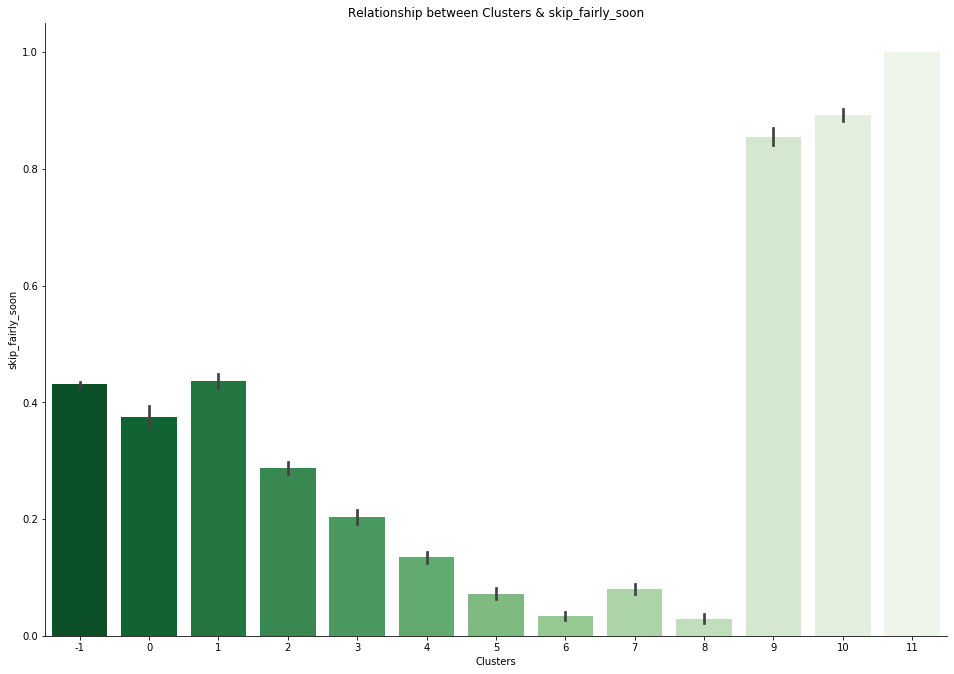

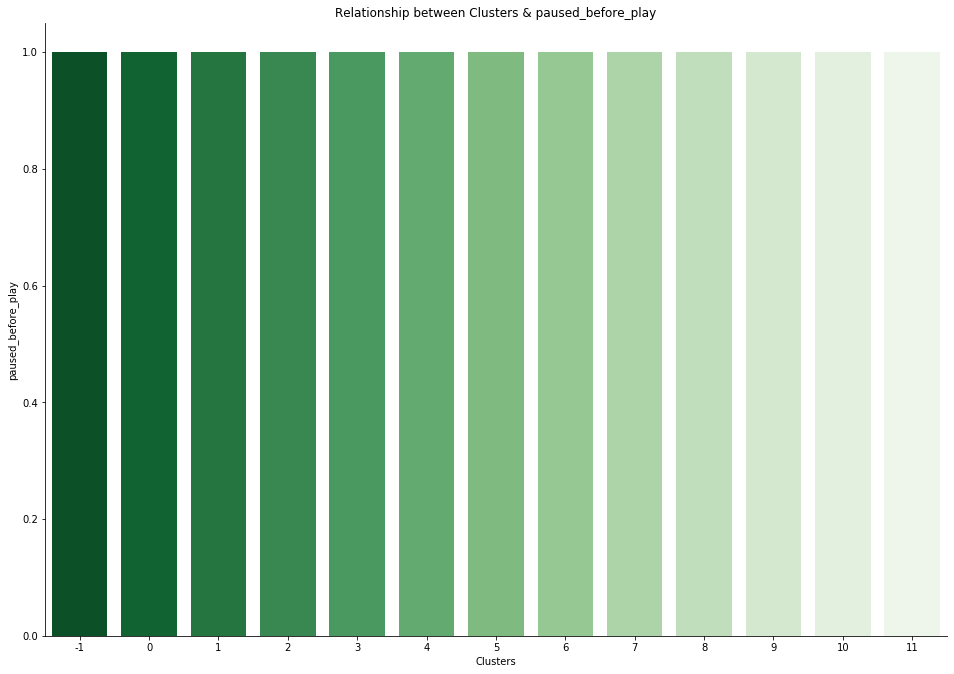

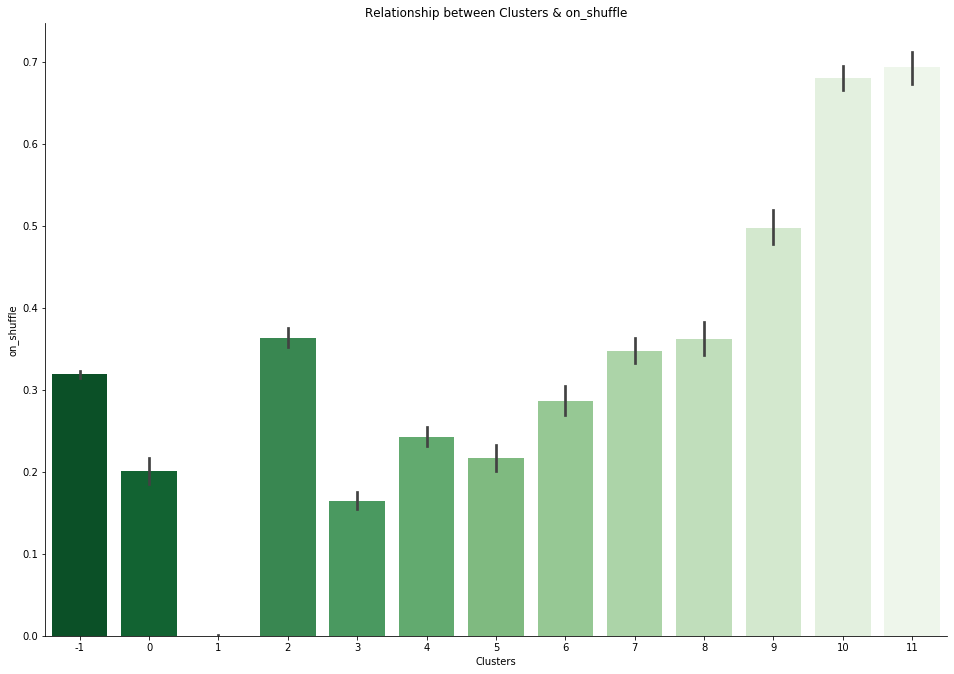

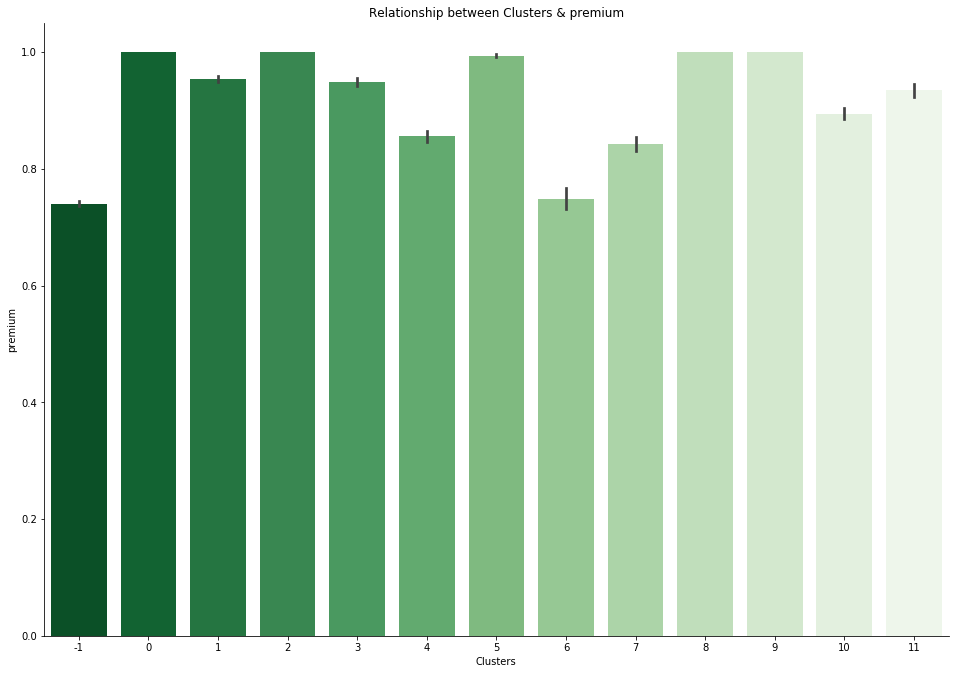

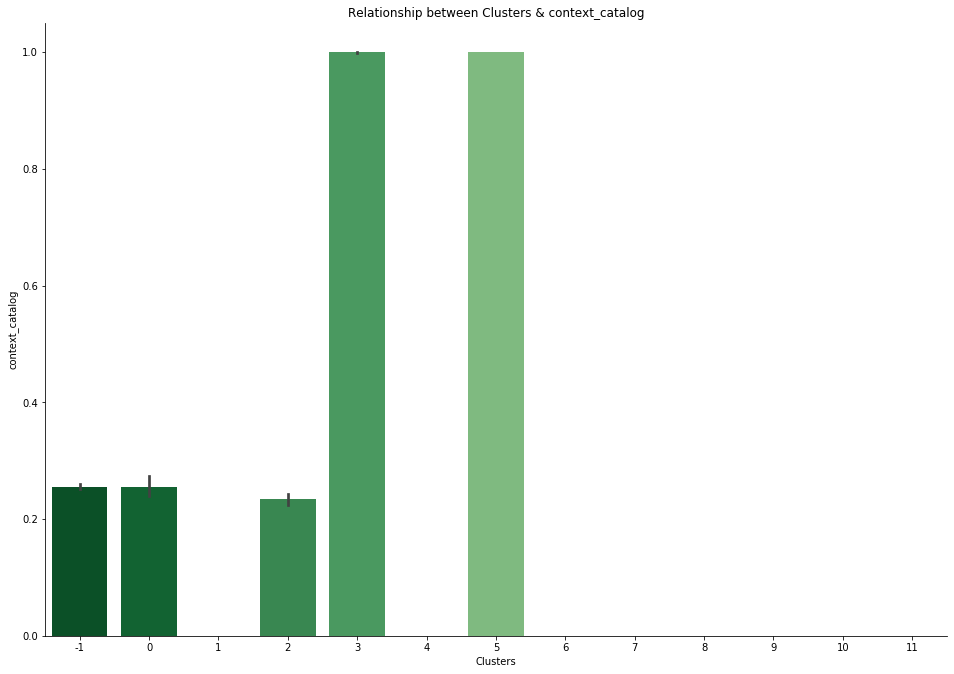

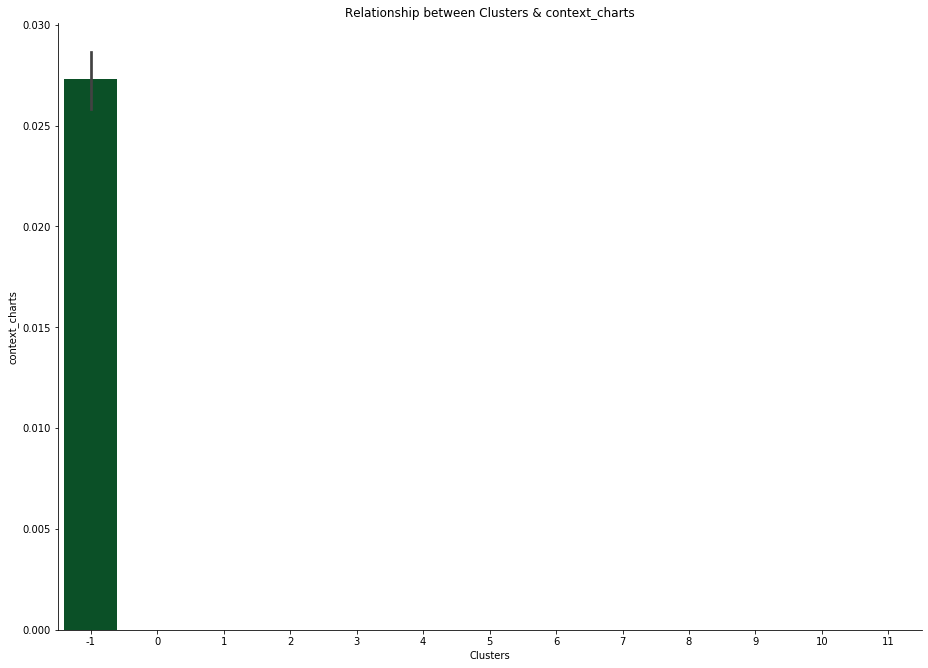

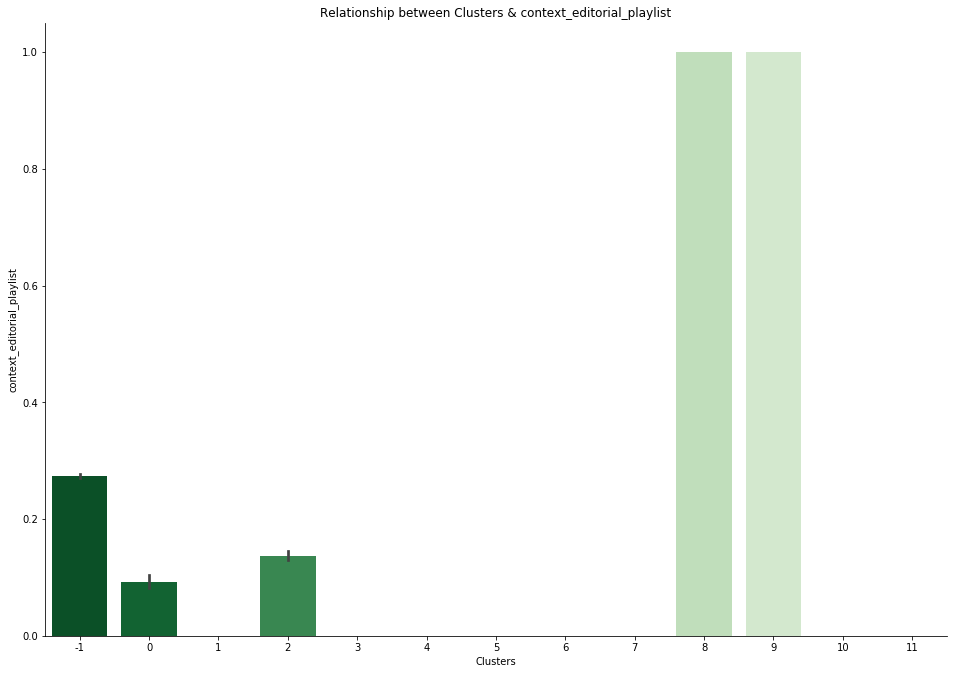

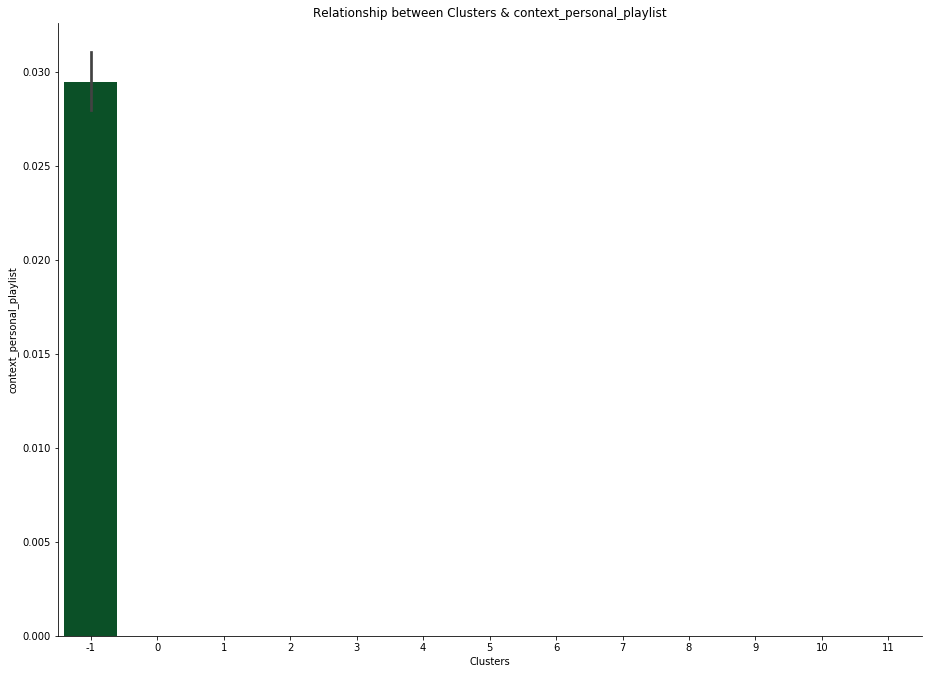

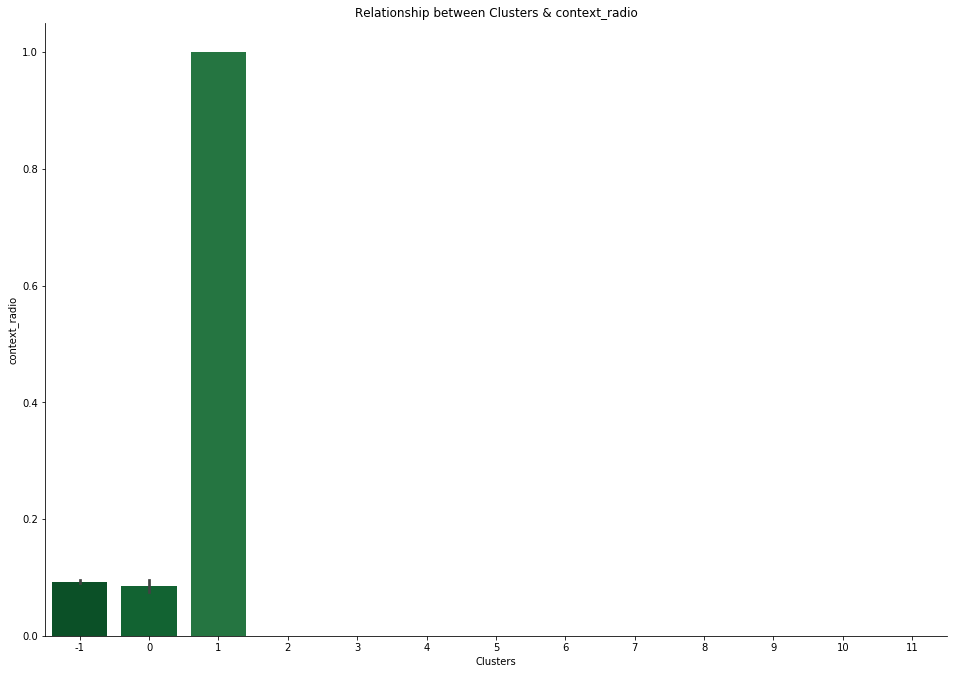

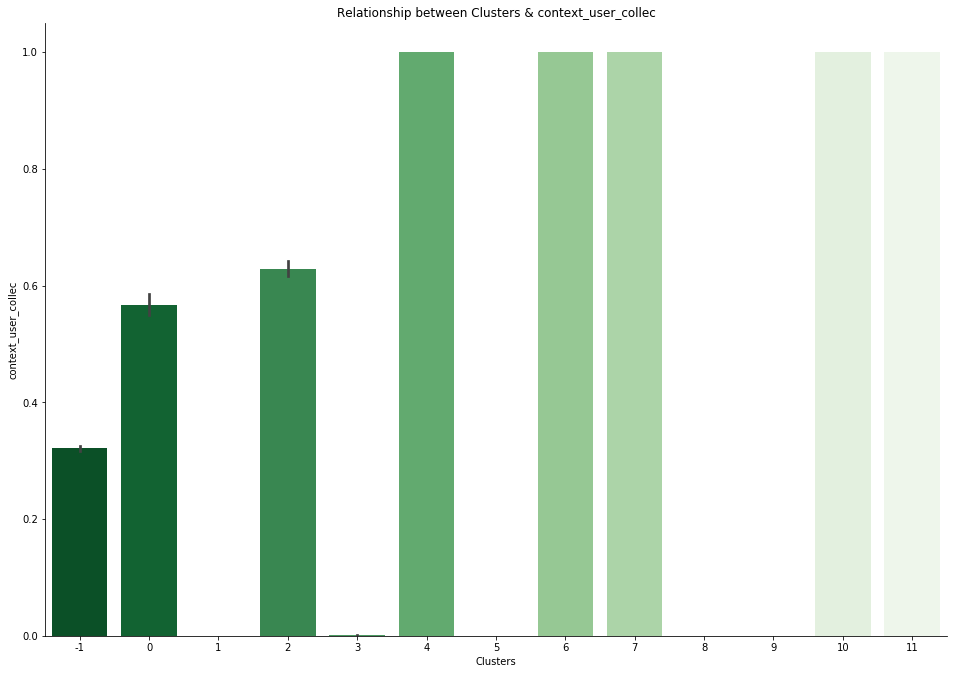

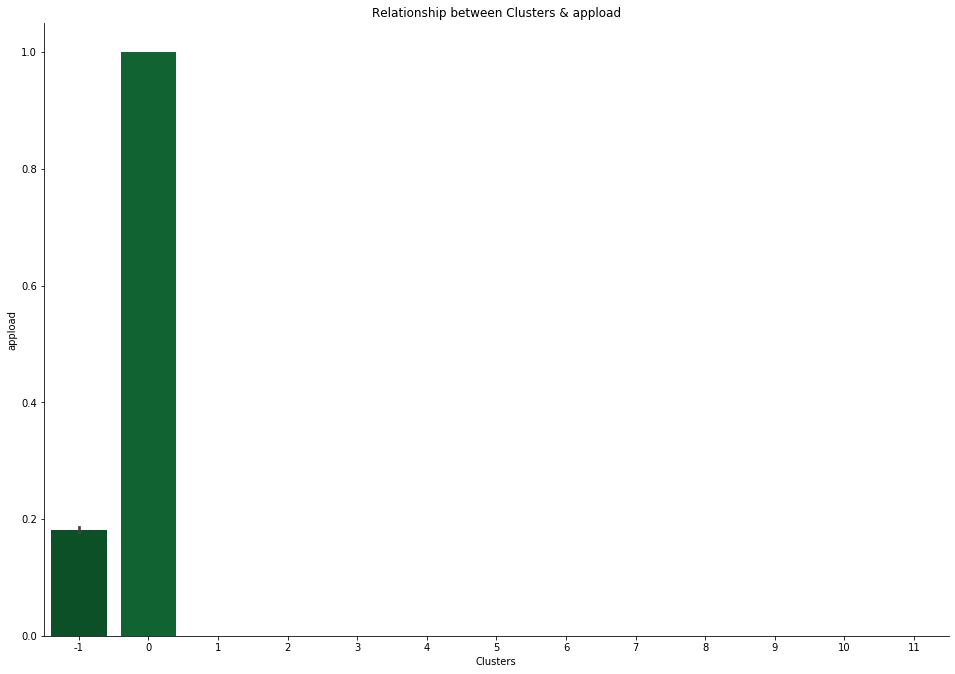

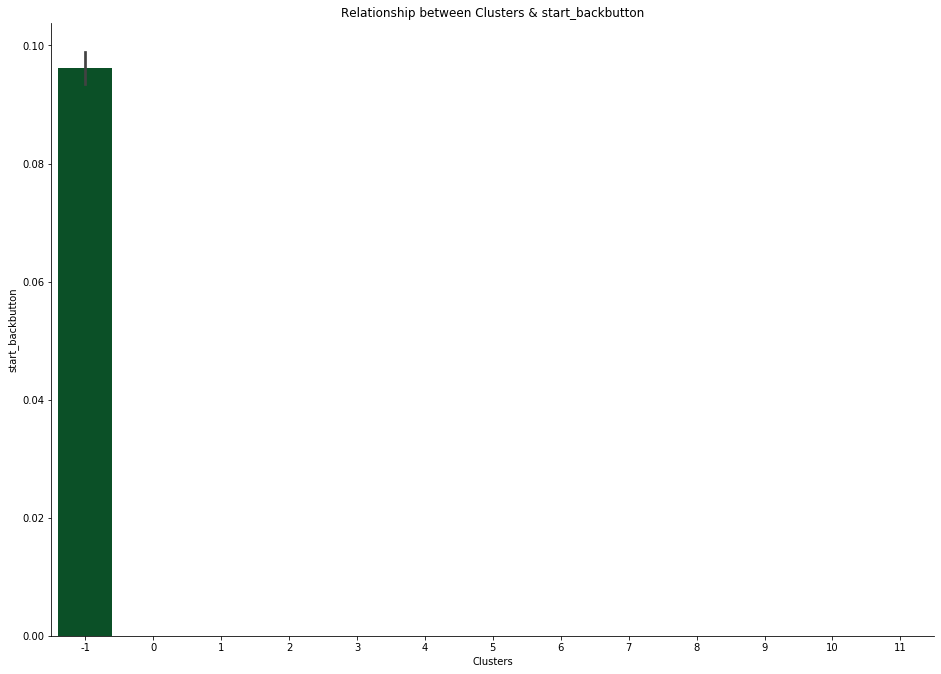

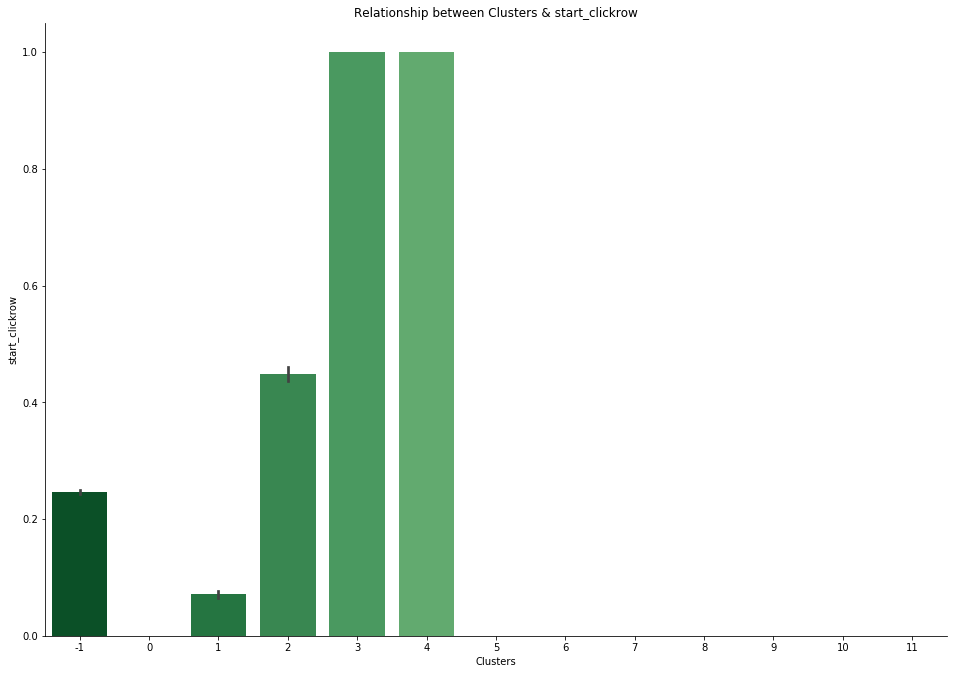

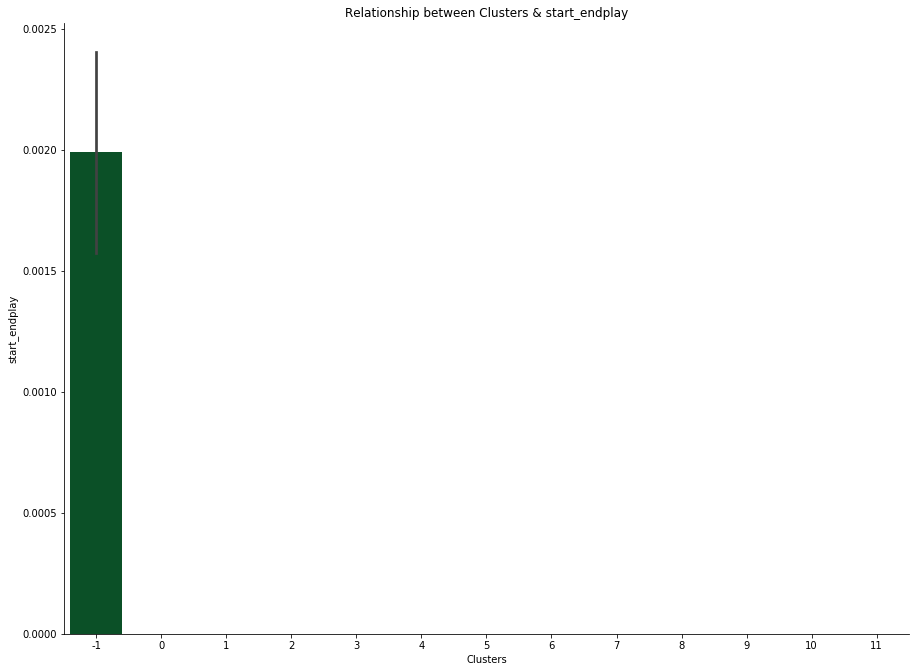

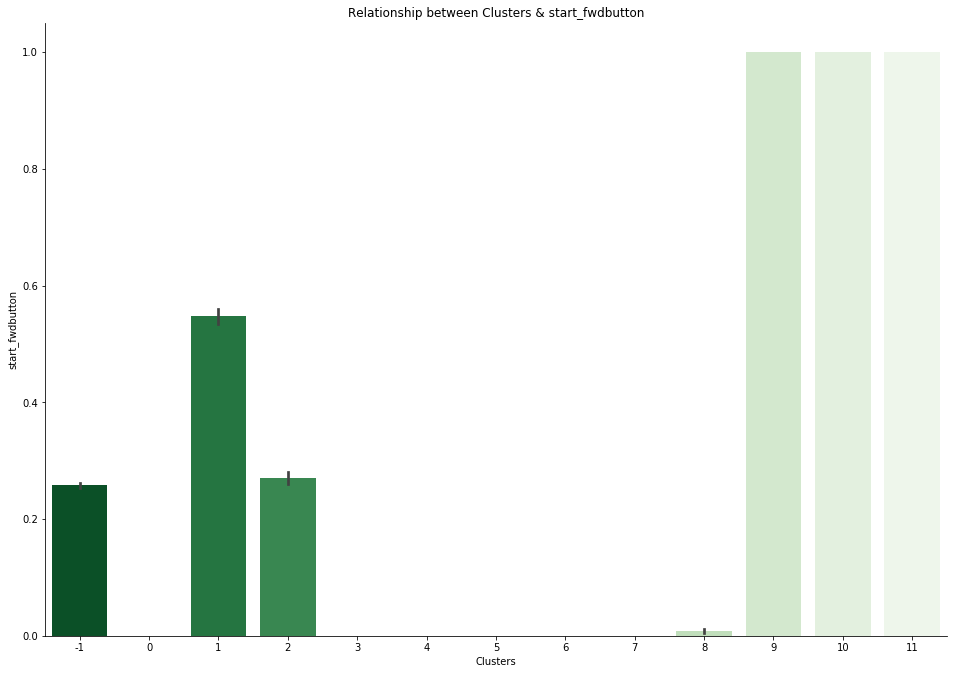

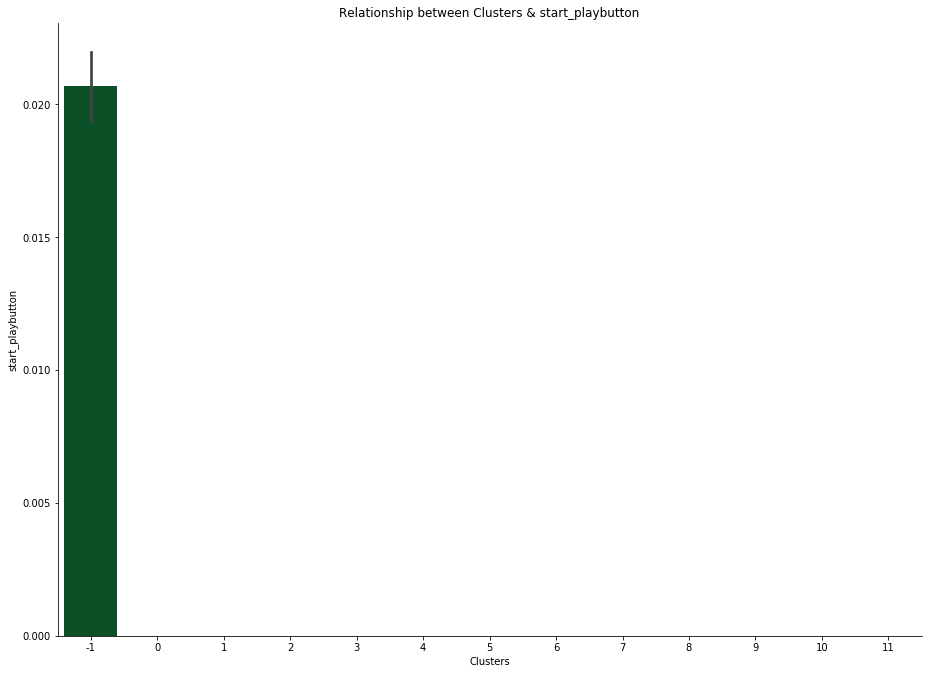

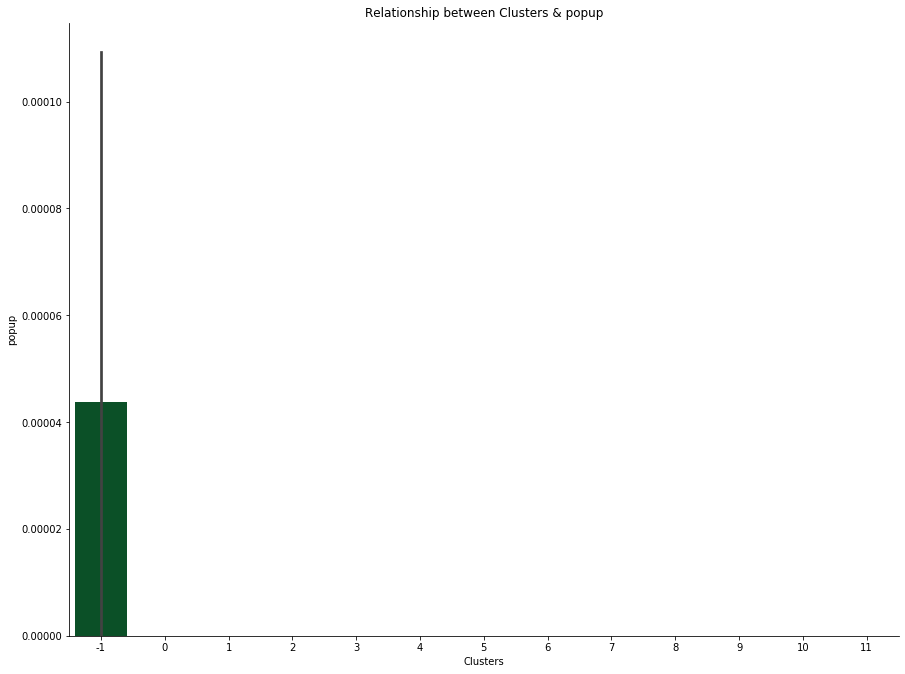

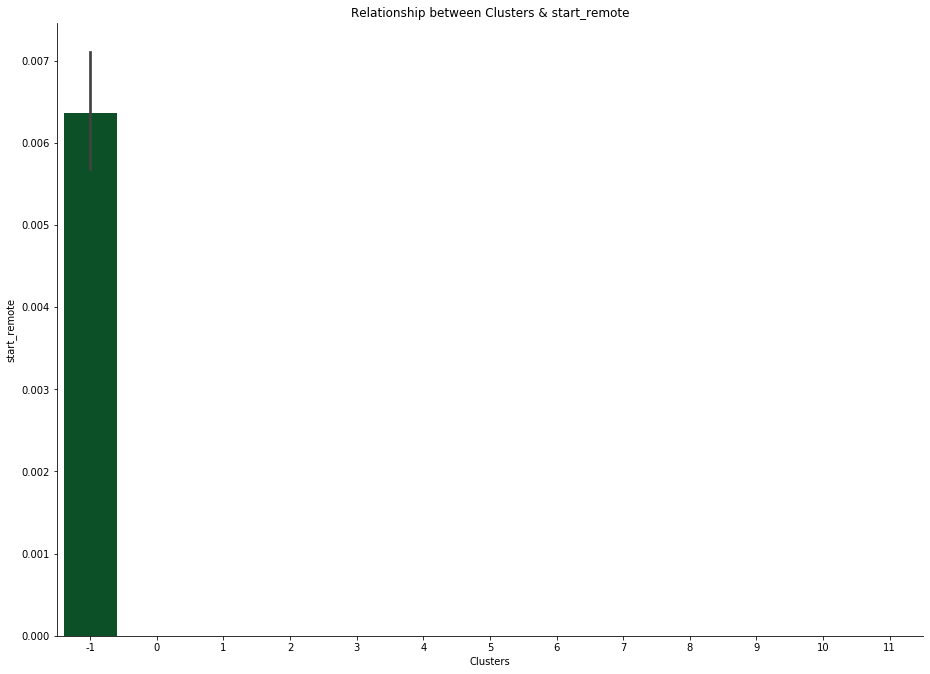

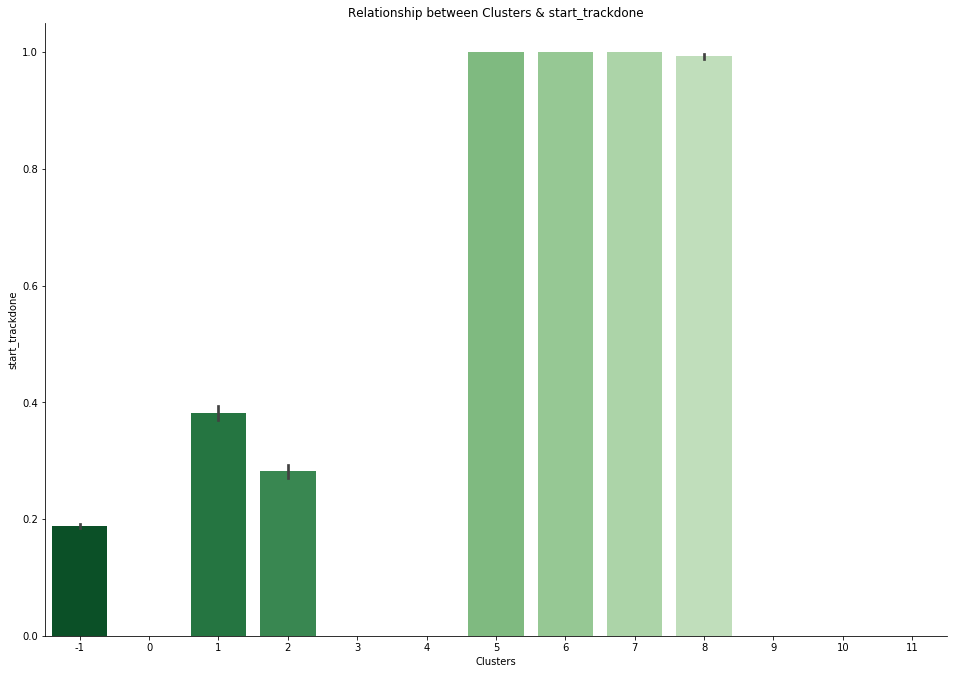

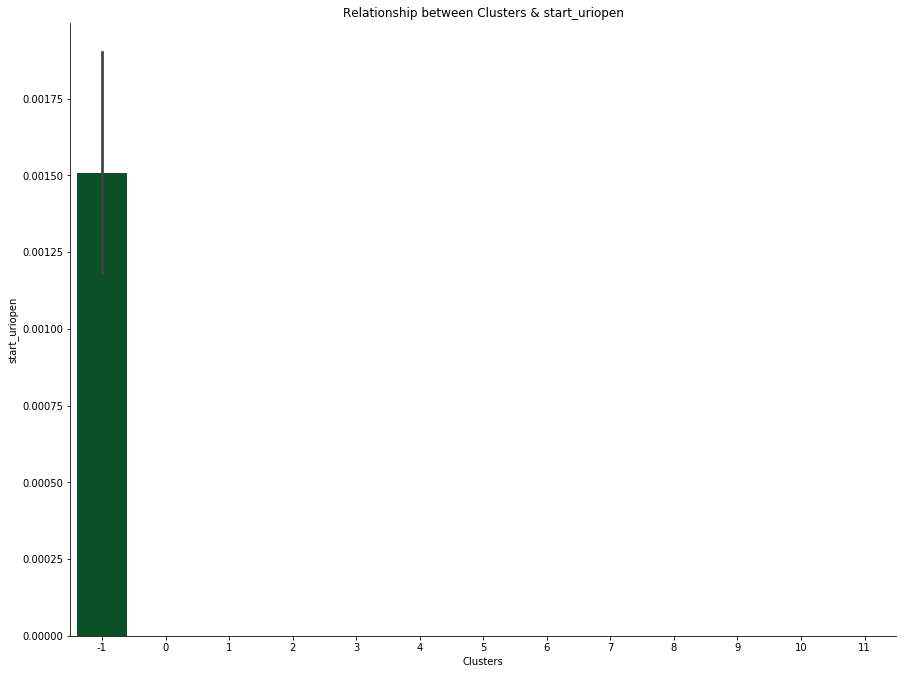

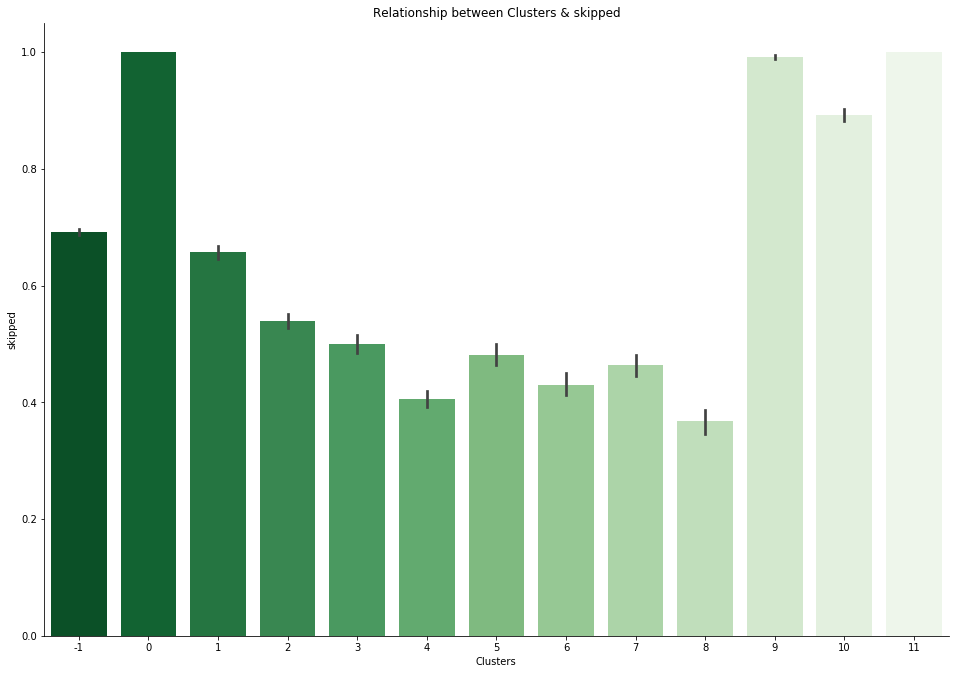

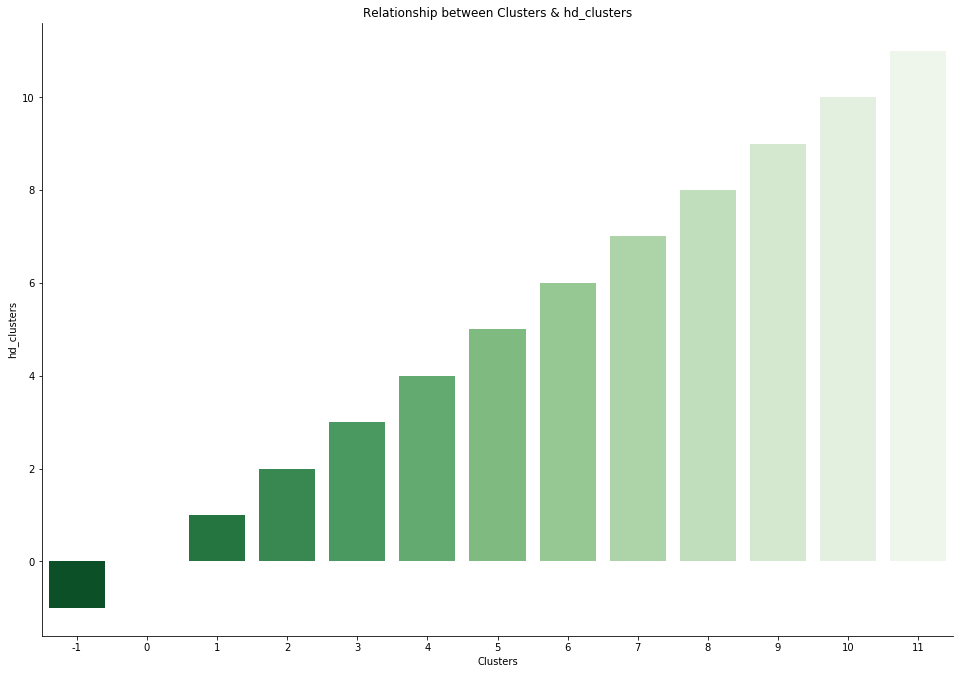

In [215]:
# Let's look at all of the vars in the dummies here, and then later we can choose which will go in the presentation
for col in Xclusters_track1_dummies:
    sns.catplot(x='hd_clusters', y=col, kind='bar', palette='Greens_r', data=Xclusters_track1_dummies)
    plt.title('Relationship between Clusters & {}'.format(col))
    plt.xlabel('Clusters')
    plt.ylabel('{}'.format(col))
    plt.gcf().set_size_inches(15,10)
    plt.show()

Now we'll add the clusters as an array back into the track10 df so we can investigate them further

In [216]:
# First checking length of cluster labels array is same length as track10 df
print(len(track10_hd_labels))

89672


In [217]:
# Placing each observation's cluster assignment in the df 
Xclusters_track10_dummies['hd_clusters'] = pd.Series(track10_hd_labels, index=Xclusters_track10_dummies.index)

In [218]:
# Look at the new column; make sure it's okay
Xclusters_track10_dummies.head(20)

no_seekfwd  seekfwd_1to2  seekfwd_3+  no_seekback  seekback_1to2  \
1            1             0           0            1              0   
2            1             0           0            1              0   
4            1             0           0            1              0   
4            1             0           0            1              0   
5            1             0           0            1              0   
6            1             0           0            1              0   
7            1             0           0            1              0   
7            0             1           0            1              0   
8            1             0           0            1              0   
8            1             0           0            1              0   
9            1             0           0            1              0   
9            1             0           0            1              0   
9            1             0           0            1              0   
9            1             0           0            1              0   
10           1             0           0            1              0   
10           1             0           0            1              0   
11           1             0           0            1              0   
12           1             0           0            1              0   
13           1             0           0            1              0   
14           1             0           0            1              0   

    seekback_3+  jan  feb  march  april  ...  start_backbutton  \
1             0    0    0      0      0  ...                 0   
2             0    0    0      0      0  ...                 0   
4             0    0    0      0      0  ...                 0   
4             0    0    0      0      0  ...                 0   
5             0    0    0      0      0  ...                 0   
6             0    0    0      0      0  ...                 0   
7             0    0    0      0      0  ...                 0   
7             0    0    0      0      0  ...                 0   
8             0    0    0      0      0  ...                 0   
8             0    0    0      0      0  ...                 0   
9             0    0    0      0      0  ...                 0   
9             0    0    0      0      0  ...                 0   
9             0    0    0      0      0  ...                 0   
9             0    0    0      0      0  ...                 0   
10            0    0    0      0      0  ...                 0   
10            0    0    0      0      0  ...                 0   
11            0    0    0      0      0  ...                 0   
12            0    0    0      0      0  ...                 0   
13            0    0    0      0      0  ...                 0   
14            0    0    0      0      0  ...                 0   

    start_clickrow  start_endplay  start_fwdbutton  start_playbutton  \
1                0              0                1                 0   
2                0              0                1                 0   
4                0              0                1                 0   
4                0              0                1                 0   
5                0              0                1                 0   
6                0              0                0                 0   
7                0              0                1                 0   
7                0              0                1                 0   
8                0              0                0                 0   
8                0              0                0                 0   
9                0              0                1                 0   
9                0              0                1                 0   
9                0              0                0                 0   
9                0              0                1                 0   
10               0      

In [219]:
# See the cluster breakdown
print(Xclusters_track10_dummies['hd_clusters'].unique())
print(Xclusters_track10_dummies['hd_clusters'].value_counts())

[-1  9  3 10  2  6  4  1 11  5  8  7  0]
-1     42481
 2      7827
 4      5966
 9      5480
 3      4316
 8      4141
 6      4073
 11     3505
 0      3290
 1      2675
 10     2325
 7      1832
 5      1761
Name: hd_clusters, dtype: int64


Next up, let's do some barplots with the clusters to investigate a bit more what they mean.

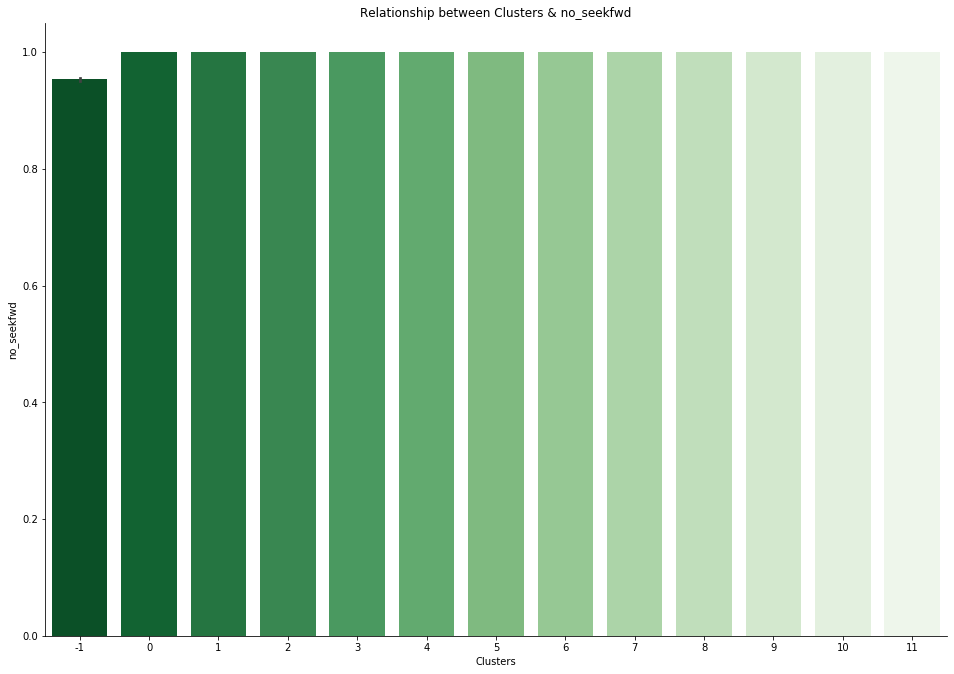

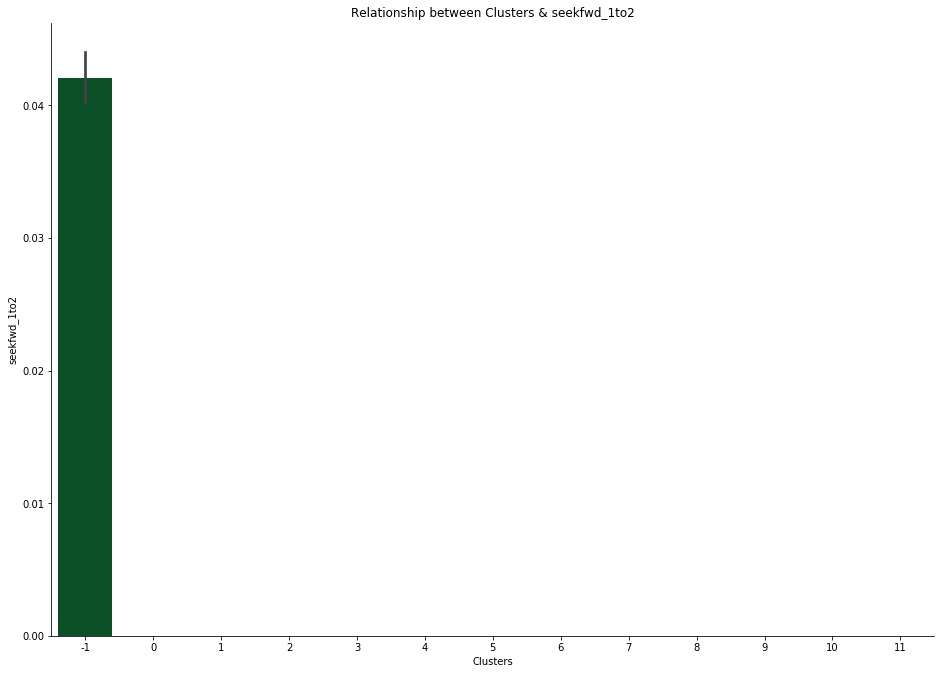

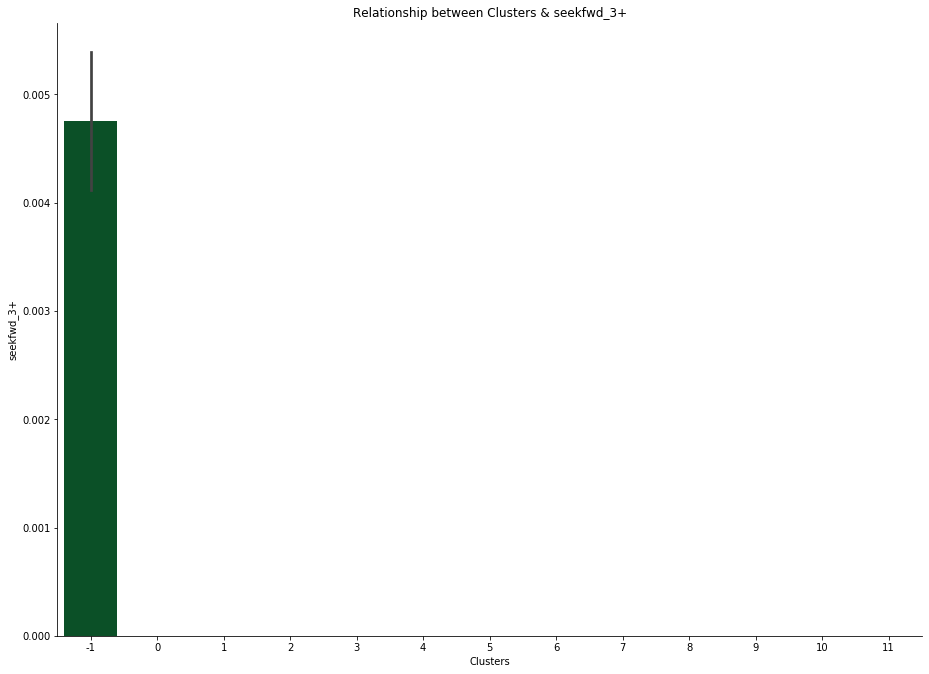

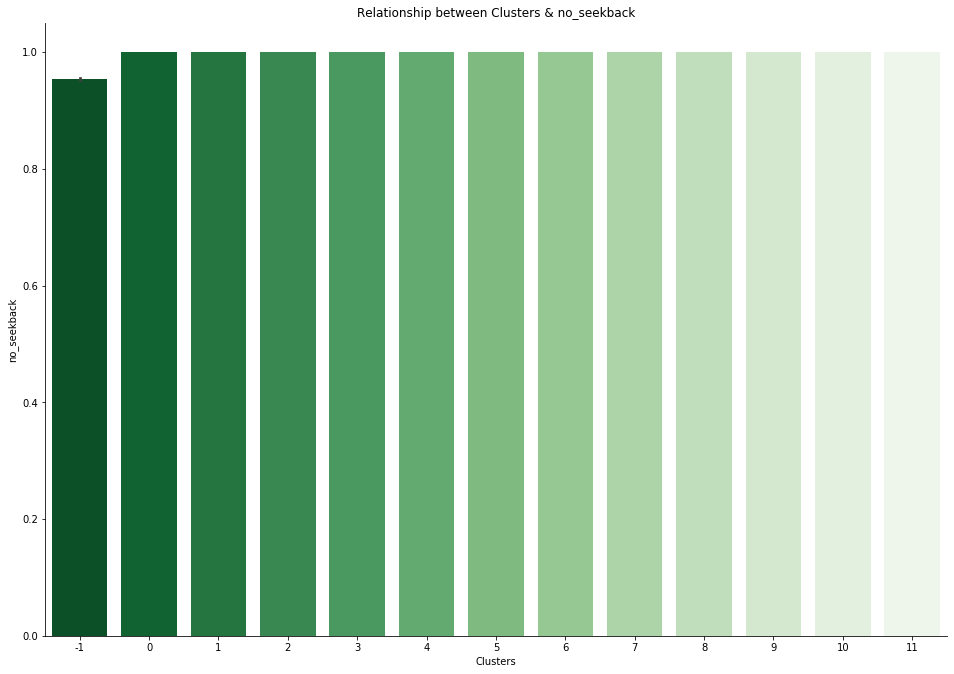

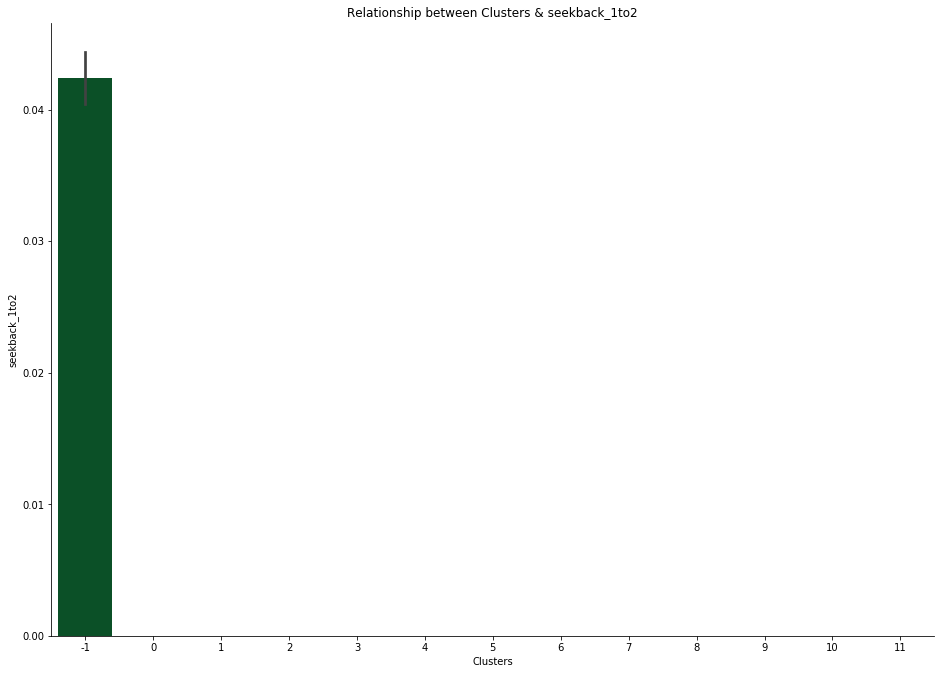

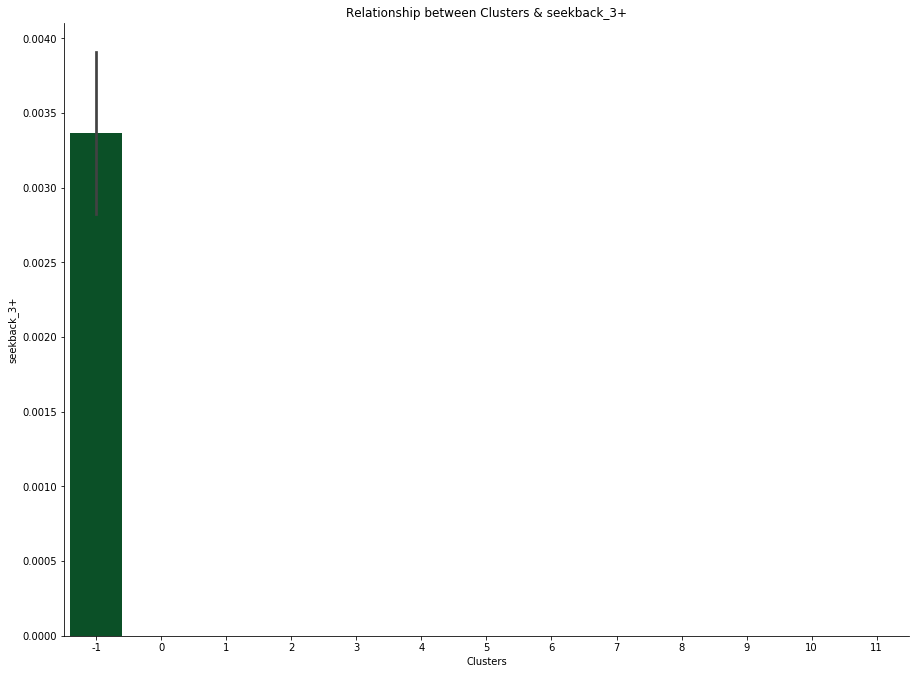

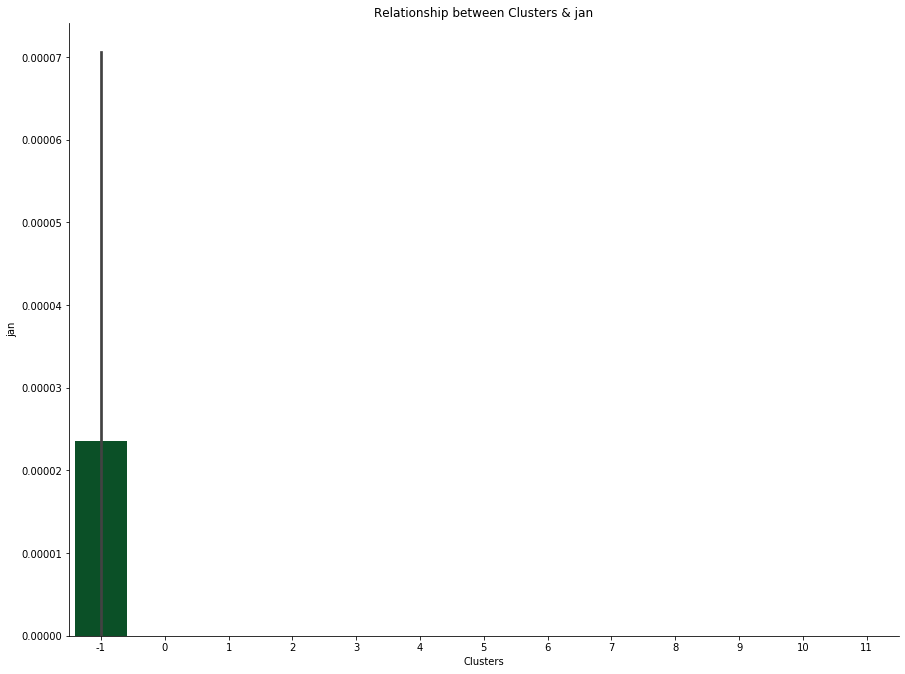

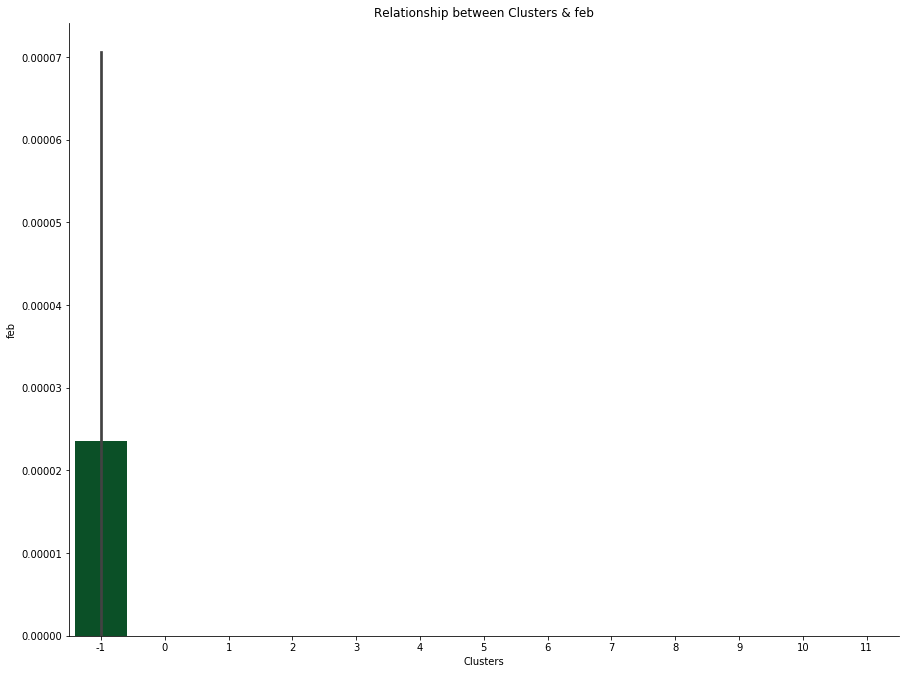

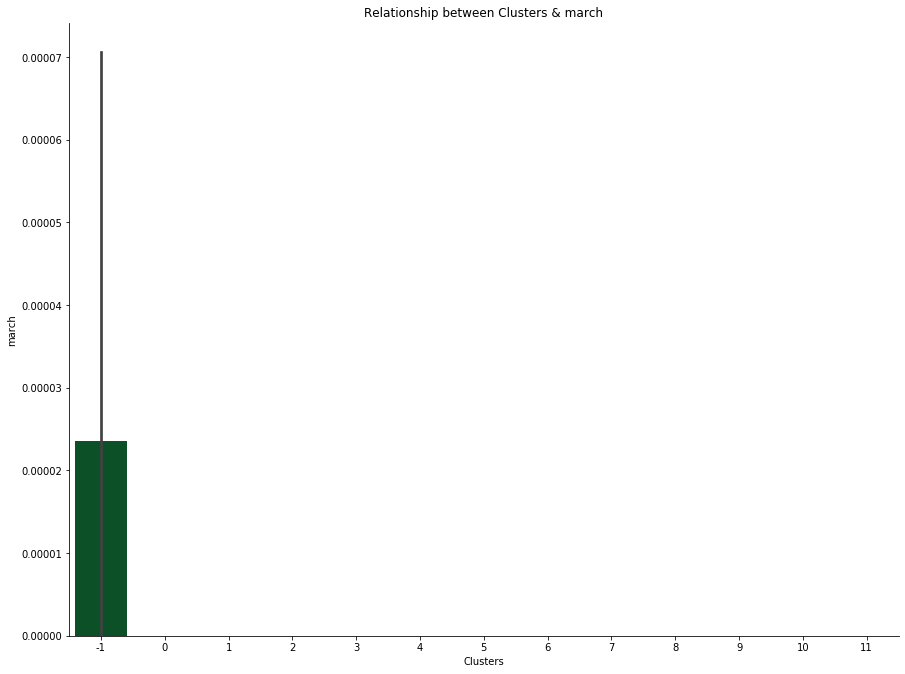

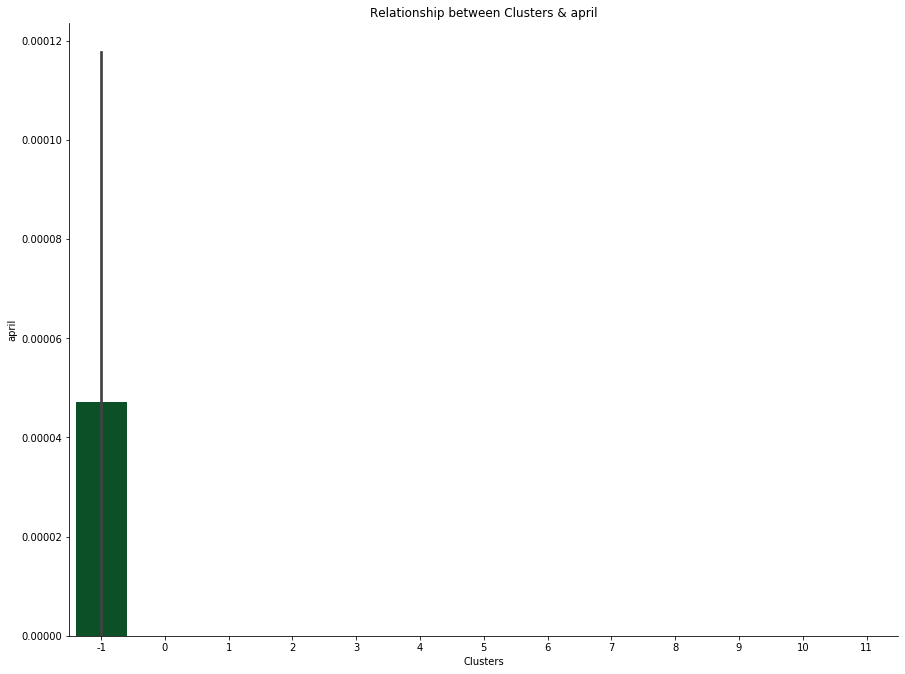

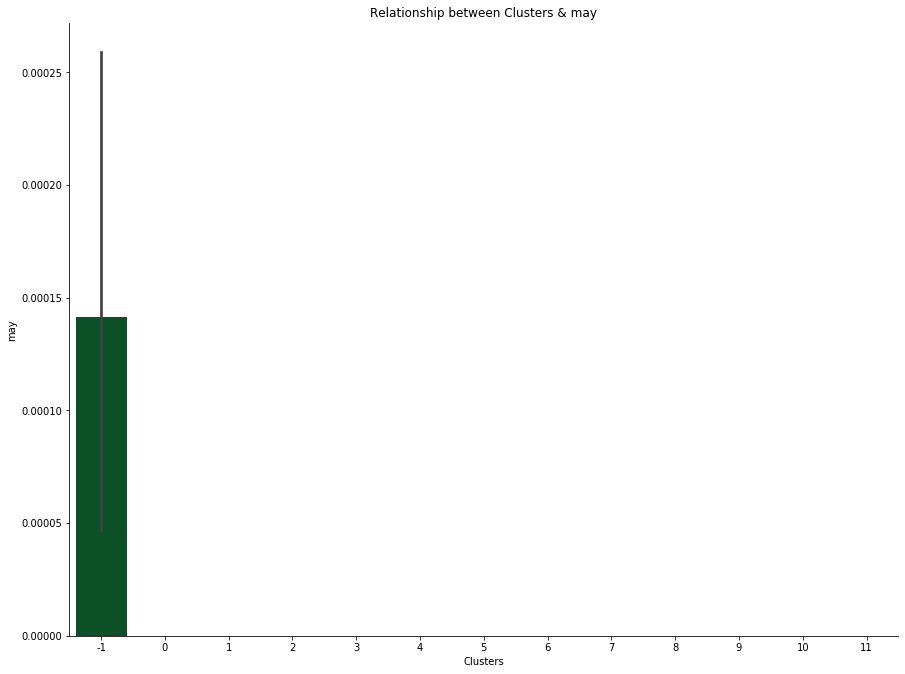

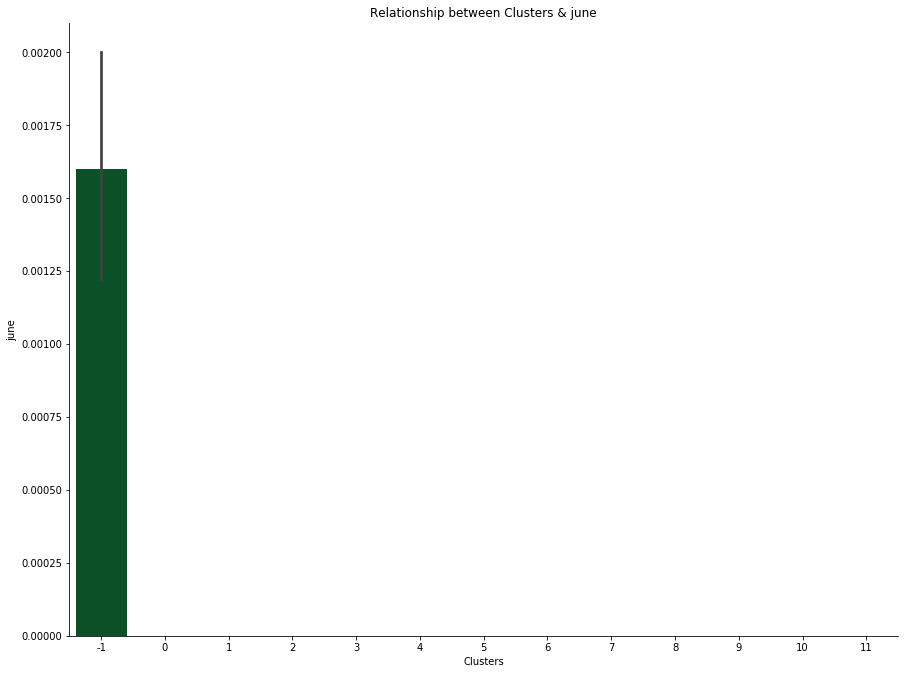

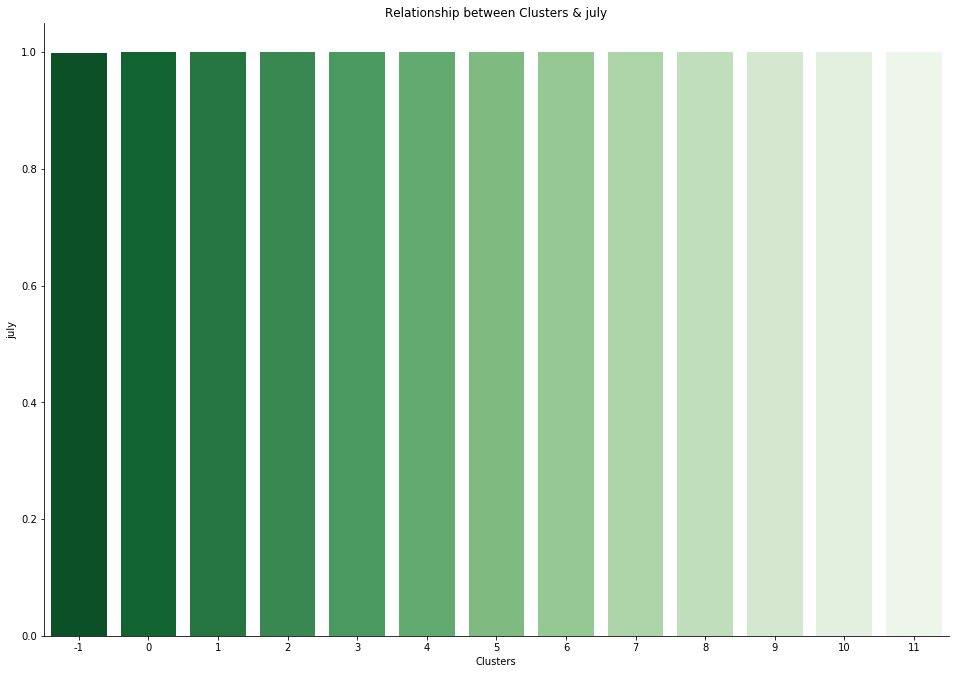

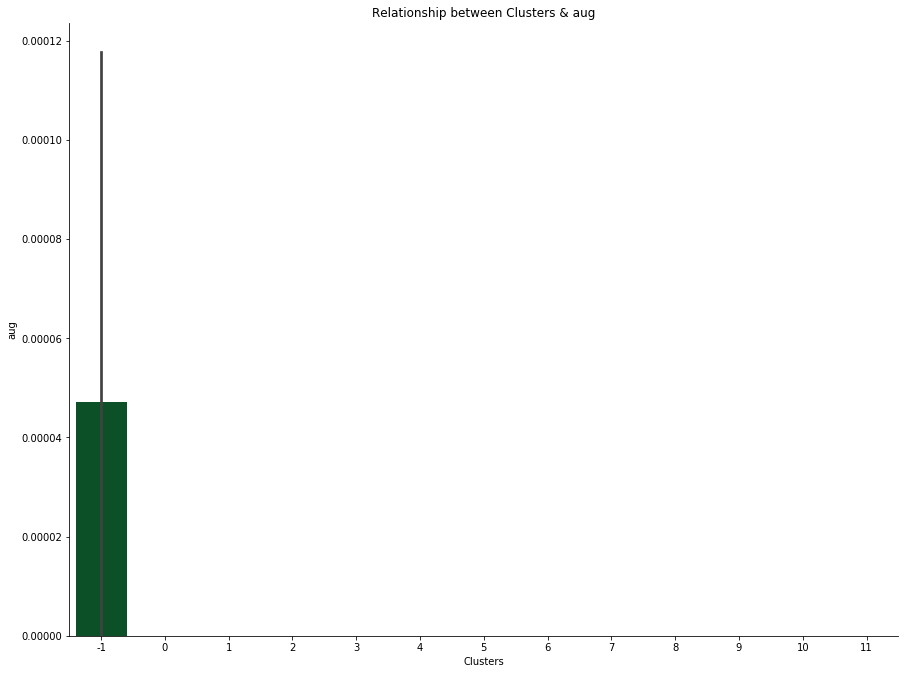

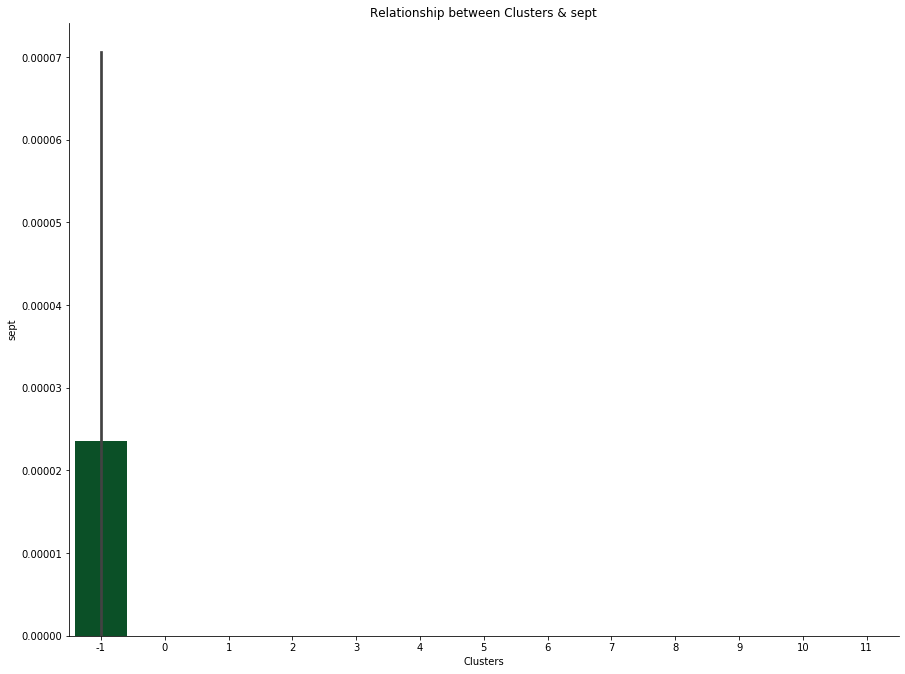

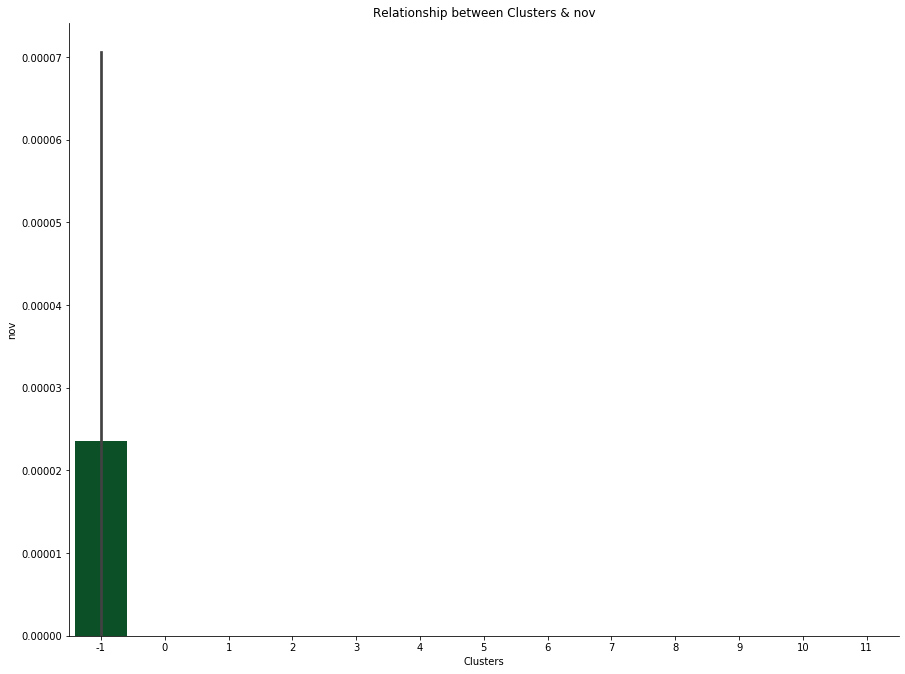

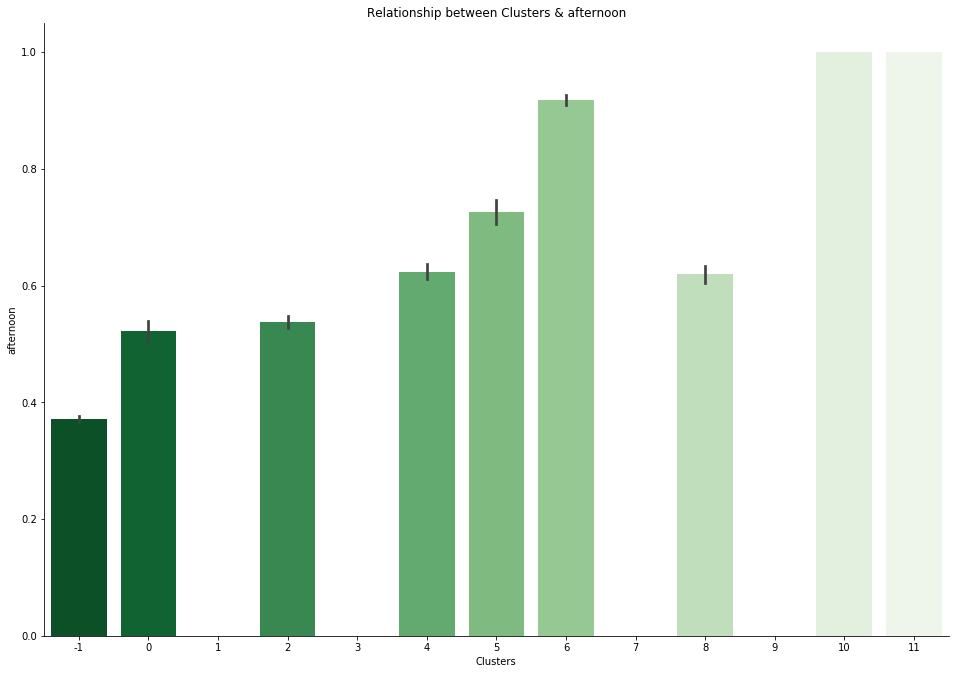

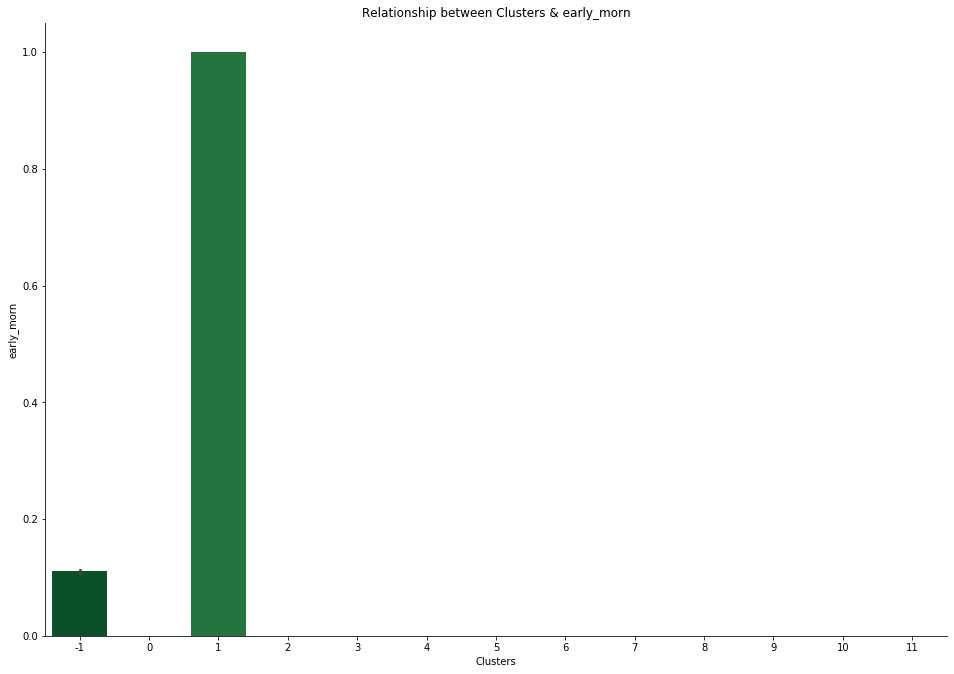

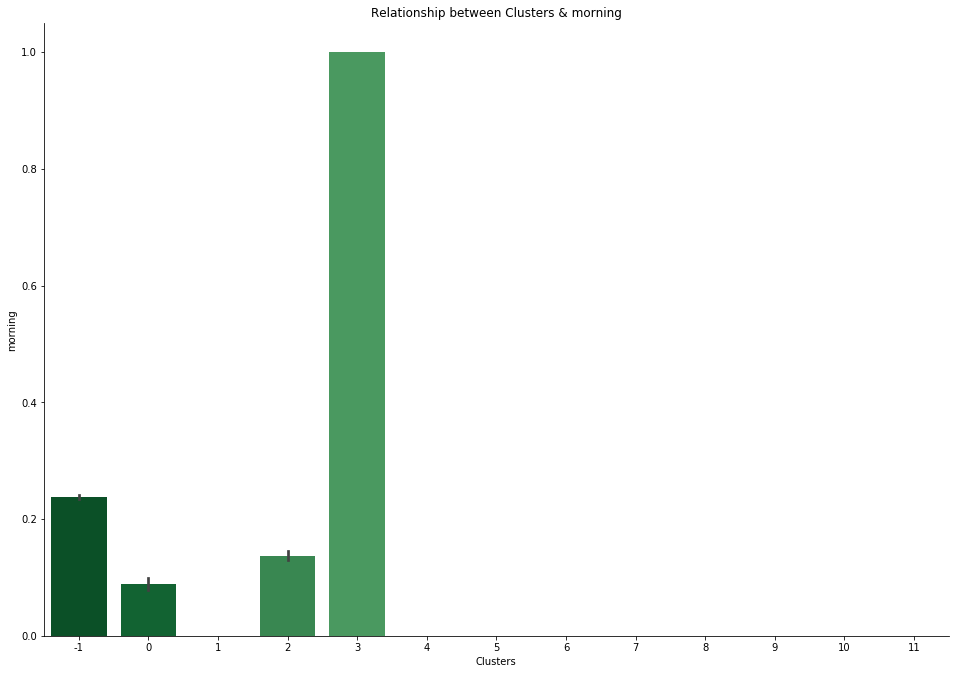

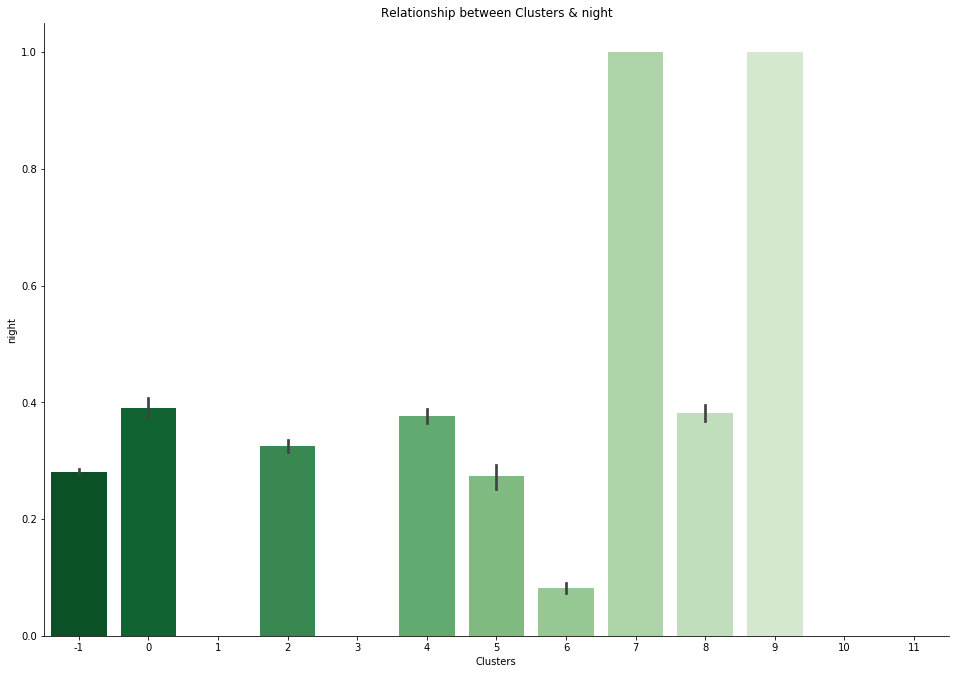

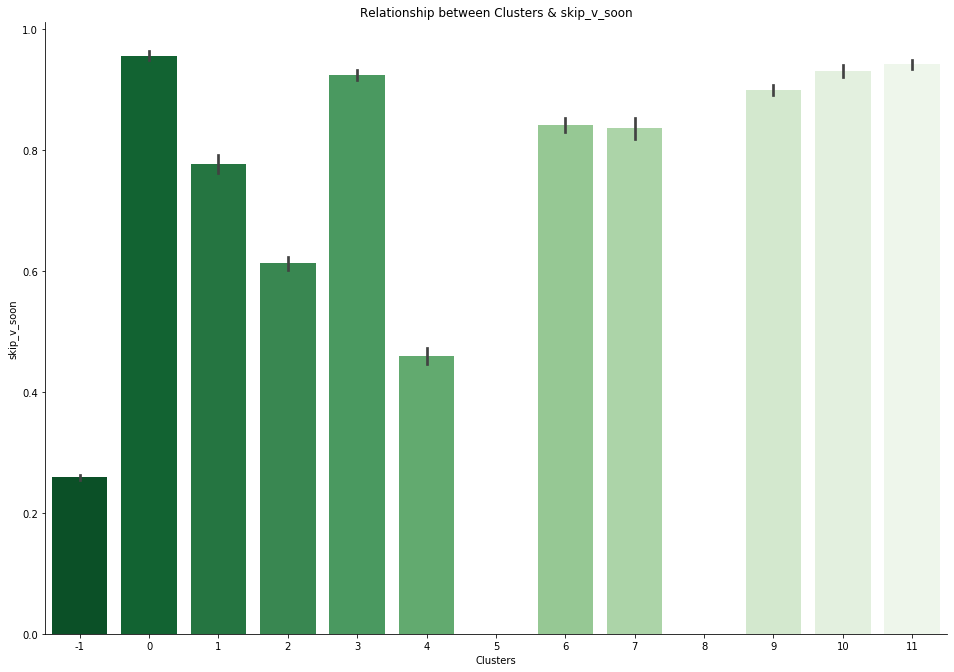

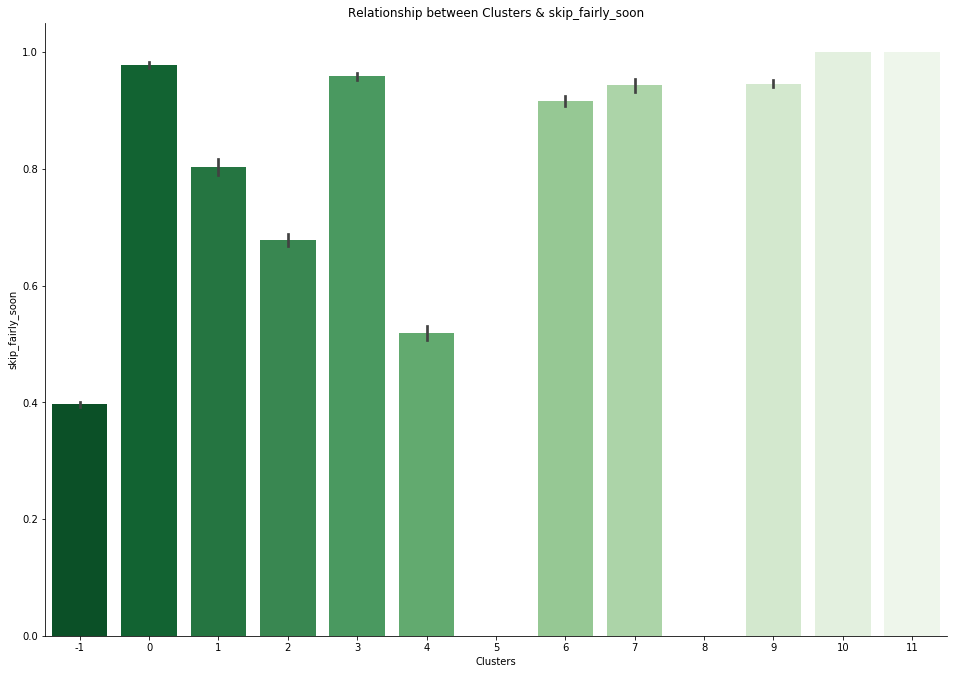

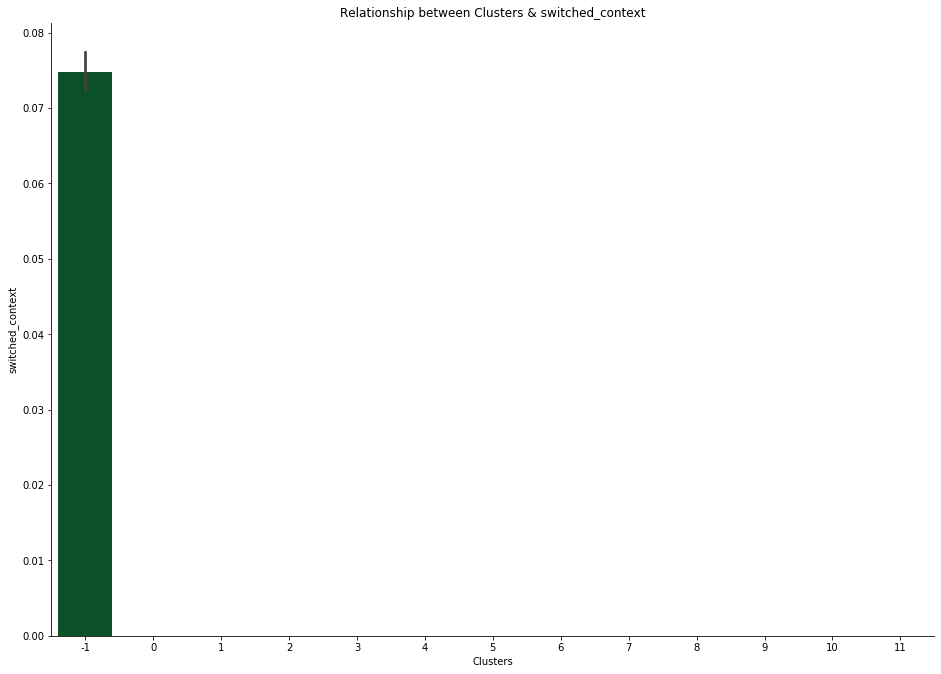

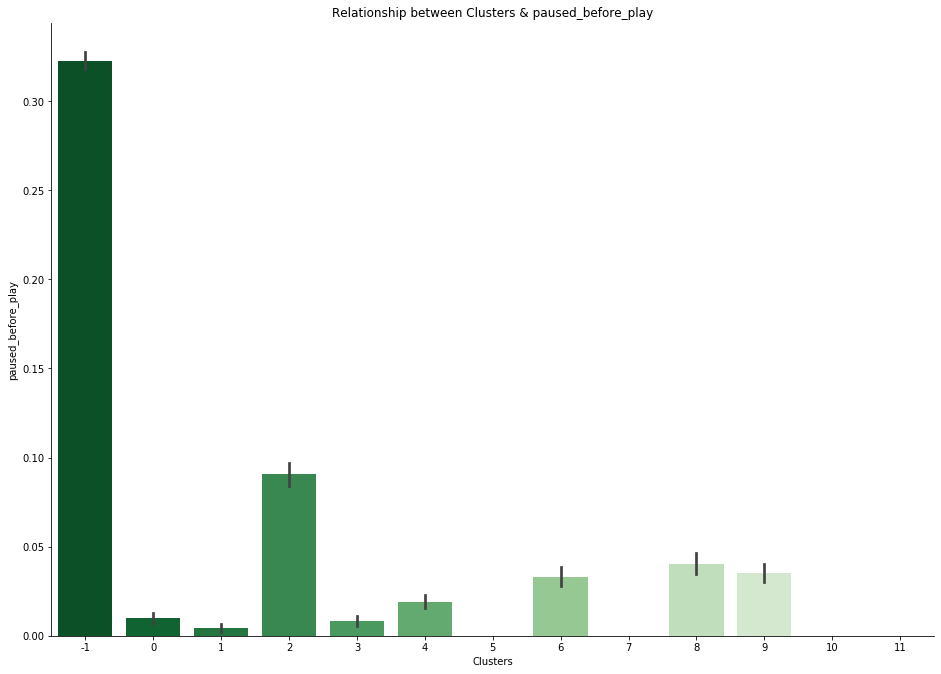

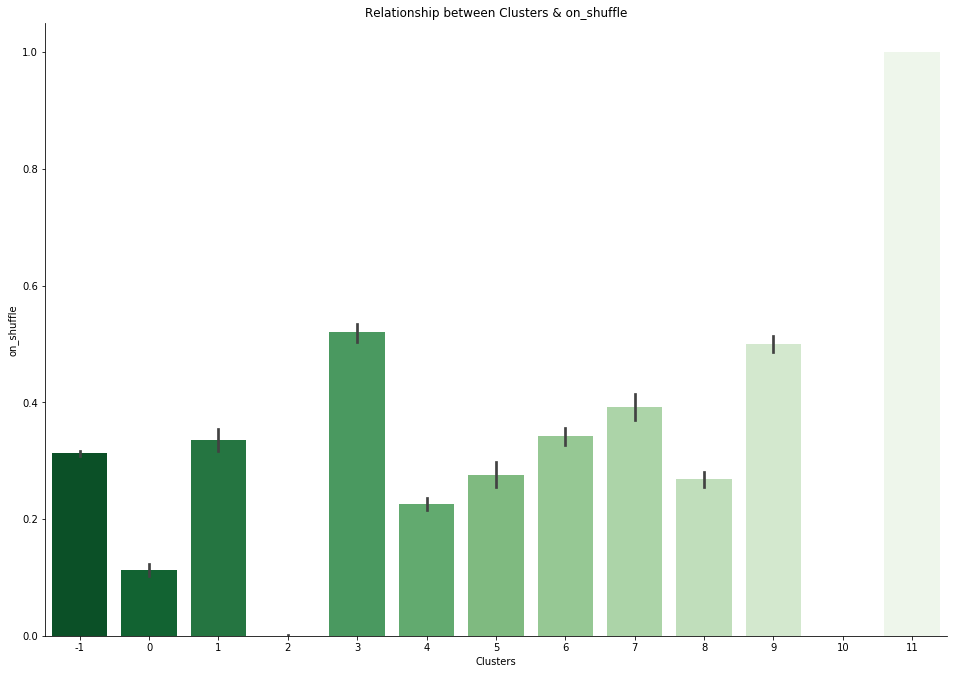

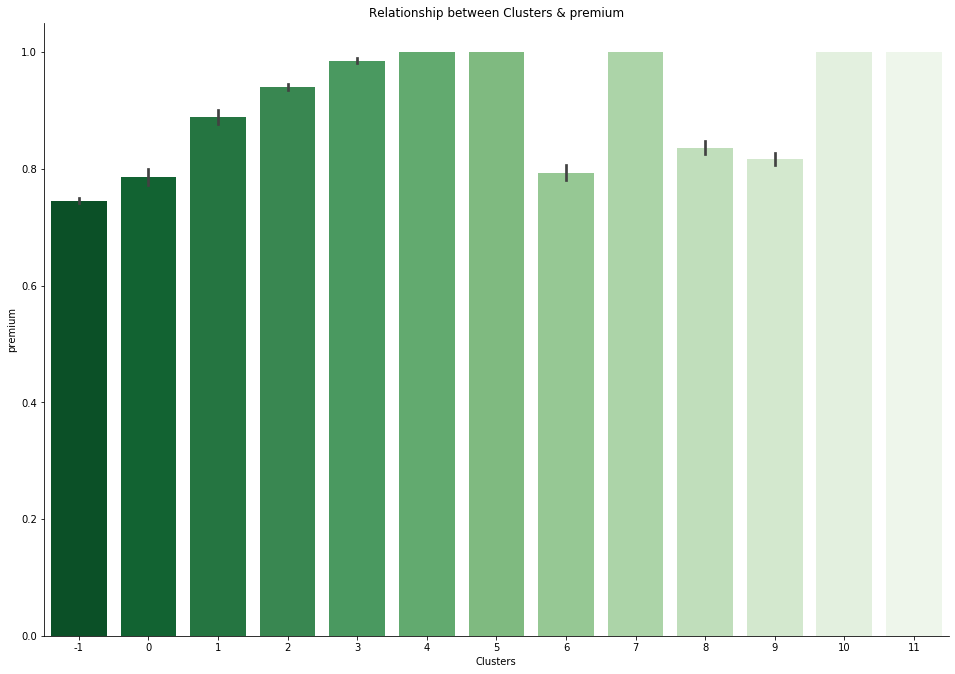

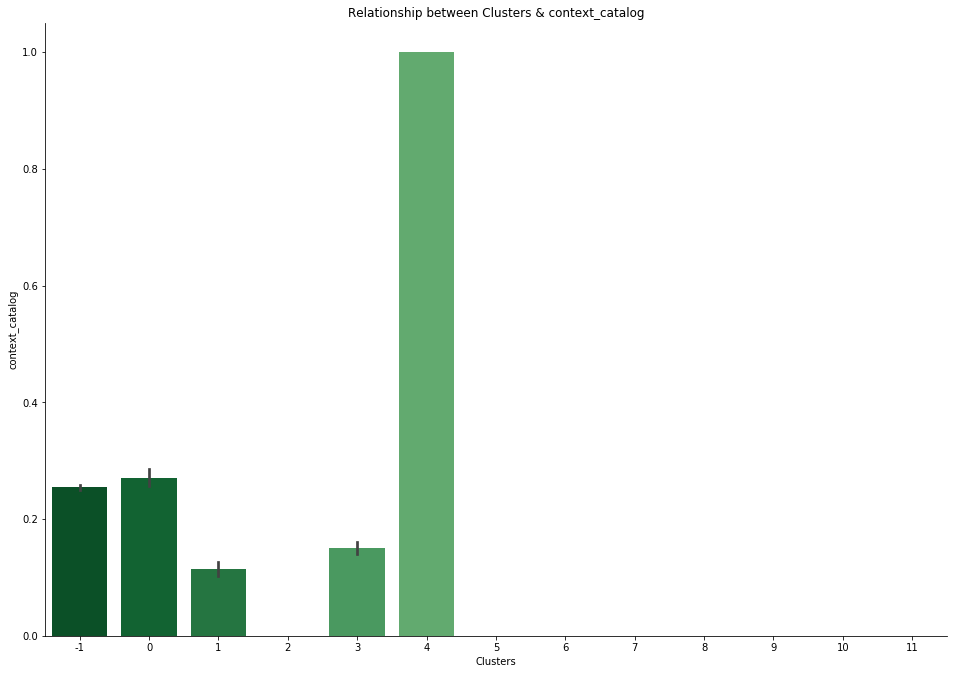

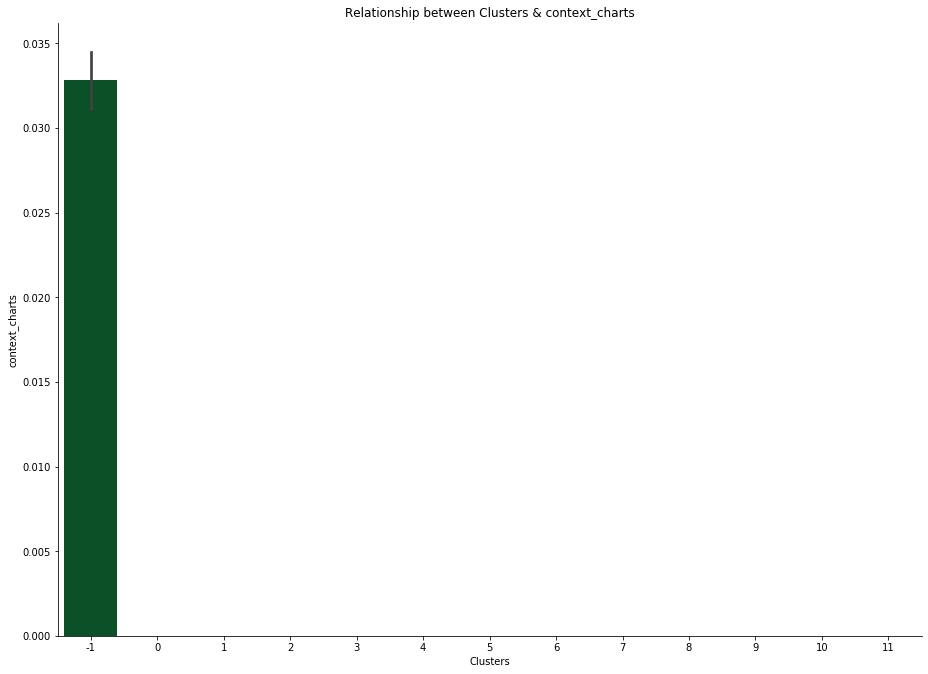

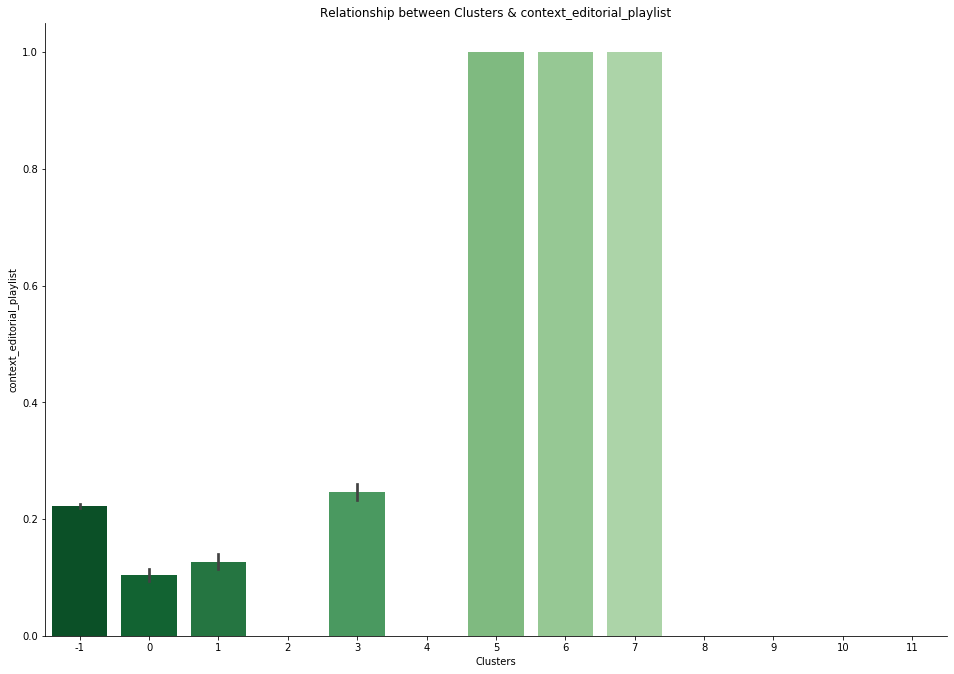

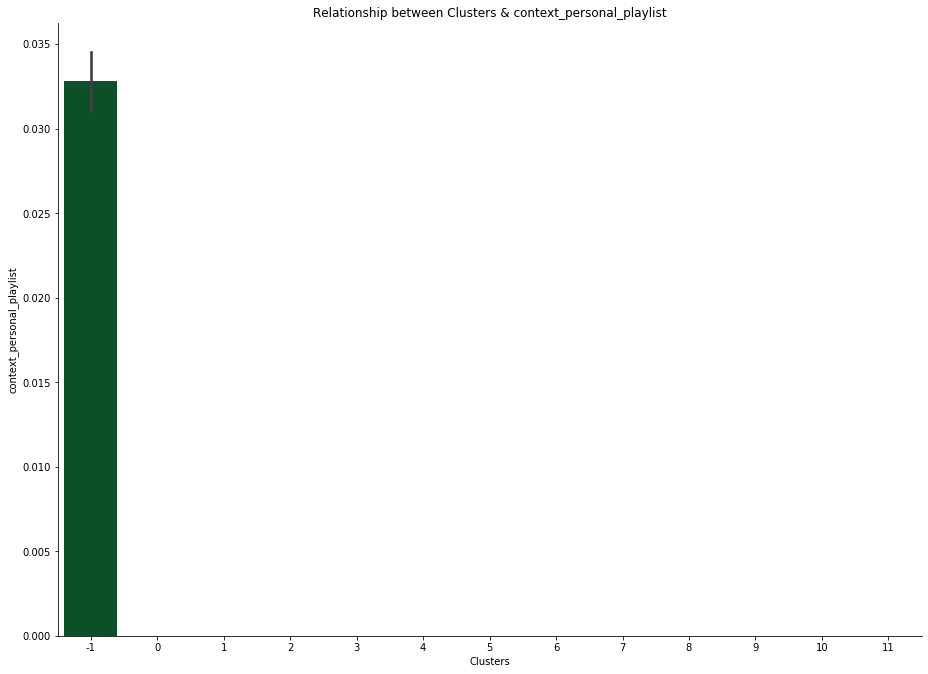

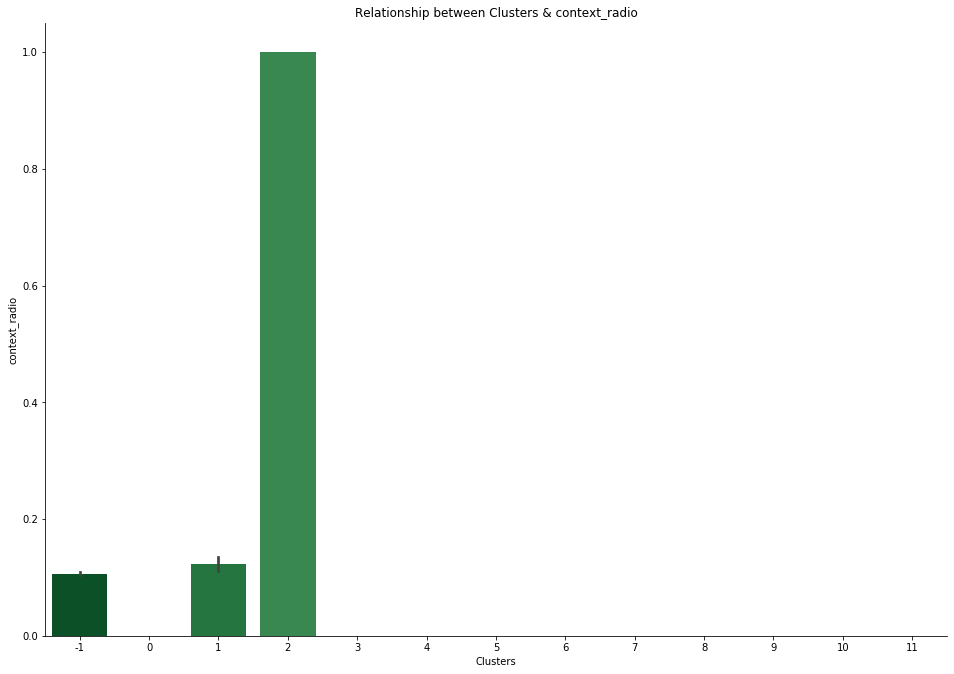

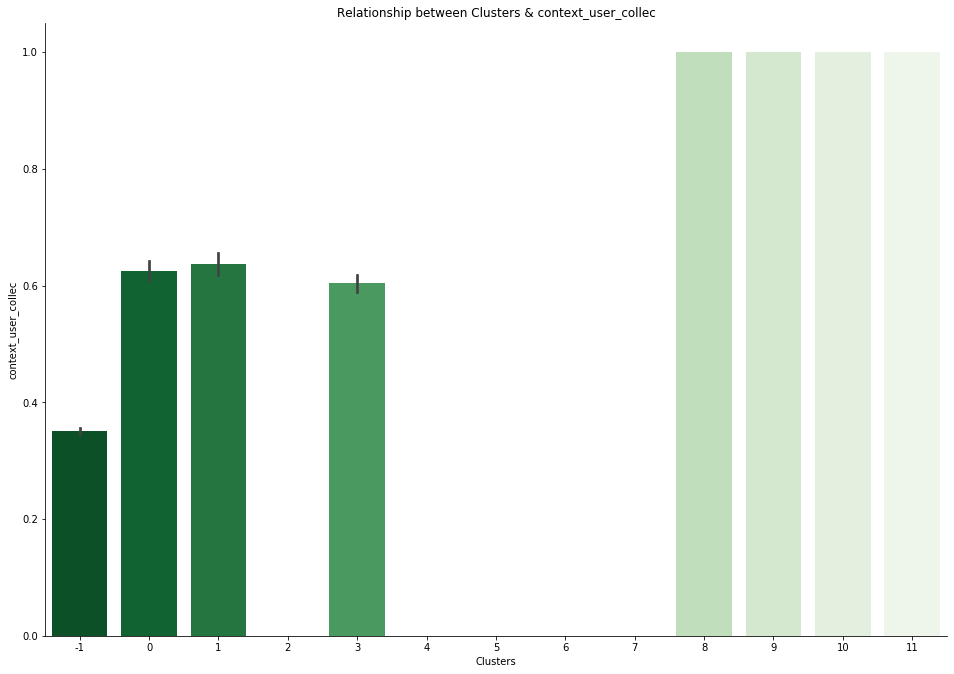

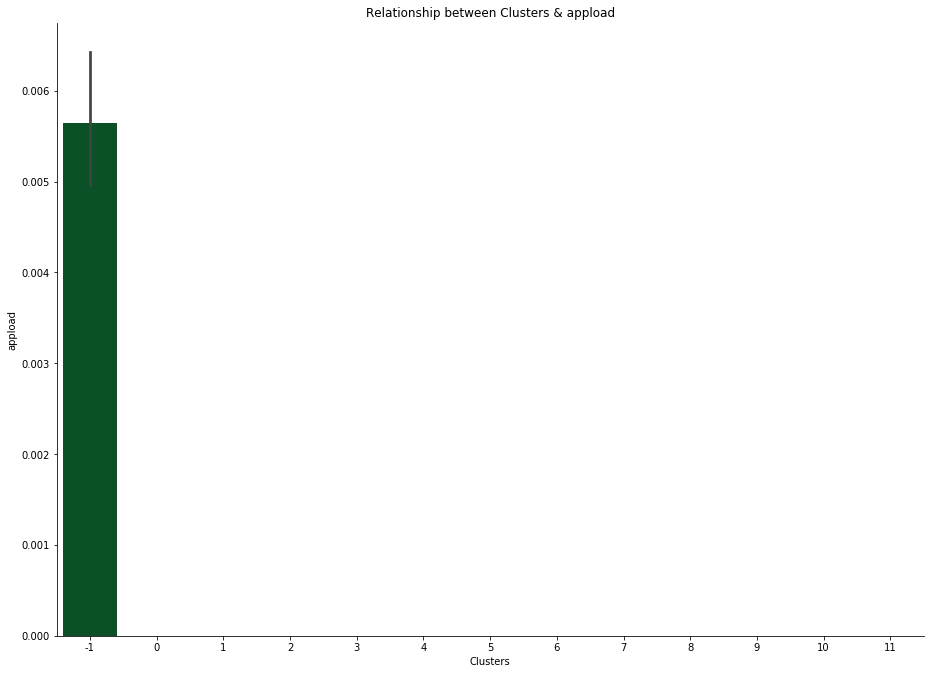

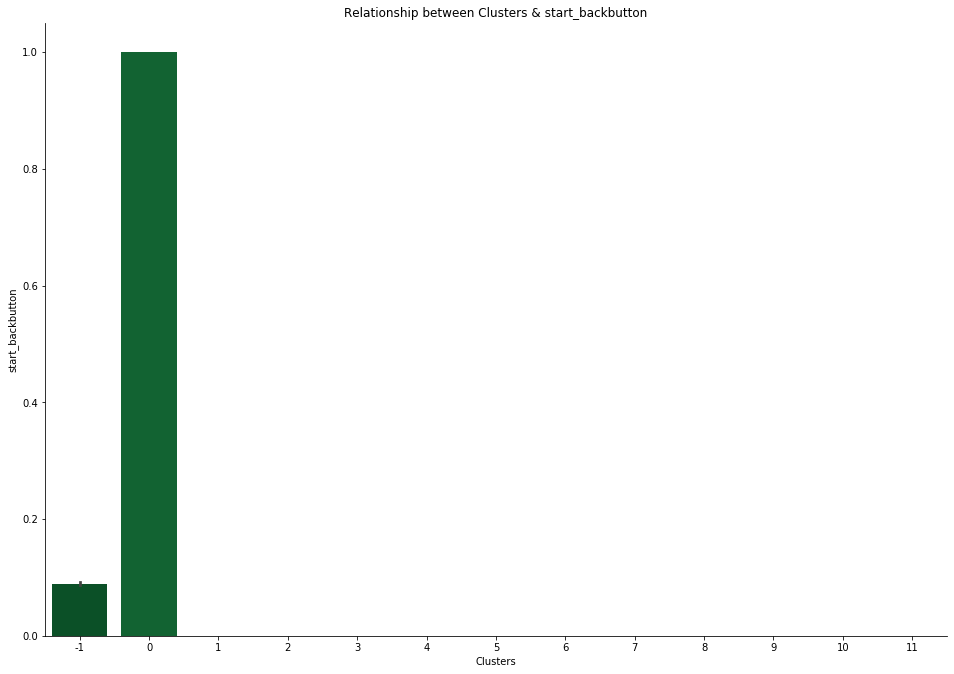

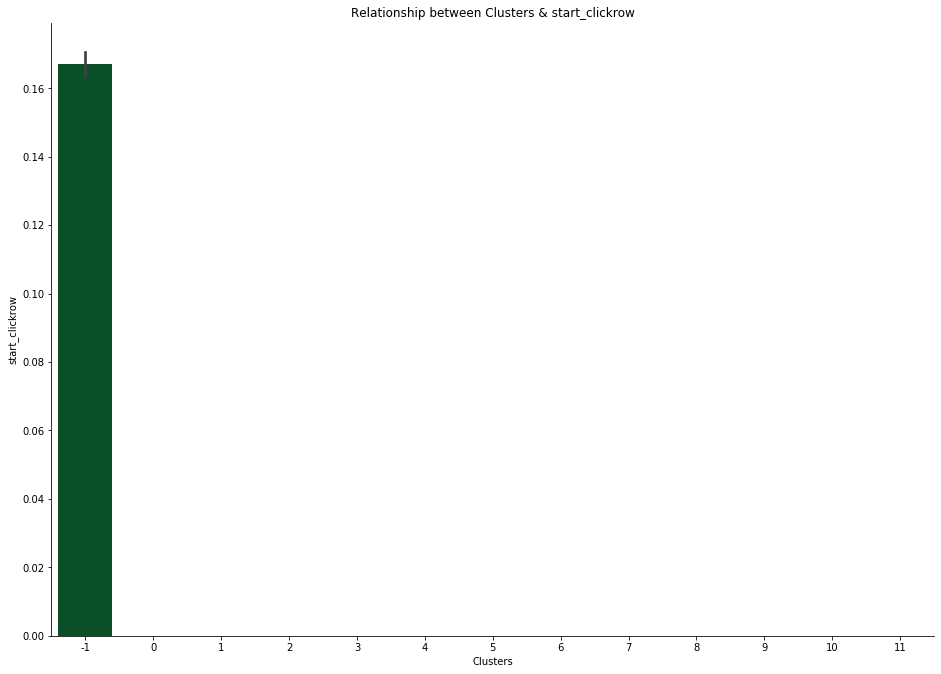

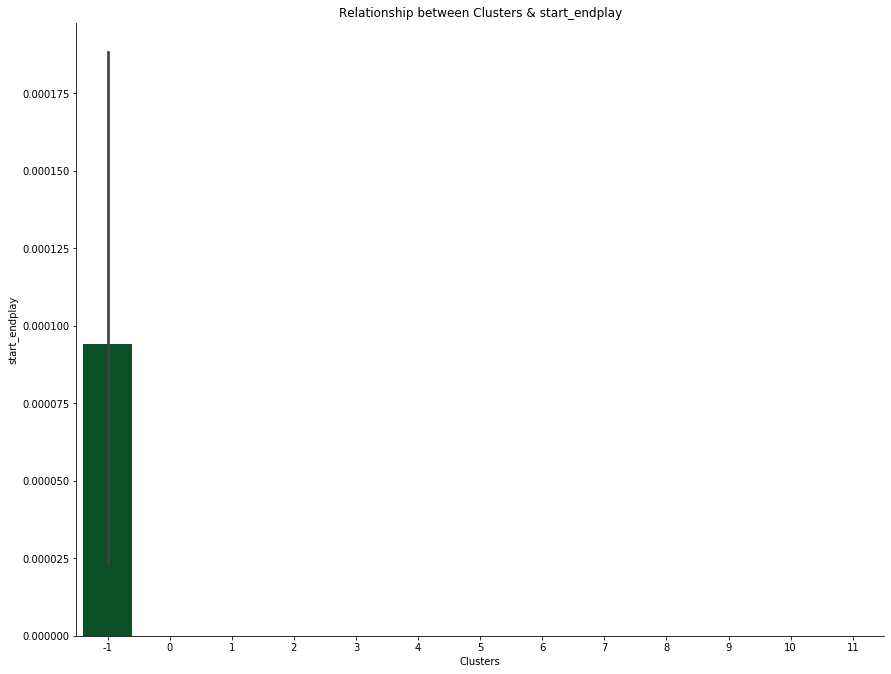

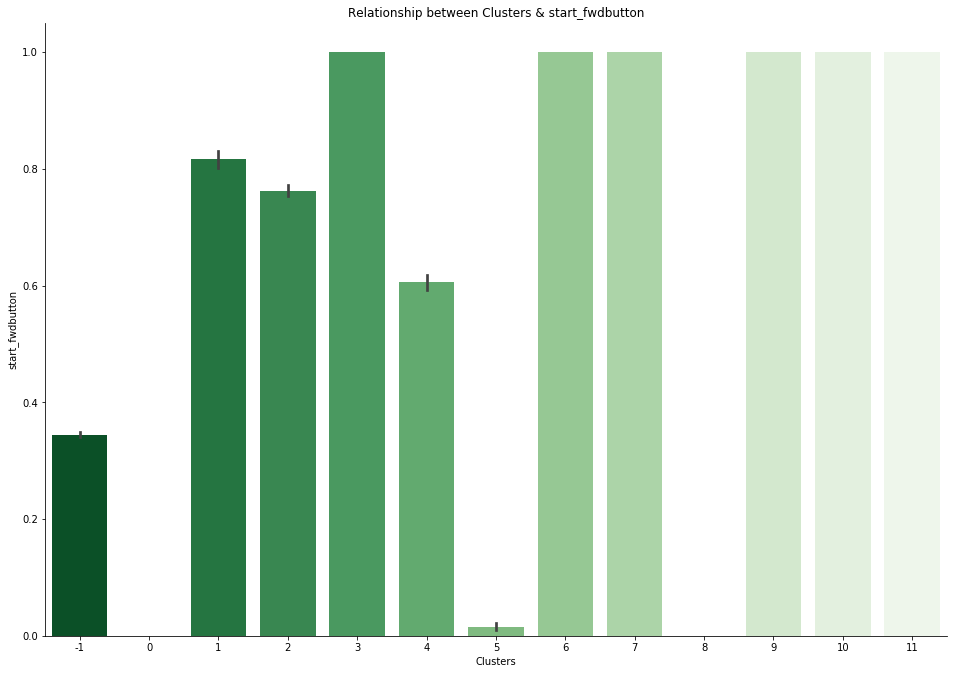

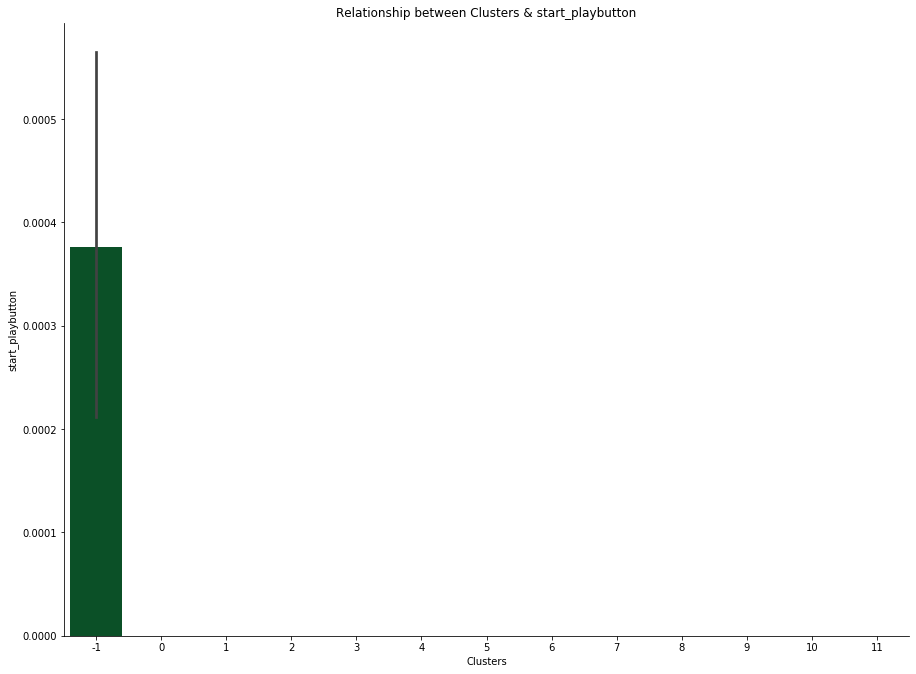

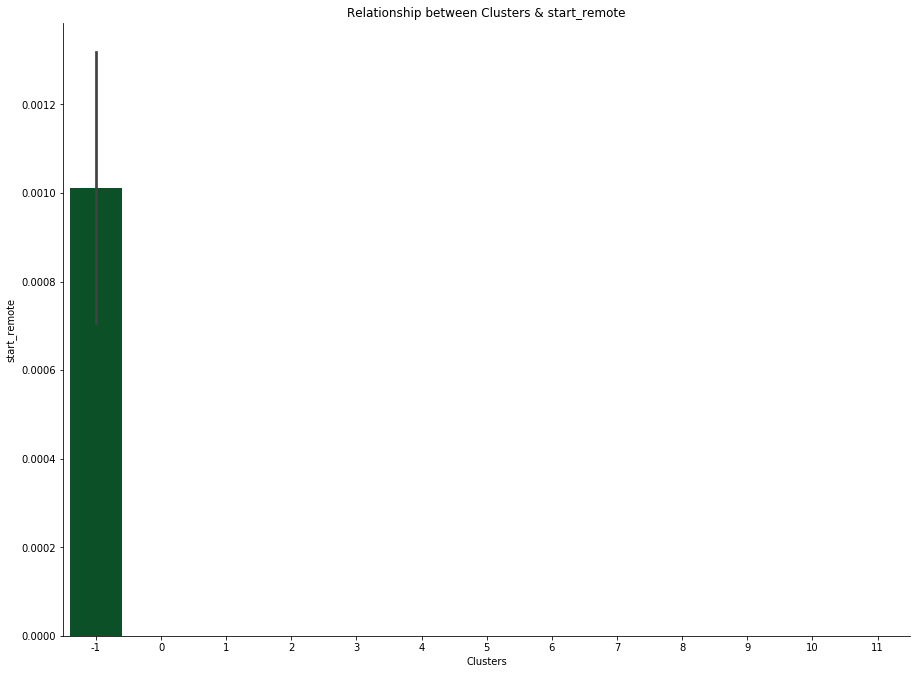

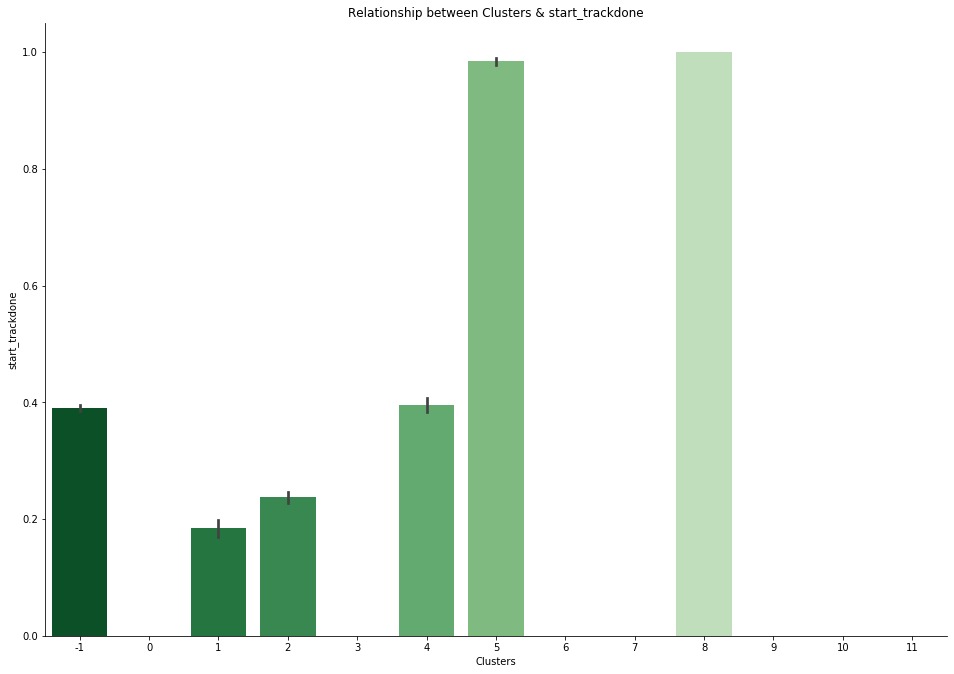

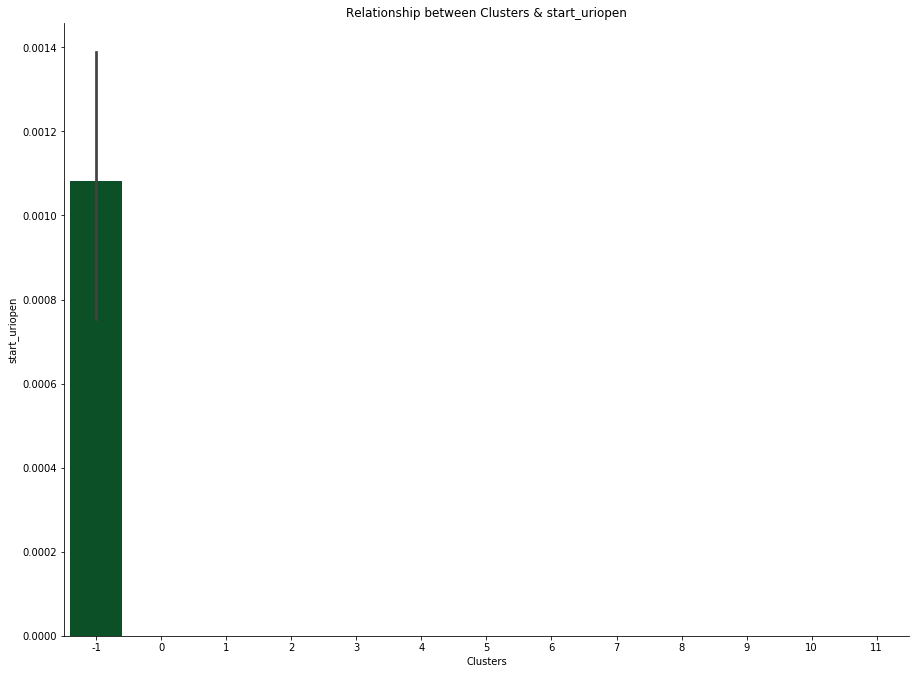

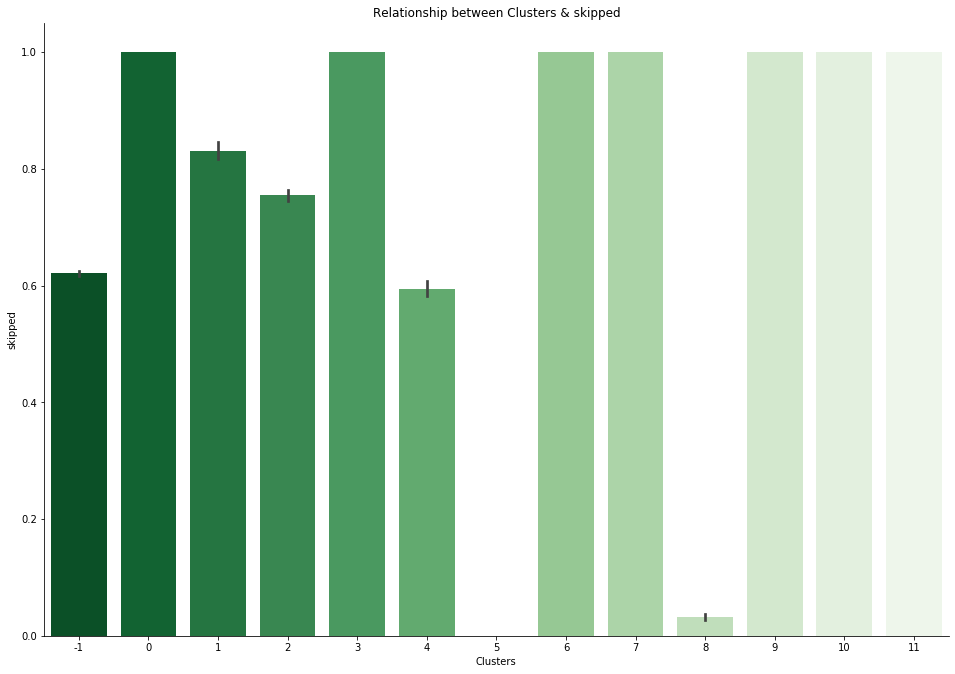

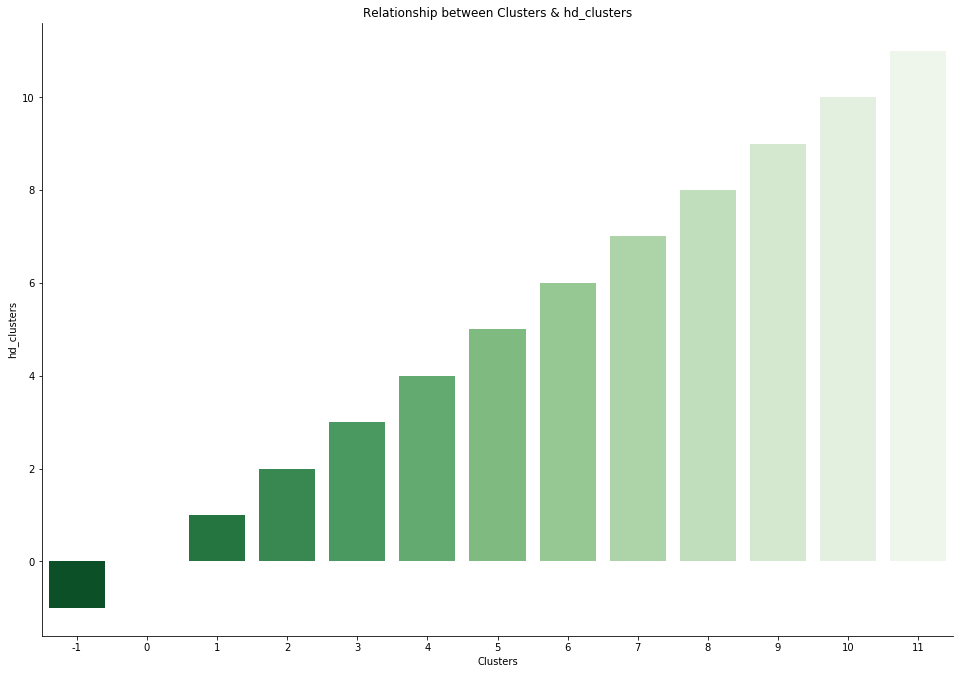

In [220]:
# Let's look at all of the vars in the dummies here, and later we can choose which will go in the presentation
for col in Xclusters_track10_dummies:
    sns.catplot(x='hd_clusters', y=col, kind='bar', palette='Greens_r', data=Xclusters_track10_dummies)
    plt.title('Relationship between Clusters & {}'.format(col))
    plt.xlabel('Clusters')
    plt.ylabel('{}'.format(col))
    plt.gcf().set_size_inches(15,10)
    plt.show()

Now we'll add the clusters as an array back into the track20 df so we can investigate them further

In [221]:
# First checking length of cluster labels array is same length as track20 df
print(len(track20_hd_labels))

89672


In [222]:
# Placing each observation's cluster assignment in the df 
Xclusters_track20_dummies['hd_clusters'] = pd.Series(track20_hd_labels, index=Xclusters_track20_dummies.index)

In [223]:
# Look at the new column; make sure it's okay
Xclusters_track20_dummies.head(20)

no_seekfwd  seekfwd_1to2  seekfwd_3+  no_seekback  seekback_1to2  \
0           1             0           0            1              0   
1           1             0           0            1              0   
1           1             0           0            1              0   
1           1             0           0            1              0   
1           1             0           0            1              0   
2           1             0           0            1              0   
3           1             0           0            1              0   
3           1             0           0            1              0   
3           1             0           0            1              0   
4           1             0           0            1              0   
5           1             0           0            1              0   
6           1             0           0            1              0   
6           1             0           0            1              0   
6           1             0           0            1              0   
6           1             0           0            0              1   
8           1             0           0            1              0   
9           1             0           0            1              0   
9           0             1           0            1              0   
9           1             0           0            1              0   
9           1             0           0            1              0   

   seekback_3+  jan  feb  march  april  ...  start_backbutton  start_clickrow  \
0            0    0    0      0      0  ...                 0               0   
1            0    0    0      0      0  ...                 0               0   
1            0    0    0      0      0  ...                 0               0   
1            0    0    0      0      0  ...                 0               0   
1            0    0    0      0      0  ...                 0               0   
2            0    0    0      0      0  ...                 0               0   
3            0    0    0      0      0  ...                 0               0   
3            0    0    0      0      0  ...                 1               0   
3            0    0    0      0      0  ...                 1               0   
4            0    0    0      0      0  ...                 0               0   
5            0    0    0      0      0  ...                 0               0   
6            0    0    0      0      0  ...                 0               0   
6            0    0    0      0      0  ...                 0               0   
6            0    0    0      0      0  ...                 0               0   
6            0    0    0      0      0  ...                 1               0   
8            0    0    0      0      0  ...                 0               0   
9            0    0    0      0      0  ...                 0               0   
9            0    0    0      0      0  ...                 0               1   
9            0    0    0      0      0  ...                 0               0   
9            0    0    0      0      0  ...                 0               0   

   start_endplay  start_fwdbutton  start_playbutton  start_remote  \
0              0                1                 0             0   
1              0                0                 0             0   
1              0                1                 0             0   
1              0                0                 0             0   
1              0                1                 0             0   
2              0                0                 0             0   
3              0                0                 0             0   
3              0                0                 0             0   
3              0                0                 0             0   
4              0                0                 0             0   
5              0                1                 

In [224]:
# See the cluster breakdown
print(Xclusters_track20_dummies['hd_clusters'].unique())
print(Xclusters_track20_dummies['hd_clusters'].value_counts())

[ 6  9  4  1 -1  0 10  8 11  3  5  2  7]
-1     45681
 6      7408
 5      5692
 8      5236
 3      4211
 4      3471
 10     3409
 1      3000
 9      2979
 0      2866
 11     2222
 2      1792
 7      1705
Name: hd_clusters, dtype: int64


Next up, let's do some barplots with the clusters to investigate a bit more what they mean.

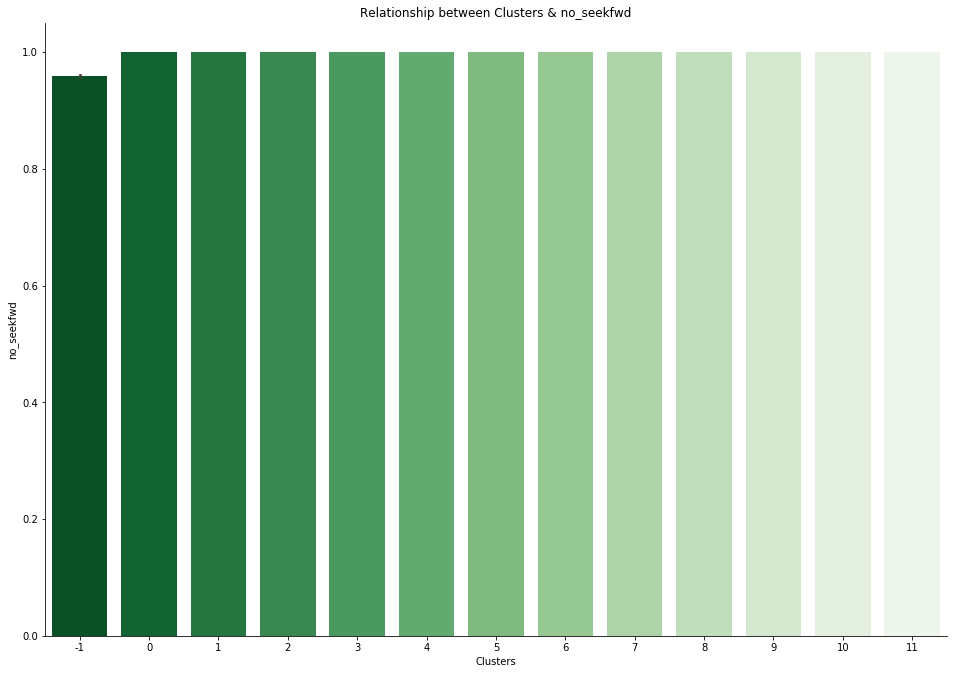

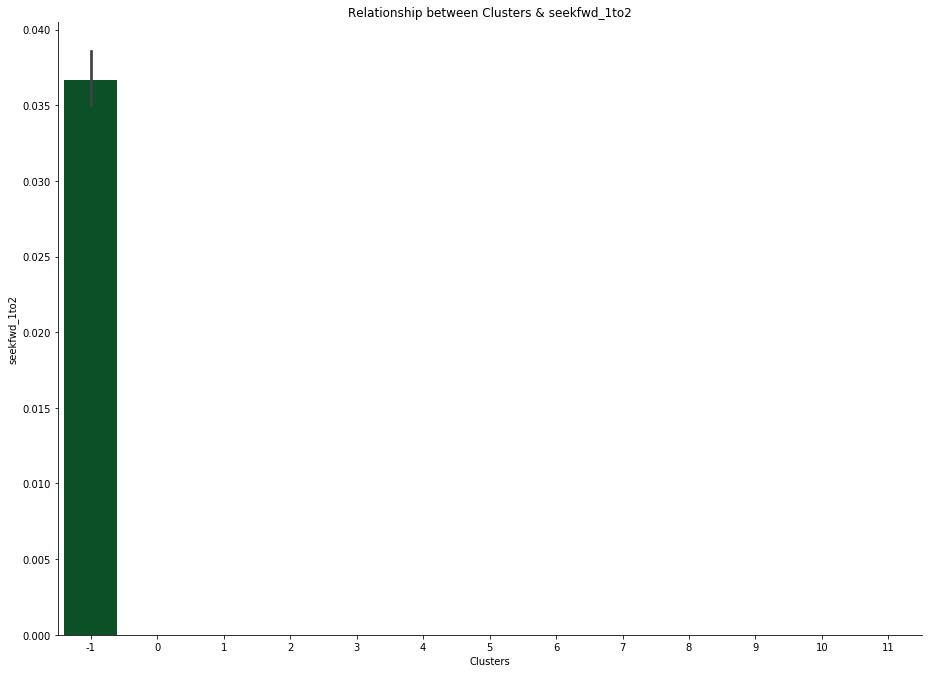

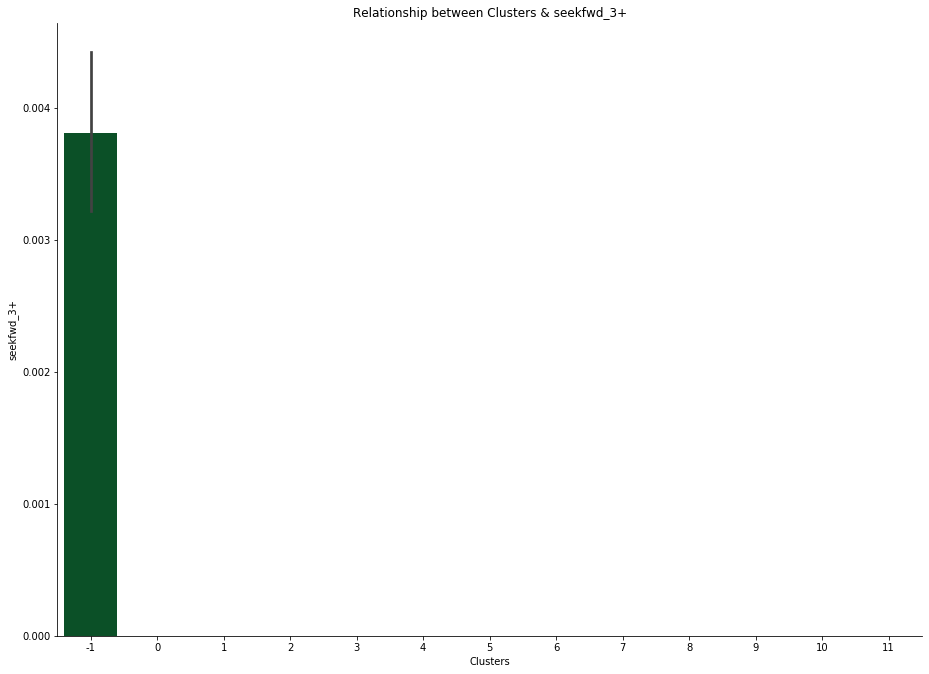

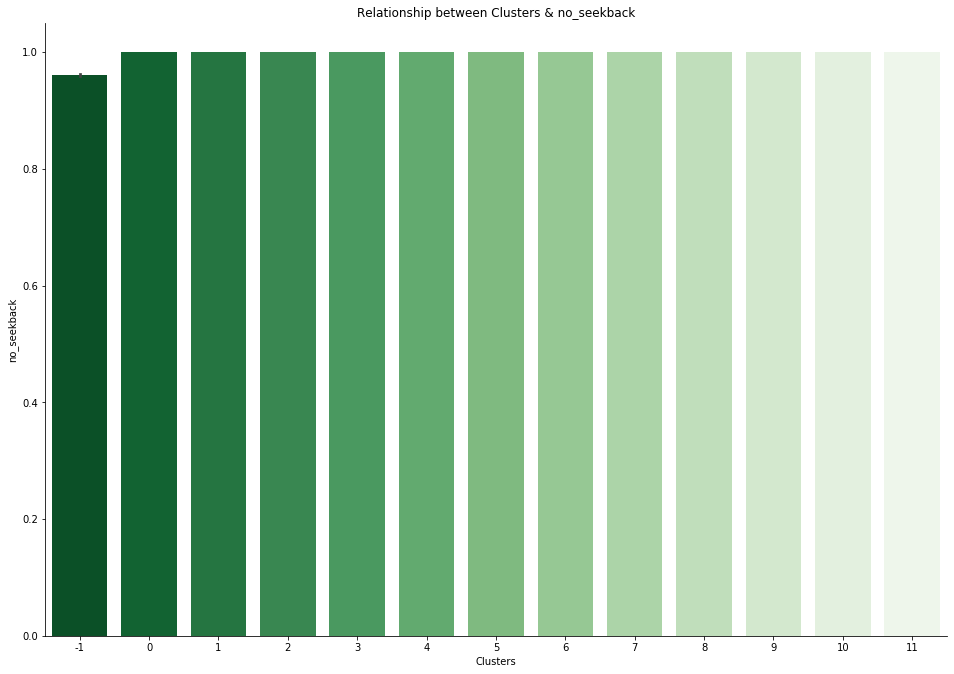

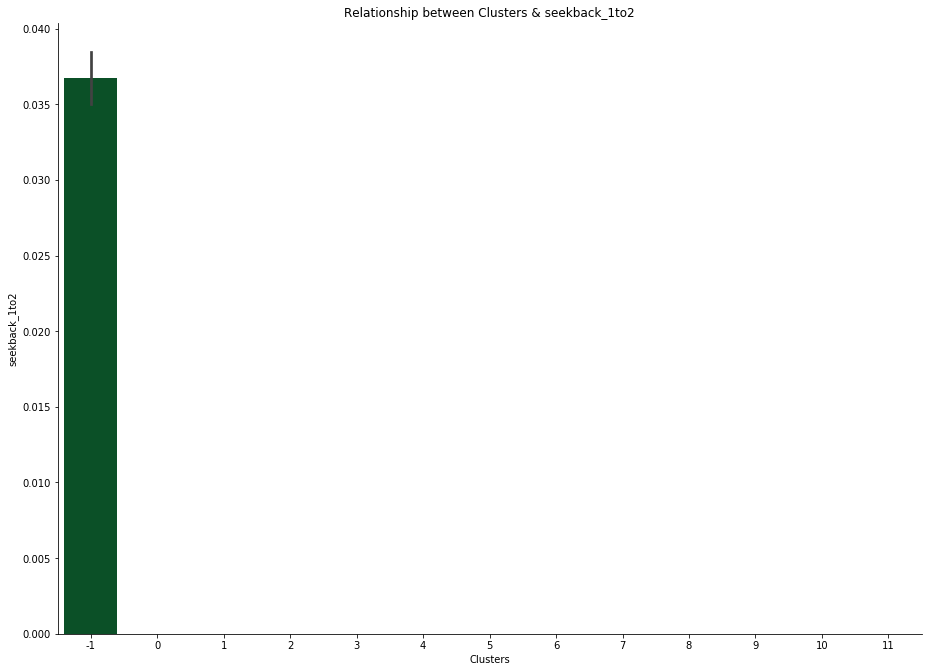

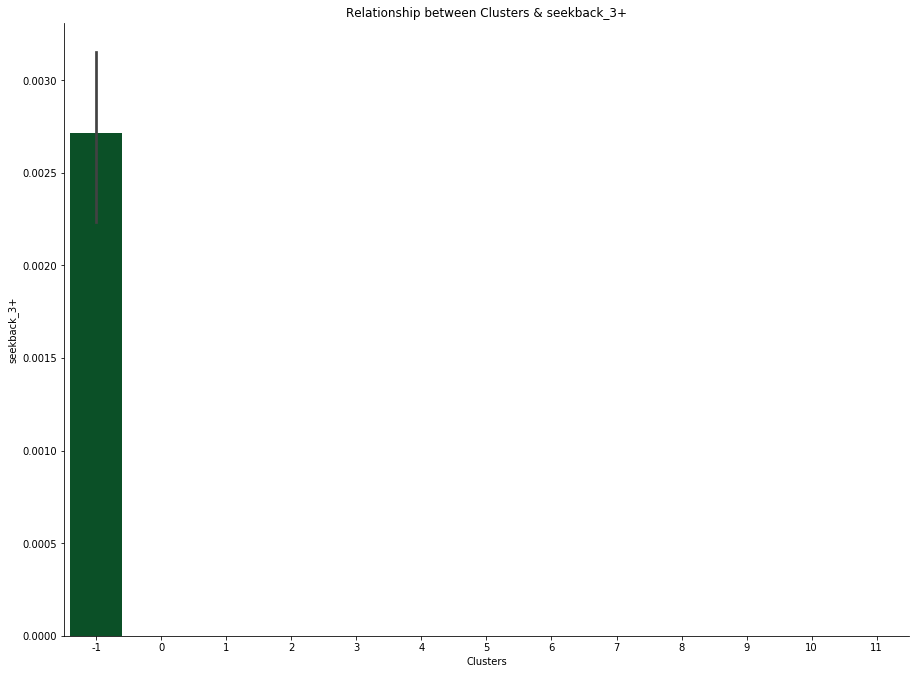

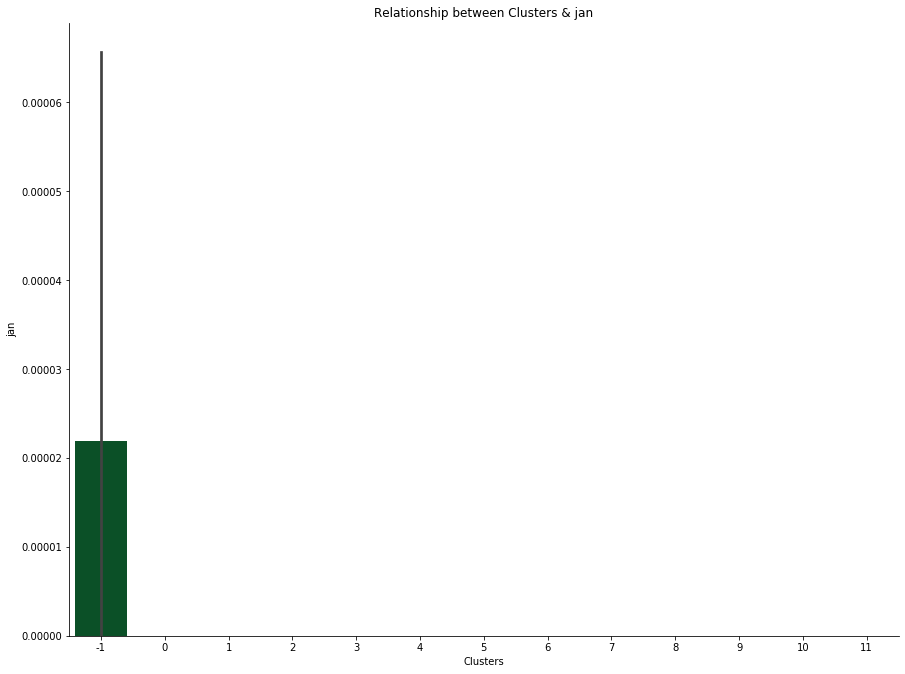

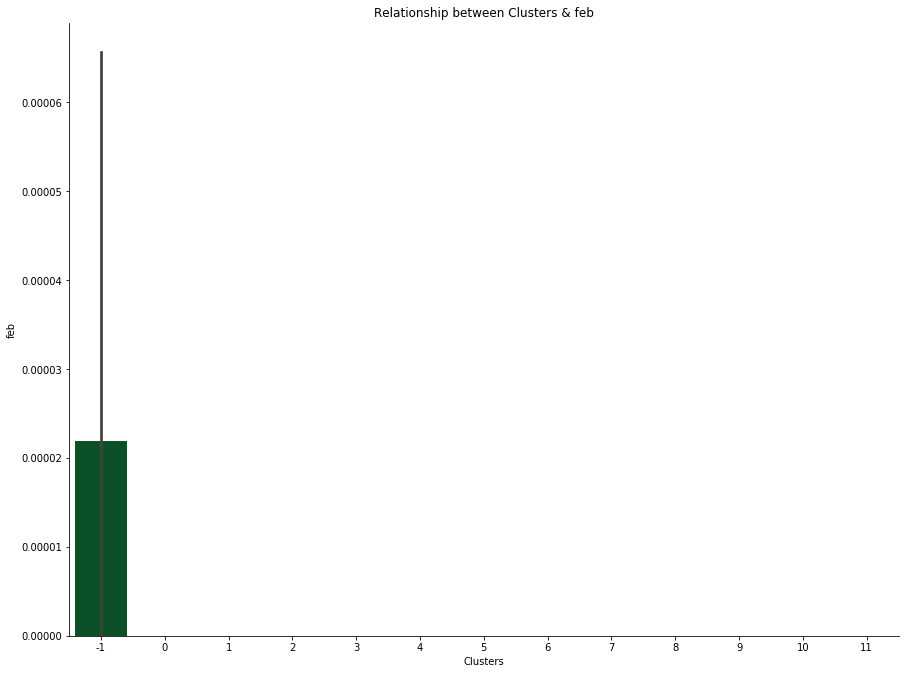

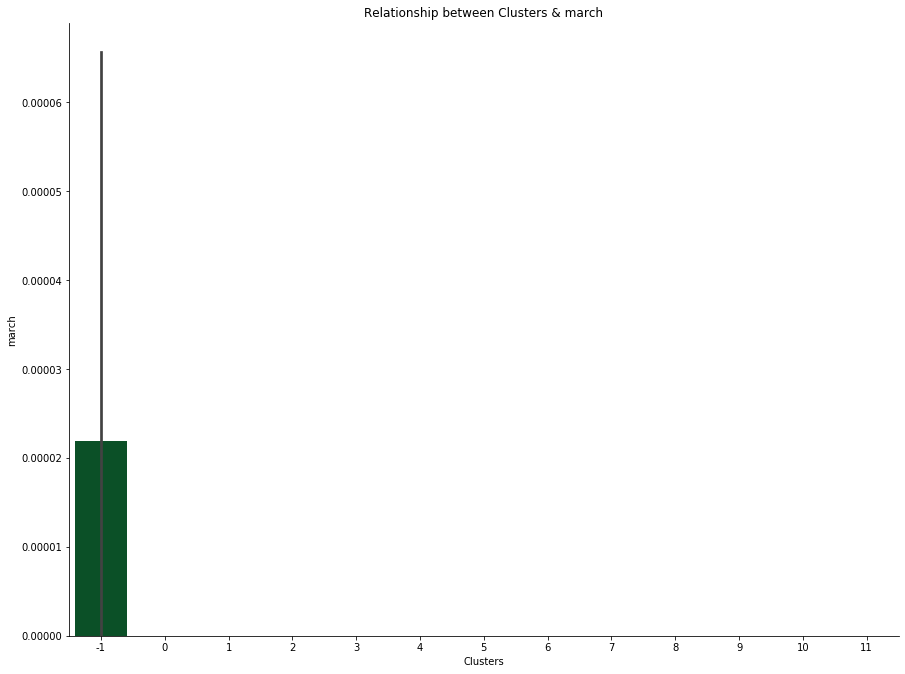

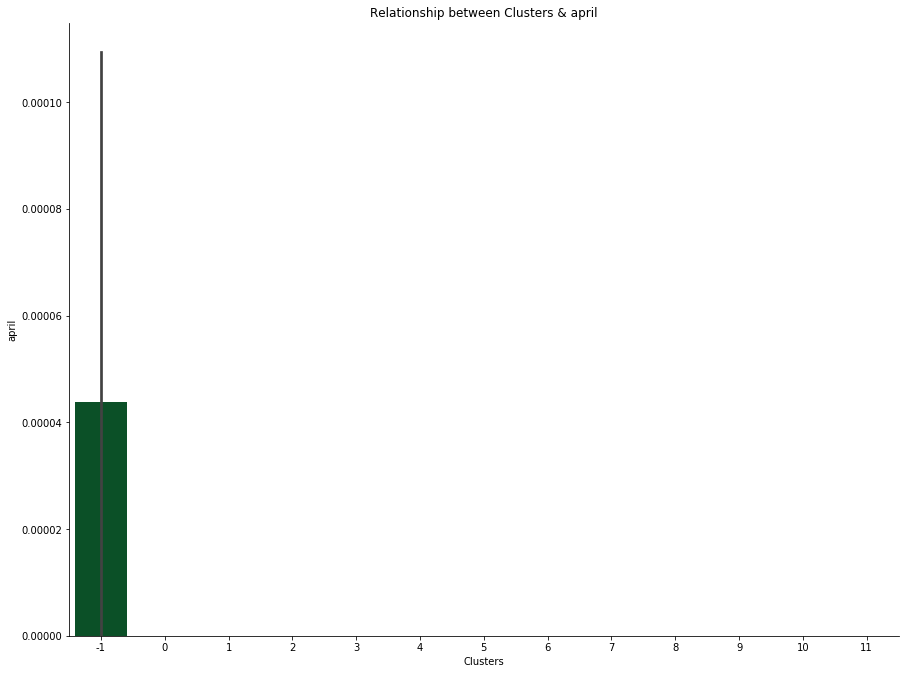

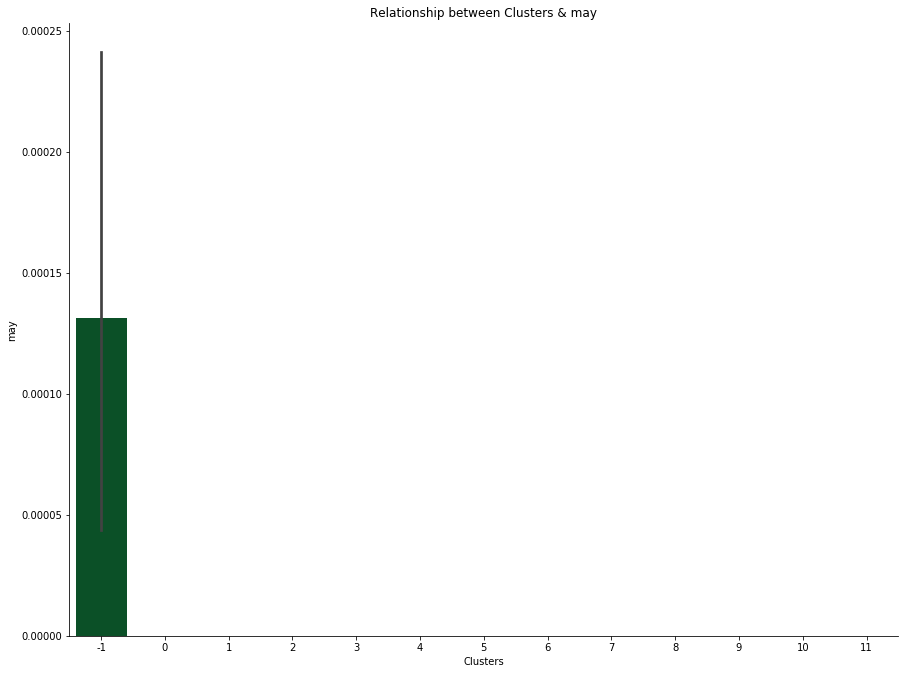

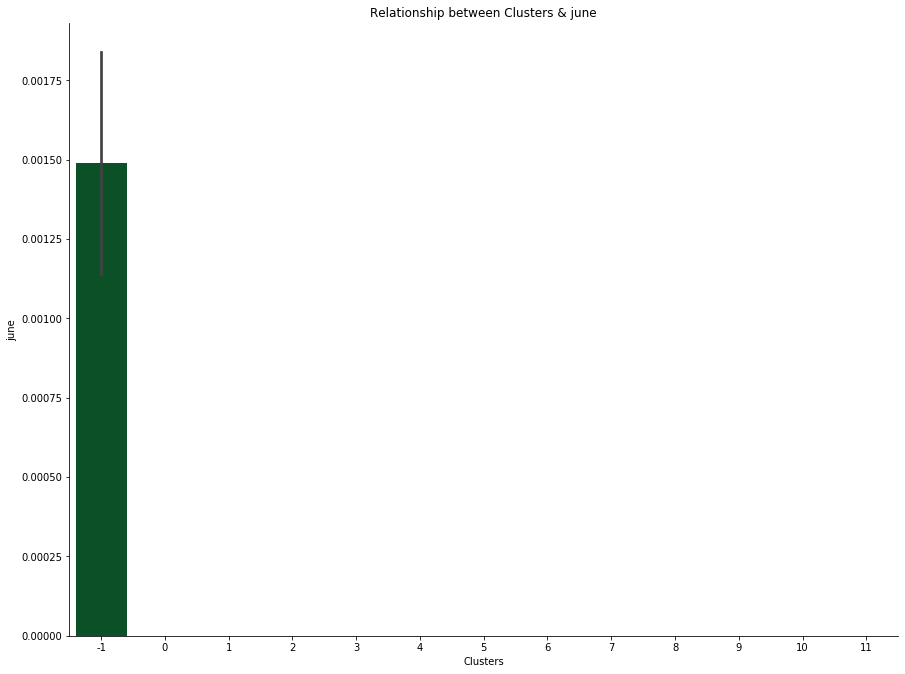

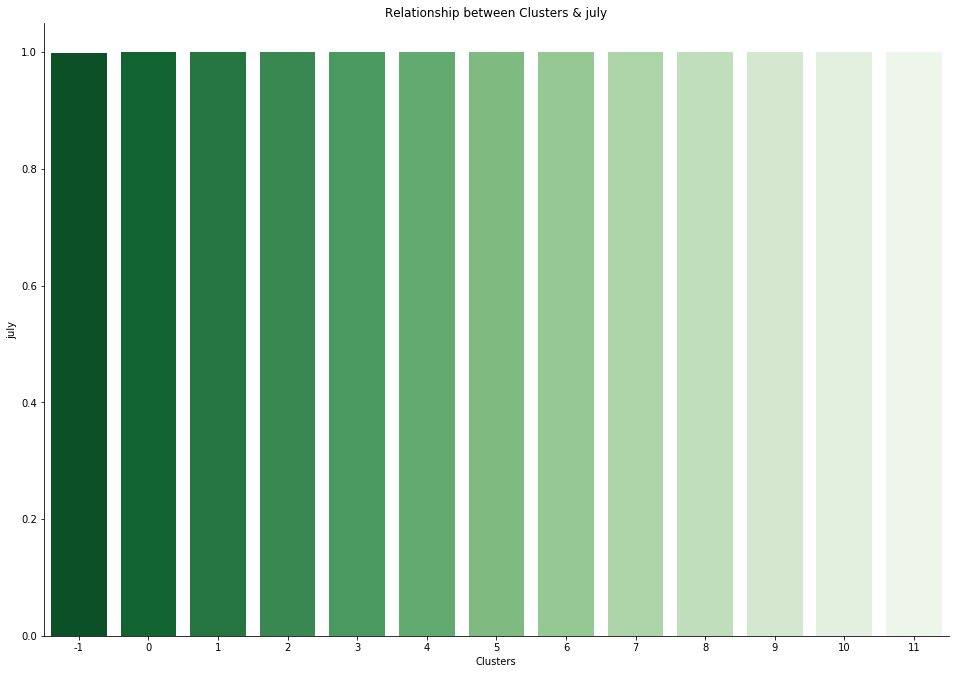

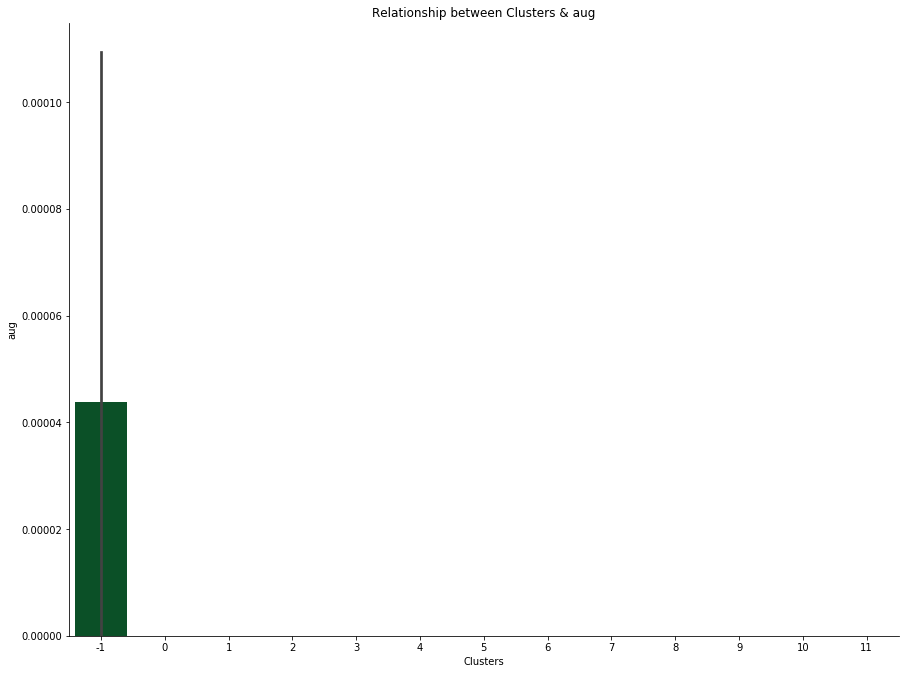

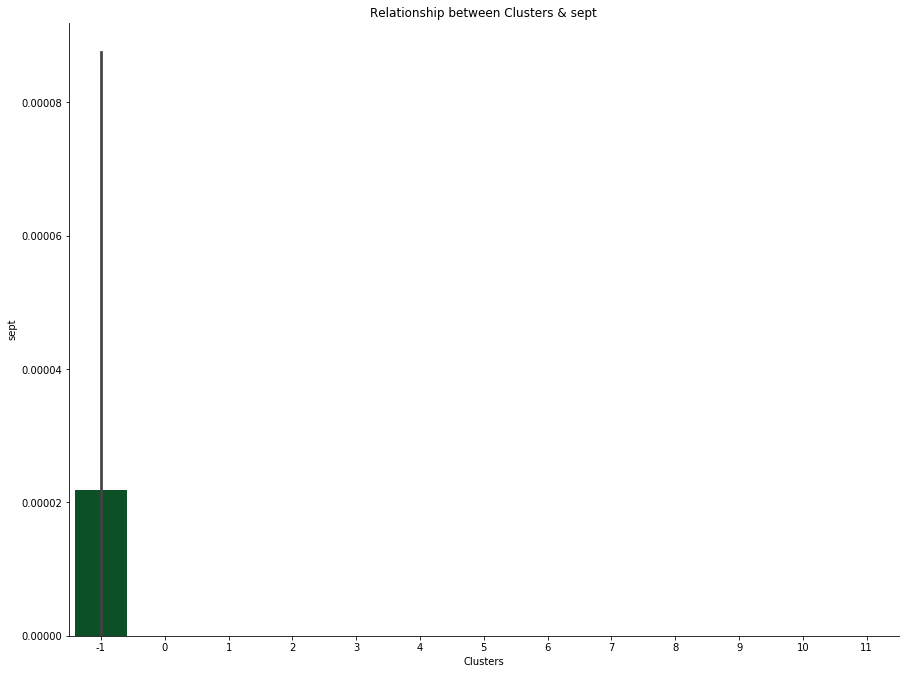

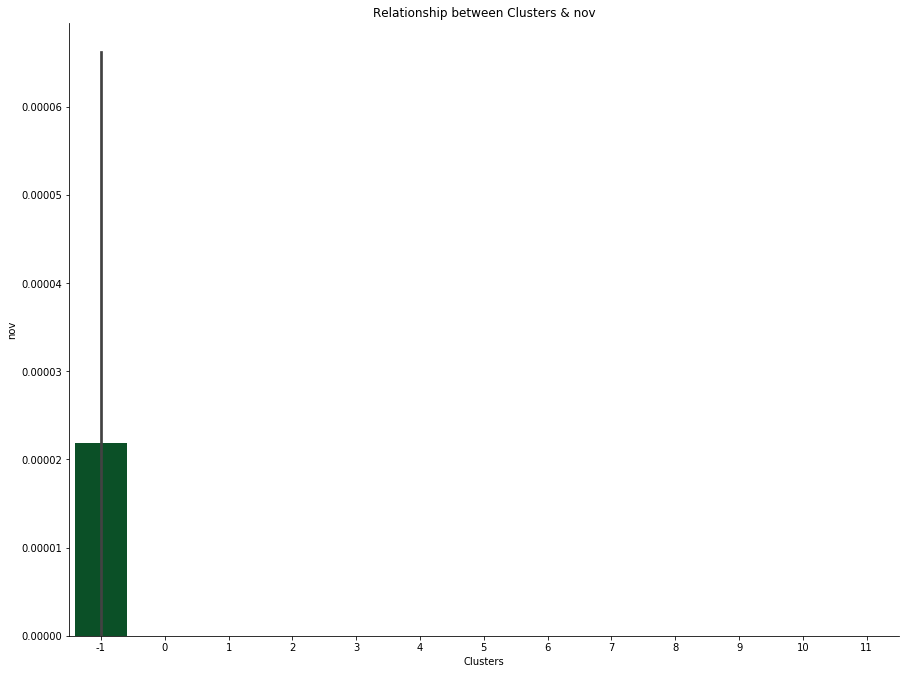

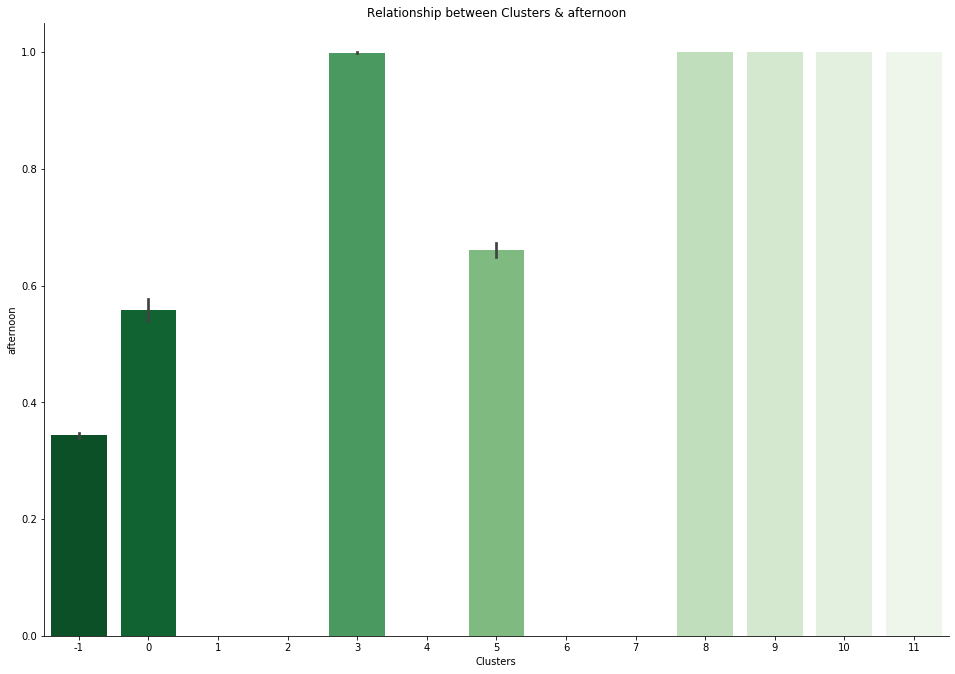

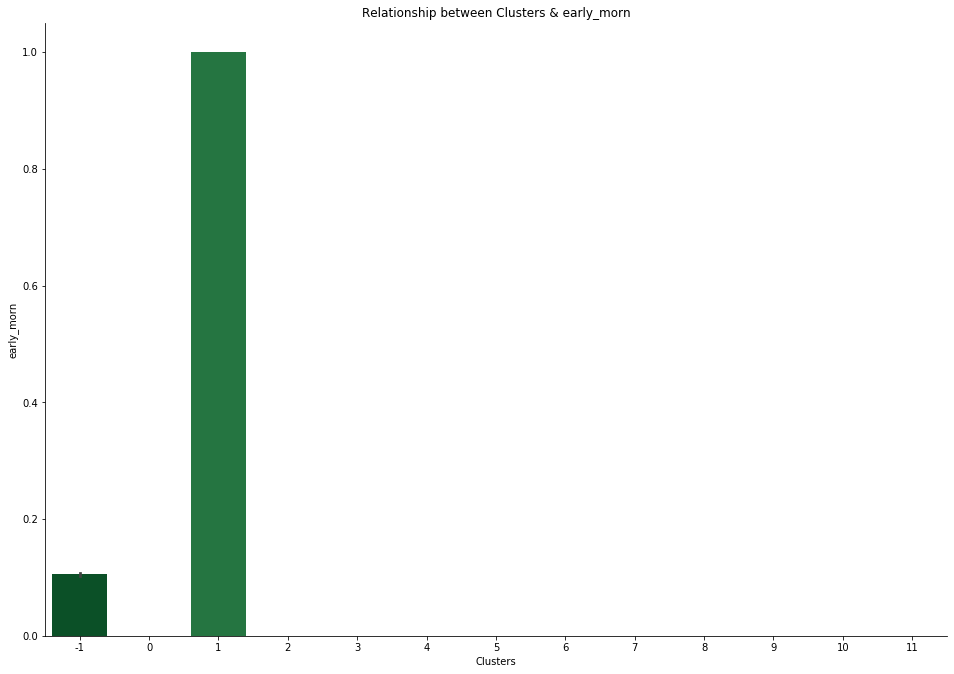

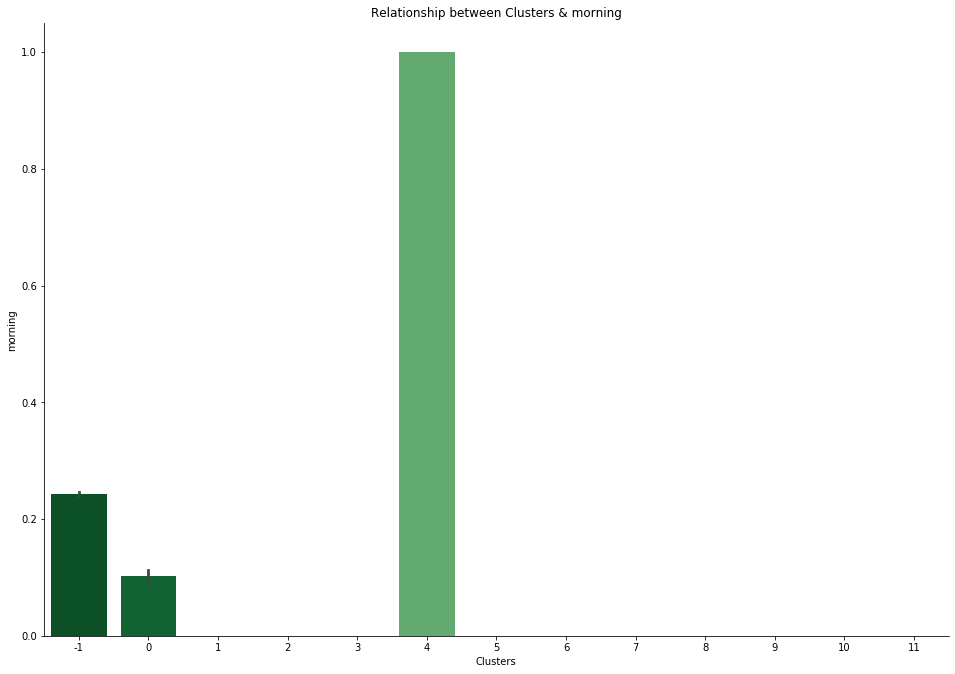

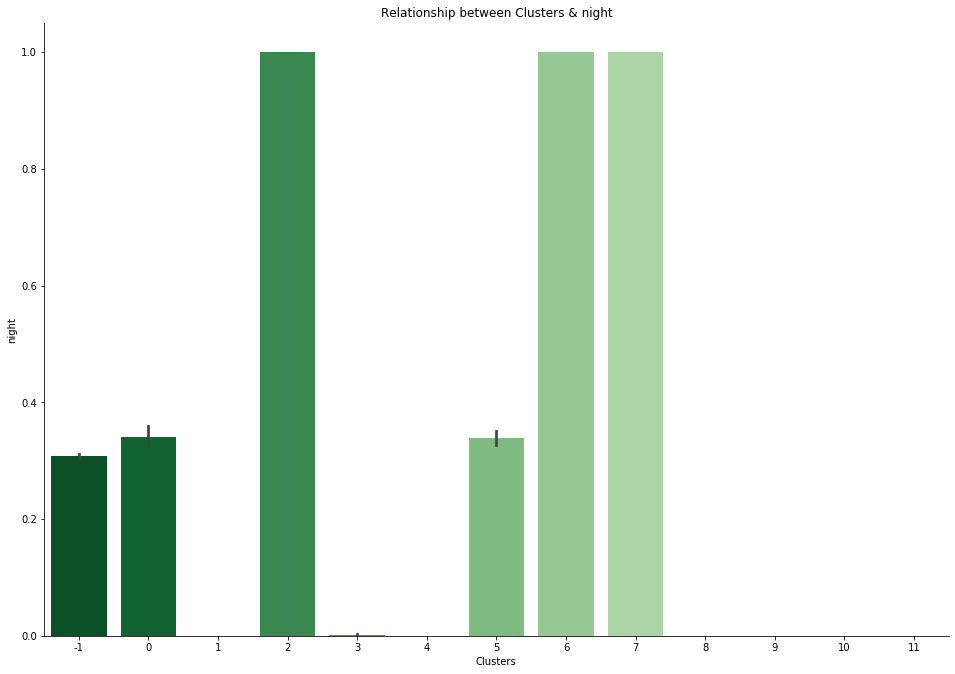

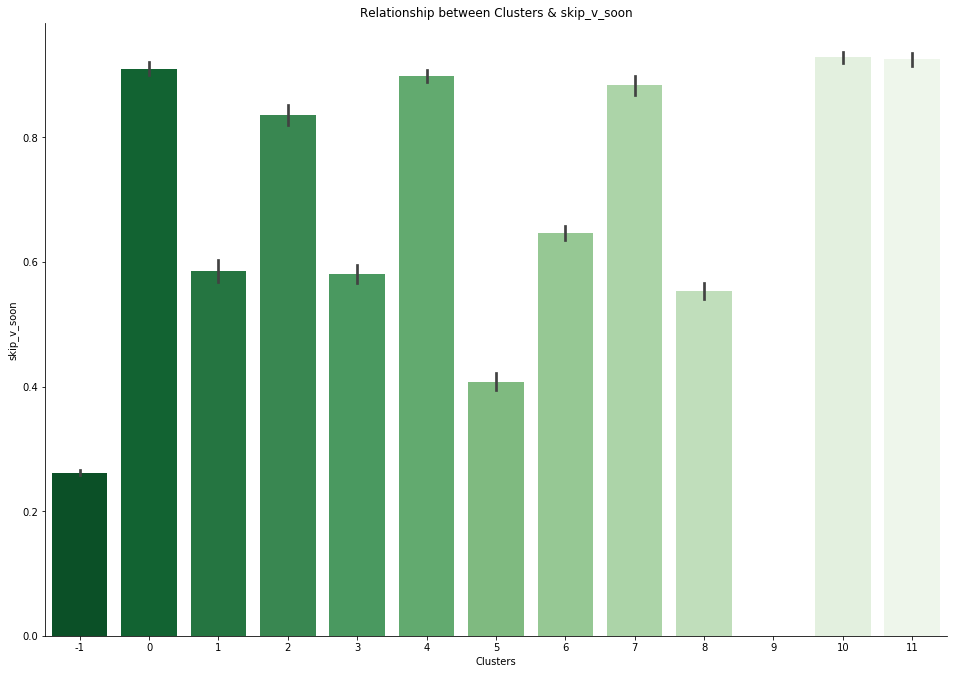

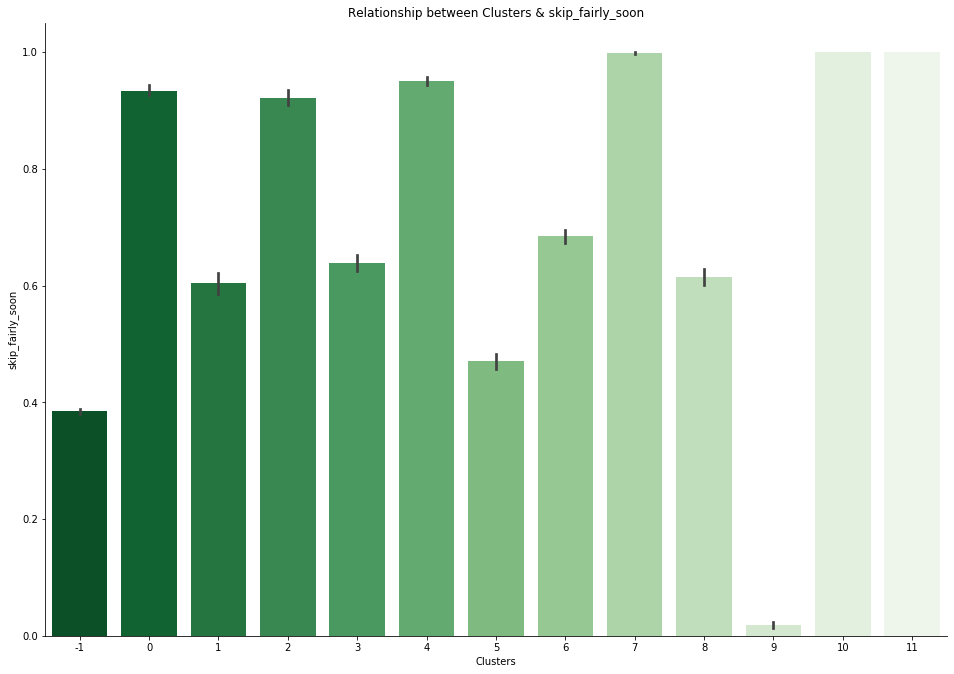

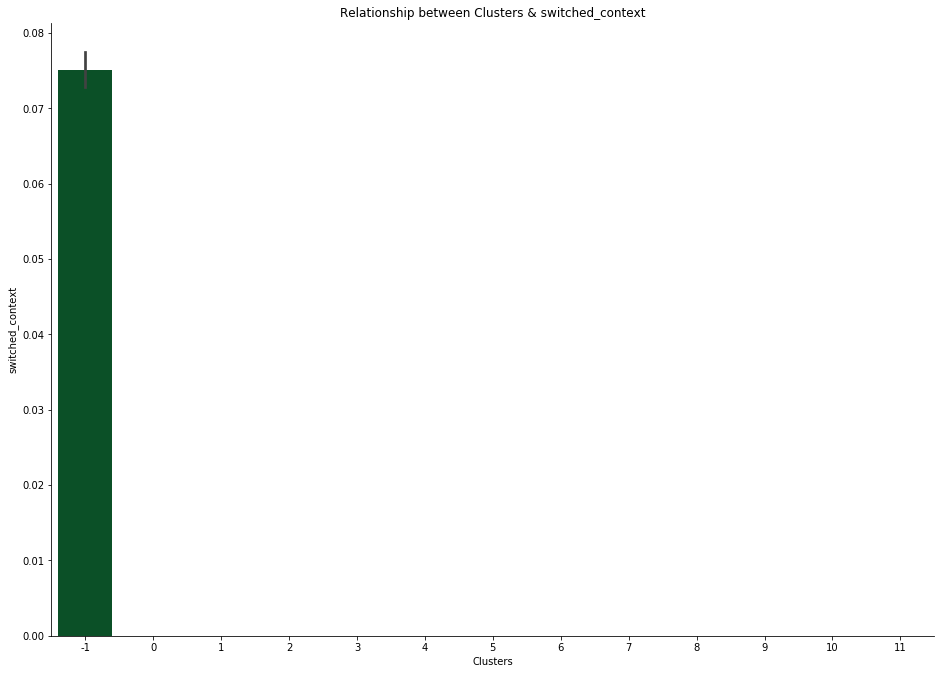

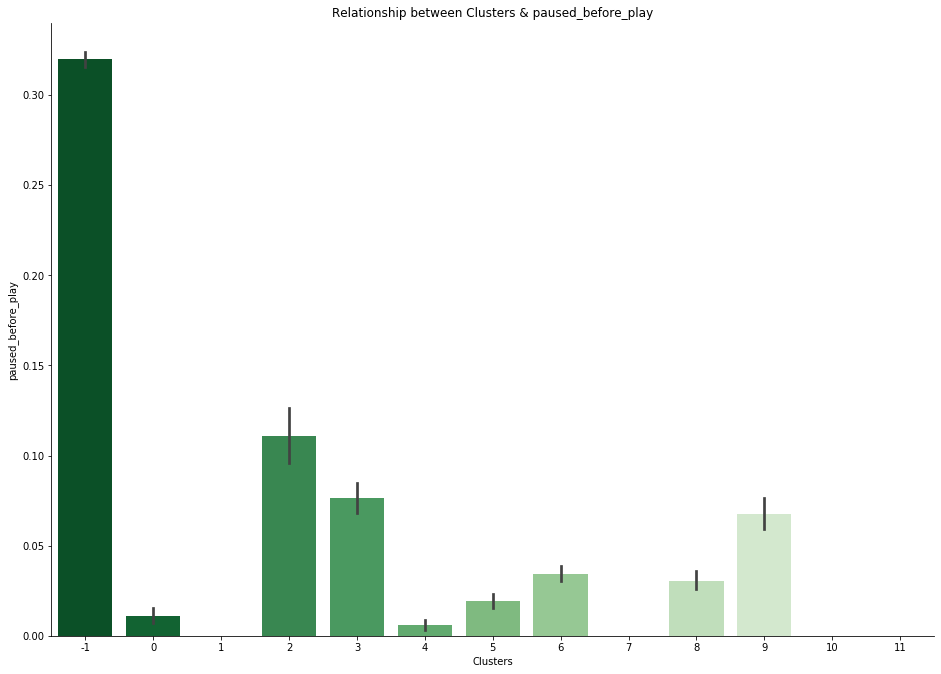

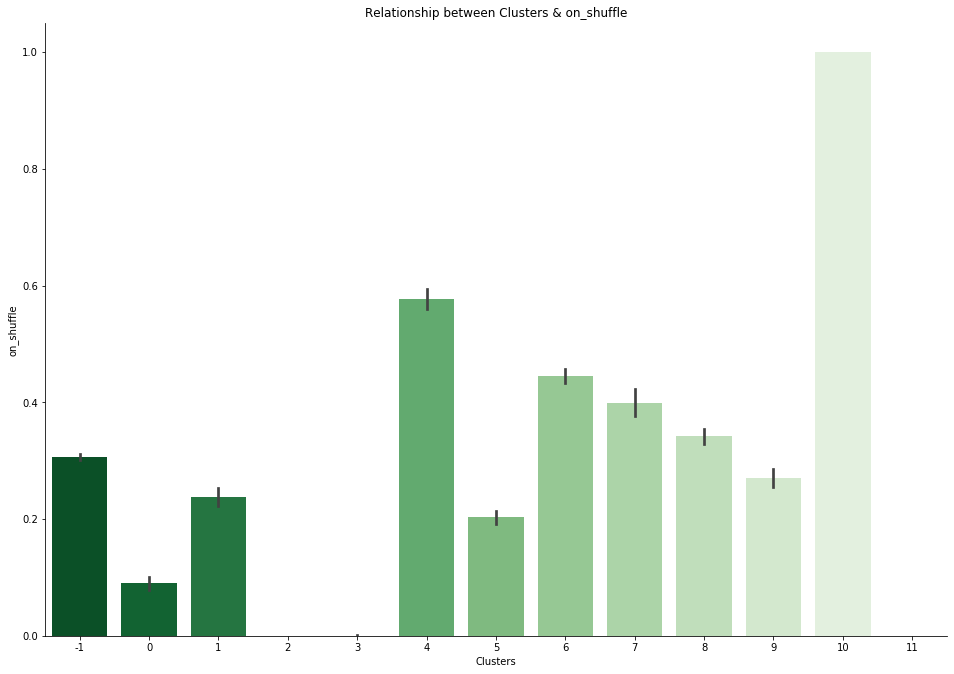

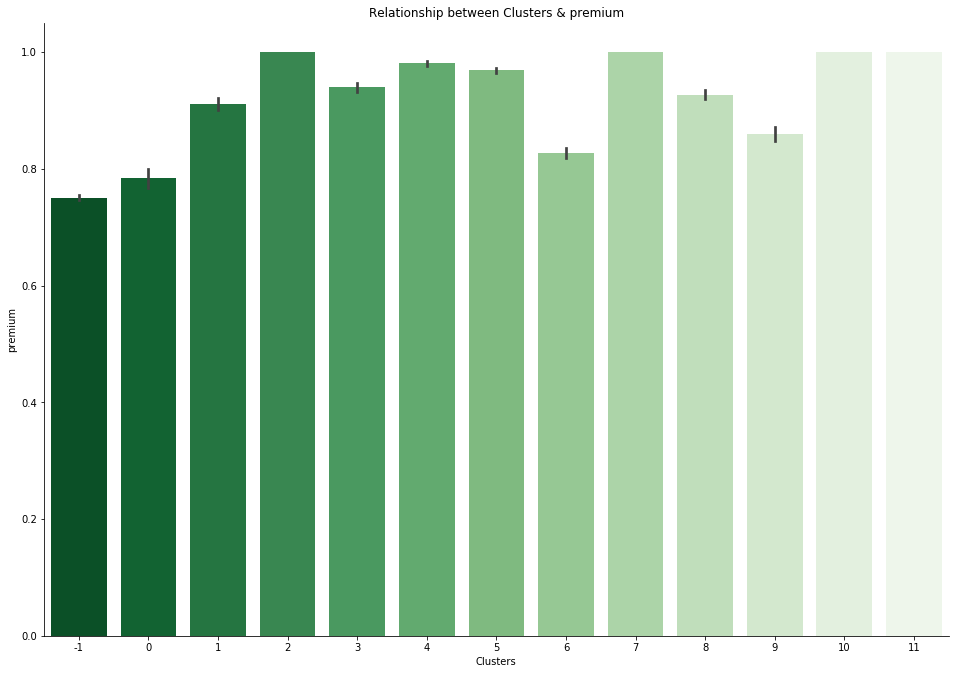

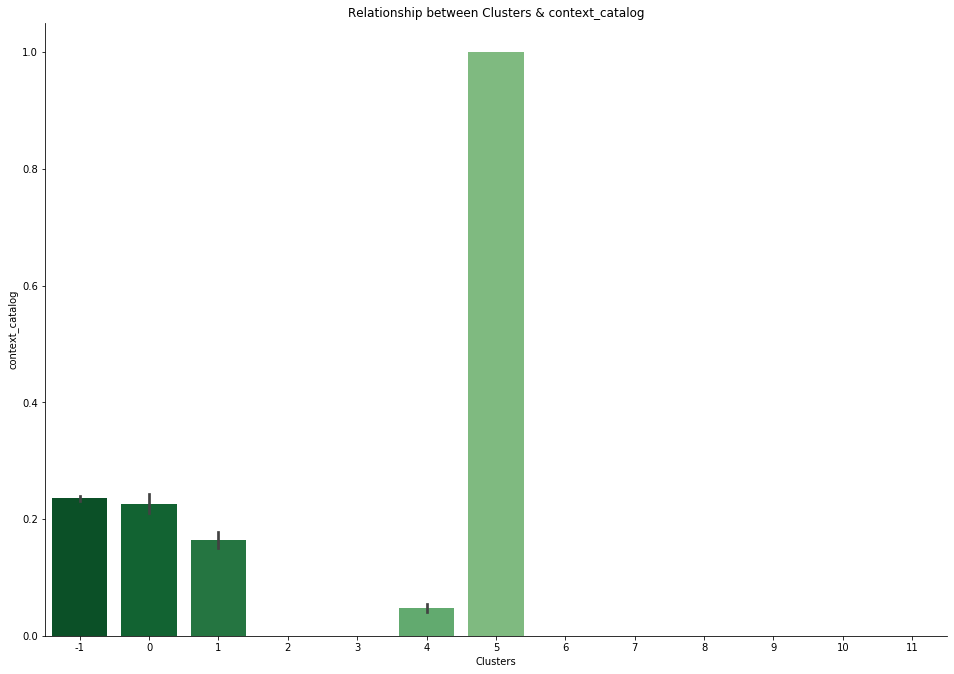

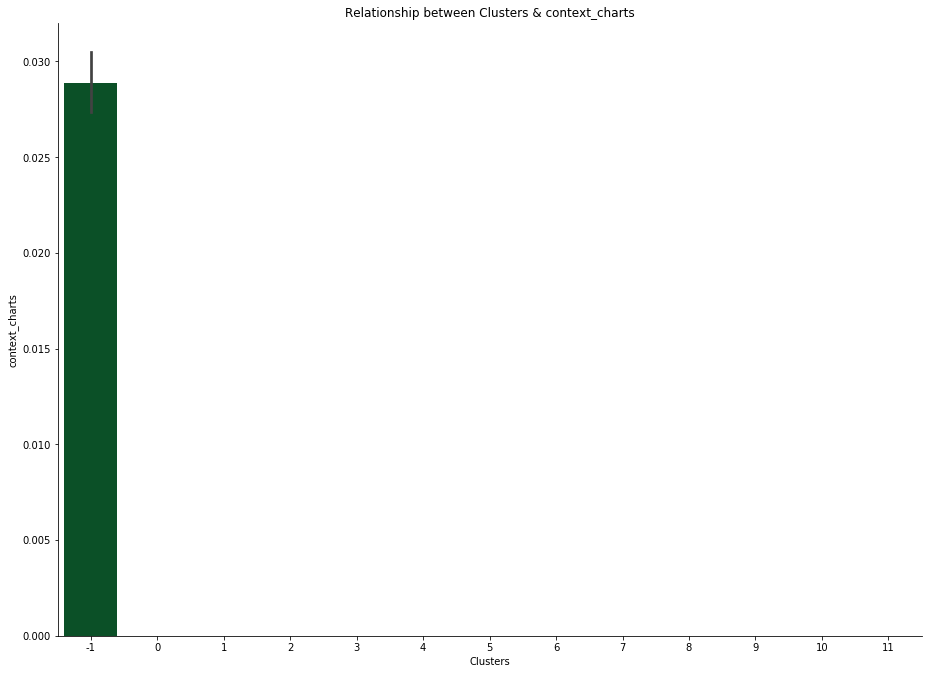

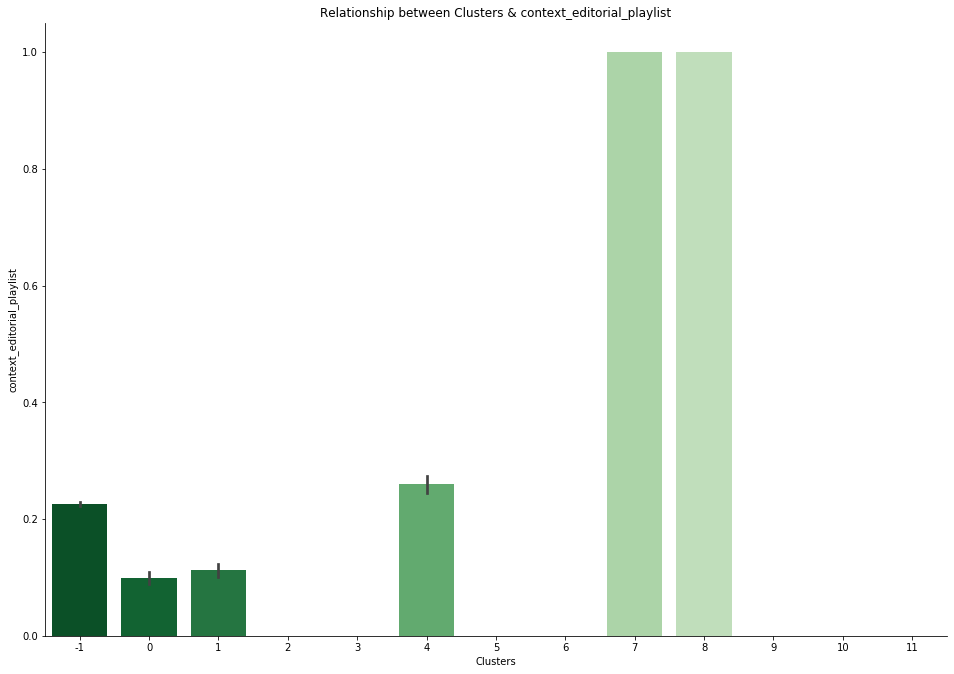

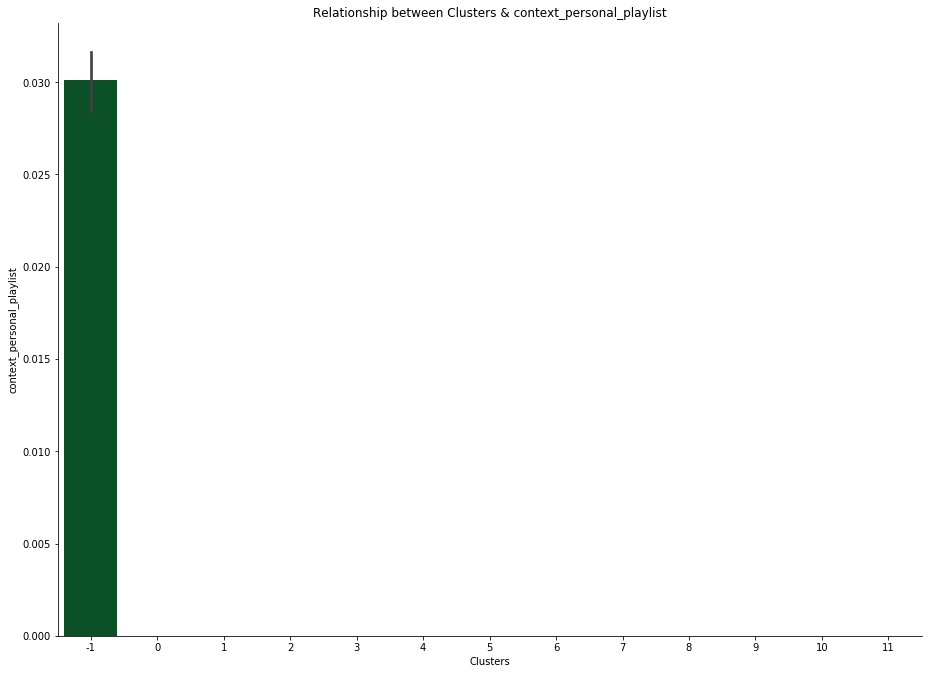

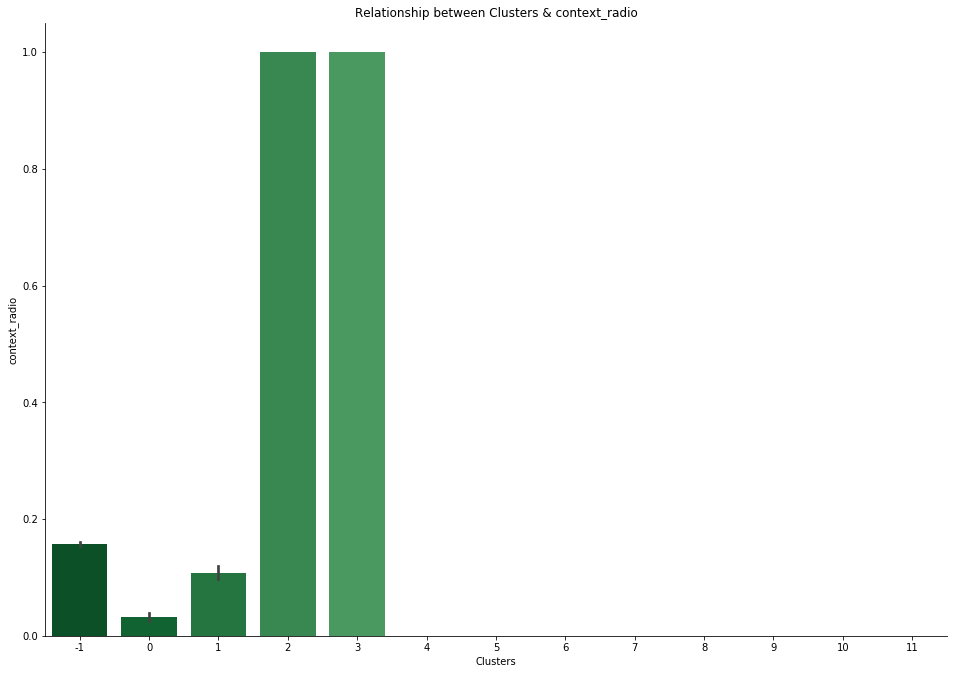

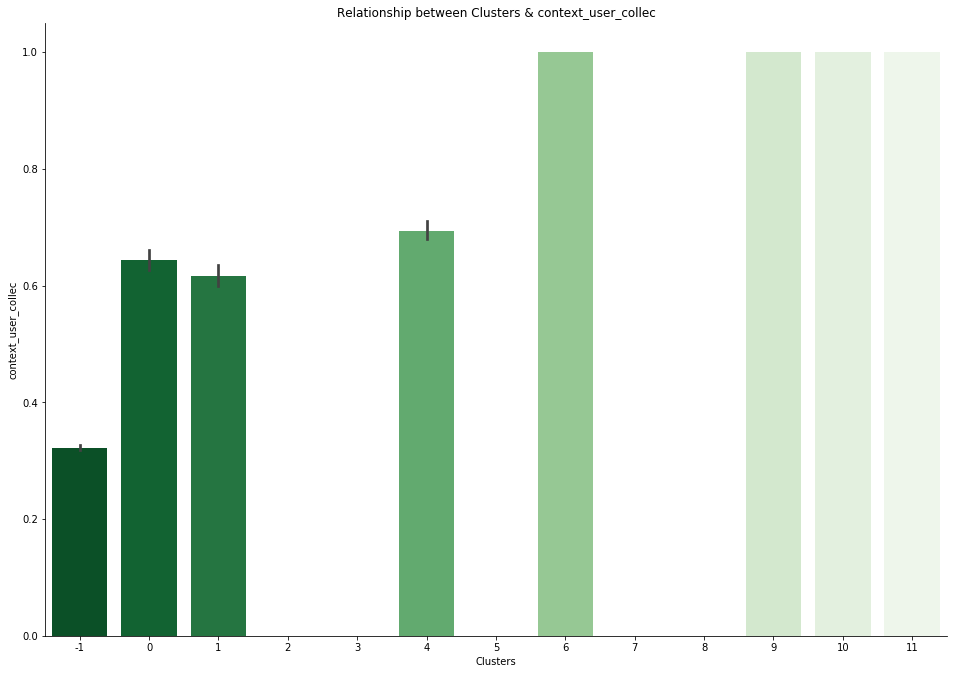

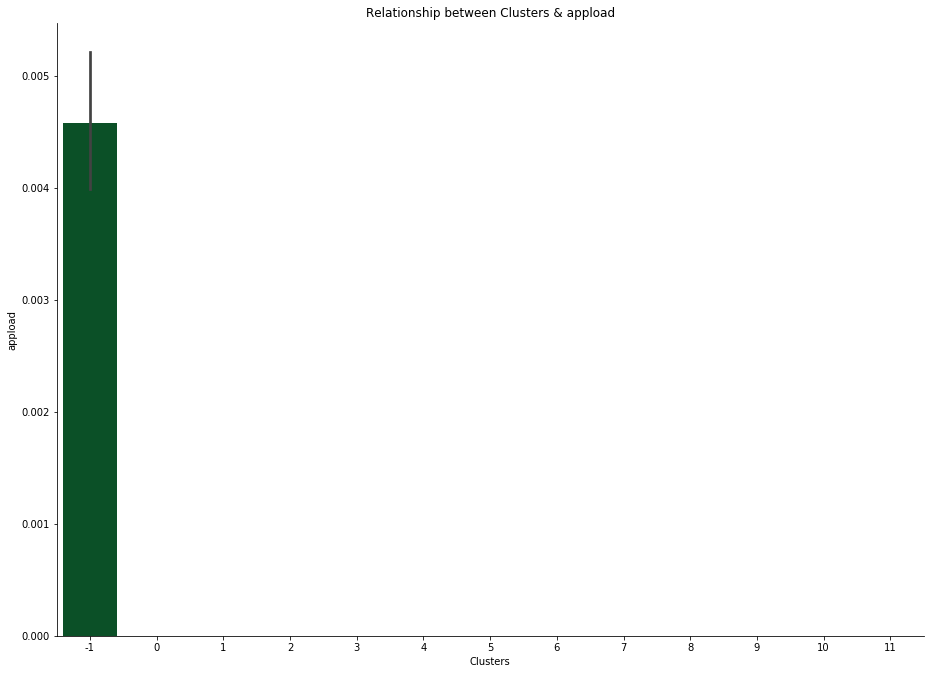

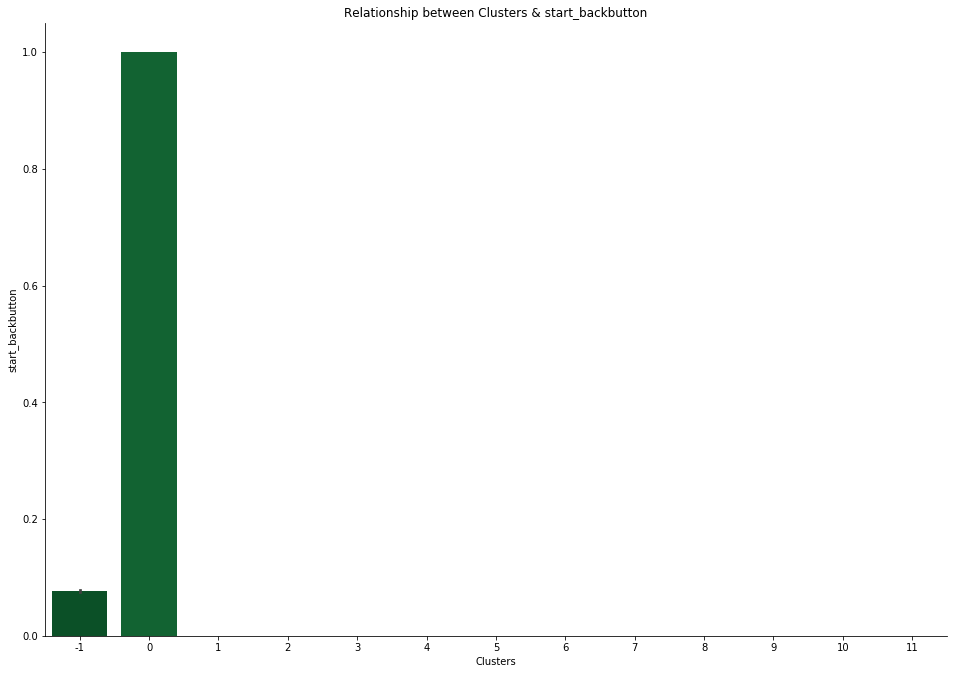

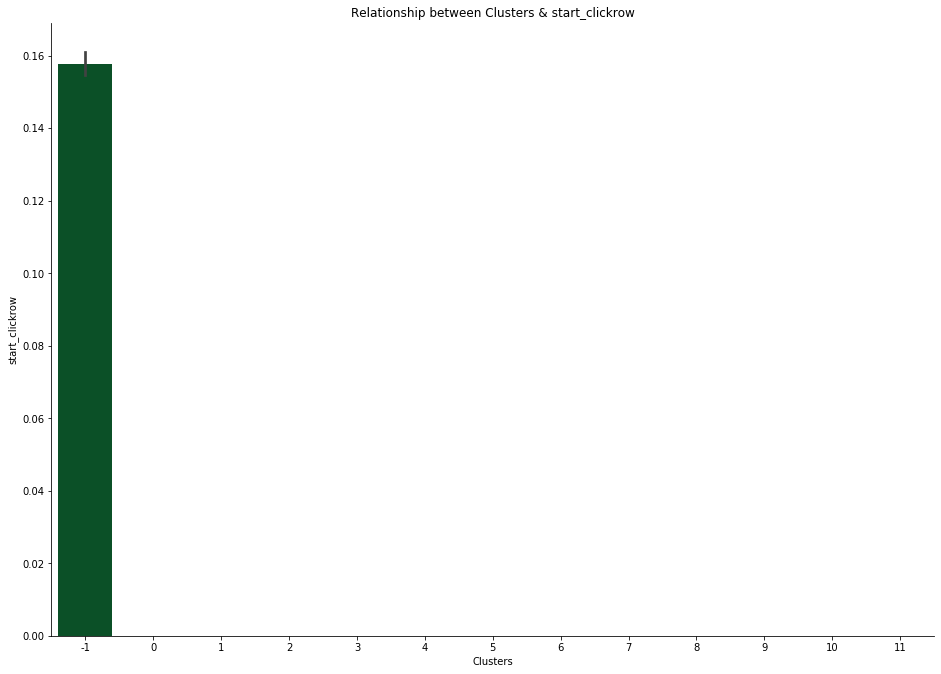

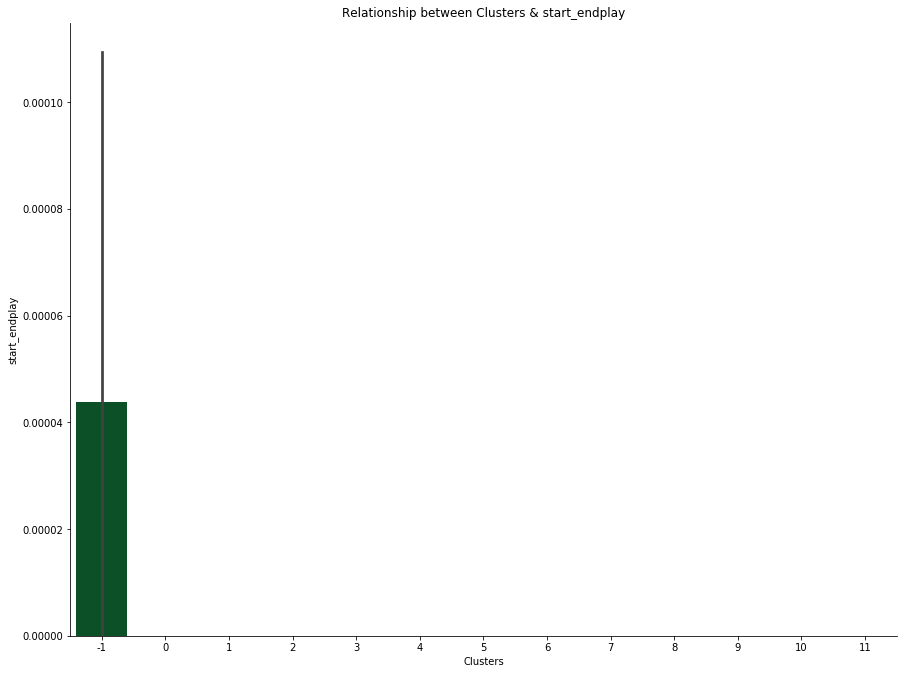

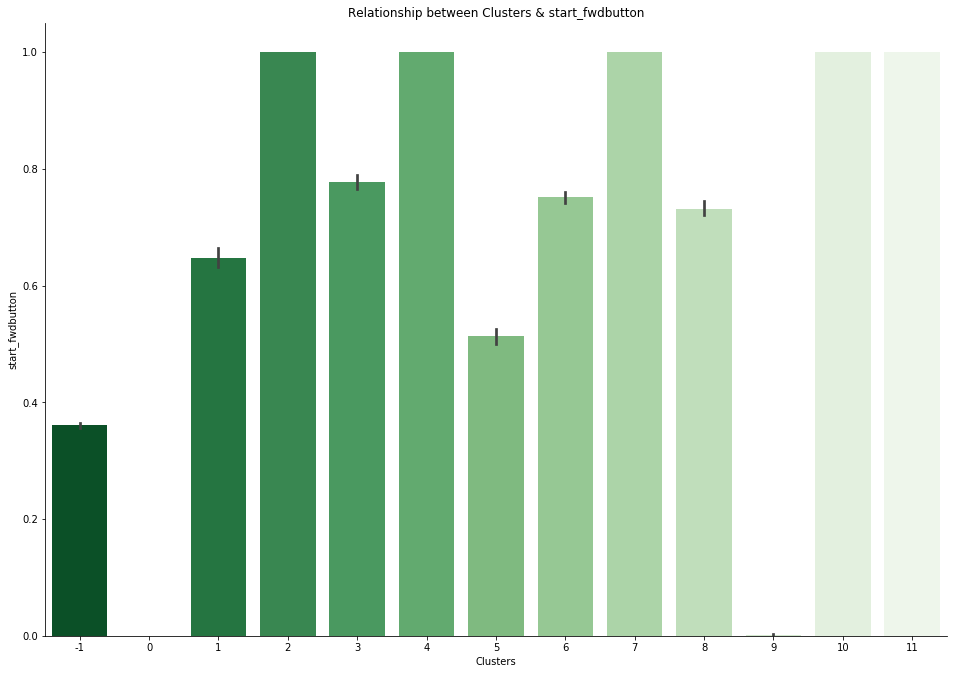

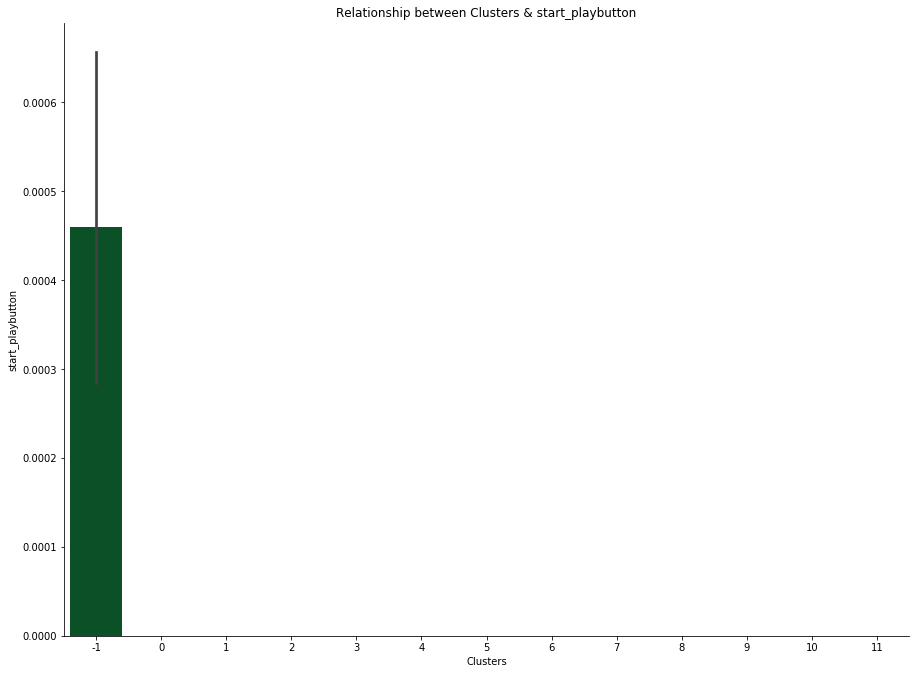

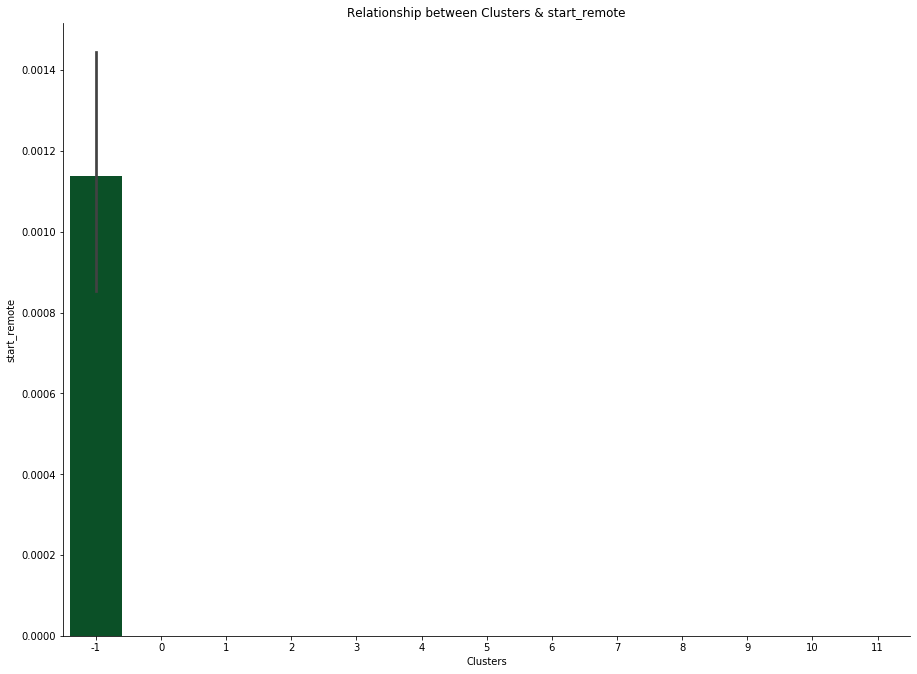

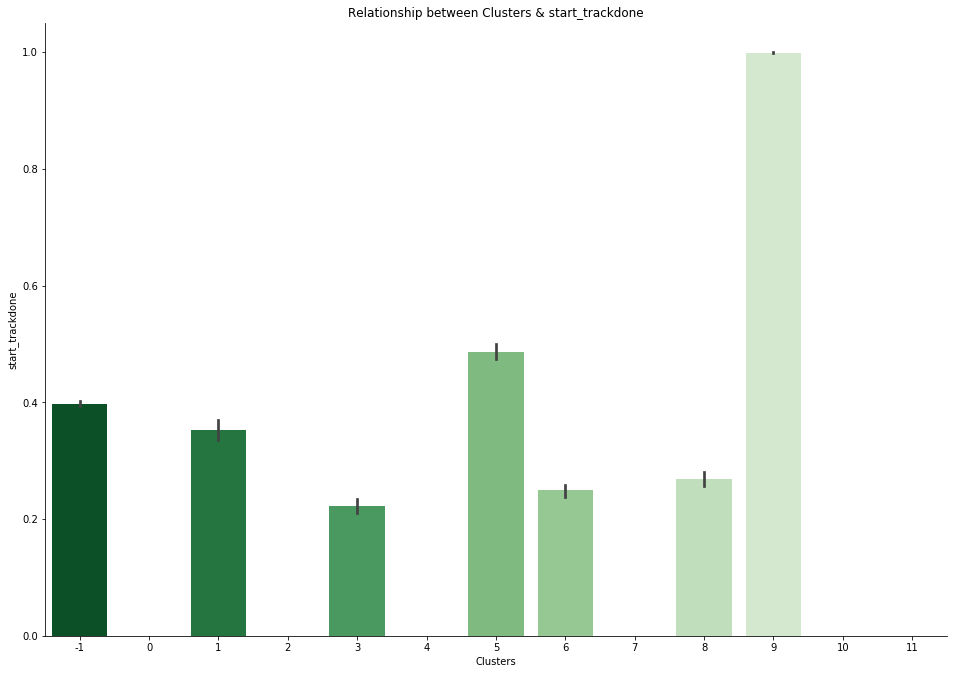

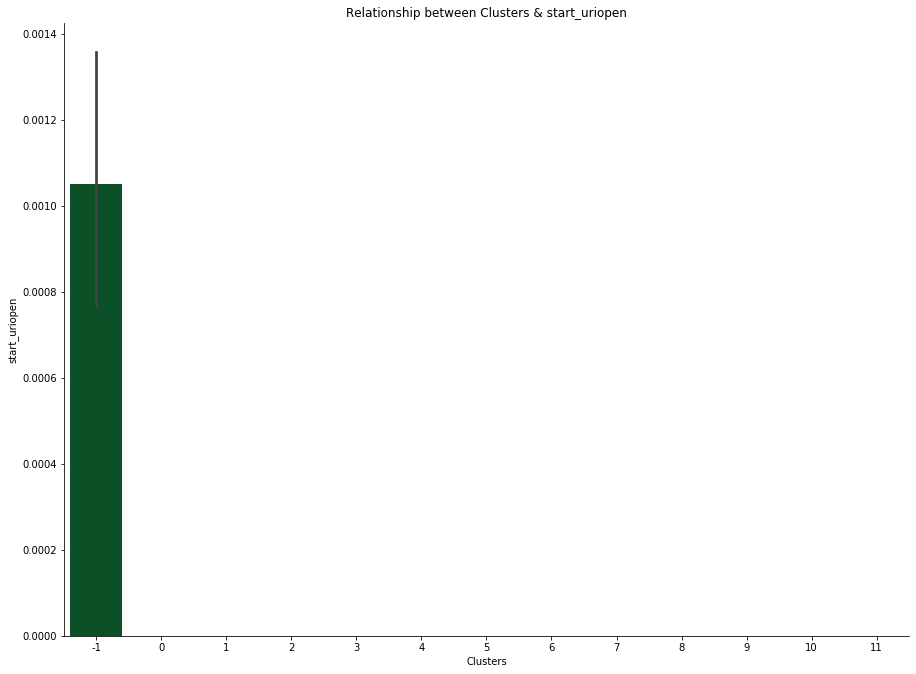

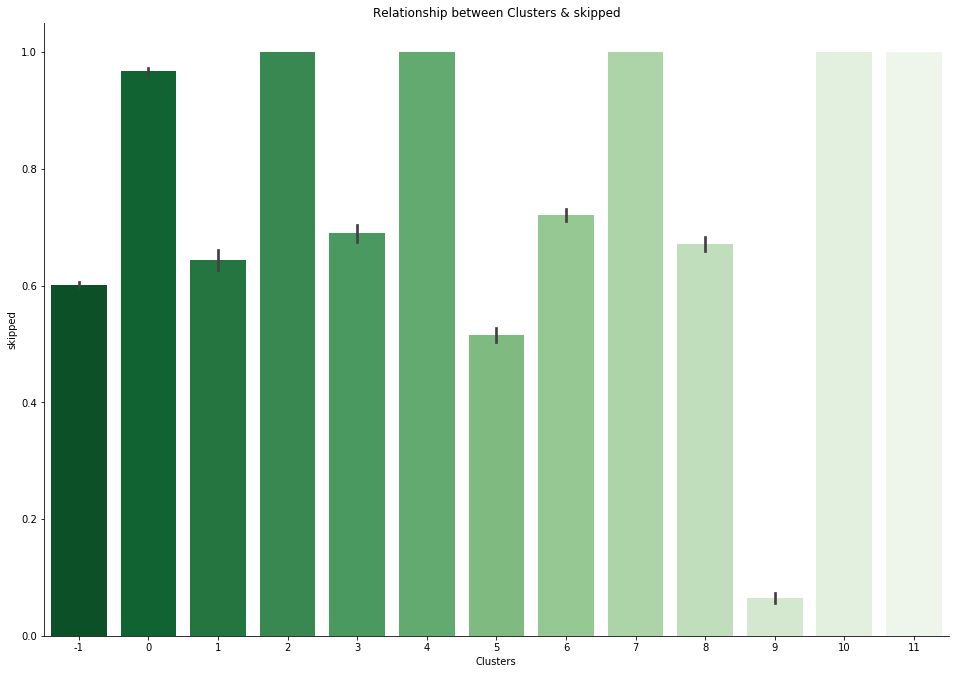

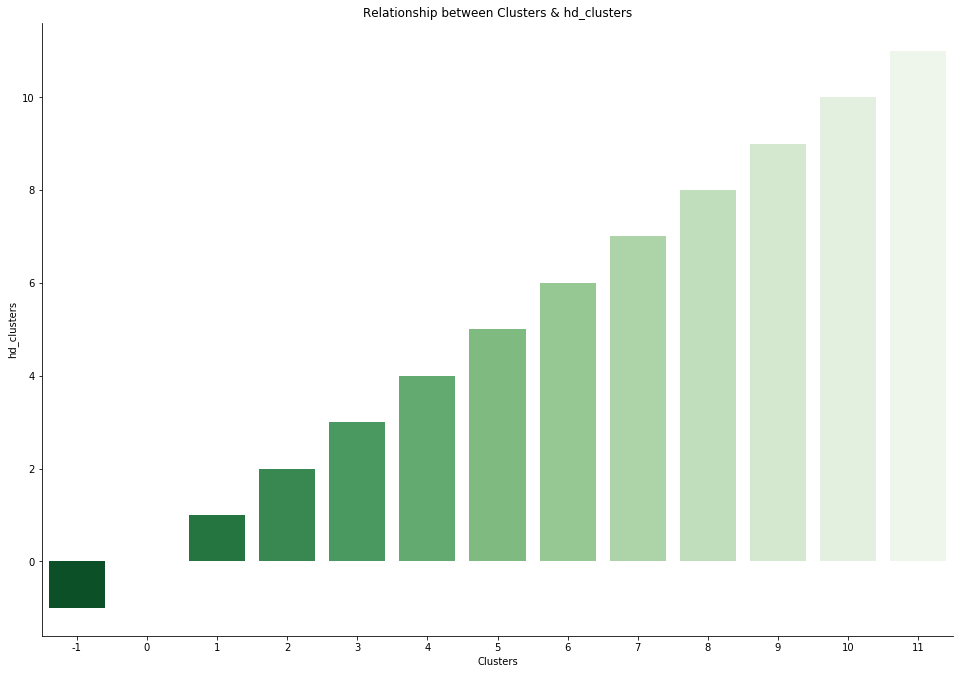

In [225]:
# Let's look at all of the vars in the dummies here, and later we can choose which will go in the presentation
for col in Xclusters_track20_dummies:
    sns.catplot(x='hd_clusters', y=col, kind='bar', palette='Greens_r', data=Xclusters_track20_dummies)
    plt.title('Relationship between Clusters & {}'.format(col))
    plt.xlabel('Clusters')
    plt.ylabel('{}'.format(col))
    plt.gcf().set_size_inches(15,10)
    plt.show()

In [676]:
# Create separated datasets for track 1 so the outcome variable is isolated and ready for the models
track1_sl = Xclusters_track1_dummies.drop(columns=['skipped', 'paused_before_play', 'skip_v_soon', 'skip_fairly_soon'])
X, y = track1_sl.iloc[:,:], Xclusters_track1_dummies.iloc[:,41]

In [677]:
# Double-check we got the right y 
y

0        0
0        1
0        0
0        1
1        1
        ..
58080    0
58082    0
58087    1
58098    0
58100    1
Name: skipped, Length: 89672, dtype: uint8

In [678]:
# Split into train, val, & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=340)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=217)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  3.0min remaining:   31.8s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.5s finished


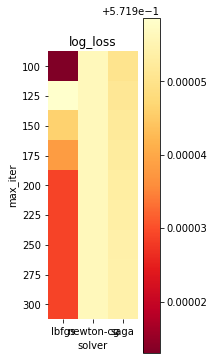

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.5719130382841049


In [679]:
# Set up first parfit grid 
grid1_t1 = {
    'max_iter': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid1_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(LogisticRegression(multi_class='multinomial'),paramGrid,
                                                    X_train, y_train, X_val, y_val,
                                                    metric=log_loss, greater_is_better=False,
                                                    scoreLabel='log_loss')
print(best_model, best_score)

Cool, I already knew this needed to be multinomial; and when we looked at the log loss scores for lbgfs, newton-cg, and saga solvers across different max_iter values, lbfgs at a max_iter of 100 was by far the best. 

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


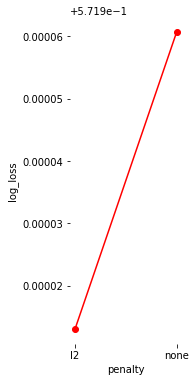

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.5719130382841049


In [680]:
grid2_t1 = {
    'penalty': ['l2', 'none'],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid2_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(LogisticRegression(
                                                    max_iter=100, multi_class='multinomial', solver='lbfgs'),
                                                    paramGrid,
                                                    X_train, y_train, X_val, y_val,
                                                    metric=log_loss, greater_is_better=False,
                                                    scoreLabel='log_loss')
print(best_model, best_score)

I wanted to check and see if l2 might work better than no penalty, and l2 actually was a tiny bit better.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    7.5s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


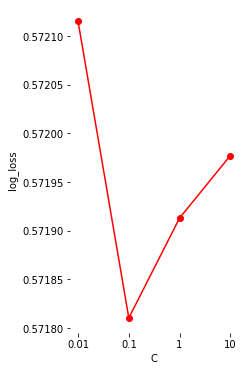

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.5718104170190585


In [681]:
# Let's try finding the best value for C, and that'll be our last iterations with the track1 logistic regression
grid3_t1 = {
    'C': [.01, .1, 1, 10],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid3_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(LogisticRegression(
                                                    max_iter=100, multi_class='multinomial', 
                                                    solver='lbfgs', penalty='l2'),
                                                    paramGrid,
                                                    X_train, y_train, X_val, y_val,
                                                    metric=log_loss, greater_is_better=False,
                                                    scoreLabel='log_loss')
print(best_model, best_score)

So 1 is the best C-value here.
Our log loss score is .5718, which isn't great?

In [682]:
acc_score = best_model.score(X_train, y_train)
print('Accuracy of T1 Logistic Regression on training set: {:.3f}'.format(acc_score))

Accuracy of T1 Logistic Regression on training set: 0.665


In [683]:
y_pred = best_model.predict_proba(X_train)

In [684]:
ll_score = log_loss(y_train, y_pred)
print('Log loss of T1 Logistic Regression on training set: {:.3f}'.format(ll_score))

Log loss of T1 Logistic Regression on training set: 0.571


Well let's see how it goes for track10. I'm anticipating the params that work best will be very similar to track1's, but we'll see.

In [686]:
# Create separated datasets so the OUTCOME VARIABLE is isolated and ready for the models
track10_sl = Xclusters_track10_dummies.drop(columns=['skipped', 'skip_v_soon', 'skip_fairly_soon'])
A, b = track10_sl.iloc[:,:], Xclusters_track10_dummies.iloc[:,41]

In [687]:
# Double-check we got the right one
b

1        1
2        1
4        1
4        1
5        1
        ..
58087    1
58089    1
58091    0
58096    1
58109    1
Name: skipped, Length: 89672, dtype: uint8

In [688]:
# Split into train, val, and test sets
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, stratify=b, random_state=340)
A_train, A_val, b_train, b_val = train_test_split(A_train, b_train, test_size=0.25, stratify=b_train, random_state=217)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  3.0min remaining:   31.3s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.4s finished


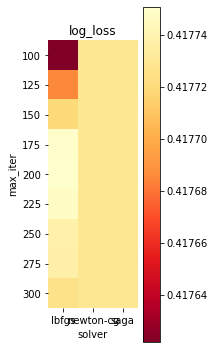

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.41762178056682053


In [689]:
# Set up first parfit grid for track10
grid1_t10 = {
    'max_iter': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid1_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(LogisticRegression(multi_class='multinomial'),paramGrid,
                                                    A_train, b_train, A_val, b_val,
                                                    metric=log_loss, greater_is_better=False,
                                                    scoreLabel='log_loss')
print(best_model, best_score)

Lbfgs at 100 max_iter wins. 

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


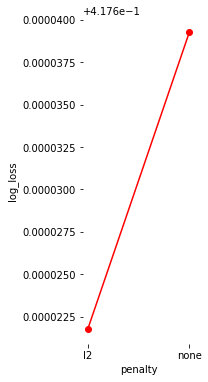

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.41762178056682053


In [690]:
grid2_t10 = {
    'penalty': ['l2', 'none'],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid2_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(LogisticRegression(
                                                    max_iter=100, multi_class='multinomial', solver='lbfgs'),
                                                    paramGrid,
                                                    A_train, b_train, A_val, b_val,
                                                    metric=log_loss, greater_is_better=False,
                                                    scoreLabel='log_loss')
print(best_model, best_score)

L2 wins again.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   17.3s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


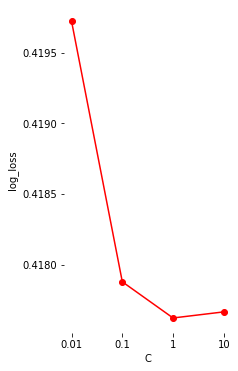

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.41762178056682053


In [691]:
# Let's try finding the best value for C, and that'll be our last iteration for the track10 logistic regression
grid3_t10 = {
    'C': [.01, .1, 1, 10],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid3_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(LogisticRegression(
                                                    max_iter=100, multi_class='multinomial', 
                                                    solver='lbfgs', penalty='l2'),
                                                    paramGrid,
                                                    A_train, b_train, A_val, b_val,
                                                    metric=log_loss, greater_is_better=False,
                                                    scoreLabel='log_loss')
print(best_model, best_score)

1 is best for C.

In [692]:
acc_score = best_model.score(A_train, b_train)
print('Accuracy of T10 Logistic Regression on training set: {:.3f}'.format(acc_score))

Accuracy of T10 Logistic Regression on training set: 0.838


In [693]:
b_pred = best_model.predict_proba(A_train)

In [694]:
ll_score = log_loss(b_train, b_pred)
print('Log loss of T10 Logistic Regression on training set: {:.3f}'.format(ll_score))

Log loss of T10 Logistic Regression on training set: 0.420


Okay, the track10 logistic regression performed better than track1's. 
Let's see how track20 looks.

In [696]:
# Create separated datasets so the outcome variable is isolated and ready for the models
track20_sl = Xclusters_track20_dummies.drop(columns=['skipped', 'skip_v_soon', 'skip_fairly_soon'])
C, d = track20_sl.iloc[:,:], Xclusters_track20_dummies.iloc[:,41]

In [697]:
# Check we got the right column for d
d

0        1
1        0
1        1
1        0
1        0
        ..
58097    0
58099    1
58101    0
58106    0
58119    1
Name: skipped, Length: 89672, dtype: uint8

In [698]:
# Split into train, val, and test sets
C_train, C_test, d_train, d_test = train_test_split(C, d, test_size=0.2, stratify=d, random_state=340)
C_train, C_val, d_train, d_val = train_test_split(C_train, d_train, test_size=0.25, stratify=d_train, random_state=217)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  2.6min remaining:   27.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.5s finished


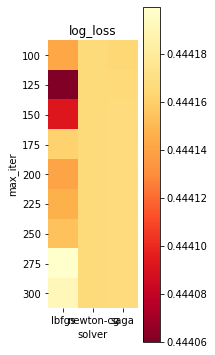

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=125,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.4440599990357081


In [699]:
# Set up first parfit grid for track20
grid1_t20 = {
    'max_iter': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid1_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(LogisticRegression(multi_class='multinomial'),paramGrid,
                                                    C_train, d_train, C_val, d_val,
                                                    metric=log_loss, greater_is_better=False,
                                                    scoreLabel='log_loss')
print(best_model, best_score)

Lbfgs with 125 max_iter wins.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


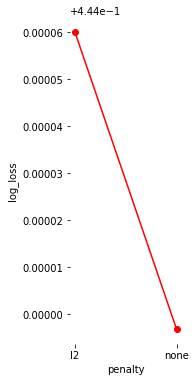

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=125,
                   multi_class='multinomial', n_jobs=-1, penalty='none',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.4439968506684517


In [700]:
grid2_t20 = {
    'penalty': ['l2', 'none'],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid2_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(LogisticRegression(
                                                    max_iter=125, multi_class='multinomial', solver='lbfgs'),
                                                    paramGrid,
                                                    C_train, d_train, C_val, d_val,
                                                    metric=log_loss, greater_is_better=False,
                                                    scoreLabel='log_loss')
print(best_model, best_score)

No penalty is better.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    9.6s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


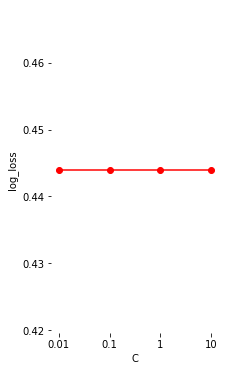

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=125,
                   multi_class='multinomial', n_jobs=-1, penalty='none',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.4439968506684517


In [701]:
# Let's try finding the best value for C, and that'll be our last iteration for the track10 logistic regression
grid3_t20 = {
    'C': [.01, .1, 1, 10],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid3_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(LogisticRegression(
                                                    max_iter=125, multi_class='multinomial', 
                                                    solver='lbfgs', penalty='none'),
                                                    paramGrid,
                                                    C_train, d_train, C_val, d_val,
                                                    metric=log_loss, greater_is_better=False,
                                                    scoreLabel='log_loss')
print(best_model, best_score)

All C's did the same. Now we can get training set scores.

In [702]:
acc_score = best_model.score(C_train, d_train)
print('Accuracy of T20 Logistic Regression on training set: {:.3f}'.format(acc_score))

Accuracy of T20 Logistic Regression on training set: 0.825


In [703]:
d_pred = best_model.predict_proba(C_train)

In [704]:
ll_score = log_loss(d_train, d_pred)
print('Log loss of T20 Logistic Regression on training set: {:.3f}'.format(ll_score))

Log loss of T20 Logistic Regression on training set: 0.447


Now on to the random forest.

In [705]:
# Create separated datasets so the outcome variable is isolated and ready for the models
E, f = track1_sl.iloc[:,:], Xclusters_track1_dummies.iloc[:,41]

In [706]:
# Split into train, val, and test sets for rf model
E_train, E_test, f_train, f_test = train_test_split(E, f, test_size=0.2, stratify=f, random_state=340)
E_train, E_val, f_train, f_val = train_test_split(E_train, f_train, test_size=0.25, stratify=f_train, random_state=217)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   29.9s remaining:   59.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   32.7s remaining:   40.9s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   55.7s remaining:   44.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.1min remaining:   32.6s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.2min remaining:   21.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   12.3s finished


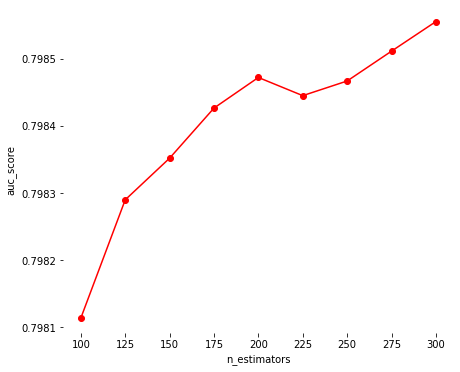

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.79855524112479


In [707]:
# First, we will figure out the best parameters for the random forest
grid4_t1 = {
    'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid4_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(),paramGrid,
                                                    E_train, f_train, E_val, f_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:  2.3min remaining:   49.5s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:  2.6min remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   22.5s finished


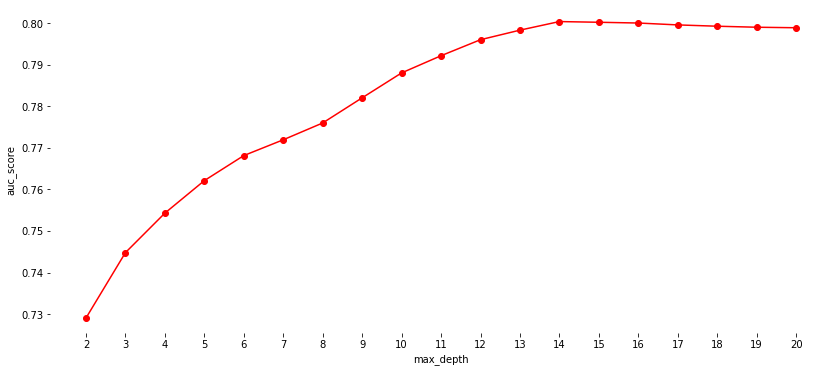

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.8003690545043928


In [708]:
# We've got n_estimators now; let's do max_depth now

grid5_t1 = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid5_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=300),paramGrid,
                                                    E_train, f_train, E_val, f_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  1.1min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  1.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  2.4min remaining:   47.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.8s finished


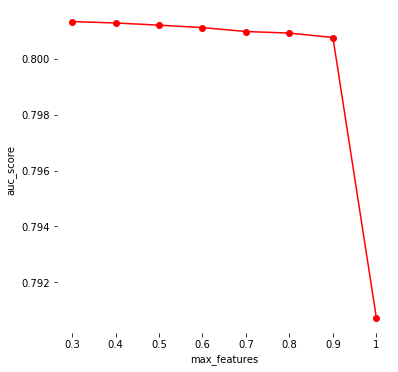

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.8013419400148725


In [709]:
# So best max_depth is 12; let's do max_features now

grid6_t1 = {
    'max_features': [.3, .4, .5, .6, .7, .8, .9, 1],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid6_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=300, max_depth=14),
                                                    paramGrid,
                                                    E_train, f_train, E_val, f_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   51.9s remaining:   51.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   52.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   52.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.2s finished


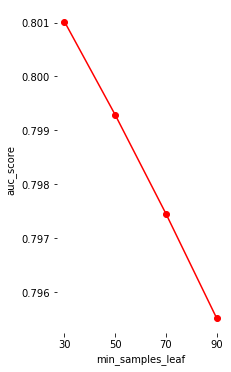

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.8010185353493625


In [710]:
# So best max_features is 90%; let's do min_samples_leaf now

grid7_t1 = {
    'min_samples_leaf': [30, 50, 70, 90],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid7_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=300, max_depth=14,
                                                    max_features=.3),
                                                    paramGrid,
                                                    E_train, f_train, E_val, f_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

The default min_samples_leaf of 1 was actually better, so I'll just leave it at that.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   33.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s finished


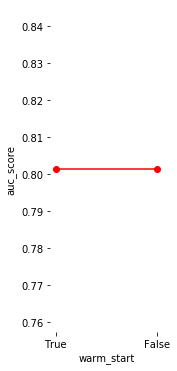

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=True) 0.8013419400148725


In [711]:
# Now check on warm_start 
grid8_t1 = {
    'warm_start': [True, False],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid8_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=300, max_depth=14,
                                                    max_features=.3, min_samples_leaf=1),
                                                    paramGrid,
                                                    E_train, f_train, E_val, f_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   33.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   33.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s finished


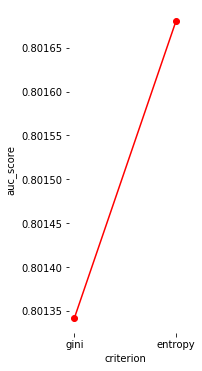

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=14, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.8016798865295105


In [713]:
# No change with warm start; we'll leave it at the default value; last param we'll worry about is criterion

grid9_t1 = {
    'criterion': ['gini', 'entropy'],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid9_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=300, max_depth=14,
                                                    max_features=.3, min_samples_leaf=1),
                                                    paramGrid,
                                                    E_train, f_train, E_val, f_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

Entropy was slightly better. I think this may be the best we'll get with the track1 rf. We'll go ahead and see the model's scores for the training set. 

In [714]:
acc_score = best_model.score(E_train, f_train)
print('Accuracy of T1 Random Forest on training set: {:.3f}'.format(acc_score))

Accuracy of T1 Random Forest on training set: 0.731


In [715]:
probs = best_model.predict_proba(E_train)[:,1]

In [716]:
# Now auc score for val set
rf_auc1 = roc_auc_score(f_train, probs)
rf_auc1

0.816880750947813

Now it's time for track10 random forest. Hopefully we can get better auc scores, but we'll see.

In [717]:
# Create separated datasets so the outcome variable is isolated and ready for the models
G, h = track10_sl.iloc[:,:], Xclusters_track10_dummies.iloc[:,41]

In [718]:
# Split into train, val, and test sets for rf model
G_train, G_test, h_train, h_test = train_test_split(G, h, test_size=0.2, stratify=h, random_state=340)
G_train, G_val, h_train, h_val = train_test_split(G_train, h_train, test_size=0.25, stratify=h_train, random_state=217)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   52.5s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   55.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  1.3min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.4min remaining:   42.5s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.5min remaining:   26.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   10.1s finished


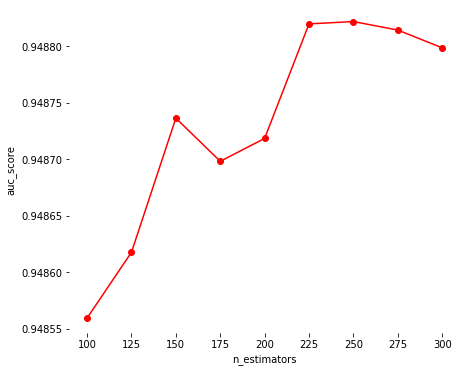

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.9488217467578873


In [719]:
# First, we will figure out the best n_estimators for track10's random forest
grid10_t10 = {
    'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid10_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(),paramGrid,
                                                    G_train, h_train, G_val, h_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:  1.8min remaining:   38.5s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:  2.1min remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   21.3s finished


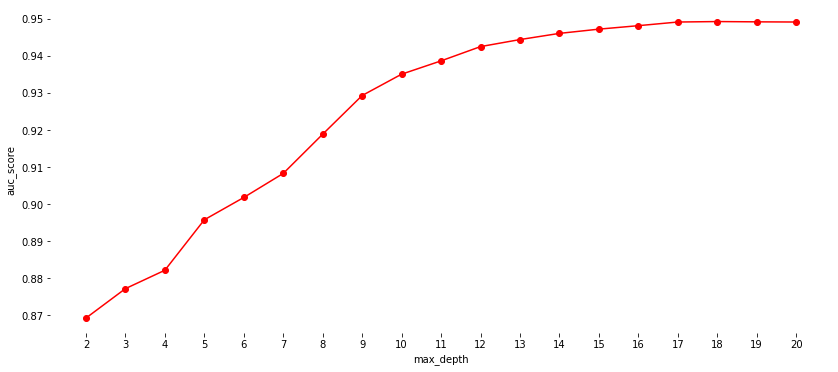

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.9492558395877843


In [720]:
# We've got n_estimators now; let's do max_depth

grid11_t10 = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid11_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=250),paramGrid,
                                                    G_train, h_train, G_val, h_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  1.2min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  2.2min remaining:   43.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   11.6s finished


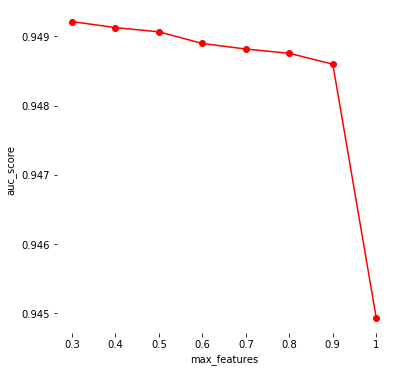

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.9492147691125149


In [721]:
# So best max_depth is 17; let's do max_features now

grid12_t10 = {
    'max_features': [.3, .4, .5, .6, .7, .8, .9, 1],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid12_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=250, max_depth=18),
                                                    paramGrid,
                                                    G_train, h_train, G_val, h_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   35.0s remaining:   35.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   35.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   35.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.2s finished


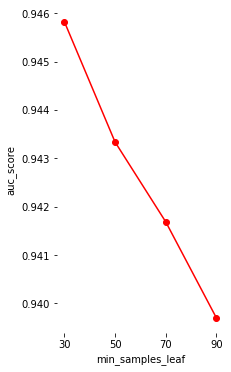

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.9458256775319165


In [722]:
# So best max_features is 30%; let's do min_samples_leaf now

grid13_t10 = {
    'min_samples_leaf': [30, 50, 70, 90],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid13_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=250, max_depth=18,
                                                    max_features=.3),
                                                    paramGrid,
                                                    G_train, h_train, G_val, h_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

Okay, so the default min_samples_leaf of 1 actually produced a slightly better AUC score than the options I've put in, so I'll just leave it at 1.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   25.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s finished


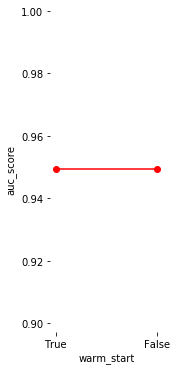

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=True) 0.9492147691125149


In [723]:
# Now check on warm_start
grid14_t10 = {
    'warm_start': [True, False],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid14_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=250, max_depth=18,
                                                    max_features=.3, min_samples_leaf=1),
                                                    paramGrid,
                                                    G_train, h_train, G_val, h_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

Warm_start is exactly the same when set to both True and False. We'll leave it at False, which is the default, and what it has been all along. 

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   23.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   23.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s finished


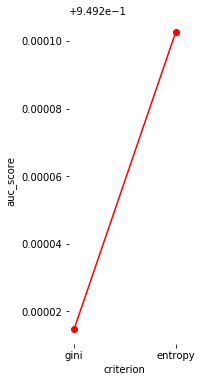

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=18, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.9493024967188999


In [724]:
# The last param we'll worry about is criterion
grid15_t10 = {
    'criterion': ['gini', 'entropy'],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid15_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=250, max_depth=18,
                                                    max_features=.3, min_samples_leaf=1),
                                                    paramGrid,
                                                    G_train, h_train, G_val, h_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

Entropy is a tiny bit better. Let's check training set scores before moving on to track20.

In [725]:
acc_score = best_model.score(G_train, h_train)
print('Accuracy of T10 Random Forest on training set: {:.3f}'.format(acc_score))

Accuracy of T10 Random Forest on training set: 0.896


In [726]:
probs = best_model.predict_proba(G_train)[:,1]

In [727]:
# Now auc score for val set
rf_auc10 = roc_auc_score(h_train, probs)
rf_auc10

0.9560454427895709

In [728]:
# Now for track20's random forest - Create separate datasets so outcome variable is isolated and ready for models
I, j = track20_sl.iloc[:,:], Xclusters_track20_dummies.iloc[:,41]

In [729]:
# Split into train, val, and test sets for rf model
I_train, I_test, j_train, j_test = train_test_split(I, j, test_size=0.2, stratify=j, random_state=340)
I_train, I_val, j_train, j_val = train_test_split(I_train, j_train, test_size=0.25, stratify=j_train, random_state=217)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   18.3s remaining:   36.6s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   36.1s remaining:   45.1s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   44.6s remaining:   35.6s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   47.6s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.1min remaining:   18.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    9.8s finished


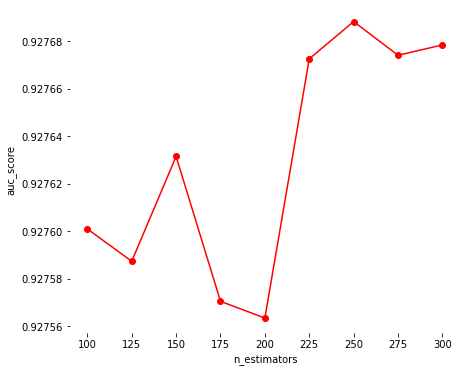

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.927688203563418


In [730]:
# First, we will figure out the best n_estimators for track10's random forest
grid16_t20 = {
    'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid16_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(),paramGrid,
                                                    I_train, j_train, I_val, j_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:  1.8min remaining:   39.1s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:  2.1min remaining:   23.7s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   19.6s finished


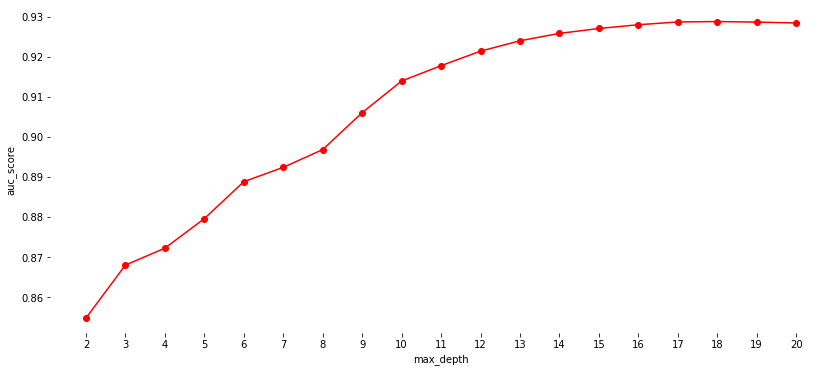

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.928769029087511


In [731]:
# We've got n_estimators now; let's do max_depth

grid17_t20 = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid17_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=250),paramGrid,
                                                    I_train, j_train, I_val, j_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  1.6min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  1.6min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  2.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  2.4min remaining:   47.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   12.4s finished


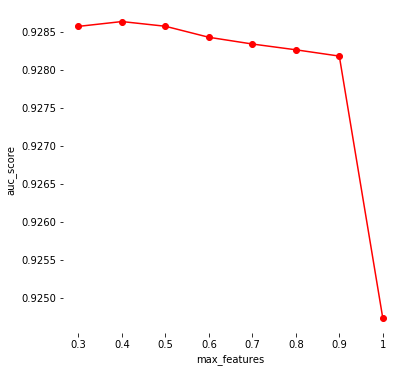

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.9286353495242953


In [732]:
# So best max_depth is 20; let's do max_features now

grid18_t20 = {
    'max_features': [.3, .4, .5, .6, .7, .8, .9, 1],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid18_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=250, max_depth=18),
                                                    paramGrid,
                                                    I_train, j_train, I_val, j_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.6s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   41.7s remaining:   27.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


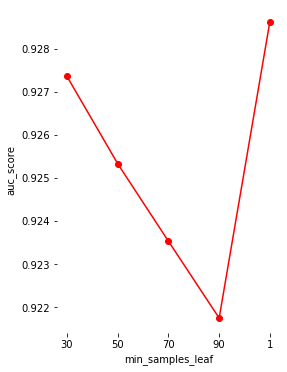

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.9286353495242953


In [733]:
# So best max_features is 30%; let's do min_samples_leaf now (we'll include 1, since it could end up better)

grid19_t20 = {
    'min_samples_leaf': [30, 50, 70, 90, 1],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid19_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=250, max_depth=18,
                                                    max_features=.4),
                                                    paramGrid,
                                                    I_train, j_train, I_val, j_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   31.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   31.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s finished


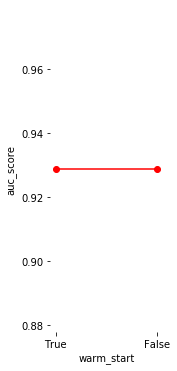

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=True) 0.9286353495242953


In [734]:
# 1 is the best for min_samples_leaf; we'll keep it at that; now we'll look at warm_start

grid20_t20 = {
    'warm_start': [True, False],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid20_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=250, max_depth=18,
                                                    max_features=.4, min_samples_leaf=1),
                                                    paramGrid,
                                                    I_train, j_train, I_val, j_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   33.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   33.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s finished


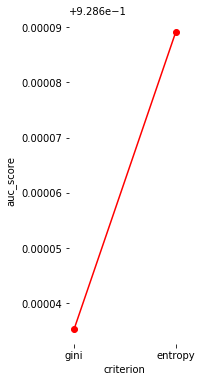

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=18, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False) 0.9286890196623478


In [735]:
# Okay, keep warm_start at default; our final param is criterion

grid21_t20 = {
    'criterion': ['gini', 'entropy'],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid21_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(n_estimators=250, max_depth=18,
                                                    max_features=.4, min_samples_leaf=1),
                                                    paramGrid,
                                                    I_train, j_train, I_val, j_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
    
print(best_model, best_score)

Entropy does just slightly better. We'll keep that for when we run the final model. 
Now we'll just check on our training set scores for track20 before moving on to hyperparameterize xgboost.

In [736]:
acc_score = best_model.score(I_train, j_train)
print('Accuracy of T20 Random Forest on training set: {:.3f}'.format(acc_score))

Accuracy of T20 Random Forest on training set: 0.877


In [737]:
probs = best_model.predict_proba(I_train)[:,1]

In [738]:
# Now auc score for training set
rf_auc20 = roc_auc_score(j_train, probs)
rf_auc20

0.9391991793198446

In [739]:
# Now we'll start with xgboost - track1
# Create separate datasets so outcome variable is isolated and ready for models
K, l = track1_sl.iloc[:,:], Xclusters_track1_dummies.iloc[:,41]

In [740]:
# Split into train, val, and test sets for rf model
K_train, K_test, l_train, l_test = train_test_split(K, l, test_size=0.2, stratify=l, random_state=340)
K_train, K_val, l_train, l_val = train_test_split(K_train, l_train, test_size=0.25, stratify=l_train, random_state=217)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  3.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  3.4min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  5.6min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  6.5min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  7.3min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  9.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  9.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.2s finished


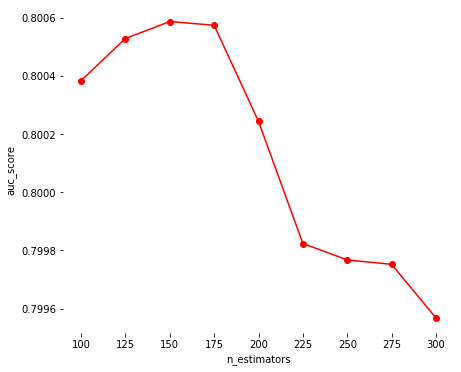

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.8005869894516511


In [741]:
# Find best n_estimators
grid22_t1 = {
    'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid22_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(), paramGrid,
                                                    K_train, l_train, K_val, l_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 15.2min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 18.0min remaining:  4.5min


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 23.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   13.0s finished


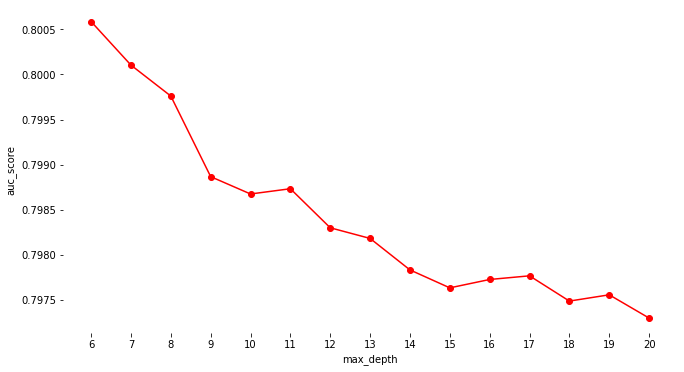

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.8005869894516511


In [742]:
# next let's check out max_depth

grid23_t1 = {
    'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid23_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=150), paramGrid,
                                                    K_train, l_train, K_val, l_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  7.6min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 10.2min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 10.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    3.0s finished


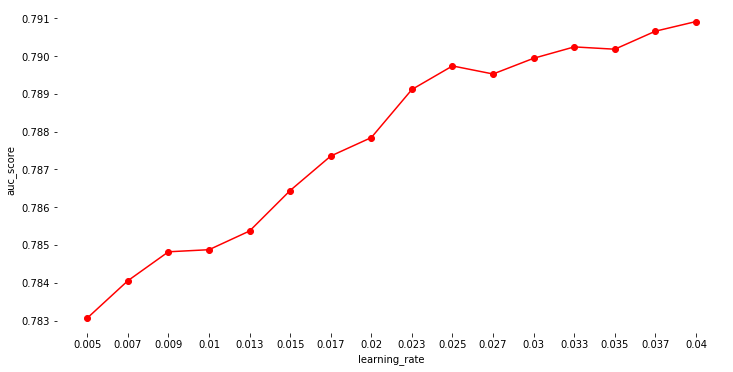

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.04, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.7909127695612658


In [743]:
# 6 was clearly the best max depth; now we'll try to optimize learning rate

grid24_t1 = {
    'learning_rate': [.005, .007, .009, .010, .013, .015, .017, .020, .023, .025, .027, .030, .033, .035, .037, .040],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid24_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=150, max_depth=6), paramGrid,
                                                    K_train, l_train, K_val, l_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

Okay, well learning_rate was actually better at the default setting of 0.300000012, so I'll just go ahead and leave it there.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  2.5min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.6min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.6s finished


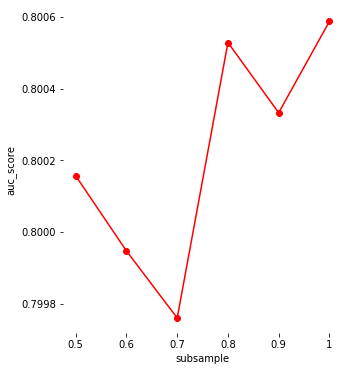

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.8005869894516511


In [744]:
# now we'll see if subsample could make the model better
grid26_t1 = {
    'subsample': [.5, .6, .7, .8, .9, 1],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid26_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=150, max_depth=6, 
                                                    learning_rate=0.300000012), paramGrid,
                                                    K_train, l_train, K_val, l_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.6min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


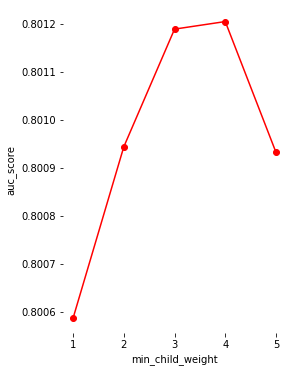

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.8012048941033905


In [745]:
# 1 (default) subsample won; next up I'll try min_child_weight
grid27_t1 = {
    'min_child_weight': [1, 2, 3, 4, 5],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid27_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=150, max_depth=6, 
                                                    learning_rate=0.300000012, subsample=1), 
                                                    paramGrid,
                                                    K_train, l_train, K_val, l_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

5 is best for min_child_weight. Now I'll see if I can optimize scale_pos_weight. The default value is 1, and I'm going to see if the sum(target's negative instances) / sum(target's positive instances) will do better here. That number is .525.

In [746]:
l.value_counts()

1    58798
0    30874
Name: skipped, dtype: int64

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.8s finished


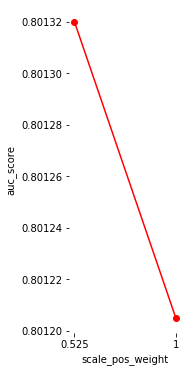

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.525, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None) 0.8013201272411798


In [747]:
# next up I'll try scale_pos_weight
grid28_t1 = {
    'scale_pos_weight': [.525, 1],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid28_t1)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=150, max_depth=6, 
                                                    learning_rate=.300000012, subsample=1, min_child_weight=4), 
                                                    paramGrid,
                                                    K_train, l_train, K_val, l_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

.525 for scale_pos_weight was better. I think thats enough hyper-parameterization for this model. We'll get some preliminary scores for the training set, and then we'll move on to track10.

In [748]:
acc_score = best_model.score(K_train, l_train)
print('Accuracy of T1 XGBoost on training set: {:.3f}'.format(acc_score))

Accuracy of T1 XGBoost on training set: 0.708


In [749]:
probs = best_model.predict_proba(K_train)[:,1]

In [750]:
# Now auc score for training set
xgb_auc1 = roc_auc_score(l_train, probs)
xgb_auc1 

0.8127834421230149

In [751]:
# Now we'll begin with track10 xgboost
# Create separate datasets so outcome variable is isolated and ready for models
M, n = track10_sl.iloc[:,:], Xclusters_track10_dummies.iloc[:,41]

In [752]:
# Split into train, val, and test sets for rf model
M_train, M_test, n_train, n_test = train_test_split(M, n, test_size=0.2, stratify=n, random_state=340)
M_train, M_val, n_train, n_val = train_test_split(M_train, n_train, test_size=0.25, stratify=n_train, random_state=217)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  2.8min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  3.2min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  5.3min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  6.3min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  7.1min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.5s finished


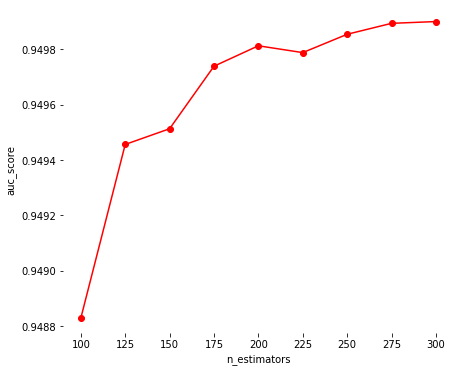

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.949900797060315


In [753]:
# Let's figure out n_estimators
grid29_t10 = {
    'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid29_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(), paramGrid,
                                                    M_train, n_train, M_val, n_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 24.7min remaining: 12.4min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 28.3min remaining:  7.1min


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 35.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   41.6s finished


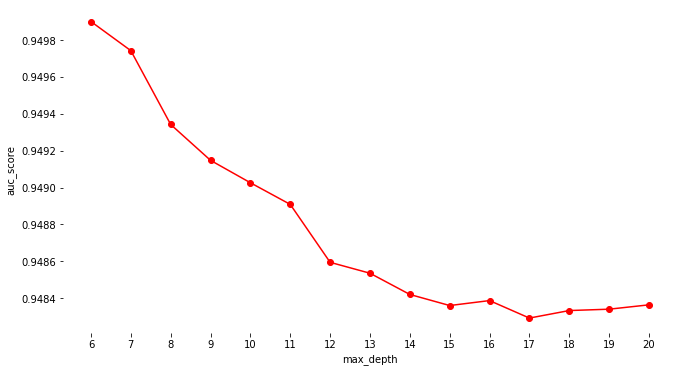

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.949900797060315


In [754]:
# now we know n_estimators; next let's check out max_depth

grid30_t10 = {
    'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid30_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=300), paramGrid,
                                                    M_train, n_train, M_val, n_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 11.9min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 15.8min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 15.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    3.9s finished


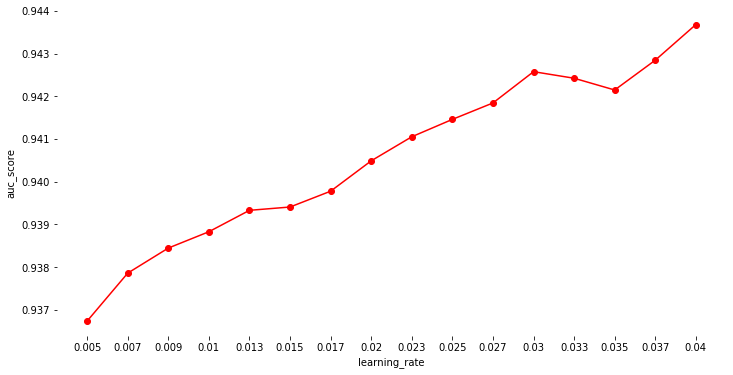

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.04, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.9436782146339318


In [755]:
# 7 was clearly the best max depth; now we'll work on learning rate

grid31_t10 = {
    'learning_rate': [.005, .007, .009, .010, .013, .015, .017, .020, .023, .025, .027, .030, .033, .035, .037, .040],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid31_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=300, max_depth=6), paramGrid,
                                                    M_train, n_train, M_val, n_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

Okay, so again, the default of 0.300000012 actually did a bit better, so we'll just use that.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  3.7min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  3.8min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  3.9min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  6.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.1s finished


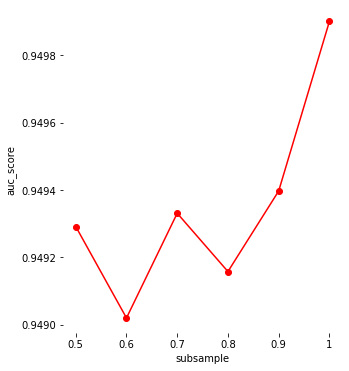

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.949900797060315


In [756]:
# Now we'll see if subsample could make the model better
grid34_t10 = {
    'subsample': [.5, .6, .7, .8, .9, 1],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid34_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=300, max_depth=6, 
                                                    learning_rate=0.300000012), 
                                                    paramGrid,
                                                    M_train, n_train, M_val, n_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.0min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


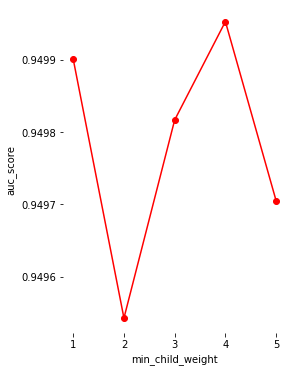

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.9499527953617337


In [757]:
# 1 subsample won; next up I'll try min_child_weight
grid35_t10 = {
    'min_child_weight': [1, 2, 3, 4, 5],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid35_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(max_depth=6, learning_rate=0.300000012, 
                                                    n_estimators=300, subsample=1), 
                                                    paramGrid,
                                                    M_train, n_train, M_val, n_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

In [758]:
n.value_counts()

1    63003
0    26669
Name: skipped, dtype: int64

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s finished


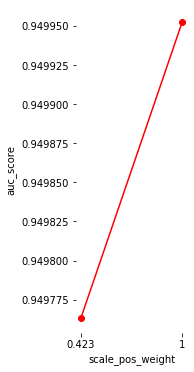

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.9499527953617337


In [759]:
# next up I'll try scale_pos_weight
grid36_t10 = {
    'scale_pos_weight': [.423, 1],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid36_t10)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=300, max_depth=6, 
                                                    learning_rate=0.300000012, subsample=1, min_child_weight=4), 
                                                    paramGrid,
                                                    M_train, n_train, M_val, n_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

1 is best for scale_pos_weight, which is the default. So that concludes our hyper-parameterization of the track10 xgboost. We'll get the scores for the training set and then move on to track 20.

In [760]:
acc_score = best_model.score(M_train, n_train)
print('Accuracy of T10 XGBoost on training set: {:.3f}'.format(acc_score))

Accuracy of T10 XGBoost on training set: 0.893


In [761]:
probs = best_model.predict_proba(M_train)[:,1]

In [762]:
# Now auc score for training set
xgb_auc10 = roc_auc_score(n_train, probs)
xgb_auc10 

0.9529516555026163

In [763]:
# Create separate datasets so outcome variable is isolated and ready for models
O, p = track20_sl.iloc[:,:], Xclusters_track20_dummies.iloc[:,41]

In [764]:
# Split into train, val, and test sets for rf model
O_train, O_test, p_train, p_test = train_test_split(O, p, test_size=0.2, stratify=p, random_state=340)
O_train, O_val, p_train, p_val = train_test_split(O_train, p_train, test_size=0.25, stratify=p_train, random_state=217)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  2.0min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  2.5min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  4.1min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  4.8min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  5.3min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.3s finished


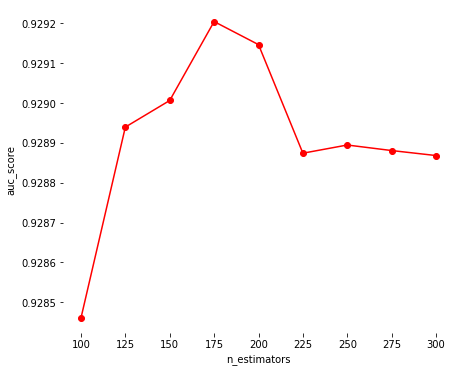

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=175, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.9292047725112362


In [765]:
# Find n_estimators first
grid37_t20 = {
    'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid37_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(), paramGrid,
                                                    O_train, p_train, O_val, p_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  6.6min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  8.0min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


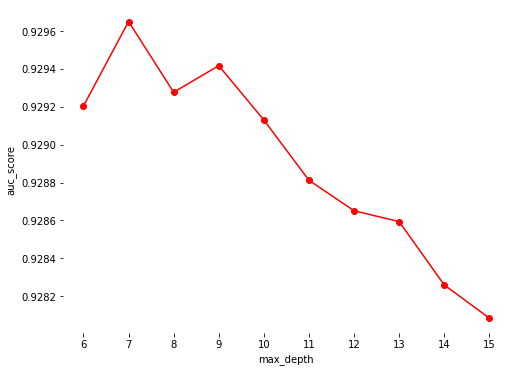

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=175, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.9296503757105181


In [766]:
# Okay know n_estimators now; next let's check out max_depth

grid38_t20 = {
    'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid38_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=175), paramGrid,
                                                    O_train, p_train, O_val, p_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  8.5min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 11.3min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 11.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    3.2s finished


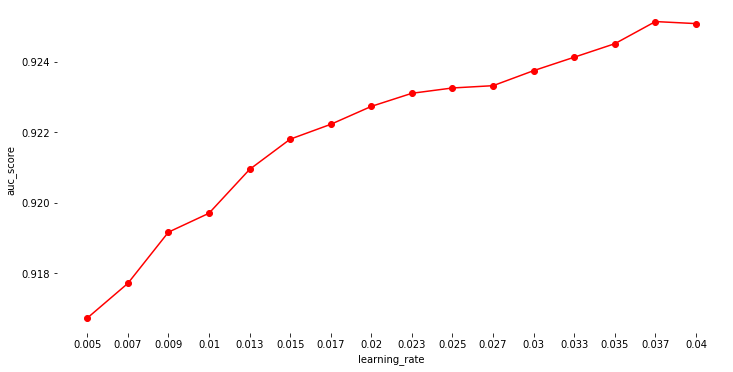

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.037, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=175, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.9251332159023823


In [767]:
#  was clearly the best max depth; now we'll work on learning rate

grid39_t20 = {
    'learning_rate': [.005, .007, .009, .010, .013, .015, .017, .020, .023, .025, .027, .030, .033, .035, .037, .040],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid39_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=175, max_depth=7), 
                                                    paramGrid,
                                                    O_train, p_train, O_val, p_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

Well, the AUC score was actually better when learning_rate was set to the default (.300000012), so I think we'll keept it at that to avoid overcomplicating things.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  2.4min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.6s finished


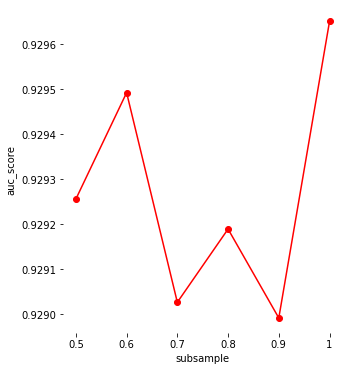

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=175, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.9296503757105181


In [768]:
# Now we'll see if subsample could make the model better
grid42_t20 = {
    'subsample': [.5, .6, .7, .8, .9, 1],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid42_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=175, max_depth=7, 
                                                    learning_rate=0.300000012), 
                                                    paramGrid,
                                                    O_train, p_train, O_val, p_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


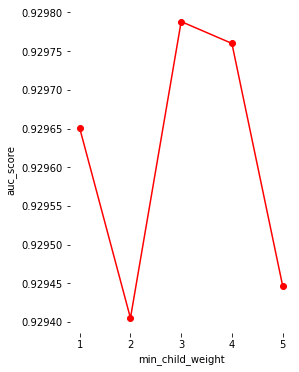

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=175, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.9297882030829983


In [770]:
# 1 subsample won; next up I'll try min_child_weight
grid43_t20 = {
    'min_child_weight': [1, 2, 3, 4, 5],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid43_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=175, max_depth=7, 
                                                    learning_rate=0.300000012, subsample=1), 
                                                    paramGrid,
                                                    O_train, p_train, O_val, p_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

In [771]:
p.value_counts()

1    59677
0    29995
Name: skipped, dtype: int64

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s finished


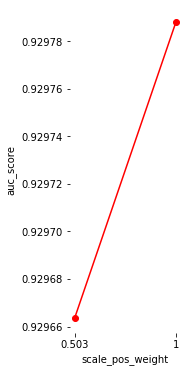

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=175, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.9297882030829983


In [772]:
# the min_child_weight of 5 won; next up I'll try scale_pos_weight
grid44_t20 = {
    'scale_pos_weight': [.503, 1],
    'n_jobs': [-1],
    'random_state': [888]
}
paramGrid = ParameterGrid(grid44_t20)
best_model, best_score, all_models, all_scores = pf.bestFit(XGBClassifier(n_estimators=175, max_depth=7, 
                                                    learning_rate=0.300000012, 
                                                    subsample=1, min_child_weight=3), 
                                                    paramGrid,
                                                    O_train, p_train, O_val, p_val,
                                                    metric=roc_auc_score, greater_is_better=True,
                                                    scoreLabel='auc_score')
print(best_model, best_score)

Okay, the default of 1 for scale_pos_weight was better again. It looks like we're all set now and can run our models  to officially determine which performs best. However, before doing that, I think I want to re-hyper-parameterize the track 1 models, because on further inspection, it might be useful to see what happens when the feature 'paused_before_play" is removed, as there are only 6 0s in it.

In [773]:
# Training set scores for xgboost track20
acc_score = best_model.score(O_train, p_train)
print('Accuracy of T20 XGBoost on training set: {:.3f}'.format(acc_score))

Accuracy of T20 XGBoost on training set: 0.874


In [774]:
probs = best_model.predict_proba(O_train)[:,1]

In [775]:
# Now auc score for training set
xgb_auc20 = roc_auc_score(p_train, probs)
xgb_auc20 

0.935914065709892

In [776]:
# Create some variables just for running the track1 models, so as not to overwrite previous ones
Q, r = track1_sl.iloc[:,:], Xclusters_track1_dummies.iloc[:,41]

In [777]:
# Split into train, val, and test sets for final track1 models
Q_train, Q_test, r_train, r_test = train_test_split(Q, r, test_size=0.2, stratify=r, random_state=340)
Q_train, Q_val, r_train, r_val = train_test_split(Q_train, r_train, test_size=0.25, stratify=r_train, random_state=217)

In [779]:
# Run track1 final 3 models *current*

lr_t1_model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

lr_t1_fit = lr_t1_model.fit(Q_train, r_train) 

rf_t1_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=14, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False)

rf_t1_fit = rf_t1_model.fit(Q_train, r_train)


xgb_t1_model = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=4, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.525, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

xgb_t1_fit = xgb_t1_model.fit(Q_train, r_train)


In [780]:
lr_t1_score = lr_t1_model.score(Q_val, r_val)
lr_t1_score

0.6641761918037357

In [781]:
lr_t1_probs = lr_t1_model.predict_proba(Q_val)[:,1]

In [782]:
lr_t1_auc = roc_auc_score(r_val, lr_t1_probs)
lr_t1_auc

0.718240794293426

In [783]:
rf_t1_score = rf_t1_model.score(Q_val, r_val)
rf_t1_score

0.7190409813214386

In [784]:
rf_t1_probs = rf_t1_model.predict_proba(Q_val)[:,1]

In [785]:
rf_t1_auc = roc_auc_score(r_val, rf_t1_probs)
rf_t1_auc

0.8016798865295105

In [786]:
xgb_t1_score = xgb_t1_model.score(Q_val, r_val)
xgb_t1_score

0.7028157234457764

In [787]:
xgb_t1_probs = xgb_t1_model.predict_proba(Q_val)[:,1]

In [788]:
xgb_t1_auc = roc_auc_score(r_val, xgb_t1_probs) 
xgb_t1_auc

0.8013201272411798

In [789]:
# Create some variables just for running the track10 models, so as not to overwrite previous ones
S, t = track10_sl.iloc[:,:], Xclusters_track10_dummies.iloc[:,41]

In [790]:
# Split into train, val, and test sets for track10 final models
S_train, S_test, t_train, t_test = train_test_split(S, t, test_size=0.2, stratify=t, random_state=340)
S_train, S_val, t_train, t_val = train_test_split(S_train, t_train, test_size=0.25, stratify=t_train, random_state=217)

In [791]:
# Run track10 final 3 models

lr_t10_model = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

lr_t10_fit = lr_t10_model.fit(S_train, t_train)

rf_t10_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=18, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False)

rf_t10_fit = rf_t10_model.fit(S_train, t_train)

xgb_t10_model = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=4, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

xgb_10_fit = xgb_t10_model.fit(S_train, t_train)

In [792]:
lr_t10_score = lr_t10_model.score(S_val, t_val)
lr_t10_score

0.8402007248396989

In [793]:
lr_t10_probs = lr_t10_model.predict_proba(S_val)[:,1]

In [794]:
lr_t10_auc = roc_auc_score(t_val, lr_t10_probs)
lr_t10_auc

0.8614381028139279

In [795]:
rf_t10_score = rf_t10_model.score(S_val, t_val)
rf_t10_score

0.8919431279620853

In [796]:
rf_t10_probs = rf_t10_model.predict_proba(S_val)[:,1]

In [797]:
rf_t10_auc = roc_auc_score(t_val, rf_t10_probs)
rf_t10_auc

0.9493024967188999

In [798]:
xgb_t10_score = xgb_t10_model.score(S_val, t_val)
xgb_t10_score

0.8925564538611653

In [799]:
xgb_t10_probs = xgb_t10_model.predict_proba(S_val)[:,1]

In [800]:
xgb_t10_auc = roc_auc_score(t_val, xgb_t10_probs) 
xgb_t10_auc

0.9499527953617337

In [801]:
# Create some variables just for running the track20 models, so as not to overwrite previous ones
U, v = track20_sl.iloc[:,:], Xclusters_track20_dummies.iloc[:,41]

In [802]:
# Split into train, val, and test sets for track20 final models
U_train, U_test, v_train, v_test = train_test_split(U, v, test_size=0.2, stratify=v, random_state=340)
U_train, U_val, v_train, v_val = train_test_split(U_train, v_train, test_size=0.25, stratify=v_train, random_state=217)

In [804]:
# Run track20 final 3 models

lr_t20_model = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=125,
                   multi_class='multinomial', n_jobs=-1, penalty='none',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

lr_t20_fit = lr_t20_model.fit(U_train, v_train)

rf_t20_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=18, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=888, verbose=0,
                       warm_start=False)

rf_t20_fit = rf_t20_model.fit(U_train, v_train)

xgb_t20_model = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=3, monotone_constraints=None,
              n_estimators=175, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=888, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

xgb_t20_fit = xgb_t20_model.fit(U_train, v_train)

In [805]:
lr_t20_score = lr_t20_model.score(U_val, v_val)
lr_t20_score

0.8246445497630331

In [806]:
lr_t20_probs = lr_t20_model.predict_proba(U_val)[:,1]

In [807]:
lr_t20_auc = roc_auc_score(v_val, lr_t20_probs)
lr_t20_auc

0.84690163675626

In [808]:
rf_t20_score = rf_t20_model.score(U_val, v_val)
rf_t20_score

0.8693615834959576

In [809]:
rf_t20_probs = rf_t20_model.predict_proba(U_val)[:,1]

In [810]:
rf_t20_auc = roc_auc_score(v_val, rf_t20_probs)
rf_t20_auc

0.9286890196623478

In [811]:
xgb_t20_score = xgb_t20_model.score(U_val, v_val)
xgb_t20_score

0.8704767214942849

In [812]:
xgb_t20_probs = xgb_t20_model.predict_proba(U_val)[:,1]

In [813]:
xgb_t20_auc = roc_auc_score(v_val, xgb_t20_probs) 
xgb_t20_auc

0.9297882030829983

So here is the breakdown of accuracy & auc scores by model type: *not current*

**Logistic Regression**

Track 1 - 66.4% accuracy, 71.8% auc

Track 10 - 84.0% accuracy, 86.1% auc

Track 20 - 82.5% accuracy, 84.7% auc


**Random Forest**

Track 1 - 71.9% accuracy, 80.2% auc

Track 10 - 89.2% accuracy, 94.9% auc

Track 20 - 86.9%, accuracy, 92.9% auc

**XGBoost**

Track 1 - 70.3% accuracy, 80.1% auc

Track 10 - 89.3% accuracy, 95.0% auc 

Track 20 - 87.0%, 93.0% auc



rf - better, better, worse, worse, worse, worse
xgb - worse, worse, better, better, better, better

Well, based on the model that has the most better scores, it looks like I'll have to choose XGBoost. Besides, track 1 didn't go well with any model, unfortunately.

Now it's time to get feature_importance for the xgboost

In [814]:
# First get feature importance for xgboost track1

xgb_t1 = xgb_t1_fit   # give the variable from above that fits the xgb model a simpler name

# getting feature importance (as series)
xgb_t1_feat_imp = pd.Series(xgb_t1.feature_importances_, index=Q.columns.values).sort_values(ascending=False)   
xgb_t1_feat_imp

no_seekfwd                    0.350526
no_seekback                   0.203743
hd_clusters                   0.105485
start_fwdbutton               0.092666
early_morn                    0.025402
start_trackdone               0.022917
premium                       0.022466
context_editorial_playlist    0.018989
context_charts                0.014021
afternoon                     0.013660
context_user_collec           0.012118
context_catalog               0.011865
context_radio                 0.011845
start_clickrow                0.011210
morning                       0.011145
seekback_3+                   0.011131
on_shuffle                    0.010869
start_backbutton              0.010560
night                         0.007743
seekback_1to2                 0.006187
appload                       0.005415
context_personal_playlist     0.004700
july                          0.004414
seekfwd_1to2                  0.003768
start_playbutton              0.003231
start_remote             

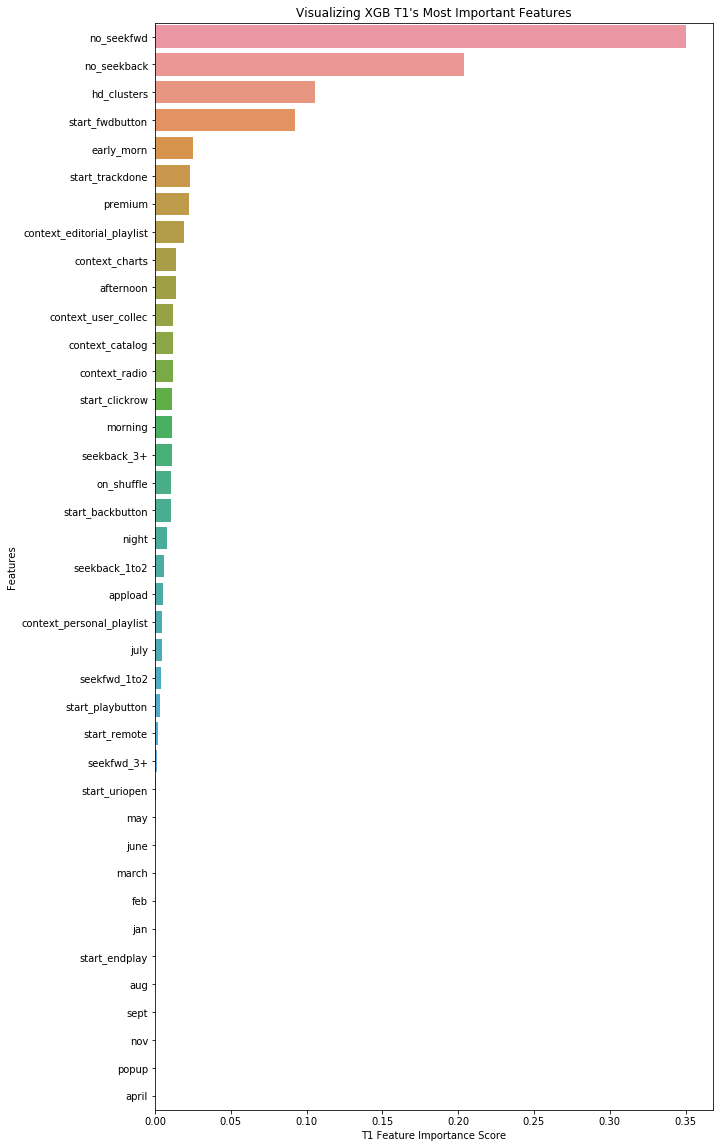

In [815]:
# Plot track1 feature importances
sns.barplot(x=xgb_t1_feat_imp, y=xgb_t1_feat_imp.index)     #plotting gbm feature importance
plt.xlabel('T1 Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing XGB T1's Most Important Features")
fig = plt.gcf()
fig.set_size_inches(10,20)
plt.show()

In [816]:
# get feature importance for xgboost track10

xgb_t10 = xgb_10_fit   # give var from above that fits the xgb model a simpler name (accidentally forgot t earlier)

# getting feature importance (as series)
xgb_t10_feat_imp = pd.Series(xgb_t10.feature_importances_, index=S.columns.values).sort_values(ascending=False)   
xgb_t10_feat_imp

start_trackdone               0.373252
hd_clusters                   0.160697
paused_before_play            0.104822
no_seekfwd                    0.060095
premium                       0.032281
context_personal_playlist     0.024916
context_charts                0.024625
afternoon                     0.019729
morning                       0.018332
context_user_collec           0.018251
night                         0.014959
start_uriopen                 0.014387
start_backbutton              0.014267
start_fwdbutton               0.013377
early_morn                    0.013303
seekback_1to2                 0.011934
no_seekback                   0.011742
start_clickrow                0.011245
context_editorial_playlist    0.010940
context_radio                 0.010195
seekfwd_3+                    0.009469
on_shuffle                    0.008774
switched_context              0.006217
context_catalog               0.004805
july                          0.003186
seekback_3+              

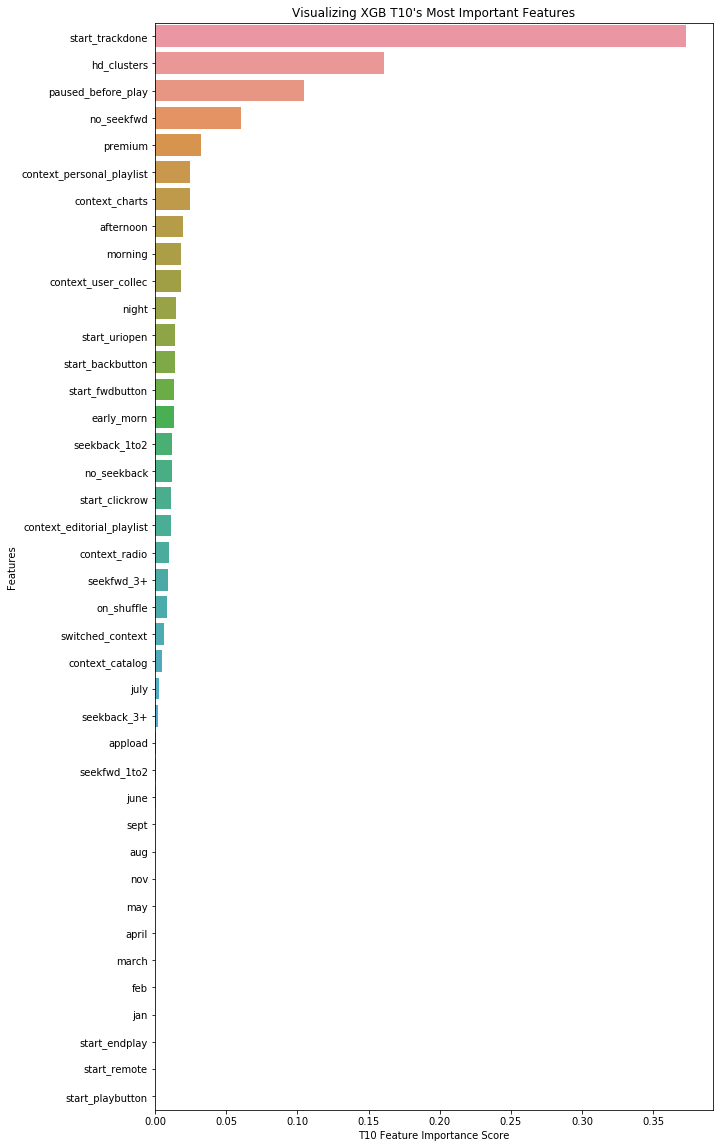

In [817]:
# Plot track10 feature importances
sns.barplot(x=xgb_t10_feat_imp, y=xgb_t10_feat_imp.index)     #plotting gbm feature importance
plt.xlabel('T10 Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing XGB T10's Most Important Features")
fig = plt.gcf()
fig.set_size_inches(10,20)
plt.show()

In [818]:
# get feature importance for xgboost track20

xgb_t20 = xgb_t20_fit   # give var from above that fits the xgb model a simpler name

# getting feature importance (as series)
xgb_t20_feat_imp = pd.Series(xgb_t20.feature_importances_, index=U.columns.values).sort_values(ascending=False)   
xgb_t20_feat_imp

start_trackdone               0.451054
hd_clusters                   0.156377
paused_before_play            0.097004
no_seekfwd                    0.044372
context_personal_playlist     0.022921
context_charts                0.022692
context_user_collec           0.021934
premium                       0.021784
on_shuffle                    0.015406
context_radio                 0.014996
morning                       0.014883
start_clickrow                0.014710
afternoon                     0.013082
seekback_1to2                 0.012370
start_fwdbutton               0.012360
no_seekback                   0.012314
context_catalog               0.008322
context_editorial_playlist    0.007576
night                         0.007482
switched_context              0.007364
early_morn                    0.005996
start_backbutton              0.003177
june                          0.002917
july                          0.002052
seekfwd_1to2                  0.001742
appload                  

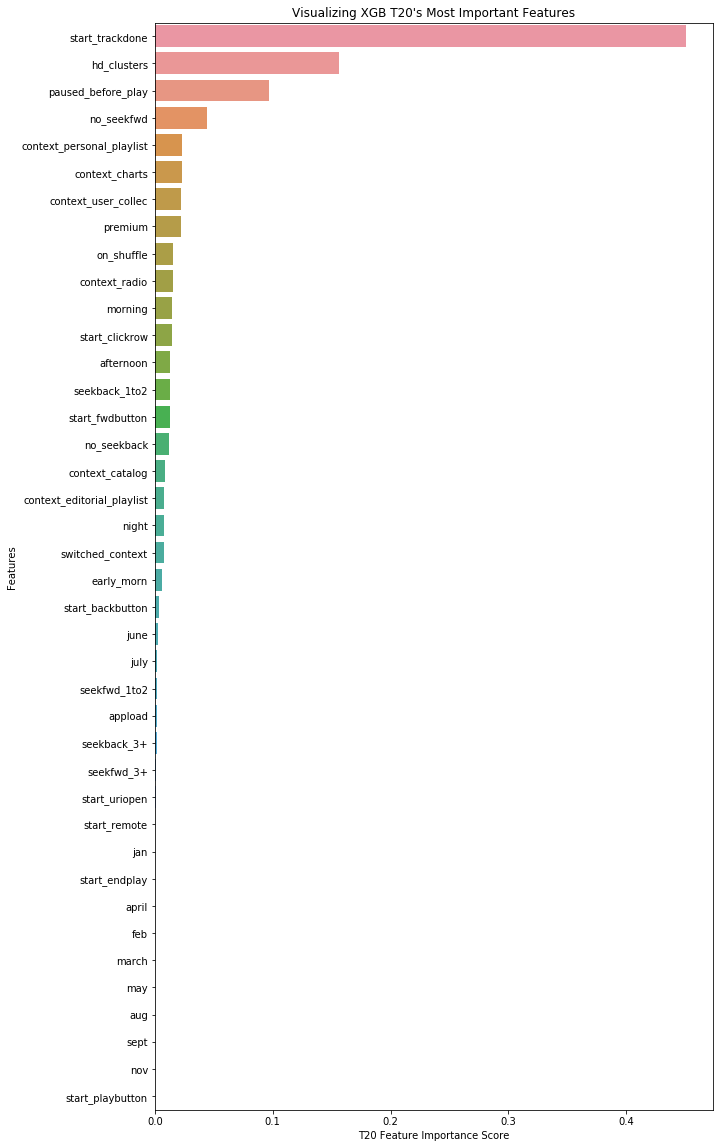

In [819]:
# Plot track20 feature importances
sns.barplot(x=xgb_t20_feat_imp, y=xgb_t20_feat_imp.index)     #plotting gbm feature importance
plt.xlabel('T20 Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing XGB T20's Most Important Features")
fig = plt.gcf()
fig.set_size_inches(10,20)
plt.show()

In [820]:
# Now we should get the test scores for the xgboost (track1)
xgb_t1_model.score(Q_test, r_test)

0.7049902425425146

In [821]:
xgb_t1_probs = xgb_t1_model.predict_proba(Q_test)[:,1]

In [822]:
roc_auc_score(r_test, xgb_t1_probs) 

0.8062008179790136

In [823]:
# Now test scores for track10
xgb_t10_model.score(S_test, t_test)

0.8870922776693616

In [824]:
xgb_t10_probs = xgb_t10_model.predict_proba(S_test)[:,1]

In [826]:
roc_auc_score(t_test, xgb_t10_probs)

0.948373311621104

In [825]:
# Get test scores for track20
xgb_t20_model.score(U_test, v_test)

0.8709785335935322

In [827]:
xgb_t20_probs = xgb_t20_model.predict_proba(U_test)[:,1]

In [828]:
roc_auc_score(v_test, xgb_t20_probs)

0.9281674640701959

In [829]:
# statistical logistic regression for xgboost track1

endog = r 
exog = sm.add_constant(Q.loc[:,[
    'no_seekfwd',                    
    'no_seekback',                  
    'hd_clusters',                   
    'start_fwdbutton',               
    'early_morn',                    
    'start_trackdone',               
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen',                 
    'may',                           
    'june',                          
    'march',                         
    'feb',                           
    'jan',                           
    'start_endplay',                 
    'aug',                          
    'sept',                          
    'nov',                           
    'popup',                         
    'april'
]])    

xgb_lr = sm.Logit(endog, exog['const'])     #running it for the first time with just the constant for baseline

xgb_lr_result = xgb_lr.fit()
print(xgb_lr_result.summary2())

Optimization terminated successfully.
         Current function value: 0.276739
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: inf       
Dependent Variable: skipped          AIC:              49633.4774
Date:               2020-06-13 15:34 BIC:              49642.8813
No. Observations:   89672            Log-Likelihood:   -24816.   
Df Model:           0                LL-Null:          0.0000    
Df Residuals:       89671            LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
--------------------------------------------------------------------
         Coef.     Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const    0.6442      0.0070    91.6570    0.0000    0.6304    0.6580



Now we know that the constant here (y-intercept) is .644 Now we can run it again this time with features

In [830]:
#running it with all features of > importance than may

endog = y
exog = sm.add_constant(Q.loc[:,[
    'no_seekfwd',                    
    'no_seekback',                  
    'hd_clusters',                   
    'start_fwdbutton',               
    'early_morn',                    
    'start_trackdone',               
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen'
]])


#running it with all features of > importance than may
xgb_lr1 = sm.Logit(endog, exog[[
    'no_seekfwd',                    
    'no_seekback',                  
    'hd_clusters',                   
    'start_fwdbutton',               
    'early_morn',                    
    'start_trackdone',               
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen'
]])    

   

xgb_lr_result1 = xgb_lr1.fit()
print(xgb_lr_result1.summary2())

         Current function value: inf
         Iterations: 35
                                     Results: Logit
Model:                        Logit                     Pseudo R-squared:          inf   
Dependent Variable:           skipped                   AIC:                       inf   
Date:                         2020-06-13 16:07          BIC:                       inf   
No. Observations:             89672                     Log-Likelihood:            -inf  
Df Model:                     24                        LL-Null:                   0.0000
Df Residuals:                 89647                     LLR p-value:               1.0000
Converged:                    0.0000                    Scale:                     1.0000
No. Iterations:               35.0000                                                    
-----------------------------------------------------------------------------------------
                            Coef.    Std.Err.      z    P>|z|      [0.025    

Okay, let's try removing features that aren't significant to the model one at a time and see if we can improve the model.  

The first feature I see that is not statistically significant is 'no_seekfwd,' where p=1.0. In my next stat lr, I'm going to remove this and see if it has a useful effect on the model overall.

In [831]:
#running it without no_seekfwd

endog = y
exog = sm.add_constant(Q.loc[:,[                    
    'no_seekback',                  
    'hd_clusters',                   
    'start_fwdbutton',               
    'early_morn',                    
    'start_trackdone',               
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen'
]])


#running it without no_seekfwd
xgb_lr2 = sm.Logit(endog, exog[[                    
    'no_seekback',                  
    'hd_clusters',                   
    'start_fwdbutton',               
    'early_morn',                    
    'start_trackdone',               
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen'
]])    

   

xgb_lr_result2 = xgb_lr2.fit()
print(xgb_lr_result2.summary2())

         Current function value: inf
         Iterations: 35
                              Results: Logit
Model:                   Logit                Pseudo R-squared:     inf   
Dependent Variable:      skipped              AIC:                  inf   
Date:                    2020-06-13 16:44     BIC:                  inf   
No. Observations:        89672                Log-Likelihood:       -inf  
Df Model:                24                   LL-Null:              0.0000
Df Residuals:            89647                LLR p-value:          1.0000
Converged:               0.0000               Scale:                1.0000
No. Iterations:          35.0000                                          
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
no_seekback                 0.7584      nan     nan    nan     nan   

Okay, it looks like removing no_seekfwd is a bad idea. I'll put it back in and see what happens when I take no_seekback out instead. 

In [832]:
#running it without no_seekback

endog = y
exog = sm.add_constant(Q.loc[:,[                    
    'no_seekfwd',                  
    'hd_clusters',                   
    'start_fwdbutton',               
    'early_morn',                    
    'start_trackdone',               
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen'
]])


#running it without no_seekback
xgb_lr3 = sm.Logit(endog, exog[[                    
    'no_seekfwd',                  
    'hd_clusters',                   
    'start_fwdbutton',               
    'early_morn',                    
    'start_trackdone',               
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen'
]])    

   

xgb_lr_result3 = xgb_lr3.fit()
print(xgb_lr_result3.summary2())

         Current function value: inf
         Iterations: 35
                              Results: Logit
Model:                    Logit                Pseudo R-squared:     inf   
Dependent Variable:       skipped              AIC:                  inf   
Date:                     2020-06-13 17:03     BIC:                  inf   
No. Observations:         89672                Log-Likelihood:       -inf  
Df Model:                 24                   LL-Null:              0.0000
Df Residuals:             89647                LLR p-value:          1.0000
Converged:                0.0000               Scale:                1.0000
No. Iterations:           35.0000                                          
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
no_seekfwd                 -0.8784      nan      nan    na

Well, it appears that removeing no_seekback was also a bad idea.

Hopefully the remaining interventions will at least lower the AIC and BIC from infinity.

Now I'll put no_seekback back in and remove early_morn since it's p-value is also 1.0

In [834]:
#running it without early_morn

endog = y
exog = sm.add_constant(Q.loc[:,[                    
    'no_seekfwd', 
    'no_seekback',
    'hd_clusters',                   
    'start_fwdbutton',                                   
    'start_trackdone',               
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen'
]])


#running it without early_morn
xgb_lr4 = sm.Logit(endog, exog[[                    
    'no_seekfwd',
    'no_seekback',
    'hd_clusters',                   
    'start_fwdbutton',                                 
    'start_trackdone',               
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen'
]])    

   

xgb_lr_result4 = xgb_lr4.fit()
print(xgb_lr_result4.summary2())

Optimization terminated successfully.
         Current function value: inf
         Iterations 10
                              Results: Logit
Model:                   Logit                Pseudo R-squared:     inf   
Dependent Variable:      skipped              AIC:                  inf   
Date:                    2020-06-13 17:49     BIC:                  inf   
No. Observations:        89672                Log-Likelihood:       -inf  
Df Model:                24                   LL-Null:              0.0000
Df Residuals:            89647                LLR p-value:          1.0000
Converged:               1.0000               Scale:                1.0000
No. Iterations:          10.0000                                          
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
no_seekfwd                 -1.45

Removing early_morn has not helped either. I'll put it back in and try removing start_trackdone instead.

In [836]:
#running it without start_trackdone

endog = y
exog = sm.add_constant(Q.loc[:,[                    
    'no_seekfwd', 
    'no_seekback',
    'hd_clusters',                   
    'start_fwdbutton',  
    'early_morn',               
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen'
]])


#running it without start_trackdone
xgb_lr5 = sm.Logit(endog, exog[[                    
    'no_seekfwd',
    'no_seekback',
    'hd_clusters',                   
    'start_fwdbutton', 
    'early_morn',              
    'premium',                       
    'context_editorial_playlist',    
    'context_charts',                
    'afternoon',                     
    'context_user_collec',           
    'context_catalog',               
    'context_radio',                 
    'start_clickrow',                
    'morning',                       
    'seekback_3+',                   
    'on_shuffle',                    
    'start_backbutton',              
    'night',                         
    'seekback_1to2',                 
    'appload',                       
    'context_personal_playlist',     
    'july',                          
    'seekfwd_1to2',                  
    'start_playbutton',              
    'start_remote',                  
    'seekfwd_3+',                    
    'start_uriopen'
]])    

   

xgb_lr_result5 = xgb_lr5.fit()
print(xgb_lr_result5.summary2())

         Current function value: inf
         Iterations: 35
                                    Results: Logit
Model:                       Logit                    Pseudo R-squared:         inf   
Dependent Variable:          skipped                  AIC:                      inf   
Date:                        2020-06-13 18:03         BIC:                      inf   
No. Observations:            89672                    Log-Likelihood:           -inf  
Df Model:                    23                       LL-Null:                  0.0000
Df Residuals:                89648                    LLR p-value:              1.0000
Converged:                   0.0000                   Scale:                    1.0000
No. Iterations:              35.0000                                                  
--------------------------------------------------------------------------------------
                            Coef.    Std.Err.     z    P>|z|     [0.025       0.975]  
------------------